In [1]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 101.0.4951
[WDM] - Get LATEST driver version for 101.0.4951
[WDM] - Driver [/home/trosnet/.wdm/drivers/chromedriver/linux64/101.0.4951.41/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [3]:
TIMEOUT = (10, 300)
#NB = 500
NB = 600
OUTPUT_DIR = "../results/dryad_data/"

def dryadRequest(url):
    print("REST request to dryad...")
    # rest request
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except requests.exceptions.SSLError:
            print("Error, retrying...")
            time.sleep(5)
        except requests.exceptions.Timeout:
            print("Timeout error, retrying...")
            time.sleep(5)

    return response

def dryadParser(response):
    print("Parsing result...")
    json_response = response.json()
    next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
    count_step = int(json_response["count"] + 5)
    print(next_page)

    
    dois_list = []
    count = 0
    while True:
        for element in json_response["_embedded"]["stash:datasets"]:
            identifier = element["identifier"].replace("doi:", "https://doi.org/")
            dois_list.append(identifier)

        count += count_step
        if count > NB:
            break
        response = dryadRequest(next_page)
        json_response = response.json()
        next_page = "https://datadryad.org" + json_response["_links"]["next"]["href"]
        print(next_page)
        

    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list
    

In [4]:
response = dryadRequest("https://datadryad.org/api/v2/datasets?per_page=100")
dois_list = dryadParser(response)


print(len(dois_list))

REST request to dryad...
Parsing result...
https://datadryad.org/api/v2/datasets?page=2&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=3&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=4&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=5&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=6&per_page=100
REST request to dryad...
https://datadryad.org/api/v2/datasets?page=7&per_page=100
Retrieved 600 DOIs
600


In [5]:
if "https://doi.org/10.5061/dryad.q84m0" in dois_list:
    dois_list.remove("https://doi.org/10.5061/dryad.q84m0")
    print("Removed")
if "https://doi.org/10.5061/dryad.jd5716f" in dois_list:
    dois_list.remove("https://doi.org/10.5061/dryad.jd5716f")
    print("Removed")
if "https://doi.org/10.5061/dryad.687q0" in dois_list:
    dois_list.remove("https://doi.org/10.5061/dryad.687q0")
    print("Removed")
print(type(dois_list))

Removed
Removed
Removed
<class 'list'>


In [6]:
import random

random.seed(10)

samples_dois_list = random.sample(dois_list, 500)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [7]:
print(len(samples_dois_list))

500


In [8]:
# open file in write mode
# with open("../results/dryad_data/url_list", 'w+') as fp:
#     for item in samples_dois_list:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

#open and read the file
with open("../results/dryad_data/url_list") as f:
    lines = [line.strip() for line in f]
    samples_dois_list = lines

Done


In [9]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_A11(None))
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
metrics_collection.append(FAIRMetricsFactory.get_F2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    df_columns.append(m.get_principle_tag())

In [10]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_A11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time


In [11]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        print(sample)
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [12]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_DRYAD_data_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_DRYAD_data_"+str(i)+".csv")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

https://doi.org/10.5061/dryad.6m20j


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6m20j', 'name': 'Quartet Sampling distinguishes lack of support from conflicting support in the green plant tree of life', 'description': ['Premise of the Study—Phylogenetic support has been difficult to evaluate within the green plant tree of life partly due to a lack of specificity between conflicted versus poorly informed branches. As datasets continue to expand in both breadth and depth, new support measures are needed that are more efficient and informative. Methods— We describe the Quartet Sampling (QS) method, a quartet-based evaluation system that synthesizes several phylogenetic and genomic analytical approaches. QS characterizes discordance in large-sparse and genome-wide datasets, overcoming issues of alignment sparsity and distinguishing strong conflict from weak support. We test QS with simulations and recent plant phylogenies inferred from variously sized datasets. K

INFO:7d6b6d3d-e81f-44ab-ac6a-be87cff51c2d:Checking if the URL uses HTTP protocol
INFO:7d6b6d3d-e81f-44ab-ac6a-be87cff51c2d:The resource use HTTP protocol
INFO:efe87422-c20b-4618-b705-c98acf225ac8:Checking if the URL is reachable, status code: 200
INFO:efe87422-c20b-4618-b705-c98acf225ac8:Status code is OK, meaning the url is Unique.
INFO:44cd2fe2-9a8a-4233-ad2b-f7097e53c96f:Strong evaluation:
INFO:44cd2fe2-9a8a-4233-ad2b-f7097e53c96f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:44cd2fe2-9a8a-4233-ad2b-f7097e53c96f:Found at least one of those property in metadata
INFO:90297cbd-7deb-4eec-bfe5-01bfb1f45ed0:Checking if data is structured, looking for at least one RDF triple...
INFO:90297cbd-7deb-4eec-bfe5-01bfb1f45ed0:142 RDF triples were found, thus data is in a well structured graph format
INFO:5e464a79-98f9-41b7-9661-e097dc01ea8a:Strong evaluation:
INFO:5e464a79-98f9-41b7-9661-e097dc01ea8a:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5061/dryad.rh07b


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0434db11-223b-430b-922e-6eceb9571177:Checking if the URL uses HTTP protocol
INFO:0434db11-223b-430b-922e-6eceb9571177:The resource use HTTP protocol
INFO:665c8458-bb5b-4a68-9919-d7d1f91b8ff0:Checking if the URL is reachable, status code: 200
INFO:665c8458-bb5b-4a68-9919-d7d1f91b8ff0:Status code is OK, meaning the url is Unique.
INFO:472a4525-1828-4362-8586-50b73d41033f:Strong evaluation:
INFO:472a4525-1828-4362-8586-50b73d41033f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:472a4525-1828-4362-8586-50b73d41033f:Found at least one of those property in metadata
INFO:ffa49510-965d-40bb-8523-2f066deeb8f1:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rh07b', 'name': 'The third dimension: a novel set-up for filming coelacanths in their natural environment', 'description': ['Here, we describe a novel design to obtain three-dimensional data on the movements of aquatic organisms at depths of up to 140 m.\r\nThe set-up consists of two synchronized high-speed cameras fixed to two articulated arms.\r\nThe set-up was successfully used to film and quantify the locomotion of coelacanths Latimeria chalumnae living at a depth of about 120 m in Sodwana Bay, South Africa. As an example, the detailed motion of the dorsal fin is presented here.\r\nThis set-up can be used for any underwater applications that require synchronized video recordings of medium- to large-sized animals.', 'Dorsal viewLateral viewCoordinates to identify the 3D trajectory of pectoral finPectoral fin coordinates.txt'], 'url': 'http://datadryad.org/stash/dataset/doi%253A

INFO:bb4dd222-c322-4991-b956-dca2533da315:All properties found in those ontology registries
INFO:bb4dd222-c322-4991-b956-dca2533da315:All classes and properties are known in major ontology registries
INFO:9fa5e62f-c608-4415-b907-c5f586edfacf:Checking if data is structured, looking for at least one RDF triple...
INFO:9fa5e62f-c608-4415-b907-c5f586edfacf:268 RDF triples were found, thus data is in a well structured graph format
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:Strong evaluation:
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:All classes found in those ontology registries
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:All properties found in those ontology registries
INFO:d5eae7a8-dce2-48c8-b895-1955161325f9:All classes and properties are known in major ontology 

https://doi.org/10.5061/dryad.7f138


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fa71ebb4-b210-4cda-9c10-8f8943f83397:Checking if the URL uses HTTP protocol
INFO:fa71ebb4-b210-4cda-9c10-8f8943f83397:The resource use HTTP protocol
INFO:fb318f30-0323-4c9e-aa21-26219d18670d:Checking if the URL is reachable, status code: 200
INFO:fb318f30-0323-4c9e-aa21-26219d18670d:Status code is OK, meaning the url is Unique.
INFO:0e754d28-92f6-4aa3-8b15-b8b7425d16db:Strong evaluation:
INFO:0e754d28-92f6-4aa3-8b15-b8b7425d16db:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0e754d28-92f6-4aa3-8b15-b8b7425d16db:Found at least one of those property in metadata
INFO:dd7bea06-7785-4f33-9e62-7eb49a8f4923:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7f138', 'name': 'Combining high-throughput phenotyping and genomic information to increase prediction and selection accuracy in wheat breeding', 'description': ['Genomics and phenomics have promised to revolutionize the field of plant breeding. The integration of these two fields has just begun and is being driven through big data by advances in next-generation sequencing and developments of field-based high-throughput phenotyping (HTP) platforms. Each year the International Maize and Wheat Improvement Center (CIMMYT) evaluates tens-of-thousands of advanced lines for grain yield across multiple environments. To evaluate how CIMMYT may utilize dynamic HTP data for genomic selection (GS), we evaluated 1170 of these advanced lines in two environments, drought (2014, 2015) and heat (2015). A portable phenotyping system called ‘Phenocart’ was used to measure normalized difference veget

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0dad4561-8228-40fa-acfb-df28d1db2782:Checking if the URL uses HTTP protocol
INFO:0dad4561-8228-40fa-acfb-df28d1db2782:The resource use HTTP protocol
INFO:2fc0290c-117a-4e97-9ed1-965cd692bf61:Checking if the URL is reachable, status code: 200
INFO:2fc0290c-117a-4e97-9ed1-965cd692bf61:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.31v01', 'name': 'Three-dimensional midwater camouflage from a novel two-component photonic structure in hatchetfish skin', 'description': ["The largest habitat by volume on Earth is the oceanic midwater, which is also one of the least understood in terms of animal ecology. The organisms here exhibit a spectacular array of optical adaptations for living in a visual void that have only barely begun to be described. We describe a complex pattern of broadband scattering from the skin of Argyropelecus sp., a hatchetfish found in the mesopelagic zone of the world's oceans. Hatchetfish skin superficially resembles the unpolished side of aluminum foil, but on closer inspection contains a complex composite array of sub-wavelength-scale dielectric structures. The superficial layer of this array contains dielectric stacks that are rectangular in cross-section, while the deeper layer contains

INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:Strong evaluation:
INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:All classes found in those ontology registries
INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:All properties found in those ontology registries
INFO:26c79422-c2ae-4ccf-952f-b5dd1c4b2391:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.f2g14


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a6bf0117-c9da-41ee-bd3a-c584ccf4f348:Checking if the URL uses HTTP protocol
INFO:a6bf0117-c9da-41ee-bd3a-c584ccf4f348:The resource use HTTP protocol
INFO:48590e9f-7add-41f6-a33a-578ed88e13d8:Checking if the URL is reachable, status code: 200
INFO:48590e9f-7add-41f6-a33a-578ed88e13d8:Status code is OK, meaning the url is Unique.
INFO:8a49f180-0287-4111-b60e-7df958adc88a:Strong evaluation:
INFO:8a49f180-0287-4111-b60e-7df958adc88a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8a49f180-0287-4111-b60e-7df958adc88a:Found at least one of those property in metadata
INFO:923de19e-585d-470d-af55-8c9d988a0879:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f2g14', 'name': 'Influence of land use and climate on recent forest expansion: a case study in the Eurosiberian-Mediterranean limit of northwest Spain', 'description': ['1. In Mediterranean mountainous areas, forests have expanded in recent decades because traditional management practices have been abandoned or reduced. However, understanding the ecological mechanism behind landscape change is a complex undertaking as the effects of land use may be influenced (reinforced or constrained) by other factors such as climate. 2. We used orthorectified aerial photographs to monitor changes in forest distribution in a set of 20 head-water basins (located in the Cantabrian Mountains of northwest Spain, at the Eurosiberian-Mediterranean limit) during the second half of the 20th century (1956, 1974, 1983, 1990 and 2004). In particular, we evaluated the combined effects of both land use histo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a890c5b9-e821-43f4-83cb-04871dbd77ce:Checking if the URL uses HTTP protocol
INFO:a890c5b9-e821-43f4-83cb-04871dbd77ce:The resource use HTTP protocol
INFO:62775063-f108-4e71-a07c-d9a117aefdb7:Checking if the URL is reachable, status code: 200
INFO:62775063-f108-4e71-a07c-d9a117aefdb7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5bk4c', 'name': 'Gene expression differs in codominant prairie grasses under drought', 'description': ['Grasslands of the Central US are expected to experience severe droughts and other climate extremes in the future, yet we know little about how these grasses will respond in terms of gene expression. We compared gene expression in Andropogon gerardii and Sorghastrum nutans, two closely related co-dominant C4 grasses responsible for the majority of ecosystem function, using RNA-seq.\r\n\r\nWe compared Trinity assemblies within each species to determine annotated functions of transcripts responding to drought. Subsequently, we compared homologous annotated gene-groups across the two species using cross-species meta-level analysis and functional clustering based on key terms. The majority of variation was found between species, as opposed to between drought and watered treatments. H

INFO:696664ab-19ff-4bac-9bcf-309b872c735a:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.c7366


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ad5fac00-dd44-4802-abc8-4883b213560e:Checking if the URL uses HTTP protocol
INFO:ad5fac00-dd44-4802-abc8-4883b213560e:The resource use HTTP protocol
INFO:7049222c-c0e7-40c1-b376-e831e5054eeb:Checking if the URL is reachable, status code: 200
INFO:7049222c-c0e7-40c1-b376-e831e5054eeb:Status code is OK, meaning the url is Unique.
INFO:1abc7c00-1873-4d8d-b357-e49b62892ac6:Strong evaluation:
INFO:1abc7c00-1873-4d8d-b357-e49b62892ac6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1abc7c00-1873-4d8d-b357-e49b62892ac6:Found at least one of those property in metadata
INFO:8c75422e-d75f-4cdb-9869-97d5f6f0fff7:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c7366', 'name': 'A serial multiplex immunogold labeling method for identifying peptidergic neurons in connectomes', 'description': ['Electron microscopy-based connectomics aims to comprehensively map synaptic connections in neural tissue. However, current approaches are limited in their capacity to directly assign molecular identities to neurons. Here, we use serial multiplex immunogold labeling (siGOLD) and serial-section transmission electron microscopy (ssTEM) to identify multiple peptidergic neurons in a connectome. The high immunogenicity of neuropeptides and their broad distribution along axons, allowed us to identify distinct neurons by immunolabeling small subsets of sections within larger series. We demonstrate the scalability of siGOLD by using 11 neuropeptide antibodies on a full-body larval ssTEM dataset of the annelid Platynereis. We also reconstruct a peptidergic cir

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1877269f-df8a-4b8c-836e-b301f4ce0706:Checking if the URL uses HTTP protocol
INFO:1877269f-df8a-4b8c-836e-b301f4ce0706:The resource use HTTP protocol
INFO:107d6719-3695-419e-abe6-19a559da6829:Checking if the URL is reachable, status code: 200
INFO:107d6719-3695-419e-abe6-19a559da6829:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1rf7d', 'name': 'Adélie penguin population diet monitoring by analysis of food DNA in scats', 'description': ['The Adélie penguin is the most important animal currently used for ecosystem monitoring in the Southern Ocean. The diet of this species is generally studied by visual analysis of stomach contents; or ratios of isotopes of carbon and nitrogen incorporated into the penguin from its food. There are significant limitations to the information that can be gained from these methods. We evaluated population diet assessment by analysis of food DNA in scats as an alternative method for ecosystem monitoring with Adélie penguins as an indicator species. Scats were collected at four locations, three phases of the breeding cycle, and in four different years. A novel molecular diet assay and bioinformatics pipeline based on nuclear small subunit ribosomal RNA gene (SSU rDNA) sequencing 

INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:Strong evaluation:
INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:All classes found in those ontology registries
INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:All properties found in those ontology registries
INFO:da622866-7c6b-4138-ade0-cb6bf4f9878e:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.h702r


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2988858f-b4b2-419c-b0fb-38f30edf777d:Checking if the URL uses HTTP protocol
INFO:2988858f-b4b2-419c-b0fb-38f30edf777d:The resource use HTTP protocol
INFO:8ef94e6a-d9d5-4d76-baed-3f3e0544edf6:Checking if the URL is reachable, status code: 200
INFO:8ef94e6a-d9d5-4d76-baed-3f3e0544edf6:Status code is OK, meaning the url is Unique.
INFO:1dc1c13e-2856-4481-bfbd-215b0bfb561e:Strong evaluation:
INFO:1dc1c13e-2856-4481-bfbd-215b0bfb561e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1dc1c13e-2856-4481-bfbd-215b0bfb561e:Found at least one of those property in metadata
INFO:4a17640c-2d29-4429-8ac5-21a81ee8d02a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h702r', 'name': 'Pulmonary anatomy in the Nile crocodile and the evolution of unidirectional airflow in Archosauria.', 'description': ['The lungs of birds have long been known to move air in only one direction during both inspiration and expiration through most of the tubular gas-exchanging bronchi (parabronchi). Recently a similar pattern of airflow has been observed in American alligators, a sister taxon to birds. The pattern of flow appears to be due to the arrangement of the primary and secondary bronchi, which, via their branching angles, generate inspiratory and expiratory aerodynamic valves. Both the anatomical similarity of the avian and alligator lung and the similarity in the patterns of airflow raise the possibility that these features are plesiomorphic for Archosauria and therefore did not evolve in response to selection for flapping flight or an endothermic metabolism

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:33399467-ab76-4a0a-8d2e-bf8ab4ef72ee:Checking if the URL uses HTTP protocol
INFO:33399467-ab76-4a0a-8d2e-bf8ab4ef72ee:The resource use HTTP protocol
INFO:cca1c087-b71e-49c3-88c1-19d8fd361614:Checking if the URL is reachable, status code: 200
INFO:cca1c087-b71e-49c3-88c1-19d8fd361614:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4gm03', 'name': 'Ecological speciation in sympatric palms: 1. Gene expression, selection and pleiotropy', 'description': ['Ecological speciation requires divergent selection, reproductive isolation, and a genetic mechanism to link the two. We examined the role of gene expression and coding sequence evolution in this process using two species of Howea palms that have diverged sympatrically on Lord Howe Island, Australia. These palms are associated with distinct soil types and have displaced flowering times, representing an ideal candidate for ecological speciation. We generated large amounts of RNA-Seq data from multiple individuals and tissue types collected on the island from each of the two species. We found that differentially expressed loci as well as those with divergent coding sequences between Howea species were associated with known ecological and phenotypic differences, i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3c1dc867-da92-4645-aed4-77dd51502808:Checking if the URL uses HTTP protocol
INFO:3c1dc867-da92-4645-aed4-77dd51502808:The resource use HTTP protocol
INFO:61543ad5-e6f8-4e02-a707-b8aab8382e39:Checking if the URL is reachable, status code: 200
INFO:61543ad5-e6f8-4e02-a707-b8aab8382e39:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8bj97', 'name': 'The extracellular domains of IgG1 and T cell-derived IL-4/IL-13 are critical for the polyclonal memory IgE response in vivo', 'description': ['IgE-mediated activation of mast cells and basophils contributes to protective immunity against helminths but also causes allergic responses. The development and persistence of IgE responses are poorly understood, which is in part due to the low number of IgE-producing cells. Here, we used next generation sequencing to uncover a striking overlap between the IgE and IgG1 repertoires in helminth-infected or OVA/alum-immunized wild-type BALB/c mice. The memory IgE response after secondary infection induced a strong increase of IgE+ plasma cells in spleen and lymph nodes. In contrast, germinal center B cells did not increase during secondary infection. Unexpectedly, the memory IgE response was lost in mice where the extracellula

INFO:31f6d945-8c42-411d-83bf-6e95565109f5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:31f6d945-8c42-411d-83bf-6e95565109f5:All properties found in those ontology registries
INFO:31f6d945-8c42-411d-83bf-6e95565109f5:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.216tp


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12e1654c-ade2-4323-93e1-7cb55b2aefb7:Checking if the URL uses HTTP protocol
INFO:12e1654c-ade2-4323-93e1-7cb55b2aefb7:The resource use HTTP protocol
INFO:99802ed3-9ad9-47fe-9e44-909c68483e1a:Checking if the URL is reachable, status code: 200
INFO:99802ed3-9ad9-47fe-9e44-909c68483e1a:Status code is OK, meaning the url is Unique.
INFO:cf74ce32-cefc-4dac-8ca9-3e8f7eec56d6:Strong evaluation:
INFO:cf74ce32-cefc-4dac-8ca9-3e8f7eec56d6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cf74ce32-cefc-4dac-8ca9-3e8f7eec56d6:Found at least one of those property in metadata
INFO:323a2a7f-8650-4279-bcaa-49fe4ee88b68:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.216tp', 'name': 'Substantial compositional turnover of fungal communities in an alpine ridge-to-snowbed gradient', 'description': ['The main gradient in vascular plant, bryophyte and lichen species composition in alpine areas, structured by the topographic gradient from wind-exposed ridges to snowbeds, has been extensively studied. Tolerance to environmental stress, resulting from wind abrasion and desiccation towards windswept ridges or reduced growing season due to prolonged snow cover towards snowbeds, is an important ecological mechanism in this gradient. The extent to which belowground fungal communities are structured by the same topographic gradient, and the eventual mechanisms involved, are less well known. In this study, we analyzed variation in fungal diversity and community composition associated with roots of the ectomycorrhizal plant Bistorta vivipara along the ridge-

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a5805cd0-38bf-489c-a039-837350e200ca:Checking if the URL uses HTTP protocol
INFO:a5805cd0-38bf-489c-a039-837350e200ca:The resource use HTTP protocol
INFO:b6652ce2-2400-40f5-8e34-35a6b5bad6bc:Checking if the URL is reachable, status code: 200
INFO:b6652ce2-2400-40f5-8e34-35a6b5bad6bc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t8v81', 'name': 'Characterizing wildlife behavioural responses to roads using integrated step selection analysis', 'description': ['Roads are a prevalent, ever-increasing form of human disturbance on the landscape. In many places in western North America, energy development has brought human and road disturbance into seasonal winter range areas for migratory elk.\r\n\r\nWe sought to evaluate the predictions from the risk-disturbance hypothesis when studying elk response to roads during winter. Road proximity and crossing were used to evaluate these behaviours, which offered a rare comparison between two common measures of roads. We used integrated step selection analysis (iSSA) to evaluate four alternative hypotheses regarding the influence of roads on space-use behaviour across 175 elk-years of elk telemetry data, and we quantified both population-level and individual-level varia

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:45fa4047-fd00-4350-b3d1-cbf3fd739eb9:Checking if the URL uses HTTP protocol
INFO:45fa4047-fd00-4350-b3d1-cbf3fd739eb9:The resource use HTTP protocol
INFO:b0a6ec02-1328-4b1e-a3c8-f28d097aea35:Checking if the URL is reachable, status code: 200
INFO:b0a6ec02-1328-4b1e-a3c8-f28d097aea35:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0bq52', 'name': 'Modeling seasonal surface temperature variations in secondary tropical dry forests', 'description': ['Secondary tropical dry forests (TDFs) provide important ecosystem services such as carbon sequestration, biodiversity conservation, and nutrient cycle regulation. However, their biogeophysical processes at the canopy-atmosphere interface remain unknown, limiting our understanding of how this endangered ecosystem influences, and responds to the ongoing global warming. To facilitate future development of conservation policies, this study characterized the seasonal land surface temperature (LST) behavior of three successional stages (early, intermediate, and late) of a TDF, at the Santa Rosa National Park (SRNP), Costa Rica. A total of 38 Landsat-8 Thermal Infrared Sensor (TIRS) data and the Surface Reflectance (SR) product were utilized to model LST time series from

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b1043dfe-a3da-49f8-80ca-4fe122d61fdb:Checking if the URL uses HTTP protocol
INFO:b1043dfe-a3da-49f8-80ca-4fe122d61fdb:The resource use HTTP protocol
INFO:3519be09-ff9e-4ff7-aa2b-322019e7e55f:Checking if the URL is reachable, status code: 200
INFO:3519be09-ff9e-4ff7-aa2b-322019e7e55f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.58c73', 'name': 'Use of anisotropy, 3D segmented atlas, and computational analysis to identify gray matter subcortical lesions common to concussive injury from different sites on the cortex', 'description': ['Traumatic brain injury (TBI) can occur anywhere along the cortical mantel. While the cortical contusions may be random and disparate in their locations, the clinical outcomes are often similar and difficult to explain. Thus a question that arises is, do concussions at different sites on the cortex affect similar subcortical brain regions? To address this question we used a fluid percussion model to concuss the right caudal or rostral cortices in rats. Five days later, diffusion tensor MRI data were acquired for indices of anisotropy (IA) for use in a novel method of analysis to detect changes in gray matter microarchitecture. IA values from over 20,000 voxels were registered 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7e8b328b-d140-4e0b-835f-64fae1644d7c:Checking if the URL uses HTTP protocol
INFO:7e8b328b-d140-4e0b-835f-64fae1644d7c:The resource use HTTP protocol
INFO:78027909-ac97-4b88-a21c-27dcdfe24308:Checking if the URL is reachable, status code: 200
INFO:78027909-ac97-4b88-a21c-27dcdfe24308:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2k6v37j', 'name': 'Placental H3K27me3 establishes female resilience to prenatal insults', 'description': ['Although sex biases in disease presentation are well documented, the mechanisms mediating vulnerability or resilience to diseases are unknown. In utero insults are more likely to produce detrimental health outcomes for males versus females. In our mouse model of prenatal stress, male offspring experience long-term dysregulation of body weight and hypothalamic pituitary adrenal stress axis dysfunction, endophenotypes of male-biased neurodevelopmental disorders. Placental function is critical for healthy fetal development, and we previously showed that sex differences in placental O-linked N-acetylglucosamine transferase (OGT) mediate the effects of prenatal stress on neurodevelopmental programming. Here we show that one mechanism whereby sex differences in OGT confer variation

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2a648169-2637-42b6-b512-a7c238a172bc:Checking if the URL uses HTTP protocol
INFO:2a648169-2637-42b6-b512-a7c238a172bc:The resource use HTTP protocol
INFO:3ec48153-6c77-498f-a008-2a88666e1cf3:Checking if the URL is reachable, status code: 200
INFO:3ec48153-6c77-498f-a008-2a88666e1cf3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8m2q8', 'name': 'The arrangement of possible muscle fibres in the Ediacaran taxon Haootia quadriformis', 'description': ['Haootia quadriformis from Newfoundland, Canada, is one of the most unusual impressions of a soft-bodied macro-organism yet described from the late Ediacaran Period. Interpreted as a metazoan of cnidarian grade, the body impression of H. quadriformis possesses features interpreted as fibrous structures that represent possible evidence for muscular tissue. Evidence both in support of and against a relationship between H. quadriformis and the Staurozoa, one of the cnidarian groups to which Haootia was compared in Liu et al., is outlined by Miranda et al.. Our intention in our original paper was to illustrate the staurozoan body plan for comparative purposes, rather than suggest homology or direct ancestry. Nevertheless, fresh insights from workers with expertise i

INFO:13ada590-09b6-4967-9d70-d6e97096e467:All classes found in those ontology registries
INFO:13ada590-09b6-4967-9d70-d6e97096e467:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:13ada590-09b6-4967-9d70-d6e97096e467:All properties found in those ontology registries
INFO:13ada590-09b6-4967-9d70-d6e97096e467:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.dq91858


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:332d65c2-62e1-4e09-bb4e-b71a00a6b5c7:Checking if the URL uses HTTP protocol
INFO:332d65c2-62e1-4e09-bb4e-b71a00a6b5c7:The resource use HTTP protocol
INFO:acc7bbbf-0131-470a-ae35-76d0ec6d5838:Checking if the URL is reachable, status code: 200
INFO:acc7bbbf-0131-470a-ae35-76d0ec6d5838:Status code is OK, meaning the url is Unique.
INFO:5164b627-e31d-4ca7-8aeb-26f0461b5ca5:Strong evaluation:
INFO:5164b627-e31d-4ca7-8aeb-26f0461b5ca5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5164b627-e31d-4ca7-8aeb-26f0461b5ca5:Found at least one of those property in metadata
INFO:41892435-e32d-4089-8f2e-c7cf218d3767:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dq91858', 'name': 'Genetic analysis of sugarcane mosaic virus resistance in the Wisconsin Diversity Panel of maize', 'description': ['Sugarcane mosaic virus (SCMV) and Maize dwarf mosaic virus can cause yield loss in maize (Zea mays L.). Previous studies identified two key genomic regions controlling host resistance: Scmv1 on chromosome 6 and Scmv2 on chromosome 3. In this study a diverse set of 578 inbreds adapted to a northern US Corn Belt environment, was inoculated at the three-leaf stage with SCMV and rated for presence of virus symptoms at 7, 10, 14, 21, 28, and 35 d after inoculation. Scmv1 was present in all resistant inbreds. A single-nucleotide polymorphism associated with SCMV resistance was found 5 Mb downstream of the putative location of Scmv1, and resistance at this downstream locus was correlated with a group of inbreds containing the presence allele of a 2.7-Mb pr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:97c91a27-ba03-470a-a699-d155644b198a:Checking if the URL uses HTTP protocol
INFO:97c91a27-ba03-470a-a699-d155644b198a:The resource use HTTP protocol
INFO:af7d4d6b-48c8-4840-850c-7cded93c239f:Checking if the URL is reachable, status code: 200
INFO:af7d4d6b-48c8-4840-850c-7cded93c239f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c5p1f', 'name': 'Transcriptome profiling of ontogeny in the acridid grasshopper Chorthippus biguttulus', 'description': ['Acridid grasshoppers (Orthoptera:Acrididae) are widely used model organisms for developmental, evolutionary, and neurobiological research. Although there has been recent influx of orthopteran transcriptomic resources, many use pooled ontogenetic stages obscuring information about changes in gene expression during development. Here we developed a de novo transcriptome spanning 7 stages in the life cycle of the acridid grasshopper Chorthippus biguttulus. Samples from different stages encompassing embryonic development through adults were used for transcriptomic profiling, revealing patterns of differential gene expression that highlight processes in the different life stages. These patterns were validated with semi-quantitative RT-PCR. Embryonic development showe

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eeb2b2ab-8ea2-42f2-9e56-1e336c75cb49:Checking if the URL uses HTTP protocol
INFO:eeb2b2ab-8ea2-42f2-9e56-1e336c75cb49:The resource use HTTP protocol
INFO:1c0a7cc1-7698-4f8c-bfcf-aa9bef201213:Checking if the URL is reachable, status code: 200
INFO:1c0a7cc1-7698-4f8c-bfcf-aa9bef201213:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4181f', 'name': 'Vitis phylogenomics: hybridization intensities from a SNP array outperform genotype calls', 'description': ['Understanding relationships among species is a fundamental goal of evolutionary biology. Single nucleotide polymorphisms (SNPs) identified through next generation sequencing and related technologies enable phylogeny reconstruction by providing unprecedented numbers of characters for analysis. One approach to SNP-based phylogeny reconstruction is to identify SNPs in a subset of individuals, and then to compile SNPs on an array that can be used to genotype additional samples at hundreds or thousands of sites simultaneously. Although powerful and efficient, this method is subject to ascertainment bias because applying variation discovered in a representative subset to a larger sample favors identification of SNPs with high minor allele frequencies and introduc

INFO:bfdb18c1-6c16-4773-9b77-592deb67dfd1:All properties found in those ontology registries
INFO:bfdb18c1-6c16-4773-9b77-592deb67dfd1:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.9fs7n


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e1a1b13f-fbae-437f-920e-48c859c1ec8c:Checking if the URL uses HTTP protocol
INFO:e1a1b13f-fbae-437f-920e-48c859c1ec8c:The resource use HTTP protocol
INFO:c5674cb1-4624-4f80-9274-8a5742eeb159:Checking if the URL is reachable, status code: 200
INFO:c5674cb1-4624-4f80-9274-8a5742eeb159:Status code is OK, meaning the url is Unique.
INFO:1d475361-0693-41c5-b804-09d58b7efe7e:Strong evaluation:
INFO:1d475361-0693-41c5-b804-09d58b7efe7e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d475361-0693-41c5-b804-09d58b7efe7e:Found at least one of those property in metadata
INFO:9030d02b-1320-41e2-b265-9e58084024bd:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9fs7n', 'name': 'Nest etiquette - where ants go when nature calls', 'description': ['Sanitary behaviour is an important, but seldom studied, aspect of social living. Social insects have developed several strategies for dealing with waste and faecal matter, including dumping waste outside the nest and forming specialised waste-storage chambers. In some cases waste material and faeces are put to use, either as a construction material or as a long-lasting signal, suggesting that faeces and waste may not always be dangerous. Here we examine a previously undescribed behaviour in ants – the formation of well-defined faecal patches. Lasius niger ants were housed in plaster nests and provided with coloured sucrose solution. After two months, 1–4 well defined dark patches, the colour of the sucrose solution, formed within each of the plaster nests. These patches never contained other waste

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b62c5286-671f-413b-a4f7-4d83fd011296:Checking if the URL uses HTTP protocol
INFO:b62c5286-671f-413b-a4f7-4d83fd011296:The resource use HTTP protocol
INFO:b200e610-9287-4c40-a564-5b16ff03177f:Checking if the URL is reachable, status code: 200
INFO:b200e610-9287-4c40-a564-5b16ff03177f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mn686', 'name': 'Examining the business case and models for sustainable multifunctional edible landscaping enterprises in the Phoenix Metro Area', 'description': ['This study assesses whether multifunctional edible landscaping business models provide a sufficient business case at enterprise and city scales to justify widespread implementation. First, semi-structured interviews were conducted with four landscaping entrepreneurs, and the information obtained from the interviews was utilized to carry out a business model comparison with the Business Model Canvas framework. The comparison showed that the landscaping enterprises using multifunctional edible landscaping methods possessed a greater range of value propositions and revenue streams, enhancing their competitive advantage. Second, a GIS landscape analysis of seven Phoenix metro area cities was carried out to identify landscap

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a81044a2-1837-40ee-b70b-7b0a686ad72a:Checking if the URL uses HTTP protocol
INFO:a81044a2-1837-40ee-b70b-7b0a686ad72a:The resource use HTTP protocol
INFO:48275f4a-49f4-4328-b8a3-102d57a46a4c:Checking if the URL is reachable, status code: 200
INFO:48275f4a-49f4-4328-b8a3-102d57a46a4c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.p236p', 'name': 'Unique features of germline variation in five Egyptian familial breast cancer families revealed by exome sequencing', 'description': ['Genetic predisposition increases the risk of familial breast cancer. Recent studies indicate that genetic predisposition for familial breast cancer can be ethnic-specific. However, current knowledge of genetic predisposition for the disease is predominantly derived from Western populations. Using this existing information as the sole reference to judge the predisposition in non-Western populations is not adequate and can potentially lead to misdiagnosis. Efforts are required to collect genetic predisposition from non-Western populations. The Egyptian population has high genetic variations in reflecting its divergent ethnic origins, and incident rate of familial breast cancer in Egypt is also higher than the rate in many other popul

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2e118f66-dac1-4414-baec-7f60d13040ad:Checking if the URL uses HTTP protocol
INFO:2e118f66-dac1-4414-baec-7f60d13040ad:The resource use HTTP protocol
INFO:424de742-5ebc-4c72-a5d8-b68ac23c4d91:Checking if the URL is reachable, status code: 200
INFO:424de742-5ebc-4c72-a5d8-b68ac23c4d91:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.88fm3', 'name': 'Soil fungal communities of grasslands are environmentally structured at a regional scale in the Alps', 'description': ['Studying patterns of species distributions along elevation gradients is frequently used to identify the primary factors that determine the distribution, diversity and assembly of species. However, despite their crucial role in ecosystem functioning, our understanding of the distribution of below-ground fungi is still limited, calling for more comprehensive studies of fungal biogeography along environmental gradients at various scales (from regional to global). Here, we investigated the richness of taxa of soil fungi and their phylogenetic diversity across a wide range of grassland types along a 2800 m elevation gradient at a large number of sites (213), stratified across a region of the western Swiss Alps (700 km2). We used 454 pyro-sequencing to

INFO:5c64d47c-e739-4575-b3ff-2bd8f7335861:At least 3 different domains were found in metadata (5)
INFO:70e82304-c8b5-4e0a-84a2-358c964aaf30:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:70e82304-c8b5-4e0a-84a2-358c964aaf30:At least one of the licence property was found in metadata !
INFO:2307cb85-e562-45c7-8931-604d58b8540a:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:has

https://doi.org/10.5061/dryad.hm813


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:384521e9-a5e3-437c-926a-91f16bdb6762:Checking if the URL uses HTTP protocol
INFO:384521e9-a5e3-437c-926a-91f16bdb6762:The resource use HTTP protocol
INFO:1f67c7a3-0486-43dc-a9de-0f1d45c7d87a:Checking if the URL is reachable, status code: 200
INFO:1f67c7a3-0486-43dc-a9de-0f1d45c7d87a:Status code is OK, meaning the url is Unique.
INFO:bc328a39-c0e2-4fa8-aa50-5ac606fde1b4:Strong evaluation:
INFO:bc328a39-c0e2-4fa8-aa50-5ac606fde1b4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bc328a39-c0e2-4fa8-aa50-5ac606fde1b4:Found at least one of those property in metadata
INFO:b38e8219-0916-438b-879c-35e088c8df21:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hm813', 'name': 'Microsorum × tohieaense (Polypodiaceae), a new hybrid fern from French Polynesia, with implications for the taxonomy of Microsorum', 'description': ['A new hybrid microsoroid fern, Microsorum × tohieaense (Microsorum commutatum × Microsorum membranifolium) from Moorea, French Polynesia is described based on morphology and molecular phylogenetic analysis. Microsorum × tohieaense can be distinguished from other French Polynesian Microsorum by the combination of sori that are distributed more or less in a single line between the costae and margins, apical pinna wider than lateral pinnae, and round rhizome scales with entire margins. Genetic evidence is also presented for the first time supporting the hybrid origin of Microsorum × maximum (Microsorum grossum × Microsorum punctatum), and possibly indicating a hybrid origin for the Hawaiian endemic Microsorum spectrum. 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ea4cfe2f-cf18-4763-9c96-d59384e2063b:Checking if the URL uses HTTP protocol
INFO:ea4cfe2f-cf18-4763-9c96-d59384e2063b:The resource use HTTP protocol
INFO:3f3686d9-82ab-459d-97bb-b89b53f070ed:Checking if the URL is reachable, status code: 200
INFO:3f3686d9-82ab-459d-97bb-b89b53f070ed:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5tp6r', 'name': 'The dynamic role of genetics on cortical patterning during childhood and adolescence', 'description': ['Longitudinal imaging and quantitative genetic studies have both provided important insights into the nature of human brain development. In the present study we combine these modalities to obtain dynamic anatomical maps of the genetic contributions to cortical thickness through childhood and adolescence. A total of 1,748 anatomic MRI scans from 792 healthy twins and siblings were studied with up to eight time points per subject. Using genetically informative latent growth curve modeling of 81,924 measures of cortical thickness, changes in the genetic contributions to cortical development could be visualized across the age range at high resolution. There was highly statistically significant (P &lt; 0.0001) genetic variance throughout the majority of the cerebral c

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:faa38fe6-1309-4e16-813f-b90403ac03e6:Checking if the URL uses HTTP protocol
INFO:faa38fe6-1309-4e16-813f-b90403ac03e6:The resource use HTTP protocol
INFO:02088cf1-bbe5-441b-ad8d-79128c23c840:Checking if the URL is reachable, status code: 200
INFO:02088cf1-bbe5-441b-ad8d-79128c23c840:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mc270', 'name': 'Comparative transcriptomic analysis of the evolution and development of flower size in Saltugilia (Polemoniaceae)', 'description': ['Background: Flower size varies dramatically across angiosperms, representing innovations over the course of &gt;130 million years of evolution and contributing substantially to relationships with pollinators. However, the genetic underpinning of flower size is not well understood. Saltugilia (Polemoniaceae) provides an excellent non-model system for extending the genetic study of flower size to interspecific differences that coincide with variation in pollinators.\r\n\r\nResults: Using targeted gene capture methods, we infer phylogenetic relationships among all members of Saltugilia to provide a framework for investigating the genetic control of flower size differences via RNA-Seq de novo assembly. Nuclear concatenation and species t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f6df62be-e89d-4843-b032-e8e298570130:Checking if the URL uses HTTP protocol
INFO:f6df62be-e89d-4843-b032-e8e298570130:The resource use HTTP protocol
INFO:5510bf9d-cfb8-45a4-aa1a-50a0aec25643:Checking if the URL is reachable, status code: 200
INFO:5510bf9d-cfb8-45a4-aa1a-50a0aec25643:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2g1f4n5', 'name': 'A critical appraisal of the placement of Xiphosura (Chelicerata) with account of known sources of phylogenetic error', 'description': ['Horseshoe crabs (Xiphosura) are traditionally regarded as sister to the clade of terrestrial chelicerates (Arachnida). This hypothesis has been challenged by recent phylogenomic analyses,  but the non-monophyly of Arachnida has consistently been disregarded  as artifactual. We reevaluated the placement of Xiphosura among chelicerates using the most complete phylogenetic dataset to date, expanding outgroup sampling and including data from whole genome sequencing projects. In spite of uncertainty in theplacement of some arachnid clades, all analyses show Xiphosura consistently nested within Arachnida as the sister group to Ricinulei (hooded tick spiders). It is apparent that the radiation of Arachnids is an old one and occurred ov

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:235872a6-d1ce-4002-848e-baabb73da793:Checking if the URL uses HTTP protocol
INFO:235872a6-d1ce-4002-848e-baabb73da793:The resource use HTTP protocol
INFO:6890eacc-135c-4983-b22f-5b0f1fcbf429:Checking if the URL is reachable, status code: 200
INFO:6890eacc-135c-4983-b22f-5b0f1fcbf429:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.s8v7q', 'name': 'Genome-wide signatures of local selection in the panmictic European eel', 'description': ['Next-generation sequencing and the collection of genome-wide data allow identifying adaptive variation and footprints of directional selection. Using a large SNP data set from 259 RAD-sequenced European eel individuals (glass eels) from eight locations between 34 and 64oN, we examined the patterns of genome-wide genetic diversity across locations. We tested for local selection by searching for increased population differentiation using FST-based outlier tests and by testing for significant associations between allele frequencies and environmental variables. The overall low genetic differentiation found (FST = 0.0007) indicates that most of the genome is homogenized by gene flow, providing further evidence for genomic panmixia in the European eel. The lack of genetic substruc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c2e3820a-9b6a-494d-b7af-70c51cfa4ddf:Checking if the URL uses HTTP protocol
INFO:c2e3820a-9b6a-494d-b7af-70c51cfa4ddf:The resource use HTTP protocol
INFO:d3343549-2e11-4671-945f-459bcd3ad888:Checking if the URL is reachable, status code: 200
INFO:d3343549-2e11-4671-945f-459bcd3ad888:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qg8dt', 'name': 'In vivo dynamics of skeletal muscle Dystrophin in zebrafish embryos revealed by improved FRAP analysis', 'description': ['Dystrophin forms an essential link between sarcolemma and cytoskeleton, perturbation of which causes muscular dystrophy. We analysed Dystrophin binding dynamics in vivo for the first time. Within maturing fibres of host zebrafish embryos, our analysis reveals a pool of diffusible Dystrophin and complexes bound at the fibre membrane. Combining modelling, an improved FRAP methodology and direct semi-quantitative analysis of bleaching suggests the existence of two membrane-bound Dystrophin populations with widely differing bound lifetimes: a stable, tightly bound pool, and a dynamic bound pool with high turnover rate that exchanges with the cytoplasmic pool. The three populations were found consistently in human and zebrafish Dystrophins overexpre

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b0f339bf-52c9-42f3-b1e0-8830fcd83096:Checking if the URL uses HTTP protocol
INFO:b0f339bf-52c9-42f3-b1e0-8830fcd83096:The resource use HTTP protocol
INFO:b2ed21e3-48c7-4986-9230-2ebd985fa511:Checking if the URL is reachable, status code: 200
INFO:b2ed21e3-48c7-4986-9230-2ebd985fa511:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kc42g', 'name': 'Quantification of endogenous and exogenous protein expressions of Na,K-ATPase with super-resolution PALM/STORM imaging', 'description': ['Transient transfection of fluorescent fusion proteins is a key enabling technology in fluorescent microscopy to spatio-temporally map cellular protein distributions. Transient transfection of proteins may however bypass normal regulation of expression, leading to overexpression artefacts like misallocations and excess amounts. In this study we investigate the use of STORM and PALM microscopy to quantitatively monitor endogenous and exogenous protein expression. Through incorporation of an N-terminal hemagglutinin epitope to a mMaple3 fused Na,K-ATPase (α1 isoform), we analyze the spatial and quantitative changes of plasma membrane Na,K-ATPase localization during competitive transient expression. Quantification of plasma membrane

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:55bfbab2-99a0-4b3a-9c28-aa9bd7f4afe8:Checking if the URL uses HTTP protocol
INFO:55bfbab2-99a0-4b3a-9c28-aa9bd7f4afe8:The resource use HTTP protocol
INFO:8b9f155e-83e6-4eaa-be13-9dcd654bce55:Checking if the URL is reachable, status code: 200
INFO:8b9f155e-83e6-4eaa-be13-9dcd654bce55:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9q1n4', 'name': 'Genomic islands of divergence are not affected by geography of speciation in sunflowers.', 'description': ['Genomic studies of speciation often report the presence of highly differentiated genomic regions interspersed within a milieu of weakly diverged loci. The formation of these speciation islands is generally attributed to reduced inter-population gene flow near loci under divergent selection, but few studies have critically evaluated this hypothesis. Here, we report on transcriptome scans among four recently diverged pairs of sunflower (Helianthus) species that vary in the geographical context of speciation. We find that genetic divergence is lower in sympatric and parapatric comparisons, consistent with a role for gene flow in eroding neutral differences. However, genomic islands of divergence are numerous and small in all comparisons, and contrary to expecta

INFO:c16b3918-9451-4041-b7b6-50df9c34235e:Strong evaluation:
INFO:c16b3918-9451-4041-b7b6-50df9c34235e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c16b3918-9451-4041-b7b6-50df9c34235e:All classes found in those ontology registries
INFO:c16b3918-9451-4041-b7b6-50df9c34235e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c16b3918-9451-4041-b7b6-50df9c34235e:All properties found in those ontology registries
INFO:c16b3918-9451-4041-b7b6-50df9c34235e:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.3k502


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:26a3b88a-dbe9-4b01-b8ec-b9acfe08293a:Checking if the URL uses HTTP protocol
INFO:26a3b88a-dbe9-4b01-b8ec-b9acfe08293a:The resource use HTTP protocol
INFO:dce67c52-7268-4f93-9bbc-4ca61a787cff:Checking if the URL is reachable, status code: 200
INFO:dce67c52-7268-4f93-9bbc-4ca61a787cff:Status code is OK, meaning the url is Unique.
INFO:1cfbab56-20d2-4adb-ac03-c1ed99d8368b:Strong evaluation:
INFO:1cfbab56-20d2-4adb-ac03-c1ed99d8368b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1cfbab56-20d2-4adb-ac03-c1ed99d8368b:Found at least one of those property in metadata
INFO:f434468f-4a26-4a19-9905-d083a14d9a7b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3k502', 'name': 'A century of sprawl in the United States', 'description': ['The urban street network is one of the most permanent features of cities. Once laid down, the pattern of streets determines urban form and the level of sprawl for decades to come. We present a high-resolution time series of urban sprawl, as measured through street network connectivity, in the United States from 1920 to 2012. Sprawl started well before private car ownership was dominant and grew steadily until the mid-1990s. Over the last two decades, however, new streets have become significantly more connected and grid-like; the peak in street-network sprawl in the United States occurred in ∼1994. By one measure of connectivity, the mean nodal degree of intersections, sprawl fell by ∼9% between 1994 and 2012. We analyze spatial variation in these changes and demonstrate the persistence of sprawl. Places 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:53d2ee3f-32bf-406a-92d3-24ebaf4c212a:Checking if the URL uses HTTP protocol
INFO:53d2ee3f-32bf-406a-92d3-24ebaf4c212a:The resource use HTTP protocol
INFO:e7c9a075-7372-4950-89df-97108256f747:Checking if the URL is reachable, status code: 200
INFO:e7c9a075-7372-4950-89df-97108256f747:Status code is OK, meaning th

https://doi.org/10.5061/dryad.m2271pf1


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ca69bbf-5954-4cad-bd84-405c326faae7:Checking if the URL uses HTTP protocol
INFO:6ca69bbf-5954-4cad-bd84-405c326faae7:The resource use HTTP protocol
INFO:3af2cae9-510e-4eee-b33a-ef3b71ec8055:Checking if the URL is reachable, status code: 200
INFO:3af2cae9-510e-4eee-b33a-ef3b71ec8055:Status code is OK, meaning the url is Unique.
INFO:a2577edf-d4f5-42df-a2de-9d3387be6952:Strong evaluation:
INFO:a2577edf-d4f5-42df-a2de-9d3387be6952:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a2577edf-d4f5-42df-a2de-9d3387be6952:Found at least one of those property in metadata
INFO:38c7ea1f-aad0-49fe-9477-cc4b43e76f5c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m2271pf1', 'name': 'Genome-wide association genetics of an adaptive trait in lodgepole pine', 'description': ['Pine cones that remain closed and retain seeds until fire causes the cones to open (cone serotiny) represent a key adaptive trait in a variety of pine species. In lodgepole pine, there is substantial geographic variation in serotiny across the Rocky Mountain region. This variation in serotiny has evolved as a result of geographically divergent selection, with consequences that extend to forest communities and ecosystems. An understanding of the genetic architecture of this trait is of interest due to the wide-reaching ecological consequences of serotiny, and also because of the repeated evolution of the trait across the genus. Here we present and utilize an inexpensive and time effective method for generating population genomic data. The method uses restriction enzymes an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ba67ba17-f253-453d-8bee-b33aa60f699a:Checking if the URL uses HTTP protocol
INFO:ba67ba17-f253-453d-8bee-b33aa60f699a:The resource use HTTP protocol
INFO:32bf3bbb-140b-40bb-9674-741a6a4d3d0a:Checking if the URL is reachable, status code: 200
INFO:32bf3bbb-140b-40bb-9674-741a6a4d3d0a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2mn50', 'name': 'Shared genomic regions between derivatives of a large segregating population of maize identified using bulked segregant analysis sequencing and traditional linkage analysis', 'description': ['Delayed transition from the vegetative stage to the reproductive stage of development and increased plant height have been shown to increase biomass productivity in grasses. The goal of this project was to detect quantitative trait loci using extremes from a large synthetic population, as well as a related recombinant inbred line mapping population for these two traits. Ten thousand individuals from a B73 × Mo17 noninbred population intermated for 14 generations (IBM Syn14) were grown at a density of approximately 16,500 plants ha−1. Flowering time and plant height were measured within this population. DNA was pooled from the 46 most extreme individuals from each distribution

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6f47fa7e-4c2d-486f-959c-dee0654662a1:Checking if the URL uses HTTP protocol
INFO:6f47fa7e-4c2d-486f-959c-dee0654662a1:The resource use HTTP protocol
INFO:84a5c55e-88e7-4d69-9a75-c4014f771e32:Checking if the URL is reachable, status code: 200
INFO:84a5c55e-88e7-4d69-9a75-c4014f771e32:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.08vv50n', 'name': 'Gene discovery in Gelsemium highlights conserved gene clusters in monoterpene indole alkaloid biosynthesis', 'description': ['[No abstract filled]', 'gel_v1_asm.fastaGenome assembly of Gelsemium sempervirens (version 1), containing 3,352 scaffold sequencescro_v2_asm.fastaGenome assembly of Catharanthus roseus (version 2), containing 2,090 scaffold sequencesgel_v1.gene_models.gff3Gene Model Annotation for Gelsemium sempervirens (version 1) in Generic Feature Format 3 (GFF3)gel_v1.transcripts.fastaGelsemium sempervirens (version 1) transcript sequencesgel_v1.proteins.fastaGelsemium sempervirens (version 1) protein sequencescro_v2.gene_models.gff3Gene Model Annotation for Catharanthus roseus (version 2) in Generic Feature Format 3 (GFF3)cro_v2.transcripts.fastaCatharanthus roseus (version 2) transcript sequencescro_v2.proteins.fastaCatharanthus roseus (version 2) p

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:44539137-ef33-4b70-9eb3-e30fccfdbb5d:Checking if the URL uses HTTP protocol
INFO:44539137-ef33-4b70-9eb3-e30fccfdbb5d:The resource use HTTP protocol
INFO:22d5a6a3-edb5-4458-8176-6abfb27912f2:Checking if the URL is reachable, status code: 200
INFO:22d5a6a3-edb5-4458-8176-6abfb27912f2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.310q3', 'name': 'Evaluating summary methods for multi-locus species tree estimation in the presence of incomplete lineage sorting', 'description': ['Species tree estimation is complicated by processes, such as gene duplication and loss and incomplete lineage sorting (ILS), that cause discordance between gene trees and the species tree. Furthermore, while concatenation, a traditional approach to tree estimation, has excellent performance under many conditions, the expectation is that the best accuracy will be obtained through the use of species tree estimation methods that are specifically designed to address gene tree discordance. In this paper, we report on a study to evaluate MP-EST – one of the most popular species tree estimation methods designed to address ILS – as well as concatenation under maximum likelihood, the greedy consensus, and two supertree methods (MRP and MRL). O

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:87f79233-89e2-478a-812a-e541fdc58edf:Checking if the URL uses HTTP protocol
INFO:87f79233-89e2-478a-812a-e541fdc58edf:The resource use HTTP protocol
INFO:103ef58e-d827-4364-b6d8-58b5aa493555:Checking if the URL is reachable, status code: 200
INFO:103ef58e-d827-4364-b6d8-58b5aa493555:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r20d2s4', 'name': 'Marine invertebrate migrations trace climate change over 450 million years', 'description': ['Aim: Poleward migration is a clear response of marine organisms to current global warming but the generality and geographical uniformity of this response are unclear. Marine fossils are expected to record the range shift responses of taxa and ecosystems to past climate change. However, unequal sampling (natural and human) in time and space biases the fossil record, restricting previous studies of ancient migrations to individual taxa and events. We expect that temporal changes in the latitudinal distribution of surviving taxa will reveal range shifts to trace global climate change. Location: Global. Time period: Post-Cambrian Phanerozoic aeon. Major taxa studied: Well-fossilised marine benthic invertebrates comprising stony corals, bivalves, gastropods, brachiopods, tri

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b93f5fef-06a0-4cab-9b90-7457d05bc10f:Checking if the URL uses HTTP protocol
INFO:b93f5fef-06a0-4cab-9b90-7457d05bc10f:The resource use HTTP protocol
INFO:0baa347c-d574-4f4e-9445-cd9bcc5c956d:Checking if the URL is reachable, status code: 200
INFO:0baa347c-d574-4f4e-9445-cd9bcc5c956d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7gh65757', 'name': 'Urban landscape genetics: canopy cover predicts gene flow between white-footed mouse (Peromyscus leucopus) populations in New York City', 'description': ['In this study, I examine the influence of urban canopy cover on gene flow between 15 white-footed mouse (Peromyscus leucopus) populations in New York City. Nm calculated from F_ST and recent migration estimated in BayesAss+, but not historic migration estimated in Migrate-n, exhibited significant isolation-by-distance (IBD). Gene flow was also associated with “effective distances” between populations that were calculated based on percent canopy cover using two different approaches: 1) isolation-by-effective-distance (IED) that calculates the single best pathway to minimize passage through high-resistance (i.e. low canopy cover) areas, and 2) isolation-by-resistance (IBR), an implementation of circuit theory t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4ea906fd-6688-4436-840e-49ec4487250c:Checking if the URL uses HTTP protocol
INFO:4ea906fd-6688-4436-840e-49ec4487250c:The resource use HTTP protocol
INFO:5bc9716c-51b0-432b-81d1-c4005f04e989:Checking if the URL is reachable, status code: 200
INFO:5bc9716c-51b0-432b-81d1-c4005f04e989:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.40hs5', 'name': 'Next-generation freshwater bioassessment: eDNA metabarcoding with a conserved metazoan primer reveals species-rich and reservoir-specific communities', 'description': ['Freshwater habitats are of high conservation value and provide a wide range of ecosystem services. Effective management requires regular monitoring. However, conventional methods based on direct observation or specimen collection are so invasive, expensive and labour-intensive that frequent monitoring is uncommon. Here, we test whether the evaluation of environmental DNA (eDNA) from water based on a simple protocol can be used for assessing biodiversity. We use universal metazoan primers for characterizing water eDNA across horizontal and vertical spatial dimensions in two reservoirs with known species diversity for two key taxa. eDNA obtained directly from 42 samples\u2009×\u200915\u2009ml water (

INFO:cfa0b1ab-9d63-4a5f-bf7c-42e270bff901:All properties found in those ontology registries
INFO:cfa0b1ab-9d63-4a5f-bf7c-42e270bff901:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.j2641


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e8780afa-53b8-45ff-830b-1fce12a94b2c:Checking if the URL uses HTTP protocol
INFO:e8780afa-53b8-45ff-830b-1fce12a94b2c:The resource use HTTP protocol
INFO:6ea1196d-464e-4274-b832-56b5b362df29:Checking if the URL is reachable, status code: 200
INFO:6ea1196d-464e-4274-b832-56b5b362df29:Status code is OK, meaning the url is Unique.
INFO:b6dc7c35-fc4d-4f14-adf5-d536dd08d0d3:Strong evaluation:
INFO:b6dc7c35-fc4d-4f14-adf5-d536dd08d0d3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b6dc7c35-fc4d-4f14-adf5-d536dd08d0d3:Found at least one of those property in metadata
INFO:9facb2c6-b0d5-4388-857d-f9a90095938a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j2641', 'name': 'Modeling angle-resolved photoemission of graphene and black phosphorus nano structures', 'description': ['Angle-resolved photoemission spectroscopy (ARPES) data on electronic structure are difficult to interpret, because various factors such as atomic structure and experimental setup influence the quantum mechanical effects during the measurement. Therefore, we simulated ARPES of nano-sized molecules to corroborate the interpretation of experimental results. Applying the independent atomic-center approximation, we used density functional theory calculations and custom-made simulation code to compute photoelectron intensity in given experimental setups for every atomic orbital in poly-aromatic hydrocarbons of various size, and in a molecule of black phosphorus. The simulation results were validated by comparing them to experimental ARPES for highly-oriented pyrolyt

INFO:6202f5e2-4d15-4d75-abc3-ca25555c2ba5:All classes found in those ontology registries
INFO:6202f5e2-4d15-4d75-abc3-ca25555c2ba5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6202f5e2-4d15-4d75-abc3-ca25555c2ba5:All properties found in those ontology registries
INFO:6202f5e2-4d15-4d75-abc3-ca25555c2ba5:All classes and properties are known in major ontology registries
INFO:078a672a-3064-4146-a2c9-aab5932aa24d:Checking if data is structured, looking for at least one RDF triple...
INFO:078a672a-3064-4146-a2c9-aab5932aa24d:78 RDF triples were found, thus data is in a well structured graph format
INFO:2b61d71f-36eb-405b-8168-4d1ca1618873:Strong evaluation:
INFO:2b61d71f-36eb-405b-8168-4d1ca1618873:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2b61d71f-36eb-405b-8168-4d1ca1618873:All classes found in those ontology registries
INFO:2b61d71f-36eb-405b-8168-4d1ca1618873:Checking if all properties used in RDF are known in OLS, LO

https://doi.org/10.5061/dryad.6s48n


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:051fa611-1f3f-4c8f-a61d-187870745e5d:Checking if the URL uses HTTP protocol
INFO:051fa611-1f3f-4c8f-a61d-187870745e5d:The resource use HTTP protocol
INFO:b3f8b02b-5a89-405c-9081-5e3437d8c861:Checking if the URL is reachable, status code: 200
INFO:b3f8b02b-5a89-405c-9081-5e3437d8c861:Status code is OK, meaning the url is Unique.
INFO:4ebb2d36-c055-422b-99c7-900f00e605f7:Strong evaluation:
INFO:4ebb2d36-c055-422b-99c7-900f00e605f7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4ebb2d36-c055-422b-99c7-900f00e605f7:Found at least one of those property in metadata
INFO:1cccd839-9b57-42db-a3ce-7a23b9126d0e:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6s48n', 'name': 'Waterjet and laser etching: the nonlinear inverse problem', 'description': ['In waterjet and laser milling, material is removed from a solid surface in a succession of layers to create a new shape, in a depth-controlled manner. The inverse problem consists of defining the control parameters, in particular, the two-dimensional beam path, to arrive at a prescribed freeform surface. Waterjet milling (WJM) and pulsed laser ablation (PLA) are studied in this paper, since a generic nonlinear material removal model is appropriate for both of these processes. The inverse problem is usually solved for this kind of process by simply controlling dwell time in proportion to the required depth of milling at a sequence of pixels on the surface. However, this approach is only valid when shallow surfaces are etched, since it does not take into account either the footprint of the 

INFO:52fedde8-6c22-4876-beb6-f6dd9918528c:All properties found in those ontology registries
INFO:52fedde8-6c22-4876-beb6-f6dd9918528c:All classes and properties are known in major ontology registries
INFO:f9b1ca13-0cf6-40e9-8a40-dae671b552d6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f9b1ca13-0cf6-40e9-8a40-dae671b552d6:At least 3 different domains were found in metadata (5)
INFO:99019ae0-6400-4162-95d4-4db70ec36c09:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:99019ae0-6400-4162-95d4-4db70ec36c09:At least one of the licence property was found in metadata !
INFO:9884dfdf-f892-41af-a044-d8329e9b45df:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.3160r


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:af9c5758-daae-44a2-bee0-a4637ee23d6a:Checking if the URL uses HTTP protocol
INFO:af9c5758-daae-44a2-bee0-a4637ee23d6a:The resource use HTTP protocol
INFO:74794d38-254e-4f3e-83d9-0dbd71eb8620:Checking if the URL is reachable, status code: 200
INFO:74794d38-254e-4f3e-83d9-0dbd71eb8620:Status code is OK, meaning the url is Unique.
INFO:4fea4064-6f0c-4f0e-ad67-b68907a40d74:Strong evaluation:
INFO:4fea4064-6f0c-4f0e-ad67-b68907a40d74:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4fea4064-6f0c-4f0e-ad67-b68907a40d74:Found at least one of those property in metadata
INFO:d641006d-96e7-48bb-8ba3-7ee02ab31d90:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3160r', 'name': 'Challenges with using names to link digital biodiversity information', 'description': ['The need for a names-based cyber-infrastructure for digital biology is based on the argument that scientific names serve as a standardized metadata system that has been used consistently and near universally for 250 years. As we move towards data-centric biology, name-strings can be called on to discover, index, manage, and analyze accessible digital biodiversity information from multiple sources. Known impediments to the use of scientific names as metadata include synonyms, homonyms, mis-spellings, and the use of other strings as identifiers. We here compare the name-strings in GenBank, Catalogue of Life (CoL), and the Dryad Digital Repository (DRYAD) to assess the effectiveness of the current names-management toolkit developed by Global Names to achieve interoperability among

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2215d9d5-707e-488a-aaab-e658d1424c51:Checking if the URL uses HTTP protocol
INFO:2215d9d5-707e-488a-aaab-e658d1424c51:The resource use HTTP protocol
INFO:3bcd97b3-5168-4461-b6f1-b09a6c627345:Checking if the URL is reachable, status code: 200
INFO:3bcd97b3-5168-4461-b6f1-b09a6c627345:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.770mc', 'name': 'Genomic islands of speciation separate cichlid ecomorphs in an East African crater lake', 'description': ['The genomic causes and effects of divergent ecological selection during speciation are still poorly understood. Here we report the discovery and detailed characterization of early-stage adaptive divergence of two cichlid fish ecomorphs in a small (700 meters in diameter) isolated crater lake in Tanzania. The ecomorphs differ in depth preference, male breeding color, body shape, diet, and trophic morphology. With whole-genome sequences of 146 fish, we identified 98 clearly demarcated genomic “islands” of high differentiation and demonstrated the association of genotypes across these islands with divergent mate preferences. The islands contain candidate adaptive genes enriched for functions in sensory perception (including rhodopsin and other twilight-vision–as

INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:Strong evaluation:
INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:All classes found in those ontology registries
INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:All properties found in those ontology registries
INFO:8b3fea76-a88d-479c-b2af-7c036ecdaabf:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.75b406n


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bf6b0c78-f4b1-4d27-a829-20bdfa7b941e:Checking if the URL uses HTTP protocol
INFO:bf6b0c78-f4b1-4d27-a829-20bdfa7b941e:The resource use HTTP protocol
INFO:c76a4141-5b8a-475f-a485-a08f12b89cbb:Checking if the URL is reachable, status code: 200
INFO:c76a4141-5b8a-475f-a485-a08f12b89cbb:Status code is OK, meaning the url is Unique.
INFO:bad14b46-2506-4fa2-a057-f7d8903fa489:Strong evaluation:
INFO:bad14b46-2506-4fa2-a057-f7d8903fa489:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bad14b46-2506-4fa2-a057-f7d8903fa489:Found at least one of those property in metadata
INFO:e6259125-520f-4513-8206-0a994cd649f1:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.75b406n', 'name': 'Long-lived rodents reveal signatures of positive selection in genes associated with lifespan', 'description': ['The genetics of lifespan determination is poorly understood. Most research has been done on short-lived animals and it is unclear if these insights can be transferred to long-lived mammals like humans. Some African mole-rats (Bathyergidae) have life expectancies that are multiple times higher than similar sized and phylogenetically closely related rodents. To gain new insights into genetic mechanisms determining mammalian lifespans, we obtained genomic and transcriptomic data from 17 rodent species and scanned eleven evolutionary branches associated with the evolution of enhanced longevity for positively selected genes (PSGs). Indicating relevance for aging, the set of 250 identified PSGs showed in liver of long-lived naked mole-rats and short-lived ra

INFO:a6845a8c-7a74-4bdb-95e8-2e898ce3bd05:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a6845a8c-7a74-4bdb-95e8-2e898ce3bd05:All properties found in those ontology registries
INFO:a6845a8c-7a74-4bdb-95e8-2e898ce3bd05:All classes and properties are known in major ontology registries
INFO:70538a8f-116f-4a79-9e59-9b32924c6f79:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:70538a8f-116f-4a79-9e59-9b32924c6f79:At least 3 different domains were found in metadata (5)
INFO:7460bed9-2288-42b7-80cc-352909e36ca1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:7460bed9-2288-42b7-80cc-352909e36ca1:At least one of the licence property was found in metadata !
INFO:adeb1d6a-4bc6-44e0-afad-98c7f49

https://doi.org/10.5061/dryad.89v53


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a7ab3a74-4110-4025-bd0a-722fe4ab0b39:Checking if the URL uses HTTP protocol
INFO:a7ab3a74-4110-4025-bd0a-722fe4ab0b39:The resource use HTTP protocol
INFO:2da15b8a-e854-4691-b1fc-f4d63d831546:Checking if the URL is reachable, status code: 200
INFO:2da15b8a-e854-4691-b1fc-f4d63d831546:Status code is OK, meaning the url is Unique.
INFO:1d878db3-c7d2-4fb3-9261-4b72c4705534:Strong evaluation:
INFO:1d878db3-c7d2-4fb3-9261-4b72c4705534:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d878db3-c7d2-4fb3-9261-4b72c4705534:Found at least one of those property in metadata
INFO:f01c1955-0158-4baa-96eb-aa9c716124cd:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.89v53', 'name': 'Sequencing of seven haloarchaeal genomes reveals patterns of genomic flux', 'description': ['We report the sequencing of seven genomes from two haloarchaeal genera, Haloferax and Haloarcula. Ease of cultivation and the existence of well-developed genetic and biochemical tools for several diverse haloarchaeal species make haloarchaea a model group for the study of archaeal biology. The unique physiological properties of these organisms also make them good candidates for novel enzyme discovery for biotechnological applications. Seven genomes were sequenced to ~20×coverage and assembled to an average of 50 contigs (range 5 scaffolds - 168 contigs). Comparisons of protein-coding gene compliments revealed large-scale differences in COG functional group enrichment between these genera. Analysis of genes encoding machinery for DNA metabolism reveals genera-specific expan

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5338eb30-b3f9-4e7a-8bc4-d4e92dd3bb28:Checking if the URL uses HTTP protocol
INFO:5338eb30-b3f9-4e7a-8bc4-d4e92dd3bb28:The resource use HTTP protocol
INFO:4344f688-9f86-43c6-9c44-1afa901d9076:Checking if the URL is reachable, status code: 200
INFO:4344f688-9f86-43c6-9c44-1afa901d9076:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vq1dc', 'name': 'Diflunisal inhibits prestin by chloride-dependent mechanism', 'description': ['The motor protein prestin is a member of the SLC26 family of anion antiporters and is essential to the electromotility of cochlear outer hair cells and for hearing. The only direct inhibitor of electromotility and the associated charge transfer is salicylate, possibly through direct interaction with an anion-binding site on prestin. In a screen to identify other inhibitors of prestin activity, we explored the effect of the non-steroid anti-inflammatory drug diflunisal, which is a derivative of salicylate. We recorded prestin activity by whole-cell patch clamping HEK cells transiently expressing prestin and mouse outer hair cells. We monitored the impact of diflunisal on the prestin-dependent non-linear capacitance and electromotility. We found that diflunisal triggers two prestin-associ

INFO:01542718-60c7-484d-85b5-222434decc08:None of the provenance property were found in metadata !
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:Strong evaluation:
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:All classes found in those ontology registries
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:All properties found in those ontology registries
INFO:2e1245d3-5057-43fc-be43-ccfc16680c27:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

https://doi.org/10.5061/dryad.5s32v


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d820b026-2bd0-462c-ae37-e55debaf5c80:Checking if the URL uses HTTP protocol
INFO:d820b026-2bd0-462c-ae37-e55debaf5c80:The resource use HTTP protocol
INFO:22b155ab-69ab-4035-97b4-58c4f6dffefc:Checking if the URL is reachable, status code: 200
INFO:22b155ab-69ab-4035-97b4-58c4f6dffefc:Status code is OK, meaning the url is Unique.
INFO:5979ab6a-4239-4752-aba3-768dcd989086:Strong evaluation:
INFO:5979ab6a-4239-4752-aba3-768dcd989086:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5979ab6a-4239-4752-aba3-768dcd989086:Found at least one of those property in metadata
INFO:d3400d03-c78a-46ab-8b54-ffc67c59360d:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5s32v', 'name': 'Glutathione S-transferase protein expression in different life stages of zebrafish (Danio rerio)', 'description': ['Zebrafish is a widely used animal model in biomedical sciences and toxicology. Although evidence for the presence of phase I and phase II xenobiotic defense mechanisms in zebrafish exists on the transcriptional and enzyme activity level, little is known about the protein expression of xenobiotic metabolizing enzymes. Given the important role of glutathione S-transferases (GSTs) in phase II biotransformation, we analyzed cytosolic GST proteins in zebrafish early life stages and different organs of adult male and female fish, using a targeted proteomics approach. The established Multiple Reaction Monitoring-based assays enable the measurement of the relative abundance of specific GST isoenzymes and GST classes in zebrafish through a combination of prot

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7f675fb5-402a-46eb-95ec-b54e07a6649d:Checking if the URL uses HTTP protocol
INFO:7f675fb5-402a-46eb-95ec-b54e07a6649d:The resource use HTTP protocol
INFO:1b1d9c30-2519-4e7f-bfd7-efc3bd63eba1:Checking if the URL is reachable, status code: 200
INFO:1b1d9c30-2519-4e7f-bfd7-efc3bd63eba1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v1d30', 'name': 'Unidirectional pulmonary airflow patterns in the savannah monitor lizard', 'description': ['The unidirectional airflow patterns in the lungs of birds have long been considered a unique and specialized trait associated with the oxygen demands of their volant lifestyle, endothermic metabolism and unusual pulmonary architecture; however, the discovery of similar flow patterns in the lungs of crocodilians indicates that this character is likely ancestral for all archosaurs, the group that includes extant birds and crocodilians as well as their extinct relatives, such as pterosaurs and dinosaurs. Unidirectional flow in birds results from aerodynamic valves, rather than from sphincters or other physical mechanisms, and similar aerodynamic valves appear to be at work in crocodilians. Due to anatomical and developmental similarities in the primary and secondary bronchi of

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c3b772e2-f671-4105-b0c7-f1b91cf7e403:Checking if the URL uses HTTP protocol
INFO:c3b772e2-f671-4105-b0c7-f1b91cf7e403:The resource use HTTP protocol
INFO:ffd4aa38-efb2-4673-a346-4a561a807cef:Checking if the URL is reachable, status code: 200
INFO:ffd4aa38-efb2-4673-a346-4a561a807cef:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7n10n', 'name': 'A genes eye view of ontogeny: De novo assembly and profiling of the Gryllus rubens transcriptome', 'description': ['Crickets (Orthoptera:Gryllidae) are widely used model organisms for developmental, evolutionary, neurobiological, and behavioral research. Here we developed a de novo transcriptome from pooled RNA-seq Illumina data spanning 7 stages in the life cycle of Gryllus rubens.  Approximately 705 Mbp of data was assembled and filtered to form 27,312 transcripts.  We were able to annotate 52% of our transcripts using BLAST and assign at least one gene ontology term to 41%. Pooled samples from three different ontogenetic stages were used for transcriptomic profiling of the annotated transcriptome revealing patterns of differential gene expression that highlight processes in the different life stages. Embryonic and early instar development was enriched for ecdys

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cc1b81eb-9bf6-42f7-9f2b-1fbfc5f547f6:Checking if the URL uses HTTP protocol
INFO:cc1b81eb-9bf6-42f7-9f2b-1fbfc5f547f6:The resource use HTTP protocol
INFO:f848f326-e06a-421f-a951-b9c0f92c6b36:Checking if the URL is reachable, status code: 200
INFO:f848f326-e06a-421f-a951-b9c0f92c6b36:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.sk2pd88', 'name': 'Recombination rate variation shapes barriers to introgression across butterfly genomes', 'description': ['Hybridisation and introgression can dramatically alter the relationships among groups of species, leading to phylogenetic discordance across the genome and between populations. Introgression can also erode species differences over time, but selection against introgression at certain loci acts to maintain post-mating species barriers. Theory predicts that species barriers made up of many loci throughout the genome should lead to a broad correlation between introgression and  recombination rate, which determines the extent to which selection on deleterious foreign alleles will affect neutral alleles at physically linked loci. Here we describe the variation in genealogical relationships across the genome among three species of Heliconius butterflies: H. melpome

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6f6079e5-961e-4934-ac7e-92e235721dc1:Checking if the URL uses HTTP protocol
INFO:6f6079e5-961e-4934-ac7e-92e235721dc1:The resource use HTTP protocol
INFO:13f643ae-5fa4-44ee-9dd7-cc8ce713439c:Checking if the URL is reachable, status code: 200
INFO:13f643ae-5fa4-44ee-9dd7-cc8ce713439c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.26h4v', 'name': 'Plant – herbivorous beetle networks: molecular characterization of trophic ecology within a threatened steppic environment', 'description': ['DNA barcoding facilitates many evolutionary and ecological studies, including the examination of the dietary diversity of herbivores. In this study, we present a survey of ecological associations between herbivorous beetles and host plants from seriously threatened European steppic grasslands. We determined host plants for the majority (65%) of steppic leaf beetles (55 species) and weevils (59) known from central Europe using two barcodes (trnL and rbcL) and two sequencing strategies (Sanger for mono/oligophagous species and Illumina for polyphagous taxa). To better understand the ecological associations between steppic beetles and their host plants, we tested the hypothesis that leaf beetles and weevils differ in food selec

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9a1ecad1-64cd-42c4-b974-9c5e5baba11d:Checking if the URL uses HTTP protocol
INFO:9a1ecad1-64cd-42c4-b974-9c5e5baba11d:The resource use HTTP protocol
INFO:5478910c-cfe6-4032-a832-b27265bb86fc:Checking if the URL is reachable, status code: 200
INFO:5478910c-cfe6-4032-a832-b27265bb86fc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2kn1v', 'name': 'Adaptive divergence despite strong genetic drift: genomic analysis of the evolutionary mechanisms causing genetic differentiation in the island fox (Urocyon littoralis)', 'description': ['The evolutionary mechanisms generating the tremendous biodiversity of islands have long fascinated evolutionary biologists. Genetic drift and divergent selection are predicted to be strong on islands and both could drive population divergence and speciation. Alternatively, strong genetic drift may preclude adaptation. We conducted a genomic analysis to test the roles of genetic drift and divergent selection in causing genetic differentiation among populations of the island fox (Urocyon littoralis). This species consists of six subspecies, each of which occupies a different California Channel Island. Analysis of 5293 SNP loci generated using Restriction-site Associated DNA (RAD) s

INFO:962df29f-a751-4c6a-8512-89a64cb8af21:All properties found in those ontology registries
INFO:962df29f-a751-4c6a-8512-89a64cb8af21:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.tk569


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:67107e6c-a13f-4b65-9ffb-e60c2fea8f6e:Checking if the URL uses HTTP protocol
INFO:67107e6c-a13f-4b65-9ffb-e60c2fea8f6e:The resource use HTTP protocol
INFO:27840b83-819a-420b-ab58-7479d97dbe08:Checking if the URL is reachable, status code: 200
INFO:27840b83-819a-420b-ab58-7479d97dbe08:Status code is OK, meaning the url is Unique.
INFO:fb320107-a455-4728-9d91-b1828ae3e6fe:Strong evaluation:
INFO:fb320107-a455-4728-9d91-b1828ae3e6fe:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:fb320107-a455-4728-9d91-b1828ae3e6fe:Found at least one of those property in metadata
INFO:0d4e60d7-e9ce-4073-9316-28e01f098d88:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tk569', 'name': 'Know your farmer: ancient origins and multiple independent domestications of ambrosia beetle fungal cultivars', 'description': ['Bark and ambrosia beetles are highly specialized weevils (Curculionidae) that have established diverse symbioses with fungi, most often from the order Ophiostomatales (Ascomycota, Sordariomycetes). The two types of beetles are distinguished by their feeding habits and intimacy of interactions with their symbiotic fungi. The tree tissue diet of bark beetles is facilitated by fungi, while ambrosia beetles feed solely on fungi that they farm. The farming life history strategy requires domestication of a fungus, which the beetles consume as their sole food source. Ambrosia beetles in the subfamily Platypodinae originated in the mid-Cretaceous (119-88Mya) and are the oldest known group of farming insects. However, attempts to resolve phylogen

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e303f14d-a404-4eb0-8102-04ec11606dc8:Checking if the URL uses HTTP protocol
INFO:e303f14d-a404-4eb0-8102-04ec11606dc8:The resource use HTTP protocol
INFO:5a380968-fc0d-4334-adb8-f4468a486a8e:Checking if the URL is reachable, status code: 200
INFO:5a380968-fc0d-4334-adb8-f4468a486a8e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.s9v06', 'name': 'The crested newt Triturus cristatus recolonized temperate Eurasia from an extra-Mediterranean glacial refugium', 'description': ['We assess the role of the Carpathians as an extra-Mediterranean glacial refugium for the crested newt Triturus cristatus. We combine a multilocus phylogeography (one mitochondrial protein-coding gene, three nuclear introns, and one major histocompatibility complex gene) with species distribution modelling (projected on current and Last Glacial Maximum climate layers). All genetic markers consistently show extensive genetic variation within and genetic depletion outside the Carpathians. The species distribution model suggests that most of the current range was unsuitable at the Last Glacial Maximum, but a small suitable area remained in the Carpathians. Triturus cristatus dramatically expanded its postglacial range, colonizing much of te

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5377627b-6310-43ea-901c-9329617fecda:Checking if the URL uses HTTP protocol
INFO:5377627b-6310-43ea-901c-9329617fecda:The resource use HTTP protocol
INFO:e508fdc8-95ff-4b62-87e7-de08cb2645f8:Checking if the URL is reachable, status code: 200
INFO:e508fdc8-95ff-4b62-87e7-de08cb2645f8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qp0qv', 'name': 'Developmental changes in hippocampal CA1 single neuron firing and theta activity during associative learning', 'description': ['Hippocampal development is thought to play a crucial role in the emergence of many forms of learning and memory, but ontogenetic changes in hippocampal activity during learning have not been examined thoroughly. We examined the ontogeny of hippocampal function by recording theta and single neuron activity from the dorsal hippocampal CA1 area while rat pups were trained in associative learning. Three different age groups [postnatal days (P)17-19, P21-23, and P24-26] were trained over six sessions using a tone conditioned stimulus (CS) and a periorbital stimulation unconditioned stimulus (US). Learning increased as a function of age, with the P21-23 and P24-26 groups learning faster than the P17-19 group. Age- and learning-related changes i

INFO:cb3ccf58-a69f-4c65-97b7-9c0db808c56b:All properties found in those ontology registries
INFO:cb3ccf58-a69f-4c65-97b7-9c0db808c56b:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.4rn55kq


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3a6db34c-9e7f-4eff-906d-e6653f874b8d:Checking if the URL uses HTTP protocol
INFO:3a6db34c-9e7f-4eff-906d-e6653f874b8d:The resource use HTTP protocol
INFO:8794b89d-e590-4ae3-af17-db58f351c471:Checking if the URL is reachable, status code: 200
INFO:8794b89d-e590-4ae3-af17-db58f351c471:Status code is OK, meaning the url is Unique.
INFO:e46135e2-8b3c-4316-ab8d-9cb94cbd9a8b:Strong evaluation:
INFO:e46135e2-8b3c-4316-ab8d-9cb94cbd9a8b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e46135e2-8b3c-4316-ab8d-9cb94cbd9a8b:Found at least one of those property in metadata
INFO:16269d24-5804-45de-8d89-5f148429e7c0:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4rn55kq', 'name': 'Detection of somatic epigenetic variation in Norway spruce via targeted bisulfite sequencing', 'description': ['Epigenetic mechanisms represent a possible mechanism for achieving a rapid response of long‐lived trees to changing environmental conditions. However, our knowledge on plant epigenetics is largely limited to a few model species. With increasing availability of genomic resources for many tree species, it is now possible to adopt approaches from model species that permit to obtain single‐base pair resolution data on methylation at a reasonable cost. Here, we used targeted bisulfite sequencing (TBS) to study methylation patterns in the conifer species Norway spruce (Picea abies). To circumvent the challenge of disentangling epigenetic and genetic differences, we focused on four clone pairs, where clone members were growing in different climatic conditions

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b9d0cc21-6802-4616-a642-6522737b0589:Checking if the URL uses HTTP protocol
INFO:b9d0cc21-6802-4616-a642-6522737b0589:The resource use HTTP protocol
INFO:0ffc64ca-5873-49f6-8725-70300de3dfc1:Checking if the URL is reachable, status code: 200
INFO:0ffc64ca-5873-49f6-8725-70300de3dfc1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.23td2', 'name': 'High flight costs, but low dive costs, in auks support the biomechanical hypothesis for flightlessness in penguins', 'description': ['Flight is a key adaptive trait. Despite its advantages, flight has been lost in several groups of birds, notably among seabirds, where flightlessness has evolved independently in at least five lineages. One hypothesis for the loss of flight among seabirds is that animals moving between different media face tradeoffs between maximizing function in one medium relative to the other. In particular, biomechanical models of energy costs during flying and diving suggest that a wing designed for optimal diving performance should lead to enormous energy costs when flying in air. Costs of flying and diving have been measured in free-living animals that use their wings to fly or to propel their dives, but not both. Animals that both fly and di

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ft58s', 'name': 'Whole genome resequencing of extreme phenotypes in collared flycatchers highlights the difficulty of detecting quantitative trait loci in natural populations', 'description': ['Dissecting the genetic basis of phenotypic variation in natural populations is a long-standing goal in evolutionary biology. One open question is whether quantitative traits are determined only by large numbers of genes with small effects, or whether variation also exists in large-effect loci. We conducted genomewide association analyses of forehead patch size (a sexually selected trait) on 81 whole-genome-resequenced male collared flycatchers with extreme phenotypes, and on 415 males sampled independent of patch size and genotyped with a 50K SNP chip. No SNPs were genomewide statistically significantly associated with patch size. Simulation-based power analyses suggest that the power to de

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3014c1c4-23c2-4464-8dc9-98d0e83605eb:Checking if the URL uses HTTP protocol
INFO:3014c1c4-23c2-4464-8dc9-98d0e83605eb:The resource use HTTP protocol
INFO:a13b1ec3-3a81-4be3-9064-fd30808b9111:Checking if the URL is reachable, status code: 200
INFO:a13b1ec3-3a81-4be3-9064-fd30808b9111:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vf8sm', 'name': 'Reproductive isolation and environmental adaptation shape the phylogeography of mountain pine beetle (Dendroctonus ponderosae)', 'description': ['Chromosomal rearrangement can be an important mechanism driving population differentiation and incipient speciation. In the mountain pine beetle (MPB, Dendroctonus ponderosae), deletions on the Y chromosome that are polymorphic among populations are associated with reproductive incompatibility. Here we used RAD sequencing across the entire MPB range in western North America to reveal the extent of the phylogeographic differences between Y haplotypes compared to autosomal and X-linked loci. Clustering and gene flow analyses revealed three distinct Y haplogroups geographically positioned within and on either side of the Great Basin Desert. Despite close geographic proximity between populations on the boundaries of each Y h

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bd4574d9-6edb-42ba-8c18-ca31924b054c:Checking if the URL uses HTTP protocol
INFO:bd4574d9-6edb-42ba-8c18-ca31924b054c:The resource use HTTP protocol
INFO:fb0518c9-8bea-46a2-8e27-b686d5da044e:Checking if the URL is reachable, status code: 200
INFO:fb0518c9-8bea-46a2-8e27-b686d5da044e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.35h8v', 'name': 'Accurate measurements of dynamics and reproducibility in small genetic networks', 'description': ['Quantification of gene expression has become a central tool for understanding genetic networks. In many systems the only viable way to measure protein levels is by immunofluorescence, which is notorious for its limited accuracy. Using the early Drosophila embryo as an example, we show that careful identification and control of experimental error allows for highly accurate gene expression measurements. We generated antibodies in different host species, allowing for simultaneous staining of four Drosophila gap genes in individual embryos. Careful error analysis of hundreds of expression profiles reveals that less than ∼20% of the observed embryo-to-embryo fluctuations stem from experimental error. These measurements make it possible to extract not only very accurate me

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fd89fd4c-ebac-4a16-9bb8-665e6f49e7a8:Checking if the URL uses HTTP protocol
INFO:fd89fd4c-ebac-4a16-9bb8-665e6f49e7a8:The resource use HTTP protocol
INFO:69088009-6a2f-4075-be2c-78db70d4bf3c:Checking if the URL is reachable, status code: 200
INFO:69088009-6a2f-4075-be2c-78db70d4bf3c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9tg56', 'name': 'DNA metabarcoding of orchid-derived products reveals widespread illegal orchid trade', 'description': ['In eastern Mediterranean countries orchids continue to be collected from the wild for the production of salep, a beverage made of dried orchid tubers. In this study we used nrITS1 and nrITS2 DNA metabarcoding to identify orchid and other plant species present in 55 commercial salep products purchased in Iran, Turkey, Greece and Germany. Thirty samples yielded a total of 161 plant taxa, and 13 products (43%) contained orchid species and these belonged to 10 terrestrial species with tuberous roots. Another 70% contained the substitute ingredient Cyamopsis tetraganoloba (Guar). DNA metabarcoding using the barcoding markers nrITS1 and nrITS2 shows the potential of these markers and approach for identification of species used in salep products. The analysis of inters

INFO:8b5be77e-ea7e-4313-a387-8c89566aaaaf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8b5be77e-ea7e-4313-a387-8c89566aaaaf:All properties found in those ontology registries
INFO:8b5be77e-ea7e-4313-a387-8c89566aaaaf:All classes and properties are known in major ontology registries
INFO:31fc57c8-79dd-48d3-886a-d0d894f1128f:Checking if data is structured, looking for at least one RDF triple...
INFO:31fc57c8-79dd-48d3-886a-d0d894f1128f:182 RDF triples were found, thus data is in a well structured graph format
INFO:e3165f96-f6a3-42d9-8f6a-82cf4ab27429:Strong evaluation:
INFO:e3165f96-f6a3-42d9-8f6a-82cf4ab27429:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e3165f96-f6a3-42d9-8f6a-82cf4ab27429:All classes found in those ontology registries
INFO:e3165f96-f6a3-42d9-8f6a-82cf4ab27429:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e3165f96-f6a3-42d9-8f6a-82cf4ab27429:All properties found in those 

https://doi.org/10.5061/dryad.4428s


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4751b902-bfef-4c09-9d64-9db349a1a624:Checking if the URL uses HTTP protocol
INFO:4751b902-bfef-4c09-9d64-9db349a1a624:The resource use HTTP protocol
INFO:ff475332-4940-46a0-b6c8-2ed5c0dd5c53:Checking if the URL is reachable, status code: 200
INFO:ff475332-4940-46a0-b6c8-2ed5c0dd5c53:Status code is OK, meaning the url is Unique.
INFO:138d409c-314b-4a0d-971a-00170c9d1535:Strong evaluation:
INFO:138d409c-314b-4a0d-971a-00170c9d1535:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:138d409c-314b-4a0d-971a-00170c9d1535:Found at least one of those property in metadata
INFO:5741621e-3172-461c-9b49-992166c3cd8a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4428s', 'name': 'Rapid host switching in generalist Campylobacter strains erodes the signal for tracing human infections', 'description': ['Campylobacter jejuni and Campylobacter coli are the biggest causes of bacterial gastroenteritis in the developed world, with human infections typically arising from zoonotic transmission associated with infected meat. Because Campylobacter is not thought to survive well outside the gut, host-associated populations are genetically isolated to varying degrees. Therefore, the likely origin of most strains can be determined by host-associated variation in the genome. This is instructive for characterizing the source of human infection. However, some common strains, notably isolates belonging to the ST-21, ST-45 and ST-828 clonal complexes, appear to have broad host ranges, hindering source attribution. Here whole-genome sequencing has the potentia

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f1812aea-9a22-457f-b466-005447360a65:Checking if the URL uses HTTP protocol
INFO:f1812aea-9a22-457f-b466-005447360a65:The resource use HTTP protocol
INFO:b0e35912-d6f8-4261-9cfd-3fb0fbda8e7a:Checking if the URL is reachable, status code: 200
INFO:b0e35912-d6f8-4261-9cfd-3fb0fbda8e7a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5d48n33', 'name': 'Zebra diel migrations reduce encounter risk with lions at night.', 'description': ['1. Diel migrations (DM; back and forth diel movements along an ecological gradient) undertaken by prey to avoid predators during the day have been demonstrated in many taxa in aquatic ecosystems. In terrestrial ecosystems, prey often shift between various vegetation types whose cover determine their vulnerability (i.e. likelihood of being killed when attacked).\r\n2. We conceptualized that in terrestrial ecosystems DM could also occur, and that the contribution of DM and shifts in vegetation cover use in reducing predation risk should depend upon the predator behaviour and the correlation between encounter risk and vulnerability across vegetation types. We further hypothesized that when the predator distribution is predictable, terrestrial prey could have evolved DM strategies ta

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e590f891-a8eb-4ef8-a870-a7315f3e5ac9:Checking if the URL uses HTTP protocol
INFO:e590f891-a8eb-4ef8-a870-a7315f3e5ac9:The resource use HTTP protocol
INFO:1c4c8130-3e72-4469-8ecc-5181b186cc27:Checking if the URL is reachable, status code: 200
INFO:1c4c8130-3e72-4469-8ecc-5181b186cc27:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.g92c4', 'name': 'Multiband semimetallic electronic structure of superconducting Ta2PdSe5', 'description': ['We report the electronic structure and related properties of the superconductor Ta2PdSe5 as determined from density functional calculations. The Fermi surface has two disconnected sheets, both derived from bands of primarily chalcogenide p states. These are a corrugated hole cylinder and a heavier complex shaped electron sheet. The sheets contain 0.048 holes and a compensating number of electrons per formula unit, making the material a semimetallic superconductor. The results support the presence of two band superconductivity, although a discrepancy in the specific heat is noted. This discrepancy is discussed as a possible consequence of Pd deficiency in samples.', 'Ta2PdSe5-data.tarThis is a gzip tar file containing directories with input and output files from the calculati

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a138e2e-6e35-4fa8-b503-6fea26a3dcfa:Checking if the URL uses HTTP protocol
INFO:5a138e2e-6e35-4fa8-b503-6fea26a3dcfa:The resource use HTTP protocol
INFO:2167c746-8206-43ed-9f79-712d8dc9b929:Checking if the URL is reachable, status code: 200
INFO:2167c746-8206-43ed-9f79-712d8dc9b929:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k1v01', 'name': 'Changes in activity of the same thalamic neurons to repeated nociception in behaving mice', 'description': ['The sensory thalamus has been reported to play a key role in central pain sensory modulation and processing, but its response to repeated nociception at thalamic level is not well known. Current study investigated thalamic response to repeated nociception by recording and comparing the activity of the same thalamic neuron during the 1st and 2nd formalin injection induced nociception, with a week interval between injections, in awake and behaving mice. Behaviorally, the 2nd injection induced greater nociceptive responses than the 1st. Thalamic activity mirrored these behavioral changes with greater firing rate during the 2nd injection. Analysis of tonic and burst firing, characteristic firing pattern of thalamic neurons, revealed that tonic firing activity w

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b2d61ac5-ad15-48db-8584-bb0e433efd1e:Checking if the URL uses HTTP protocol
INFO:b2d61ac5-ad15-48db-8584-bb0e433efd1e:The resource use HTTP protocol
INFO:03d9821a-5e2b-42f9-9922-8d85ddd93cbe:Checking if the URL is reachable, status code: 200
INFO:03d9821a-5e2b-42f9-9922-8d85ddd93cbe:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dn45c', 'name': 'Environmental metabarcodes for insects: in silico PCR reveals potential for taxonomic bias', 'description': ['Studies of insect assemblages are suited to the simultaneous DNA-based identification of multiple taxa known as metabarcoding. To obtain accurate estimates of diversity, metabarcoding markers ideally possess appropriate taxonomic coverage to avoid PCR-amplification bias, as well as sufficient sequence divergence to resolve species. We used in silico PCR to compare the taxonomic coverage and resolution of newly designed insect metabarcodes (targeting 16S) with that of existing markers (16S and COI) and then compared their efficiency in vitro. Existing metabarcoding primers amplified in silico less than 75% of insect species with complete mitochondrial genomes available, whereas new primers targeting 16S provided greater than 90% coverage. Furthermore, metab

INFO:c159ed6f-d735-4ab1-b01a-6677a741430b:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c159ed6f-d735-4ab1-b01a-6677a741430b:At least one of the licence property was found in metadata !
INFO:b63101a8-e7e8-4d3e-8bae-e9e849cc80cb:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 

https://doi.org/10.5061/dryad.9m6d2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a13d629e-993b-44a3-9433-e840445b5114:Checking if the URL uses HTTP protocol
INFO:a13d629e-993b-44a3-9433-e840445b5114:The resource use HTTP protocol
INFO:ea07dae2-288b-41ea-bd3c-2b2da6a6cfc0:Checking if the URL is reachable, status code: 200
INFO:ea07dae2-288b-41ea-bd3c-2b2da6a6cfc0:Status code is OK, meaning the url is Unique.
INFO:540f8c78-24a1-44ff-8784-c84830a39c28:Strong evaluation:
INFO:540f8c78-24a1-44ff-8784-c84830a39c28:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:540f8c78-24a1-44ff-8784-c84830a39c28:Found at least one of those property in metadata
INFO:6dc3f4b8-0284-4042-9844-e4cf86752239:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9m6d2', 'name': 'Social conformity and propagation of information in collective u-turns of fish schools', 'description': ['Moving animal groups such as schools of fish or flocks of birds often undergo sudden collective changes of their travelling direction as a consequence of stochastic fluctuations in heading of the individuals. However, the mechanisms by which these behavioural fluctuations arise at the individual level and propagate within a group are still unclear. In the present study, we combine an experimental and theoretical approach to investigate spontaneous collective U-turns in groups of rummy-nose tetra (Hemigrammus rhodostomus) swimming in a ringshaped tank. U-turns imply that fish switch their heading between the clockwise and anticlockwise direction. We reconstruct trajectories of individuals moving alone and in groups of different sizes. We show that the group dec

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:75191ce0-f177-47d8-8455-2fbe5ef3d6fe:Checking if the URL uses HTTP protocol
INFO:75191ce0-f177-47d8-8455-2fbe5ef3d6fe:The resource use HTTP protocol
INFO:5784ab64-6a91-49d7-8d8e-1be7a9974409:Checking if the URL is reachable, status code: 200
INFO:5784ab64-6a91-49d7-8d8e-1be7a9974409:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t1p7c', 'name': 'Survival, gene and metabolite responses of Litoria verreauxii alpina frogs to fungal disease chytridiomycosis', 'description': ['PLEASE NOTE, THESE DATA ARE ALSO REFERRED TO IN ANOTHER PUBLICATION. PLEASE SEE http://dx.doi.org/10.1111/mec.14493. The fungal skin disease chytridiomycosis has caused the devastating decline and extinction of hundreds of amphibian species globally, yet the potential for evolving resistance, and the underlying pathophysiological mechanisms remain poorly understood. We exposed 406 naïve, captive-raised alpine tree frogs (Litoria verreauxii alpina) from multiple populations (one evolutionarily naïve to chytridiomycosis) to the aetiological agent Batrachochytrium dendrobatidis in two concurrent and controlled infection experiments. We investigated (A) survival outcomes and clinical pathogen burdens between populations and clutches, and (B)

INFO:78d1fc10-3942-4d72-ba86-1c4c3fbc0ca7:All classes found in those ontology registries
INFO:78d1fc10-3942-4d72-ba86-1c4c3fbc0ca7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:78d1fc10-3942-4d72-ba86-1c4c3fbc0ca7:All properties found in those ontology registries
INFO:78d1fc10-3942-4d72-ba86-1c4c3fbc0ca7:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.r2t49


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f6139634-feed-4bbb-9e7f-426cd19c15b9:Checking if the URL uses HTTP protocol
INFO:f6139634-feed-4bbb-9e7f-426cd19c15b9:The resource use HTTP protocol
INFO:8fe4752c-17df-4ee7-9274-5cbcc749afd0:Checking if the URL is reachable, status code: 200
INFO:8fe4752c-17df-4ee7-9274-5cbcc749afd0:Status code is OK, meaning the url is Unique.
INFO:04dc532b-d971-473a-8cdf-f3fa858004bb:Strong evaluation:
INFO:04dc532b-d971-473a-8cdf-f3fa858004bb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:04dc532b-d971-473a-8cdf-f3fa858004bb:Found at least one of those property in metadata
INFO:962b0035-b38c-4422-9166-37cc6f74f288:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r2t49', 'name': 'Genome-scale phylogenetic analysis finds extensive gene transfer among fungi', 'description': ['Although the role of lateral gene transfer is well recognized in the evolution of bacteria, it is generally assumed that it has had less influence among eukaryotes. To explore this hypothesis, we compare the dynamics of genome evolution in two groups of organisms: cyanobacteria and fungi. Ancestral genomes are inferred in both clades using two types of methods: first, Count, a gene tree unaware method that models gene duplications, gains and losses to explain the observed numbers of genes present in a genome; second, ALE, a more recent gene tree-aware method that reconciles gene trees with a species tree using a model of gene duplication, loss and transfer. We compare their merits and their ability to quantify the role of transfers, and assess the impact of taxonomic sa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b89a6cf5-8140-4b6a-b67d-120fd653f67a:Checking if the URL uses HTTP protocol
INFO:b89a6cf5-8140-4b6a-b67d-120fd653f67a:The resource use HTTP protocol
INFO:96ecb8fe-41ee-4de1-8e33-a725f78e16e7:Checking if the URL is reachable, status code: 200
INFO:96ecb8fe-41ee-4de1-8e33-a725f78e16e7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cm7td', 'name': 'Genomics of Compositae weeds: EST libraries, microarrays, and evidence of introgression', 'description': ['PREMISE OF THE STUDY: Weeds cause considerable environmental and economic damage. However, genomic characterization of weeds has lagged behind that of model plants and crop species. Here we report on the development of genomic tools and resources for 11 weeds from the Compositae family that will serve as a basis for subsequent population and comparative genomic analyses. Because hybridization has been suggested as a stimulus for the evolution of invasiveness, we also analyze these genomic data for evidence of hybridization. METHODS: We generated 22 expressed sequence tag (EST) libraries for the 11 targeted weeds using Sanger, 454, and Illumina sequencing, compared the coverage and quality of sequence assemblies, and developed NimbleGen microarrays for express

INFO:2ecc0c5b-6c09-4373-811e-7d03a5fbddff:All classes and properties are known in major ontology registries


https://doi.org/10.5061/dryad.73s46


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:00764c96-3389-4d94-be19-8cfbc64952cc:Checking if the URL uses HTTP protocol
INFO:00764c96-3389-4d94-be19-8cfbc64952cc:The resource use HTTP protocol
INFO:a21dfe22-509c-4fa0-b891-2f285f2b761f:Checking if the URL is reachable, status code: 200
INFO:a21dfe22-509c-4fa0-b891-2f285f2b761f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.73s46', 'name': 'A method for detecting recent changes in contemporary effective population size from linkage disequilibrium at linked and unlinked loci', 'description': ['Estimation of contemporary effective population size (Ne) from linkage disequilibrium (LD) between unlinked pairs of genetic markers has become an important tool in the field of population and conservation genetics.  If data pertaining to physical linkage or genomic position are available for genetic markers, estimates of recombination rate between loci can be combined with LD data to estimate contemporary Ne at various times in the past.  We extend the well-known, LD-based method of estimating contemporary Ne to include linkage information and show via simulation that even relatively small, recent changes in Ne can be detected reliably with a modest number of SNP loci.  We explore several issues important to in

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c05d985e-2f6a-446d-9561-3ae79d3c6ded:Checking if the URL uses HTTP protocol
INFO:c05d985e-2f6a-446d-9561-3ae79d3c6ded:The resource use HTTP protocol
INFO:6d79b645-1ec3-4bd6-813e-705da48f4321:Checking if the URL is reachable, status code: 200
INFO:6d79b645-1ec3-4bd6-813e-705da48f4321:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kt24554', 'name': 'Immune genes are hotspots of shared positive selection across birds and mammals', 'description': ['Consistent patterns of positive selection in functionally similar genes can suggest a common selective pressure across a group of species. We use alignments of orthologous protein-coding genes from 39 species of birds to estimate parameters related to positive selection for 11,000 genes conserved across birds. We show that functional pathways related to the immune system, recombination, lipid metabolism, and phototransduction are enriched for positively selected genes. By comparing our results with mammalian data, we find a significant enrichment for positively selected genes shared between taxa, and that these shared selected genes are enriched for viral immune pathways. Using pathogen-challenge transcriptome data, we show that genes up-regulated in response to pa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f7775f3f-2f86-4b0f-94a0-7943c30e6d86:Checking if the URL uses HTTP protocol
INFO:f7775f3f-2f86-4b0f-94a0-7943c30e6d86:The resource use HTTP protocol
INFO:8f991022-ea66-4154-b639-43b5b1f87b64:Checking if the URL is reachable, status code: 200
INFO:8f991022-ea66-4154-b639-43b5b1f87b64:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ft3tq32', 'name': 'Bumble-BEEHAVE: a systems model for exploring multifactorial causes of bumblebee decline at individual, colony, population and community level', 'description': ['1. Worldwide declines in pollinators, including bumblebees, are attributed to a multitude of stressors such as habitat loss, resource availability, emerging viruses and parasites, exposure to pesticides, and climate change operating at various spatial and temporal scales. Disentangling individual and interacting effects of these stressors, and understanding their impact at the individual, colony and population level is a challenge for systems ecology. Empirical testing of all combinations and contexts is not feasible. A mechanistic multi-level systems model (individual-colony-population-community) is required to explore resilience mechanisms of populations and communities under stress. 2. We present a m

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7a98aaec-ead4-4e6b-8239-149554943f82:Checking if the URL uses HTTP protocol
INFO:7a98aaec-ead4-4e6b-8239-149554943f82:The resource use HTTP protocol
INFO:44316ed9-1338-4a1f-b33c-1582d69080a9:Checking if the URL is reachable, status code: 200
INFO:44316ed9-1338-4a1f-b33c-1582d69080a9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4f99c46', 'name': 'Bats enhance their call identities to solve the cocktail party problem', 'description': ['Echolocating bats need to solve the problem of signal jamming by conspecifics when they are in a group. However, while several mechanisms have been suggested, it remains unclear how bats avoid confusion between their own echoes and interfering sounds in a complex acoustic environment. Here, we fixed on-board microphones onto individual frequency-modulating bats flying in groups. We found that group members broaden the inter-individual differences in the terminal frequencies of pulses, thereby decreasing the similarity of pulses among individuals. To understand what features most affect similarity between pulses, we calculated the similarity of signals mimicking pulses. We found that the similarity between those artificial signals was decreased most by manipulation of termin

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b65393e2-3c6e-4c57-b4bd-39c7b8ff9621:Checking if the URL uses HTTP protocol
INFO:b65393e2-3c6e-4c57-b4bd-39c7b8ff9621:The resource use HTTP protocol
INFO:bace0b10-74da-4615-a5ea-a83bb1646254:Checking if the URL is reachable, status code: 200
INFO:bace0b10-74da-4615-a5ea-a83bb1646254:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qb7r0d3', 'name': 'Is it possible to reconstruct an accurate cell lineage using CRISPR recorders?', 'description': ['Cell lineages provide the framework for understanding how multicellular organisms are built and how cell fates are decided during development. Describing cell lineages in most organisms is challenging, given the number of cells involved; even a fruit fly larva has ~50,000 cells and a small mammal has more than 1 billion cells. Recently, the idea of using CRISPR to induce mutations during development as heritable markers for lineage reconstruction has been proposed and trialled by several groups. While an attractive idea, its practical value depends on the accuracy of the cell lineages that can be generated by this method. Here, we use computer simulations to estimate the performance of this approach under different conditions. Our simulations incorporate empirical d

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:56443810-c852-4452-87c6-484be0d0a576:Checking if the URL uses HTTP protocol
INFO:56443810-c852-4452-87c6-484be0d0a576:The resource use HTTP protocol
INFO:8c2f4661-4a89-4a59-bc38-26c42de3eb2a:Checking if the URL is reachable, status code: 200
INFO:8c2f4661-4a89-4a59-bc38-26c42de3eb2a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h13jv', 'name': 'Eco-morphological differentiation in Lake Magadi tilapia, an extremophile cichlid fish living in hot, alkaline and hypersaline lakes in East Africa', 'description': ['Ecological diversification through divergent selection is thought to be a major force during the process of adaptive radiations. However, the large sizes and complexity of most radiations such as those of the cichlids in the African Great Lakes make it impossible to infer the exact evolutionary history of any population divergence event. The genus Alcolapia, a small cichlid lineage endemic to Lakes Magadi and Natron in East Africa, exhibits phenotypes similar to some of those found in cichlids of the radiations of the African Great Lakes. The simplicity within Alcolapia makes it an excellent model system to investigate ecological diversification and speciation. We used an integrated approach includin

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d5ca9822-edf3-4437-abae-f321e433d4d5:Checking if the URL uses HTTP protocol
INFO:d5ca9822-edf3-4437-abae-f321e433d4d5:The resource use HTTP protocol
INFO:6f56b30e-b0c5-44c9-9c70-d4f5449a4022:Checking if the URL is reachable, status code: 200
INFO:6f56b30e-b0c5-44c9-9c70-d4f5449a4022:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jb79430', 'name': 'Sequence clustering threshold has little effect on the recovery of microbial community structure', 'description': ['Analysis of microbial community structure by multivariate ordination methods, using data obtained by high throughput sequencing of amplified markers (i.e., DNA metabarcoding), often requires clustering of DNA sequences into operational taxonomic units (OTUs). Parameters for the clustering procedure tend not to be justified but are set by tradition rather than being based on explicit knowledge. In this study, we explore the extent to which ordination results are affected by variation in parameter settings for the clustering procedure. Amplicon sequence data from nine microbial community studies, representing different sampling designs, spatial scales and ecosystems, were subjected to clustering into OTUs at seven different similarity thresholds (clu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5460e232-28ff-4e54-a065-f9affc6ba858:Checking if the URL uses HTTP protocol
INFO:5460e232-28ff-4e54-a065-f9affc6ba858:The resource use HTTP protocol
INFO:e3459c47-562b-4617-b075-d211080863e3:Checking if the URL is reachable, status code: 200
INFO:e3459c47-562b-4617-b075-d211080863e3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mr0v3', 'name': 'Effect of mutation mechanisms on variant composition and distribution in Caenorhabditis elegans', 'description': ['Genetic diversity is maintained by continuing generation and removal of variants. While examining over 800,000 DNA variants in wild isolates of Caenorhabditis elegans, we made a discovery that the proportions of variant types are not constant across the C. elegans genome. The variant proportion is defined as the fraction of a specific variant type (e.g. single nucleotide polymorphism (SNP) or indel) within a broader set of variants (e.g. all variants or all non-SNPs). The proportions of most variant types show a correlation with the recombination rate. These correlations can be explained as a result of a concerted action of two mutation mechanisms, which we named Morgan and Sanger mechanisms. The two proposed mechanisms act according to the distinct c

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:910fab5d-dde7-4e92-abcb-c6cbffb0323b:Checking if the URL uses HTTP protocol
INFO:910fab5d-dde7-4e92-abcb-c6cbffb0323b:The resource use HTTP protocol
INFO:80be5903-a36b-48ca-9755-e17dfc825135:Checking if the URL is reachable, status code: 200
INFO:80be5903-a36b-48ca-9755-e17dfc825135:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9mb54', 'name': 'Low cost, high performance processing of single particle cryo-electron microscopy data in the cloud', 'description': ["The advent of a new generation of electron microscopes and direct electron detectors has realized the potential of single particle cryo-electron microscopy (cryo-EM) as a technique to generate high-resolution structures. Calculating these structures requires high performance computing clusters, a resource that may be limiting to many likely cryo-EM users. To address this limitation and facilitate the spread of cryo-EM, we developed a publicly available 'off-the-shelf' computing environment on Amazon's elastic cloud computing infrastructure. This environment provides users with single particle cryo-EM software packages and the ability to create computing clusters with 16 to 480+ CPUs. We tested our computing environment using a publicly available 8

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0da2f4a7-5d58-4068-ad9c-2e2096986d42:Checking if the URL uses HTTP protocol
INFO:0da2f4a7-5d58-4068-ad9c-2e2096986d42:The resource use HTTP protocol
INFO:e7506dfa-ee1c-44b7-84d0-6f6fdb0e82d6:Checking if the URL is reachable, status code: 200
INFO:e7506dfa-ee1c-44b7-84d0-6f6fdb0e82d6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pf150', 'name': 'Hierarchical influences of prey distribution on patterns of prey capture by a marine predator', 'description': ['1. Prey distribution acts at multiple spatial scales to influence foraging success by predators. The overall distribution of prey may shape foraging ranges, the distance between patches may influence the ability of predators to detect and move between profitable areas, and individual patch characteristics may affect prey capture efficiency.\r\n2. In this study, we assessed relationship between spatially-explicit patterns of prey capture by a central place forager, the little penguin (using GPS tracking and accelerometry), and the distribution of aggregations of potential forage fish prey (using boat-based active acoustics) in eastern Australia. We used complementary resource selection functions to estimate the distribution of both prey captures and aggr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ebf58132-40b9-4018-b184-95132e83f98b:Checking if the URL uses HTTP protocol
INFO:ebf58132-40b9-4018-b184-95132e83f98b:The resource use HTTP protocol
INFO:1db5ace4-7449-4b68-97de-e18638ba0375:Checking if the URL is reachable, status code: 200
INFO:1db5ace4-7449-4b68-97de-e18638ba0375:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7dv96', 'name': 'Quantitative DNA metabarcoding: improved estimates of species proportional biomass using correction factors derived from control material', 'description': ['DNA metabarcoding is a powerful new tool allowing characterization of species assemblages using high-throughput amplicon sequencing. The utility of DNA metabarcoding for quantifying relative species abundances is currently limited by both biological and technical biases which influence sequence read counts. We tested the idea of sequencing 50/50 mixtures of target species and a control species in order to generate relative correction factors (RCFs) that account for multiple sources of bias and are applicable to field studies. RCFs will be most effective if they are not affected by input mass ratio or co-occurring species. In a model experiment involving three target fish species and a fixed control, we found R

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7efcdd81-6aa8-4071-bde0-b221c067f35a:Checking if the URL uses HTTP protocol
INFO:7efcdd81-6aa8-4071-bde0-b221c067f35a:The resource use HTTP protocol
INFO:dfb79b74-14ea-4c45-88fb-f4f3d9f02781:Checking if the URL is reachable, status code: 200
INFO:dfb79b74-14ea-4c45-88fb-f4f3d9f02781:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5207q', 'name': 'Bioclimatic variables derived from remote sensing: assessment and application for species distribution modeling', 'description': ['Remote sensing techniques offer an opportunity to improve biodiversity modeling and prediction worldwide. Yet, to date, the weather-station based WorldClim dataset has been the primary source of temperature and precipitation information used in correlative species distribution models. WorldClim consists of grids interpolated from in situ station data recorded primarily from 1960 to 1990. Those datasets suffer from uneven geographic coverage, with many areas of Earth poorly represented. Here, we compare two remote sensing data sources for the purposes of biodiversity prediction: MERRA climate reanalysis data and AMSR-E, a pure remote sensing data source. We use these data to generate novel temperature-based bioclimatic information and t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c3555f53-17cb-428d-a2ad-0a336e1f2738:Checking if the URL uses HTTP protocol
INFO:c3555f53-17cb-428d-a2ad-0a336e1f2738:The resource use HTTP protocol
INFO:3f4d16ac-b585-40b0-8b09-0c3d86f50a21:Checking if the URL is reachable, status code: 200
INFO:3f4d16ac-b585-40b0-8b09-0c3d86f50a21:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.50tq3', 'name': 'Genome of the pitcher plant Cephalotus reveals genetic changes associated with carnivory', 'description': ['Carnivorous plants exploit animals as a nutritional source and have inspired long-standing questions about the origin and evolution of carnivory-related traits. To investigate the molecular bases of carnivory, we sequenced the genome of the heterophyllous pitcher plant Cephalotus follicularis, in which we succeeded in regulating the developmental switch between carnivorous and non-carnivorous leaves. Transcriptome comparison of the two leaf types and gene repertoire analysis identified genetic changes associated with prey attraction, capture, digestion and nutrient absorption. Analysis of digestive fluid proteins from C. follicularis and three other carnivorous plants with independent carnivorous origins revealed repeated co-options of stress-responsive prot

INFO:73dde9b2-1da2-4cd4-908a-06a521bdf284:All properties found in those ontology registries
INFO:73dde9b2-1da2-4cd4-908a-06a521bdf284:All classes and properties are known in major ontology registries
INFO:2832fbab-3307-4bf7-b4d2-7300d38f5847:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:2832fbab-3307-4bf7-b4d2-7300d38f5847:At least 3 different domains were found in metadata (5)
INFO:6827818d-f938-4cee-bb1a-354d6c45bcd7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6827818d-f938-4cee-bb1a-354d6c45bcd7:At least one of the licence property was found in metadata !
INFO:a3b580d2-eac6-4c3e-9e2c-00888c9d69cb:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.hr0qt


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0cecf08a-0df4-4c52-ac87-022957c9ea1d:Checking if the URL uses HTTP protocol
INFO:0cecf08a-0df4-4c52-ac87-022957c9ea1d:The resource use HTTP protocol
INFO:1c2f662d-c551-468f-8c0e-f883d3189bec:Checking if the URL is reachable, status code: 200
INFO:1c2f662d-c551-468f-8c0e-f883d3189bec:Status code is OK, meaning the url is Unique.
INFO:088415a3-1c70-4d8a-9a9e-7e9d02aef482:Strong evaluation:
INFO:088415a3-1c70-4d8a-9a9e-7e9d02aef482:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:088415a3-1c70-4d8a-9a9e-7e9d02aef482:Found at least one of those property in metadata
INFO:4bb674e2-ccfe-4945-86b5-77471392b09b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hr0qt', 'name': 'BsRADseq: screening DNA methylation in natural populations of non-model species', 'description': ['Epigenetic modifications are expected to occur at a much faster rate than genetic mutations, potentially causing isolated populations to stochastically drift apart, or if they are subjected to different selective regimes, to directionally diverge. A high level of genome-wide epigenetic divergence between individuals occupying distinct habitats is therefore predicted. Here, we introduce bisulfite-converted restriction site associated DNA sequencing (bsRADseq), an approach to quantify the level of DNA methylation differentiation across multiple individuals. This reduced representation method is flexible in the extent of DNA sequence interrogated. We showcase its applicability in three natural systems, each comprising individuals adapted to divergent environments: a dip

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:307d4c61-ca27-47bd-bcbf-7c9ae0d182bc:Checking if the URL uses HTTP protocol
INFO:307d4c61-ca27-47bd-bcbf-7c9ae0d182bc:The resource use HTTP protocol
INFO:a67ceea0-6c9a-4bdf-ade1-b0ab343f8a25:Checking if the URL is reachable, status code: 200
INFO:a67ceea0-6c9a-4bdf-ade1-b0ab343f8a25:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ph104', 'name': 'Human visual exploration reduces uncertainty about the sensed world', 'description': ["In previous papers, we introduced a normative scheme for scene construction and epistemic (visual) searches based upon active inference. This scheme provides a principled account of how people decide where to look, when categorising a visual scene based on its contents. In this paper, we use active inference to explain the visual searches of normal human subjects; enabling us to answer some key questions about visual foraging and salience attribution. First, we asked whether there is any evidence for 'epistemic foraging'; i.e. exploration that resolves uncertainty about a scene. In brief, we used Bayesian model comparison to compare Markov decision process (MDP) models of scan-paths that did - and did not - contain the epistemic, uncertainty-resolving imperatives for action sele

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:305d4686-cb14-4a6a-af24-0db22b94990b:Checking if the URL uses HTTP protocol
INFO:305d4686-cb14-4a6a-af24-0db22b94990b:The resource use HTTP protocol
INFO:237e486f-6459-476b-a49a-c56279bc3ac3:Checking if the URL is reachable, status code: 200
INFO:237e486f-6459-476b-a49a-c56279bc3ac3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cg35k', 'name': 'Odd-paired controls frequency doubling in Drosophila segmentation by altering the pair-rule gene regulatory network', 'description': ['The Drosophila embryo transiently exhibits a double segment periodicity, defined by the expression of seven "pair-rule" genes, each in a pattern of seven stripes. At gastrulation, interactions between the pair-rule genes lead to frequency doubling and the patterning of fourteen parasegment boundaries. In contrast to earlier stages of Drosophila anteroposterior patterning, this transition is not well understood. By carefully analysing the spatiotemporal dynamics of pair-rule gene expression, we demonstrate that frequency-doubling is precipitated by multiple coordinated changes to the network of regulatory interactions between the pair-rule genes. We identify the broadly expressed but temporally patterned transcription factor, Odd-pa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f54f9c13-add3-418c-a3d5-aea5ed7f79f7:Checking if the URL uses HTTP protocol
INFO:f54f9c13-add3-418c-a3d5-aea5ed7f79f7:The resource use HTTP protocol
INFO:e5f4a77d-6cfd-43b1-8123-8a8d38221f7b:Checking if the URL is reachable, status code: 200
INFO:e5f4a77d-6cfd-43b1-8123-8a8d38221f7b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6rh3p', 'name': 'A Flippase-mediated GAL80/GAL4 intersectional resource for dissecting appendage development in Drosophila', 'description': ['Drosophila imaginal discs provide an ideal model to study processes important for cell signaling and cell specification, tissue differentiation, and cell competition during development. One challenge to understanding genetic control of cellular processes and cell interactions is the difficulty in effectively targeting a defined subset of cells in developing tissues in gene manipulation experiments. A recently developed Flippase-induced intersectional GAL80/GAL4 repression method incorporates several gene manipulation technologies in Drosophila to enable such fine-scale dissection in neural tissues. In particular, this approach brings together existing GAL4 transgenes, newly developed enhancer-trap flippase transgenes, and GAL80 transgenes fl

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8678b60c-0d59-4c8b-9863-8f50742366b5:Checking if the URL uses HTTP protocol
INFO:8678b60c-0d59-4c8b-9863-8f50742366b5:The resource use HTTP protocol
INFO:23328c3e-1f66-4dae-9e38-de4952c1f824:Checking if the URL is reachable, status code: 200
INFO:23328c3e-1f66-4dae-9e38-de4952c1f824:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f0s23r8', 'name': 'Variations in HLA-B cell surface expression, half-life and extracellular antigen receptivity', 'description': ['The highly polymorphic human leukocyte antigen (HLA) class I molecules present peptide antigens to CD8+ T cells, inducing immunity against infections and cancers. Quality control mediated by peptide loading complex (PLC) components is expected to ensure the cell surface expression of stable peptide-HLA class I complexes. This is exemplified by HLA-B*08:01 in primary human lymphocytes, with both expression level and half-life at the high end of the measured HLA-B expression and stability hierarchies. Conversely, low expression on lymphocytes is measured for three HLA-B allotypes that bind peptides with proline at position 2, which are disfavored by the transporter associated with antigen processing. Surprisingly, these lymphocyte-specific expression and

INFO:bb46a835-1428-4868-b390-0a3644d3afcd:All classes and properties are known in major ontology registries
INFO:837be841-812f-47f6-ba0a-7505341335c1:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:837be841-812f-47f6-ba0a-7505341335c1:At least 3 different domains were found in metadata (5)
INFO:dd2ea3e7-11ff-4be3-960a-c7d926a64ef5:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:dd2ea3e7-11ff-4be3-960a-c7d926a64ef5:At least one of the licence property was found in metadata !
INFO:e50fe095-e8c8-48a9-aae1-8484e2e46562:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            pr

https://doi.org/10.5061/dryad.4254b


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:94d8978a-0877-4615-a4af-3d7e3b030b07:Checking if the URL uses HTTP protocol
INFO:94d8978a-0877-4615-a4af-3d7e3b030b07:The resource use HTTP protocol
INFO:398decd7-db8b-4cf8-8fda-7c2424e33309:Checking if the URL is reachable, status code: 200
INFO:398decd7-db8b-4cf8-8fda-7c2424e33309:Status code is OK, meaning the url is Unique.
INFO:3f6badf1-0365-4f9b-9928-d64a9fcc16a4:Strong evaluation:
INFO:3f6badf1-0365-4f9b-9928-d64a9fcc16a4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3f6badf1-0365-4f9b-9928-d64a9fcc16a4:Found at least one of those property in metadata
INFO:0f26a8c6-5d3b-4e54-aad6-f6991615933b:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4254b', 'name': 'Extending the use of ecological models without sacrificing details: a generic and parsimonious meta-modelling approach', 'description': ['Process-based models (PBMs, see table 1 for a list of abbreviations) are essential tools to assess ecosystem response to climate change, land use changes, extreme weather patterns, or other environmental disturbances. PBMs allow to deal with the high level of interactions and feedbacks which are intrinsic to ecological processes, but their complexity comes at the cost of computation time and memory. Because of that, there is a trade-off between the resolution satisfactory to describe ecological processes (e.g. organism, population, species, vegetation type …), and the computing constraints when applying PBMs at a large spatial extent and/or long time periods.', 'This script was used to construct metamodel and to perform scale an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7883831b-078b-4449-9089-9e7a4517b428:Checking if the URL uses HTTP protocol
INFO:7883831b-078b-4449-9089-9e7a4517b428:The resource use HTTP protocol
INFO:1d460e25-75e8-4285-b19a-fadae7aaa766:Checking if the URL is reachable, status code: 200
INFO:1d460e25-75e8-4285-b19a-fadae7aaa766:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2d7b8', 'name': 'Complex selection on a regulator of social cognition: evidence of balancing selection, regulatory interactions and population differentiation in the prairie vole Avpr1a locus', 'description': ['Adaptive variation in social behavior depends upon standing genetic variation, but we know little about how evolutionary forces shape genetic diversity relevant to brain and behavior. In prairie voles (Microtus ochrogaster), variants at the Avpr1a locus predict expression of the vasopressin 1a receptor in the retrosplenial cortex (RSC), a brain region that mediates spatial and contextual memory; cortical V1aR abundance in turn predicts diversity in space-use and sexual fidelity in the field. To examine the potential contributions of adaptive and neutral forces to variation at the Avpr1a locus, we explore sequence diversity at the Avpr1a locus and throughout the genome in tw

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3fe69928-06f7-4133-bee2-ecd8b03d52d4:Checking if the URL uses HTTP protocol
INFO:3fe69928-06f7-4133-bee2-ecd8b03d52d4:The resource use HTTP protocol
INFO:8fc29302-33d3-4a57-93ab-a8cfe9d4be5e:Checking if the URL is reachable, status code: 200
INFO:8fc29302-33d3-4a57-93ab-a8cfe9d4be5e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qp499', 'name': 'The application of optical coherence tomography to image subsurface tissue structure of Antarctic krill Euphausia superba', 'description': ['Many small open ocean animals, such as Antarctic krill, are an important part of marine ecosystems. To discover what will happen to animals such as krill in a changing ocean, experiments are run in aquaria where conditions can be controlled to simulate water characteristics predicted to occur in the future. The response of individual animals to changing water conditions can be hard to observe, and with current observation techniques it is very difficult to follow the progress of an individual animal through its life. Optical coherence tomography (OCT) is an optical imaging technique that allows images at high resolution to be obtained from depths up to a few millimeters inside biological specimens. It is compatible with in vi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3a04cf50-94b3-4638-bfa2-fae12d3d1b93:Checking if the URL uses HTTP protocol
INFO:3a04cf50-94b3-4638-bfa2-fae12d3d1b93:The resource use HTTP protocol
INFO:f815c1ac-3df2-404f-9bdd-681181116ac7:Checking if the URL is reachable, status code: 200
INFO:f815c1ac-3df2-404f-9bdd-681181116ac7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.308g1h54', 'name': 'LTR retrotransposons contribute to genomic gigantism in plethodontid salamanders', 'description': ['Among vertebrates, most of the largest genomes are found within the salamanders, a clade of amphibians that includes 613 species. Salamander genome sizes range from ∼14 Gb to ∼120 Gb. Because genome size is correlated with nucleus and cell sizes, as well as other traits, morphological evolution in salamanders has been profoundly affected by genomic gigantism. However, the molecular mechanisms driving genomic expansion in this clade remain largely unknown. Here, we present the first comparative analysis of transposable element (TE) content in salamanders. Using high-throughput sequencing, we generated genomic shotgun data for six species from the Plethodontidae, the largest family of salamanders. We then developed a pipeline to mine TE sequences from shotgun data 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eff8a32d-9d1e-476a-9204-12e700a63fd3:Checking if the URL uses HTTP protocol
INFO:eff8a32d-9d1e-476a-9204-12e700a63fd3:The resource use HTTP protocol
INFO:8fd0a9ea-3437-422a-91b7-3ac5eb6b50d6:Checking if the URL is reachable, status code: 200
INFO:8fd0a9ea-3437-422a-91b7-3ac5eb6b50d6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m57sd', 'name': 'Testing sensory evidence against mnemonic templates', 'description': ['Most perceptual decisions require comparisons between current input and an internal template. Classic studies propose that templates are encoded in sustained activity of sensory neurons. However, stimulus encoding is itself dynamic, tracing a complex trajectory through activity space. Which part of this trajectory is pre-activated to reflect the template? Here we recorded magneto- and electroencephalography during a visual target-detection task, and used pattern analyses to decode template, stimulus, and decision-variable representation. Our findings ran counter to the dominant model of sustained pre-activation. Instead, template information emerged transiently around stimulus onset and quickly subsided. Cross-generalization between stimulus and template coding, indicating a shared neural repre

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:793deef1-50e8-454e-b7dc-810298bf4e22:Checking if the URL uses HTTP protocol
INFO:793deef1-50e8-454e-b7dc-810298bf4e22:The resource use HTTP protocol
INFO:bc101949-de74-4132-bf10-9b03001f8922:Checking if the URL is reachable, status code: 200
INFO:bc101949-de74-4132-bf10-9b03001f8922:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r2b1h', 'name': 'Testing adaptive hypotheses of convergence with functional landscapes: a case study of bone-cracking hypercarnivores', 'description': ['Morphological convergence is a well documented phenomenon in mammals, and adaptive explanations are commonly employed to infer similar functions for convergent characteristics. I present a study that adopts aspects of theoretical morphology and engineering optimization to test hypotheses about adaptive convergent evolution. Bone-cracking ecomorphologies in Carnivora were used as a case study. Previous research has shown that skull deepening and widening are major evolutionary patterns in convergent bone-cracking canids and hyaenids. A simple two-dimensional design space, with skull width-to-length and depth-to-length ratios as variables, was used to examine optimized shapes for two functional properties: mechanical advantage (MA) 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:913f1391-ea08-4724-9525-be714443ec96:Checking if the URL uses HTTP protocol
INFO:913f1391-ea08-4724-9525-be714443ec96:The resource use HTTP protocol
INFO:d66407ac-940d-4cb0-b655-9d3486bc349e:Checking if the URL is reachable, status code: 200
INFO:d66407ac-940d-4cb0-b655-9d3486bc349e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.68864', 'name': 'Analyzing negative feedback using a synthetic gene network expressed in the Drosophila melanogaster embryo', 'description': ['Background: A complex network of gene interactions controls gene regulation throughout development and the life of the organisms. Insights can be made into these processes by studying the functional interactions (or “motifs”) which make up these networks. Results: We sought to understand the functionality of one of these network motifs, negative feedback, in a multi-cellular system. This was accomplished using a synthetic network expressed in the Drosophila melanogaster embryo using the yeast proteins Gal4 (a transcriptional activator) and Gal80 (an inhibitor of Gal4 activity). This network is able to produce an attenuation or shuttling phenotype depending on the Gal80/Gal4 ratio. This shuttling behavior was validated by expressing Gal3, wh

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c502497d-1381-4929-b09c-31feef0dce52:Checking if the URL uses HTTP protocol
INFO:c502497d-1381-4929-b09c-31feef0dce52:The resource use HTTP protocol
INFO:9649b749-b1e8-4b5f-a9e3-1b07f0f9405f:Checking if the URL is reachable, status code: 200
INFO:9649b749-b1e8-4b5f-a9e3-1b07f0f9405f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.612jm', 'name': 'Validation of network communicability metrics for the analysis of brain structural networks.', 'description': ["Computational network analysis provides new methods to analyze the brain's structural organization based on diffusion imaging tractography data. Networks are characterized by global and local metrics that have recently given promising insights into diagnosis and the further understanding of psychiatric and neurologic disorders. Most of these metrics are based on the idea that information in a network flows along the shortest paths. In contrast to this notion, communicability is a broader measure of connectivity which assumes that information could flow along all possible paths between two nodes. In our work, the features of network metrics related to communicability were explored for the first time in the healthy structural brain network. In addition, th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:33275086-d52f-41d7-96f5-1c39c0470db6:Checking if the URL uses HTTP protocol
INFO:33275086-d52f-41d7-96f5-1c39c0470db6:The resource use HTTP protocol
INFO:cd2037fc-449f-471f-ae65-a860c08d7e9c:Checking if the URL is reachable, status code: 200
INFO:cd2037fc-449f-471f-ae65-a860c08d7e9c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fd24j', 'name': 'Stable recombination hotspots in birds', 'description': ['The DNA-binding protein PRDM9 has a critical role in specifying meiotic recombination hotspots in mice and apes, but it appears to be absent from other vertebrate species, including birds. To study the evolution and determinants of recombination in species lacking the gene that encodes PRDM9, we inferred fine-scale genetic maps from population resequencing data for two bird species: the zebra finch, Taeniopygia guttata, and the long-tailed finch, Poephila acuticauda. We found that both species have recombination hotspots, which are enriched near functional genomic elements. Unlike in mice and apes, most hotspots are shared between the two species, and their conservation seems to extend over tens of millions of years. These observations suggest that in the absence of PRDM9, recombination targets functional f

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:26a6f688-8598-46c6-b494-b36d0945a938:Checking if the URL uses HTTP protocol
INFO:26a6f688-8598-46c6-b494-b36d0945a938:The resource use HTTP protocol
INFO:cce108eb-2af4-4029-9178-29389b874648:Checking if the URL is reachable, status code: 200
INFO:cce108eb-2af4-4029-9178-29389b874648:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jb10510', 'name': 'Synergy between RecBCD subunits is essential for efficient DNA unwinding', 'description': ["The subunits of the bacterial RecBCD act in coordination, rapidly and processively unwinding DNA at the site of a double strand break. RecBCD is able to displace DNA binding proteins, suggesting that it generates high forces, but the specific role of each subunit in the force generation is unclear. Here, we present a novel optical tweezers assay that allows monitoring the activity of RecBCD's individual subunits, when they are part of an intact full complex. We show that RecBCD and its subunits are able to generate forces up to 25-40 pN without a significant effect on their velocity. Moreover, the isolated RecD translocates fast, but is a weak helicase with limited processivity. Experiments at a broad range of [ATP] and forces suggest that RecD unwinds DNA as a Brownian r

  0%|          | 0/100 [00:00<?, ?it/s]

https://doi.org/10.5061/dryad.v23v5d2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4dfabb0e-71c3-491a-83b8-7c92d3bcceb9:Checking if the URL uses HTTP protocol
INFO:4dfabb0e-71c3-491a-83b8-7c92d3bcceb9:The resource use HTTP protocol
INFO:bbaf8d77-30c2-404a-810f-0e6a79f51af2:Checking if the URL is reachable, status code: 200
INFO:bbaf8d77-30c2-404a-810f-0e6a79f51af2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v23v5d2', 'name': 'Dental ontogeny in extinct synapsids reveals a complex evolutionary history of the mammalian tooth attachment system', 'description': ['The mammalian dentition is uniquely characterized by a combination of precise occlusion, permanent adult teeth, and a unique tooth attachment system. Unlike the ankylosed teeth in most reptiles, mammal teeth are supported by a ligamentous tissue that suspends each tooth in its socket, providing flexible and compliant tooth attachment that prolongs the life of each tooth and maintains occlusal relationships. Here we investigate dental ontogeny through histological examination of a wide range of extinct synapsid lineages to assess whether the ligamentous tooth attachment system is unique to mammals and to determine how it evolved. This study shows for the first time that the ligamentous tooth attachment system is not unique to cro

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:07c4f7d3-3ef7-4336-8329-93c67cfbb5bc:Checking if the URL uses HTTP protocol
INFO:07c4f7d3-3ef7-4336-8329-93c67cfbb5bc:The resource use HTTP protocol
INFO:13cf3add-12ea-4955-9542-41e5bcd4a502:Checking if the URL is reachable, status code: 200
INFO:13cf3add-12ea-4955-9542-41e5bcd4a502:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1922', 'name': 'Exploring the universe of protein structures beyond the Protein Data Bank', 'description': ['\nIt is currently believed that the atlas of existing protein structures is faithfully represented in the Protein Data Bank. However, whether this atlas covers the full universe of all possible protein structures is still a highly debated issue. By using a sophisticated numerical approach, we performed an exhaustive exploration of the conformational space of a 60 amino acid polypeptide chain described with an accurate all-atom interaction potential. We generated a database of around 30,000 compact folds with at least 30% of secondary structure corresponding to local minima of the potential energy. This ensemble plausibly represents the universe of protein folds of similar length; indeed, all the known folds are represented in the set with good accuracy. However, we discover

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:75cb19b2-c988-4974-844a-5df06f0323fe:Checking if the URL uses HTTP protocol
INFO:75cb19b2-c988-4974-844a-5df06f0323fe:The resource use HTTP protocol
INFO:2e052667-c173-4c5a-9164-219d85bd12f1:Checking if the URL is reachable, status code: 200
INFO:2e052667-c173-4c5a-9164-219d85bd12f1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pq93h', 'name': 'Admixture and the organization of genetic diversity in a butterfly species complex revealed through common and rare genetic variants', 'description': ['Detailed information about the geographic distribution of genetic and genomic variation is necessary to better understand the organization and structure of biological diversity. In particular, spatial isolation within species and hybridization between them can blur species boundaries and create evolutionary relationships that are inconsistent with a strictly bifurcating tree model. Here we analyze genome-wide DNA sequence and genetic ancestry variation in Lycaeides butterflies to quantify the effects of admixture and spatial isolation on how biological diversity is organized in this group. We document geographically widespread and pervasive historic admixture, with more restricted recent hybridization. This include

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5e3d782a-8341-4c1b-863d-2e3c7a4209de:Checking if the URL uses HTTP protocol
INFO:5e3d782a-8341-4c1b-863d-2e3c7a4209de:The resource use HTTP protocol
INFO:6c96c471-2026-40fa-a4cf-77512b73f952:Checking if the URL is reachable, status code: 200
INFO:6c96c471-2026-40fa-a4cf-77512b73f952:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h738s', 'name': 'Comparative transcriptome resources of eleven Primulina species, a group of “stone plants” from a biodiversity hotspot', 'description': ['The genus Primulina is an emerging model system in studying the drivers and mechanisms of species diversification, for its high species richness and endemism, together with high degree of habitat specialization. In this study, we sequenced transcriptomes for eleven Primulina species across the phylogeny of the genus using the Illumina HiSeq 2000 platform. A total of 336 million clean reads were processed into 355 573 unigenes with a mean length of 1336 bp and an N50 value of 2191 bp after pooling and reassembling twelve individual pre-assembled unigene sets. Of these unigenes, 249 973 (70%) were successfully annotated and 256 601 (72%) were identified as coding sequences (CDSs). We identified a total of 38 279 simple sequence re

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:98df21ea-7322-483b-ab0f-f4248492b662:Checking if the URL uses HTTP protocol
INFO:98df21ea-7322-483b-ab0f-f4248492b662:The resource use HTTP protocol
INFO:29315534-4934-40fa-81be-390d190835c8:Checking if the URL is reachable, status code: 200
INFO:29315534-4934-40fa-81be-390d190835c8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.90005', 'name': 'Convergence analysis of a finite element skull model of Herpestes javanicus (Carnivora, Mammalia): implications for robust comparative inferences of biomechanical function', 'description': ['Predictions of skull biomechanical capability based on virtual models constitute a valuable data source for testing hypotheses about craniodental form and feeding behavior. Such comparative analyses also inform dietary reconstruction in extinct species. 3D modeling using Finite Element (FE) methods is a common technique applied to the comparative analysis of craniodental function in extinct and extant vertebrates. However, taxonomically diverse skull models in the literature often are not directly comparable to each other, in part because of distinctions in how boundary conditions are defined, but also because of substantial differences in the number of FEs composing the model

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:475fa773-f2ed-42f3-92f8-82b0c840fa21:Checking if the URL uses HTTP protocol
INFO:475fa773-f2ed-42f3-92f8-82b0c840fa21:The resource use HTTP protocol
INFO:0eb0e08f-0ff3-4a0b-84c4-d7c6328e67a8:Checking if the URL is reachable, status code: 200
INFO:0eb0e08f-0ff3-4a0b-84c4-d7c6328e67a8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.00731', 'name': 'Membrane proteins are dramatically less conserved than water-soluble proteins across the tree of life', 'description': ['Membrane proteins are crucial in transport, signaling, bioenergetics, catalysis, and as drug targets. Here we show that membrane proteins have dramatically fewer detectable orthologs than water-soluble proteins, less than half in most species analyzed. This sparse distribution could reflect rapid divergence or gene loss. We find that both mechanisms operate. First, membrane proteins evolve faster than water-soluble proteins, particularly in their exteriorfacing portions. Second, we demonstrate that predicted ancestral membrane proteins are preferentially lost compared with water-soluble proteins in closely related species of archaea and bacteria. These patterns are consistent across the whole tree of life, and in each of the three domains of arc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:abf3e44c-46d9-4915-8306-07673462b93b:Checking if the URL uses HTTP protocol
INFO:abf3e44c-46d9-4915-8306-07673462b93b:The resource use HTTP protocol
INFO:04e98ef9-b7f7-49f6-96bd-cf6f95a8e844:Checking if the URL is reachable, status code: 200
INFO:04e98ef9-b7f7-49f6-96bd-cf6f95a8e844:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bn960cq', 'name': 'Neural control of balance during walking', 'description': ['Neural control of standing balance has been extensively studied. However, most falls occur during walking rather than standing, and findings from standing balance research do not necessarily carry over to walking. This is primarily due to the constraints of the gait cycle: Body configuration changes dramatically over the gait cycle, necessitating different responses as this configuration changes. Notably, certain responses can only be initiated at specific points in the gait cycle, leading to onset times ranging from 350 to 600ms, much longer than what is observed during standing (50–200ms). Here, we investigated the neural control of upright balance during walking. Specifically, how the brain transforms sensory information related to upright balance into corrective motor responses. We used visual distu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3b6cc8ab-b30a-425c-8074-c52854db7abc:Checking if the URL uses HTTP protocol
INFO:3b6cc8ab-b30a-425c-8074-c52854db7abc:The resource use HTTP protocol
INFO:2ad1474c-f680-4f09-97b8-9aeb496b014e:Checking if the URL is reachable, status code: 200
INFO:2ad1474c-f680-4f09-97b8-9aeb496b014e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.g928q', 'name': 'Differential phasing between circadian clocks in the brain and peripheral organs in humans', 'description': ['The daily timing of mammalian physiology is coordinated by circadian clocks throughout the body. Although measurements of clock gene expression indicate that these clocks in mice are normally in phase with each other, the situation in humans remains unclear. We used publicly available data from five studies, comprising over 1000 samples, to compare the phasing of circadian gene expression in human brain and human blood. Surprisingly, after controlling for age, clock gene expression in brain was phase-delayed by ~8.5 h relative to that of blood. We then examined clock gene expression in two additional human organs and in organs from nine other mammalian species, as well as in the suprachiasmatic nucleus (SCN). In most tissues outside the SCN, the expression

INFO:90c1957f-97e8-44d7-b6ab-0262008be5a9:All classes found in those ontology registries
INFO:90c1957f-97e8-44d7-b6ab-0262008be5a9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:90c1957f-97e8-44d7-b6ab-0262008be5a9:All properties found in those ontology registries
INFO:90c1957f-97e8-44d7-b6ab-0262008be5a9:All classes and properties are known in major ontology registries


https://doi.org/10.5061/dryad.qp50f


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Timeout, retrying


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f2e3218c-9ca0-484e-981f-221255bf11ec:Checking if the URL uses HTTP protocol
INFO:f2e3218c-9ca0-484e-981f-221255bf11ec:The resource use HTTP protocol
INFO:dfa2a83c-3290-4ac9-a2dc-2ace8d7e1197:Checking if the URL is reachable, status code: 200
INFO:dfa2a83c-3290-4ac9-a2dc-2ace8d7e1197:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qp50f', 'name': 'Taxonomic notes on the genus Piper (Piperaceae)', 'description': ['Sixteen lectotypifications of Asian Piper species are provided. Piper argyrites, P. baccatum, P. leptostachyum, P. majusculum, P. peepuloides, P. quinqueangulatum and P. sulcatum are accepted as species and many new synonyms are proposed. Useful diagnostic characters are described and geographical distribution data of each species are provided.', 'Fig 1Type specimens of Piper species; (A) Piper argyrites Ridl. ex. C.DC, Ridley 8176 (K), (B) Piper baccatum Blume, Blume 624 (L), (C) Piper leptostachyum Wall. ex Miq., Wallich 6649 (K-W), (D) Piper majusculum Blume, Blume s.n. (L).Fig 2Figure 2. Type specimens of Piper species (A) Piper peepuloides Roxb., Wallich 6650A (U), (B-1) Chavica neesiana Miq., (B-2) Chavica sphaerostachya Miq., Wallich 6656 (U), (C) Piper quinqueangulatum Miq. Zollinger 1233 (

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:955e53a9-64e8-43a6-a51b-f191d4b03e77:Checking if the URL uses HTTP protocol
INFO:955e53a9-64e8-43a6-a51b-f191d4b03e77:The resource use HTTP protocol
INFO:b03fe31b-15cb-43b3-b37f-3aff71f5b1d6:Checking if the URL is reachable, status code: 200
INFO:b03fe31b-15cb-43b3-b37f-3aff71f5b1d6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4tp56', 'name': 'Experimental reduction of intromittent organ length reduces male reproductive success in a bug', 'description': ['It is now clear in many species that male and female genital evolution has been shaped by sexual selection. However, it has historically been difficult to confirm correlations between morphology and fitness, as genital traits are complex and manipulation tends to impair function significantly. In this study, we investigate the functional morphology of the elongate male intromittent organ (or processus) of the seed bug Lygaeus simulans, in two ways. We first use micro-computed tomography (micro-CT) and flash-freezing to reconstruct in high resolution the interaction between the male intromittent organ and the female internal reproductive anatomy during mating. We successfully trace the path of the male processus inside the female reproductive tract. We 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:35a116e0-d0c0-49b3-b48e-7512069e013b:Checking if the URL uses HTTP protocol
INFO:35a116e0-d0c0-49b3-b48e-7512069e013b:The resource use HTTP protocol
INFO:19b2460e-7df7-4232-b1b8-493c991c549d:Checking if the URL is reachable, status code: 200
INFO:19b2460e-7df7-4232-b1b8-493c991c549d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ft7dj', 'name': 'Essential gene disruptions reveal complex relationships between phenotypic robustness, pleiotropy, and fitness', 'description': ['The concept of robustness in biology has gained much attention recently, but a mechanistic understanding of how genetic networks regulate phenotypic variation has remained elusive. One approach to understand the genetic architecture of variability has been to analyze dispensable gene deletions in model organisms; however, the most important genes cannot be deleted. Here, we have utilized two systems in yeast whereby essential genes have been altered to reduce expression. Using high‐throughput microscopy and image analysis, we have characterized a large number of morphological phenotypes, and their associated variation, for the majority of essential genes in yeast. Our results indicate that phenotypic robustness is more highly dependent 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7a49241a-2957-474c-8f4d-981d83fdd8e4:Checking if the URL uses HTTP protocol
INFO:7a49241a-2957-474c-8f4d-981d83fdd8e4:The resource use HTTP protocol
INFO:1286c8c1-d056-42d0-a47e-068ae78f348d:Checking if the URL is reachable, status code: 200
INFO:1286c8c1-d056-42d0-a47e-068ae78f348d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qs65q', 'name': 'Nonlinear amplitude dynamics in flagellar beating', 'description': ['The physical basis of flagellar and ciliary beating is a major problem in biology which is still far from completely understood. The fundamental cytoskeleton structure of cilia and flagella is the axoneme, a cylindrical array of microtubule doublets connected by passive cross-linkers and dynein motor proteins. The complex interplay of these elements leads to the generation of self-organized bending waves. Although many mathematical models have been proposed to understand this process, few attempts have been made to assess the role of dyneins on the nonlinear nature of the axoneme. Here, we investigate the nonlinear dynamics of flagella by considering an axonemal sliding control mechanism for dynein activity. This approach unveils the nonlinear selection of the oscillation amplitudes, which are ty

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:825fce57-0138-4523-8fc8-8542d8b3f408:Checking if the URL uses HTTP protocol
INFO:825fce57-0138-4523-8fc8-8542d8b3f408:The resource use HTTP protocol
INFO:fd5d777d-02f8-41e1-a8c3-2aacd3610f31:Checking if the URL is reachable, status code: 200
INFO:fd5d777d-02f8-41e1-a8c3-2aacd3610f31:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1k8kq', 'name': 'Remarkably divergent regions punctuate the genome assembly of the Caenorhabditis elegans Hawaiian strain CB4856', 'description': ['The Hawaiian strain (CB4856) of Caenorhabditis elegans is one of the most divergent from the canonical laboratory strain N2 and has been widely used in developmental, population and evolutionary studies. To enhance the utility of the strain, we have generated a draft sequence of the CB4856 genome, exploiting a variety of resources and strategies. The CB4856 genome when compared against the N2 reference has 327,050 single nucleotide variants (SNVs) and 79,529 insertion-deletion events (indels) that result in a total of 3.3 megabasepairs (Mb) of N2 sequence missing from CB4856 and 1.4 Mb of sequence present in CB4856 not present in N2. As previously reported, the density of SNVs varies along the chromosomes, with the arms of chromosomes 

INFO:04e0cbbd-9797-4208-a5eb-68e71a73d249:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:04e0cbbd-9797-4208-a5eb-68e71a73d249:All properties found in those ontology registries
INFO:04e0cbbd-9797-4208-a5eb-68e71a73d249:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.689d2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:99c8b631-9ad4-4c29-872d-d15f846d0cef:Checking if the URL uses HTTP protocol
INFO:99c8b631-9ad4-4c29-872d-d15f846d0cef:The resource use HTTP protocol
INFO:74372662-a4da-496e-8178-98d3d742d688:Checking if the URL is reachable, status code: 200
INFO:74372662-a4da-496e-8178-98d3d742d688:Status code is OK, meaning the url is Unique.
INFO:aa9ba724-3171-46e5-b1c1-98b8489261c6:Strong evaluation:
INFO:aa9ba724-3171-46e5-b1c1-98b8489261c6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aa9ba724-3171-46e5-b1c1-98b8489261c6:Found at least one of those property in metadata
INFO:33b22129-26d9-4ba3-9a40-246c17e6b236:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.689d2', 'name': 'The Mouse Universal Genotyping Array: from substrains to subspecies', 'description': ['Genotyping microarrays are an important resource for genetic mapping, population genetics, and monitoring of the genetic integrity of laboratory stocks. We have developed the third generation of the Mouse Universal Genotyping Array (MUGA) series, GigaMUGA, a 143,259-probe Illumina Infinium II array for the house mouse (Mus musculus). The bulk of the content of GigaMUGA is optimized for genetic mapping in the Collaborative Cross and Diversity Outbred populations, and for substrain-level identification of laboratory mice. In addition to 141,090 single nucleotide polymorphism probes, GigaMUGA contains 2006 probes for copy number concentrated in structurally polymorphic regions of the mouse genome. The performance of the array is characterized in a set of 500 high-quality reference 

INFO:b8258ed5-5efd-4903-8412-94f9381ab29d:All properties found in those ontology registries
INFO:b8258ed5-5efd-4903-8412-94f9381ab29d:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.d9v38


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:13cc166d-55c3-4253-83a9-05ef51b682dc:Checking if the URL uses HTTP protocol
INFO:13cc166d-55c3-4253-83a9-05ef51b682dc:The resource use HTTP protocol
INFO:17777c60-cdaa-4152-acdc-e11adc7bac10:Checking if the URL is reachable, status code: 200
INFO:17777c60-cdaa-4152-acdc-e11adc7bac10:Status code is OK, meaning the url is Unique.
INFO:5f0a528b-1ae3-48fa-b331-7da10ad71c11:Strong evaluation:
INFO:5f0a528b-1ae3-48fa-b331-7da10ad71c11:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5f0a528b-1ae3-48fa-b331-7da10ad71c11:Found at least one of those property in metadata
INFO:b10a1fcf-ecdd-42a4-87d1-4112db5b8a99:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d9v38', 'name': 'The functional diversity of retinal ganglion cells in the mouse', 'description': ['In the vertebrate visual system, all output of the retina is carried by retinal ganglion cells. Each type encodes distinct visual features in parallel for transmission to the brain. How many such ‘output channels’ exist and what each encodes are areas of intense debate. In the mouse, anatomical estimates range from 15 to 20 channels, and only a handful are functionally understood. By combining two-photon calcium imaging to obtain dense retinal recordings and unsupervised clustering of the resulting sample of more than 11,000 cells, here we show that the mouse retina harbours substantially more than 30 functional output channels. These include all known and several new ganglion cell types, as verified by genetic and anatomical criteria. Therefore, information channels from the mouse 

INFO:6edff5bf-a9c7-433e-a000-f07bb491ac36:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:6edff5bf-a9c7-433e-a000-f07bb491ac36:None of the provenance property were found in metadata !
INFO:178d205d-dd7a-4737-b6c5-99bbdf0b62d4:Strong evaluation:
INFO:178d205d-dd

https://doi.org/10.5061/dryad.m2821


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ecdf97bb-cd4c-4849-964f-25ed72a9f1e6:Checking if the URL uses HTTP protocol
INFO:ecdf97bb-cd4c-4849-964f-25ed72a9f1e6:The resource use HTTP protocol
INFO:46ab1f62-a6ef-458c-943e-8572ce768421:Checking if the URL is reachable, status code: 200
INFO:46ab1f62-a6ef-458c-943e-8572ce768421:Status code is OK, meaning the url is Unique.
INFO:2304762a-93b7-4ce9-b03a-2c7578b048f5:Strong evaluation:
INFO:2304762a-93b7-4ce9-b03a-2c7578b048f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2304762a-93b7-4ce9-b03a-2c7578b048f5:Found at least one of those property in metadata
INFO:9a33d7c0-2d8d-443c-8349-475d051af1fb:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m2821', 'name': 'Chromosomal inversions and ecotypic differentiation in Anopheles gambiae: the perspective from whole-genome sequencing', 'description': ['The molecular mechanisms and genetic architecture that facilitate adaptive radiation of lineages remain elusive. Polymorphic chromosomal inversions, due to their recombination-reducing effect, are proposed instruments of ecotypic differentiation. Here we study an ecologically diversifying lineage of An. gambiae, known as the Bamako chromosomal form based on its unique complement of three chromosomal inversions, to explore the impact of these inversions on ecotypic differentiation. We used pooled and individual genome sequencing of Bamako, typical (non-Bamako) An. gambiae, and the sister species An. coluzzii to investigate evolutionary relationships and genome-wide patterns of nucleotide diversity and differentiation among lineag

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bdee4499-8990-4613-8ab6-2e0f24ba20e6:Checking if the URL uses HTTP protocol
INFO:bdee4499-8990-4613-8ab6-2e0f24ba20e6:The resource use HTTP protocol
INFO:e6f18140-d024-48ff-aaca-7c158c00590c:Checking if the URL is reachable, status code: 200
INFO:e6f18140-d024-48ff-aaca-7c158c00590c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.854j2', 'name': 'Dynamic structure of locomotor behavior in walking fruit flies', 'description': ['The function of the brain is unlikely to be understood without an accurate description of its output, yet the nature of movement elements and their organization remains an open problem. Here, movement elements are identified from dynamics of walking in flies, using unbiased criteria. On one time scale, dynamics of walking are consistent over hundreds of milliseconds, allowing elementary features to be defined. Over longer periods, walking is well described by a stochastic process composed of these elementary features, and a generative model of this process reproduces individual behavior sequences accurately over seconds or longer. Within elementary features, velocities diverge, suggesting that dynamical stability of movement elements is a weak behavioral constraint. Rather, long-term

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3f7ee169-1fee-41c8-858f-a2738c74a13e:Checking if the URL uses HTTP protocol
INFO:3f7ee169-1fee-41c8-858f-a2738c74a13e:The resource use HTTP protocol
INFO:bf439065-9995-46cb-8329-2f8122166680:Checking if the URL is reachable, status code: 200
INFO:bf439065-9995-46cb-8329-2f8122166680:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.75b30', 'name': 'Dispersal enhances beta diversity in nectar microbes', 'description': ['Dispersal is considered a key driver of beta diversity, the variation in species composition among local communities, but empirical tests remain limited. We manipulated dispersal of nectar-inhabiting bacteria and yeasts via flower-visiting animals to examine how dispersal influenced microbial beta diversity among flowers. Contrary to the prevailing view that dispersal lowers beta diversity, we found beta diversity was highest when dispersal was least limited. Our analysis suggested that this unexpected pattern might have resulted from stronger priority effects under increased dispersal. Dispersal is highly stochastic, generating variability in species arrival history and consequently the potential for community divergence via priority effects, in these and likely many other microbial, plant, a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e5d23f65-5339-4a6f-85e2-aacf58d472dc:Checking if the URL uses HTTP protocol
INFO:e5d23f65-5339-4a6f-85e2-aacf58d472dc:The resource use HTTP protocol
INFO:b41e7fc7-6c9a-4034-a04b-5bbb13397569:Checking if the URL is reachable, status code: 200
INFO:b41e7fc7-6c9a-4034-a04b-5bbb13397569:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r7201', 'name': 'Natural hybridization between genera that diverged from each other approximately 60 million years ago', 'description': ['A fern from the French Pyrenees—×Cystocarpium roskamianum—is a recently formed intergeneric hybrid between parental lineages that diverged from each other approximately 60 million years ago (mya; 95% highest posterior density: 40.2–76.2 mya). This is an extraordinarily deep hybridization event, roughly akin to an elephant hybridizing with a manatee or a human with a lemur. In the context of other reported deep hybrids, this finding suggests that populations of ferns, and other plants with abiotically mediated fertilization, may evolve reproductive incompatibilities more slowly, perhaps because they lack many of the premating isolation mechanisms that characterize most other groups of organisms. This conclusion implies that major features of Eart

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8c4a678b-6675-4b5c-98cd-cd9bca0549eb:Checking if the URL uses HTTP protocol
INFO:8c4a678b-6675-4b5c-98cd-cd9bca0549eb:The resource use HTTP protocol
INFO:70cff15a-9bcc-493b-bf32-179e7503717c:Checking if the URL is reachable, status code: 200
INFO:70cff15a-9bcc-493b-bf32-179e7503717c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.88h1m1h', 'name': 'Energetics and electronic structures of perylene confined in carbon nanotubes', 'description': ['The energetics and geometries of perylene encapsulated in carbon nanotubes (CNTs) have been investigated employing density functional theory using the generalized gradient approximation combined with the van der Waals correction. Our calculations show that the encapsulated perylene molecules possess two metastable molecular conformations with respect to the CNT wall, which are almost degenerate with each other. A standing conformation, with respect to the CNT wall, is the ground state conformation for a semiconducting (19,0)CNT, while a lying conformation is the ground state for a metallic (11,11)CNT. Cooperation and competition between perylene-perylene and perylene-CNT interactions cause these possible perylene conformations inside CNTs. However, the electronic str

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fdebe195-0095-47da-988a-b1555954852b:Checking if the URL uses HTTP protocol
INFO:fdebe195-0095-47da-988a-b1555954852b:The resource use HTTP protocol
INFO:d585476f-9bb9-4cf5-ab65-119520b2b2c5:Checking if the URL is reachable, status code: 200
INFO:d585476f-9bb9-4cf5-ab65-119520b2b2c5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7c4g3', 'name': 'Improving HybrID: how to best combine indirect and direct encoding in evolutionary algorithms', 'description': ['Many challenging engineering problems are regular, meaning solutions to one part of a problem can be reused to solve other parts. Evolutionary algorithms with indirect encoding perform better on regular problems because they reuse genomic information to create regular phenotypes. However, on problems that are mostly regular, but contain some irregularities, which describes most real-world problems, indirect encodings struggle to handle the irregularities, hurting performance. Direct encodings are better at producing irregular phenotypes, but cannot exploit regularity. An algorithm called HybrID combines the best of both: it first evolves with indirect encoding to exploit problem regularity, then switches to direct encoding to handle problem irregularity

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9b401f17-1673-4627-82aa-502e5af46dd7:Checking if the URL uses HTTP protocol
INFO:9b401f17-1673-4627-82aa-502e5af46dd7:The resource use HTTP protocol
INFO:e9bfe437-12ae-4016-a985-44ffa29a8780:Checking if the URL is reachable, status code: 200
INFO:e9bfe437-12ae-4016-a985-44ffa29a8780:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cc2tc', 'name': 'The K=2 conundrum', 'description': ['Assessments of population genetic structure have become an increasing focus as they can provide valuable insight into patterns of migration and gene flow. STRUCTURE, the most highly cited of several clustering-based methods, was developed to provide robust estimates without the need for populations to be determined a priori. STRUCTURE introduces the problem of selecting the optimal number of clusters and as a result the ΔK method was proposed to assist in the identification of the ‘true’ number of clusters. In our review of 1,264 studies using STRUCTURE to explore population subdivision, studies that used ΔK were more likely to identify K=2 (54%, 443/822) than studies that did not use ΔK (21%, 82/386). A troubling finding was that very few studies performed the hierarchical analysis recommended by the authors of both ΔK and STR

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fdb9c363-0c0d-4484-843e-886bc09534ae:Checking if the URL uses HTTP protocol
INFO:fdb9c363-0c0d-4484-843e-886bc09534ae:The resource use HTTP protocol
INFO:1f3185bc-9bda-41ea-9564-c1ea8a0ebd1c:Checking if the URL is reachable, status code: 200
INFO:1f3185bc-9bda-41ea-9564-c1ea8a0ebd1c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.87ht5v0', 'name': 'The predictability of genomic changes underlying a recent host shift in Melissa blue butterflies', 'description': ['Despite accumulating evidence that evolution can be predictable, studies quantifying the predictability of evolution remain rare.  Here, we measured the predictability of genome-wide evolutionary changes associated with a recent host shift in the Melissa blue butterfly (Lycaeides melissa). We asked whether and to what extent genome-wide patterns of evolutionary change in nature could be predicted (1) by comparisons among instances of repeated evolution, and (2) from SNP $\\times$ performance associations in a lab experiment. We delineated the genetic loci (SNPs) most strongly associated with host use in two L. melissa lineages that colonized alfalfa. Whereas most SNPs were strongly associated with host use in none or one of these lineages, we detec

INFO:cc2c1bb2-85b4-4817-b636-3dc47df989d1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:cc2c1bb2-85b4-4817-b636-3dc47df989d1:At least one of the licence property was found in metadata !
INFO:930d6e74-546b-41a1-8ed6-8260352ba53a:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 

https://doi.org/10.5061/dryad.cd546


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:11cfcfa1-d390-4f43-813f-735f2f5c3520:Checking if the URL uses HTTP protocol
INFO:11cfcfa1-d390-4f43-813f-735f2f5c3520:The resource use HTTP protocol
INFO:e4080386-a40a-4cdb-9e8e-28353e307a88:Checking if the URL is reachable, status code: 200
INFO:e4080386-a40a-4cdb-9e8e-28353e307a88:Status code is OK, meaning the url is Unique.
INFO:46869f54-63fa-4e20-9163-0c5164903ca9:Strong evaluation:
INFO:46869f54-63fa-4e20-9163-0c5164903ca9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:46869f54-63fa-4e20-9163-0c5164903ca9:Found at least one of those property in metadata
INFO:799af2d5-bc76-4ed8-9c6a-7adc6527485c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cd546', 'name': 'Ancestral gene flow and parallel organellar genome capture result in extreme phylogenomic discord in a lineage of angiosperms', 'description': ['While hybridization has recently received a resurgence of attention from systematists and evolutionary biologists, there remains a dearth of case studies on ancient, diversified hybrid lineages-clades of organisms that originated through reticulation. Studies on these groups are valuable in that they would speak to the long-term phylogenetic success of lineages following gene flow between species. We present a phylogenomic view of Heuchera, long known for frequent hybridization, incorporating all three independent genomes: targeted nuclear (~400,000 bp), plastid (~160,000 bp), and mitochondrial (~470,000 bp) data. We analyze these data using multiple concatenation and coalescence strategies. The nuclear phylogeny is consi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:007860b8-8f0c-4d36-8564-730191d8f3b2:Checking if the URL uses HTTP protocol
INFO:007860b8-8f0c-4d36-8564-730191d8f3b2:The resource use HTTP protocol
INFO:301730f3-3dcb-417a-91a4-3bd043924906:Checking if the URL is reachable, status code: 200
INFO:301730f3-3dcb-417a-91a4-3bd043924906:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9507b', 'name': 'Leader preference in Neoconocephalus ensiger katydids: a female preference for a non-heritable male trait', 'description': ['Leader preferences, which result in greater mating success of males that produce their signals just ahead of those of their neighbors, are common in acoustically communicating insects and anurans (e.g. Whitney and Krebs 1975, Greenfield and Roizen 1993, Grafe 1996, Römer et al. 1997, Greenfield et al. 2004). These preferences are unusual in that they do not act on a property of the male signal itself but rather on its timing relative to that of other males (Snedden and Greenfield 1998), making the relationship between female preferences and male signal traits particularly complex. Leader preferences have been studied from several perspectives: their strength, their effect on male interactions, and their evolutionary origins (e.g. Greenfield 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5c6f3bd9-3ff3-4a7f-9009-0e7aa01b6d89:Checking if the URL uses HTTP protocol
INFO:5c6f3bd9-3ff3-4a7f-9009-0e7aa01b6d89:The resource use HTTP protocol
INFO:6a5ee602-54ad-4286-bea0-5d4d25c8b548:Checking if the URL is reachable, status code: 200
INFO:6a5ee602-54ad-4286-bea0-5d4d25c8b548:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pm3g4r3', 'name': "Ancient mechanisms for the evolution of the bicoid homeodomain's function in fly development", 'description': ["The ancient mechanisms that caused developmental gene regulatory networks to diversify among distantly related taxa are not well understood. Here we use ancestral protein reconstruction, biochemical experiments, and developmental assays of transgenic animals carrying reconstructed ancestral genes to investigate how the transcription factor Bicoid (Bcd) evolved its central role in anterior-posterior patterning in flies. We show that most of Bcd's derived functions are attributable to evolutionary changes within its homeodomain (HD) during a phylogenetic interval &gt;140 million years ago. A single substitution from this period (Q50K) accounts almost entirely for the evolution of Bcd's derived DNA specificity in vitro. In transgenic embryos expressing th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c9de2bfb-35f2-477b-ba8d-122b72fc8eb2:Checking if the URL uses HTTP protocol
INFO:c9de2bfb-35f2-477b-ba8d-122b72fc8eb2:The resource use HTTP protocol
INFO:2a6c8983-1c7b-4da6-82e2-670151da72e8:Checking if the URL is reachable, status code: 200
INFO:2a6c8983-1c7b-4da6-82e2-670151da72e8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r5t8d04', 'name': 'Determining the genetic basis of anthracycline-cardiotoxicity by response QTL mapping in induced cardiomyocytes', 'description': ['Anthracycline-induced cardiotoxicity (ACT) is a key limiting factor in setting optimal chemotherapy regimes, with almost half of patients expected to develop congestive heart failure given high doses. However, the genetic basis of sensitivity to anthracyclines remains unclear. We created a panel of iPSC-derived cardiomyocytes from 45 individuals and performed RNA-seq after 24h exposure to varying doxorubicin dosages. The transcriptomic response is substantial: the majority of genes are differentially expressed and over 6000 genes show evidence of differential splicing, the later driven by reduced splicing fidelity in the presence of doxorubicin. We show that inter-individual variation in transcriptional response is predictive of in v

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dfbb3e10-b4f2-4cc0-87c6-cebd9867639f:Checking if the URL uses HTTP protocol
INFO:dfbb3e10-b4f2-4cc0-87c6-cebd9867639f:The resource use HTTP protocol
INFO:ad3f7018-ed5e-4a80-8806-41d3df9fcc27:Checking if the URL is reachable, status code: 200
INFO:ad3f7018-ed5e-4a80-8806-41d3df9fcc27:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bv1g6', 'name': 'Can we build it? Yes we can, but should we use it? Assessing the quality and value of a very large phylogeny of campanulid angiosperms', 'description': ['The study of very large and very old clades holds the promise of greater insights into evolution across the tree of life. However, there has been a fair amount of criticism regarding the interpretations and quality of studies to date, with some suggesting that detailed studies carried out on smaller, tractable scales should be preferred over the increasingly grand syntheses of these data.\r\nMethods - We provided in detail our trials and tribulations of compiling a large, sparsely sampled matrix from GenBank data and inferring a well-supported, time-calibrated phylogeny of Campanulidae. We also used a simulation approach to assess tree quality, and to study the value of using very large, comprehensive phylogenies

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a651bc44-6755-4272-a718-c861102df6e0:Checking if the URL uses HTTP protocol
INFO:a651bc44-6755-4272-a718-c861102df6e0:The resource use HTTP protocol
INFO:ea504ef1-c6f0-4abc-8a0c-5929db1f2bc5:Checking if the URL is reachable, status code: 200
INFO:ea504ef1-c6f0-4abc-8a0c-5929db1f2bc5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.60qm3', 'name': 'The influence of wind selectivity on migratory behavioral strategies', 'description': ['Air and water currents affect the timing and energy expenditure of many migratory animals, and therefore selection of favorable currents is important for optimal migratory performance. However, waiting for favorable currents also incurs costs. Here we conduct an optimality analysis to determine how wind selectivity affects three migratory currencies: time, energy, and risk. To describe variation in these metrics under varying degrees of selectivity, we constructed an individual-based model to simulate fall migration of passerines across eastern North America, allowing birds to use different thresholds of wind profit as the criterion for daily departure. A gradient of thresholds were tested across a range of realistic wind currents, from initiating flights only on nights when wi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0fa63cba-4d08-467f-94d1-4f9abbe8b751:Checking if the URL uses HTTP protocol
INFO:0fa63cba-4d08-467f-94d1-4f9abbe8b751:The resource use HTTP protocol
INFO:033e4ef1-65ec-43b7-b3a3-bf3897133c86:Checking if the URL is reachable, status code: 200
INFO:033e4ef1-65ec-43b7-b3a3-bf3897133c86:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v7f76', 'name': 'Phylogenomic analysis of a rapid radiation of misfit fishes (Syngnathiformes) using ultraconserved elements', 'description': ['Phylogenetics is undergoing a revolution as large-scale molecular datasets reveal unexpected but repeatable rearrangements of clades that were previously thought to be disparate lineages. One of the most unusual clades of fishes that has been found using large-scale molecular datasets is an expanded Syngnathiformes including traditional long-snouted syngnathiform lineages (Aulostomidae, Centriscidae, Fistulariidae, Solenostomidae, Syngnathidae), as well as a diverse set of largely benthic-associated fishes (Callionymoidei, Dactylopteridae, Mullidae, Pegasidae) that were previously dispersed across three orders. The monophyly of this surprising clade of fishes has been upheld by recent studies utilizing both nuclear and mitogenomic data, bu

INFO:9a3daa80-7cb1-4d72-ae31-effc000af0c0:None of the provenance property were found in metadata !
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:Strong evaluation:
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:All classes found in those ontology registries
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:All properties found in those ontology registries
INFO:7cd8ede2-ef71-4505-885d-ef49e2c7ea2b:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings

https://doi.org/10.5061/dryad.hn082


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ae1f953c-1572-42f3-9d38-4ae8e20488bf:Checking if the URL uses HTTP protocol
INFO:ae1f953c-1572-42f3-9d38-4ae8e20488bf:The resource use HTTP protocol
INFO:ceec0b66-4437-44ec-b4c7-959fdbcc28d4:Checking if the URL is reachable, status code: 200
INFO:ceec0b66-4437-44ec-b4c7-959fdbcc28d4:Status code is OK, meaning the url is Unique.
INFO:78798e31-a4e4-43a3-8b31-3598ef9b382c:Strong evaluation:
INFO:78798e31-a4e4-43a3-8b31-3598ef9b382c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:78798e31-a4e4-43a3-8b31-3598ef9b382c:Found at least one of those property in metadata
INFO:55b84809-81f9-4b78-971a-13547c4978c2:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hn082', 'name': 'The coevolution of sexual imprinting by males and females', 'description': ['Sexual imprinting is the learning of a mate preference by direct observation of the phenotype of another member of the population. Sexual imprinting can be paternal, maternal, or oblique if individuals learn to prefer the phenotypes of their fathers, mothers, or other members of the population, respectively. Which phenotypes are learned can affect trait evolution and speciation rates. “Good genes” models of polygynous systems predict that females should evolve to imprint on their fathers, because paternal imprinting helps females to choose mates that will produce offspring that are both viable and sexy. Sexual imprinting by males has been observed in nature, but a theory for the evolution of sexual imprinting by males does not exist. We developed a good genes model to study the conditions

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a9deeb1-8c76-487a-ab64-31fd2f2f2420:Checking if the URL uses HTTP protocol
INFO:5a9deeb1-8c76-487a-ab64-31fd2f2f2420:The resource use HTTP protocol
INFO:797bec34-df60-4d45-aada-3ac46e98ff20:Checking if the URL is reachable, status code: 200
INFO:797bec34-df60-4d45-aada-3ac46e98ff20:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.48h1q', 'name': 'Early phylogeny of crinoids within the pelmatozoan clade', 'description': ['Phylogenetic relationships among early crinoids are evaluated by maximizing parsimonious-informative characters that are unordered and unweighted. Primarily Tremadocian–Darriwilian (Early–Middle Ordovician) taxa are analysed. Stratigraphic congruence metrics support the best phylogenetic hypothesis derived using parsimony methods. This study confirms the traditionally recognized lineages of Palaeozoic crinoids and provides new information on the branching order of evolving lineages. Camerates are basal crinoids with progressively more tipward groups (from an Ordovician perspective) being protocrinoids, cladids (paraphyletic), hybocrinids and disparids. The Protocrinoida should be maintained, but the Aethocrinida should be placed within the Cladida. The results of this study identify phylog

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7c6989c8-a66b-446f-ae02-809ce5fb7fb8:Checking if the URL uses HTTP protocol
INFO:7c6989c8-a66b-446f-ae02-809ce5fb7fb8:The resource use HTTP protocol
INFO:29273871-d807-4475-ad5c-e755c3315196:Checking if the URL is reachable, status code: 200
INFO:29273871-d807-4475-ad5c-e755c3315196:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m1vc0', 'name': 'Restriction-site-associated DNA sequencing reveals a cryptic viburnum species on the North American coastal plain', 'description': ['Species are the starting point for most studies of ecology and evolution, but the proper circumscription of species can be extremely difficult in morphologically variable lineages, and there are still few convincing examples of molecularly-informed species delimitation in plants. We focus here on the Viburnum nudum complex, a highly variable clade that is widely distributed in eastern North America. Taxonomic treatments have mostly divided this complex into northern (V. nudum var. cassinoides) and southern (V. nudum var. nudum) entities, but additional names have been proposed. We used multiple lines of evidence, including RADseq, morphological, and geographic data, to test how many independently evolving lineages exist within the V.

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:17e9bc83-f7d6-4dda-88c9-962d629a0d71:Checking if the URL uses HTTP protocol
INFO:17e9bc83-f7d6-4dda-88c9-962d629a0d71:The resource use HTTP protocol
INFO:9ed50dc4-2a2e-43a3-b31b-0bcba6d2347b:Checking if the URL is reachable, status code: 200
INFO:9ed50dc4-2a2e-43a3-b31b-0bcba6d2347b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k5k30', 'name': 'Monocyte recruitment to the dermis and differentiation to dendritic cells increases the targets for Dengue virus replication', 'description': ['Dengue virus (DENV) causes the most prevalent arthropod-borne viral disease in humans. Although Aedes mosquitoes transmit DENV when probing for blood in the skin, no information exists on DENV infection and immune response in the dermis, where the blood vessels are found. DENV suppresses the interferon response, replicates, and causes disease in humans but not wild-type mice. Here, we used mice lacking the interferon-α/β receptor (Ifnar–/–), which had normal cell populations in the skin and were susceptible to intradermal DENV infection, to investigate the dynamics of early DENV infection of immune cells in the skin. CD103+ classical dendritic cells (cDCs), Ly6C– CD11b+ cDCs, and macrophages in the steady-state dermis were

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9459f31a-3897-4ea6-bc85-850008beb8b1:Checking if the URL uses HTTP protocol
INFO:9459f31a-3897-4ea6-bc85-850008beb8b1:The resource use HTTP protocol
INFO:27dd1a42-2196-4050-a52e-5f97182f7021:Checking if the URL is reachable, status code: 200
INFO:27dd1a42-2196-4050-a52e-5f97182f7021:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ct3s3', 'name': 'Social learning in otters', 'description': ["The use of information provided by others to tackle life's challenges is widespread, but should not be employed indiscriminately if it is to be adaptive. Evidence is accumulating that animals are indeed selective and adopt ‘social learning strategies’. However, studies have generally focused on fish, bird and primate species. Here we extend research on social learning strategies to a taxonomic group that has been neglected until now: otters (subfamily Lutrinae). We collected social association data on captive groups of two gregarious species: smooth-coated otters (Lutrogale perspicillata), known to hunt fish cooperatively in the wild, and Asian short-clawed otters (Aonyx cinereus), which feed individually on prey requiring extractive foraging behaviours. We then presented otter groups with a series of novel foraging tas

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6162a67a-a04c-458a-9a78-c914e552455f:Checking if the URL uses HTTP protocol
INFO:6162a67a-a04c-458a-9a78-c914e552455f:The resource use HTTP protocol
INFO:90851004-0445-4f48-8a0b-dca5f3f11236:Checking if the URL is reachable, status code: 200
INFO:90851004-0445-4f48-8a0b-dca5f3f11236:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m6n2t', 'name': 'Resolving a phylogenetic hypothesis for parrots: implications from systematics to conservation', 'description': ['Advances in sequencing technology and phylogenetics have revolutionised avian biology by providing an evolutionary framework for studying natural groupings. In the parrots (Psittaciformes), DNA-based studies have led to a reclassification of clades, yet substantial gaps remain in the data gleaned from genetic information. Here we provide an overview of published genetic data of parrots, characterise sampling depth across the phylogeny, and evaluate support for existing systematic treatments. We inferred a concatenated tree with 307 species from a 30-gene supermatrix. We recovered well-supported relationships among recently proposed clades. Taxonomic groups were more stable towards the base of the tree and increased sampling will be required to clarify 

INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:Strong evaluation:
INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:All classes found in those ontology registries
INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:All properties found in those ontology registries
INFO:d8908f71-ca5f-4483-934e-8a5c2268f9d3:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.5hr7f31


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12f7f02d-400f-4b44-b9ac-85e8a65595d8:Checking if the URL uses HTTP protocol
INFO:12f7f02d-400f-4b44-b9ac-85e8a65595d8:The resource use HTTP protocol
INFO:0903905a-679b-4bfc-b1f2-dbbc2de923f3:Checking if the URL is reachable, status code: 200
INFO:0903905a-679b-4bfc-b1f2-dbbc2de923f3:Status code is OK, meaning the url is Unique.
INFO:9c691b08-475f-42f0-8a4f-79bf0cda6b34:Strong evaluation:
INFO:9c691b08-475f-42f0-8a4f-79bf0cda6b34:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9c691b08-475f-42f0-8a4f-79bf0cda6b34:Found at least one of those property in metadata
INFO:f95d6016-1f05-47b1-9939-cd2e2bed5c45:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5hr7f31', 'name': 'The role of glacial‐interglacial climate change in shaping the genetic structure of eastern subterranean termites in the southern Appalachian Mountains, USA', 'description': ['The eastern subterranean termite, Reticulitermes flavipes, currently inhabits previously glaciated regions of the northeastern U.S., as well as the unglaciated southern Appalachian Mountains and surrounding areas. We hypothesized that Pleistocene climatic fluctuations have influenced the distribution of R. flavipes, and thus the evolutionary history of the species. We estimated contemporary and historical geographic distributions of R. flavipes by constructing Species Distribution Models (SDM). We also inferred the evolutionary and demographic history of the species using mitochondrial (cytochrome oxidase I and II) and nuclear (endo‐beta‐1,4‐glucanase) DNA sequence data. To do this, geneti

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6e061c4a-00bc-4919-8454-44f465e57cd9:Checking if the URL uses HTTP protocol
INFO:6e061c4a-00bc-4919-8454-44f465e57cd9:The resource use HTTP protocol
INFO:20d630ab-5829-4356-a229-28c130a042ec:Checking if the URL is reachable, status code: 200
INFO:20d630ab-5829-4356-a229-28c130a042ec:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fj34d', 'name': 'Neuroendocrine profiles associated with discrete behavioural variation in Symphodus ocellatus, a species with male alternative reproductive tactics', 'description': ['The molecular mechanisms underlying phenotypic plasticity are not well understood. Identifying mechanisms underlying alternative reproductive tactics (ARTs) in species for which the behavioural and fitness consequences of this variation are well characterized provides an opportunity to integrate evolutionary and mechanistic understanding of the maintenance of variation within populations. In the ocellated wrasse Symphodus ocellatus, the behavioural phenotypes of three distinct male morphs (sneakers, satellites and nesting males), which arise from a single genome, have been thoroughly characterized. To determine the neuroendocrine and genomic mechanisms associated with discrete phenotypic variation an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:543decd4-5f19-4f2a-9d91-7aa0e466391d:Checking if the URL uses HTTP protocol
INFO:543decd4-5f19-4f2a-9d91-7aa0e466391d:The resource use HTTP protocol
INFO:486af391-299d-4216-88b8-24cc7b277c94:Checking if the URL is reachable, status code: 200
INFO:486af391-299d-4216-88b8-24cc7b277c94:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vp825', 'name': 'Lateralization in alpha-band oscillations predicts the locus and spatial distribution of attention', 'description': ['Attending to a task-relevant location changes how neural activity oscillates in the alpha band (8–13Hz) in posterior visual cortical areas. However, a clear understanding of the relationships between top-down attention, changes in alpha oscillations in visual cortex, and attention performance are still poorly understood. Here, we tested the degree to which the posterior alpha power tracked the locus of attention, the distribution of attention, and how well the topography of alpha could predict the locus of attention. We recorded magnetoencephalographic (MEG) data while subjects performed an attention demanding visual discrimination task that dissociated the direction of attention from the direction of a saccade to indicate choice. On some trials, a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ac824de2-2d49-4355-90c6-34cbcc1649d0:Checking if the URL uses HTTP protocol
INFO:ac824de2-2d49-4355-90c6-34cbcc1649d0:The resource use HTTP protocol
INFO:d6468471-b953-43ef-8d8b-bace7690eead:Checking if the URL is reachable, status code: 200
INFO:d6468471-b953-43ef-8d8b-bace7690eead:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.g8h71', 'name': 'Immunohistochemical typing of adenocarcinomas of the pancreatobiliary system improves diagnosis and prognostic stratification', 'description': ['Background &amp; Aims: Adenocarcinomas of the pancreatobiliary system are currently classified by their primary anatomical location. In particular, the pathological diagnosis of intrahepatic cholangiocarcinoma is still considered as a diagnosis of exclusion of metastatic adenocarcinoma. Periampullary cancers have been previously classified according to the histological type of differentiation (pancreatobiliary, intestinal), but overlapping morphological features hinder their differential diagnosis. We performed an integrative immunohistochemical analysis of pancreato-biliary tumors to improve their diagnosis and prediction of outcome. Methods: This was a retrospective observational cohort study on patients with adenocarci

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:86a26740-039c-4cb4-a957-3156f960b2b6:Checking if the URL uses HTTP protocol
INFO:86a26740-039c-4cb4-a957-3156f960b2b6:The resource use HTTP protocol
INFO:4b5b101c-ec09-4096-83a2-5a93c32ce08d:Checking if the URL is reachable, status code: 200
INFO:4b5b101c-ec09-4096-83a2-5a93c32ce08d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.45gb4', 'name': 'Quantitative ornithology with a commercial marine radar: standard-target calibration, target detection and tracking, and measurement of echoes from individuals and flocks', 'description': ["Marine surveillance radars are commonly used for radar ornithology, but they are rarely calibrated. This prevents them from measuring the radar cross-sections (RCS) of the birds under study. Furthermore, if the birds are aggregated too closely for the radar to resolve them individually, the bulk volume reflectivity cannot be translated into a numerical density.\r\nWe calibrated a commercial off-the-shelf marine radar using a standard spherical target of known RCS. Once calibrated, the radar was used to measure the RCS of common and roseate terns (Sterna hirundo L. and Sterna dougallii Montagu) tracked from a land-based installation at their breeding colony on Great Gull Island,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:248aacaa-22ea-4a52-9460-4a39d9b1185d:Checking if the URL uses HTTP protocol
INFO:248aacaa-22ea-4a52-9460-4a39d9b1185d:The resource use HTTP protocol
INFO:00566104-6ca3-4dae-aeda-44e829eea3ff:Checking if the URL is reachable, status code: 200
INFO:00566104-6ca3-4dae-aeda-44e829eea3ff:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.b30s4', 'name': 'Remotely sensed data informs red list evaluations and conservation priorities in southeast Asia', 'description': ['The IUCN Red List has assessed the global distributions of the majority of the world’s amphibians, birds and mammals. Yet these assessments lack explicit reference to widely available, remotely-sensed data that can sensibly inform a species’ risk of extinction. Our first goal is to add additional quantitative data to the existing standardised process that IUCN employs. Secondly, we ask: do our results suggest species of concern—those at considerably greater risk than hitherto appreciated? Thirdly, these assessments are not only important on a species-by-species basis. By combining distributions of species of concern, we map conservation priorities. We ask to what degree these areas are currently protected and how might knowledge from remote sensing mo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:aa1752ad-bdf0-46a5-8a11-5172ad2e8a99:Checking if the URL uses HTTP protocol
INFO:aa1752ad-bdf0-46a5-8a11-5172ad2e8a99:The resource use HTTP protocol
INFO:1b6b4920-5de8-4992-b1dd-cbb332a321a0:Checking if the URL is reachable, status code: 200
INFO:1b6b4920-5de8-4992-b1dd-cbb332a321a0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.p8br3r4', 'name': 'Future climate change is predicted to affect the microbiome and condition of habitat-forming kelp', 'description': ['Climate change is driving global declines of marine habitat-forming species through physiological effects and through changes to ecological interactions, with projected trajectories for oceanwarming and acidification likely to exacerbate such impacts in coming decades. Interactions between habitat-formers and their microbiomes are fundamental for host functioning and resilience, but how such relationships will change in future conditions is largely unknown. We investigated independent and interactive effects of warming and acidification on a large brown seaweed, the kelp Ecklonia radiata, and its associated microbiome in experimental mesocosms. Microbial communities were affected by warming and, during the first week, by acidification. During the 

INFO:dd3903fe-1054-45a4-bf22-92c66d8e8120:All properties found in those ontology registries
INFO:dd3903fe-1054-45a4-bf22-92c66d8e8120:All classes and properties are known in major ontology registries
INFO:0b4c8769-ede8-4970-a00c-1cecdcadaac0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0b4c8769-ede8-4970-a00c-1cecdcadaac0:At least 3 different domains were found in metadata (5)
INFO:28a8209d-60f6-4871-997b-8925901de6b0:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:28a8209d-60f6-4871-997b-8925901de6b0:At least one of the licence property was found in metadata !
INFO:c5c936fe-251e-4d79-b21b-33315b90fc6f:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.v2g01


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8365d0aa-ffad-4fb3-9a75-5120f05ae130:Checking if the URL uses HTTP protocol
INFO:8365d0aa-ffad-4fb3-9a75-5120f05ae130:The resource use HTTP protocol
INFO:ed44fe2f-d106-4c73-a25b-f9140b2cd4f0:Checking if the URL is reachable, status code: 200
INFO:ed44fe2f-d106-4c73-a25b-f9140b2cd4f0:Status code is OK, meaning the url is Unique.
INFO:b85de95d-dd2e-4313-9d89-e07b709e06b0:Strong evaluation:
INFO:b85de95d-dd2e-4313-9d89-e07b709e06b0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b85de95d-dd2e-4313-9d89-e07b709e06b0:Found at least one of those property in metadata
INFO:6fefc0e4-0e88-473d-be06-629e7c210d4e:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v2g01', 'name': 'Comparative genomics of color morphs In the coral Montastraea cavernosa', 'description': ['Montastraea cavernosa is a common coral in the Caribbean basin found in several color morphs. To investigate the causes for brown and orange morphs we undertook a genomics approach on corals collected at the same time and depth in the Bahamas. The coral holobiont includes the host, symbiotic dinoflagellates (Symbiodinium spp.), and a diverse microbiome. While the coral host showed significant genetic differentiation between color morphs both the composition of the Symbiodinium spp. communities and the prokaryotic communities did not. Both targeted and global gene expression differences in the transcriptome of the host show no difference in fluorescent proteins while the metatranscriptome of the microbiome shows that pigments such as phycoerythrin and orange carotenoid protei

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6a5f3bb2-012b-4ee1-bc8b-820968aade41:Checking if the URL uses HTTP protocol
INFO:6a5f3bb2-012b-4ee1-bc8b-820968aade41:The resource use HTTP protocol
INFO:edb4ad57-a863-496f-8adf-ca9e44282cda:Checking if the URL is reachable, status code: 200
INFO:edb4ad57-a863-496f-8adf-ca9e44282cda:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r8d4q', 'name': 'Phylogenomic insights into the evolution of stinging wasps and the origins of ants and bees', 'description': ['The stinging wasps (Hymenoptera: Aculeata) are an extremely diverse lineage of hymenopteran insects, encompassing over 70,000 described species and a diversity of life history traits, including ectoparasitism, cleptoparasitism, predation, pollen feeding (bees [Anthophila] and Masarinae) and eusociality (social vespid wasps, ants, and some bees) [1]. The most well-studied lineages of Aculeata are the ants, which are ecologically dominant in most terrestrial ecosystems [2], and the bees, the most important lineage of angiosperm-pollinating insects [3]. Establishing the phylogenetic affinities of ants and bees helps us understand and reconstruct patterns of social evolution as well as fully appreciate the biological implications of the switch from carnivory 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4e15fc85-082c-4bb0-89e0-d8e97a85a84b:Checking if the URL uses HTTP protocol
INFO:4e15fc85-082c-4bb0-89e0-d8e97a85a84b:The resource use HTTP protocol
INFO:bd5cd597-991b-48aa-b965-091c05a22f05:Checking if the URL is reachable, status code: 200
INFO:bd5cd597-991b-48aa-b965-091c05a22f05:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jv1vf', 'name': 'Processing of simple and complex acoustic signals in a tonotopically organized ear', 'description': ['Processing of complex signals in the hearing organ remains poorly understood. This paper aims to contribute to this topic by presenting investigations on the mechanical and neuronal response of the hearing organ of the tropical bushcricket species Mecopoda elongata to simple pure tone signals as well as to the conspecific song as a complex acoustic signal. The high-frequency hearing organ of bushcrickets, the crista acustica (CA), is tonotopically tuned to frequencies between about 4 and 70 kHz. Laser Doppler vibrometer measurements revealed a strong and dominant low-frequency-induced motion of the CA when stimulated with either pure tone or complex stimuli. Consequently, the high-frequency distal area of the CA is more strongly deflected by low-frequency-induced 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:484475b7-74df-44c3-9ec9-56769748a0f0:Checking if the URL uses HTTP protocol
INFO:484475b7-74df-44c3-9ec9-56769748a0f0:The resource use HTTP protocol
INFO:6d1ac82d-82ae-4962-a315-5eadeaf34f97:Checking if the URL is reachable, status code: 200
INFO:6d1ac82d-82ae-4962-a315-5eadeaf34f97:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f6qb7c5', 'name': 'Gene flow, divergent selection and resistance to introgression in two species of morning glories (Ipomoea)', 'description': ['Gene flow is thought to impede genetic divergence and speciation by homogenizing genomes.  Recent theory and research suggests that strong enough divergent selection can overpower gene flow, leading to islands of divergence. However, there are alternative explanations for these patterns.  Independent evidence that islands of divergence are due to divergent selection would allow these explanations to be distinguished, but such evidence is scarce.  Here we present multiple lines of evidence that islands of divergence in a pair of sister morning glory species, Ipomoea cordatotriloba and I. lacunosa, are the outcome of divergent selection in the face of gene flow. We analyzed a SNP dataset across the genome to assess the amount of gene flow, 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:83fdd406-7af0-4079-9e18-a1e0d466e113:Checking if the URL uses HTTP protocol
INFO:83fdd406-7af0-4079-9e18-a1e0d466e113:The resource use HTTP protocol
INFO:b9259801-fb40-4987-a4ca-cca321889ec2:Checking if the URL is reachable, status code: 200
INFO:b9259801-fb40-4987-a4ca-cca321889ec2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2c20k', 'name': 'Using ABC and microsatellite data to detect multiple introductions of invasive species from a single source', 'description': ['The introduction of invasive species to new locations (that is, biological invasions) can have major impact on biodiversity, agriculture and public health. As such, determining the routes and modality of introductions with genetic data has become a fundamental goal in molecular ecology. To assist with this goal, new statistical methods and frameworks have been developed, such as approximate Bayesian computation (ABC) for inferring invasion history. Here, we present a model of invasion accounting for multiple introductions from a single source (MISS), a heretofore largely unexplored model. We simulate microsatellite data to evaluate the power of ABC to distinguish between single and multiple introductions from the same source, under a range

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2f958eb1-1be3-48d7-aec4-a03663eedd53:Checking if the URL uses HTTP protocol
INFO:2f958eb1-1be3-48d7-aec4-a03663eedd53:The resource use HTTP protocol
INFO:9cd7c8b4-56b0-4cbd-afe2-8894285d44ef:Checking if the URL is reachable, status code: 200
INFO:9cd7c8b4-56b0-4cbd-afe2-8894285d44ef:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hq68q', 'name': 'Co-occurring expression and methylation QTLs allow detection of common causal variants and shared biological mechanisms', 'description': ['Inherited genetic variation affects local gene expression and DNA methylation in humans.  Most expression quantitative trait loci (cis-eQTLs) occur at the same genomic location as methylation QTLs (cis-meQTLs), suggesting a common causal variant and shared mechanism.  Using DNA and RNA from peripheral blood of Bangladeshi individuals, here we use co-localization methods to identify eQTL-meQTL pairs likely to share a causal variant. We use partial correlation and mediation analyses to identify &gt;400 of these pairs showing evidence of a causal relationship between expression and methylation (i.e., shared mechanism) with many additional pairs we are underpowered to detect.  These co-localized pairs are enriched for SNPs showing 

INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:Strong evaluation:
INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:All classes found in those ontology registries
INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:All properties found in those ontology registries
INFO:8b1170e6-a0f2-40b1-a501-81ab11d972b2:All classes and properties are known in major ontology registries
INFO:4a493274-c704-48cd-b07a-01f64b61da28:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:4a493274-c704-48cd-b07a-01f64b61da28:At least 3 different domains were found in metadata (5)
INFO:802201c3-1440-4543-bdf4-9ffcda7de1e4:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:licen

https://doi.org/10.5061/dryad.r95dh


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4ceca2f7-cce6-4603-a000-711ee5ab91c5:Checking if the URL uses HTTP protocol
INFO:4ceca2f7-cce6-4603-a000-711ee5ab91c5:The resource use HTTP protocol
INFO:d97413bc-19e2-4444-aa90-69f5fb22abec:Checking if the URL is reachable, status code: 200
INFO:d97413bc-19e2-4444-aa90-69f5fb22abec:Status code is OK, meaning the url is Unique.
INFO:786b8578-2896-40d8-8eae-ee20872ea775:Strong evaluation:
INFO:786b8578-2896-40d8-8eae-ee20872ea775:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:786b8578-2896-40d8-8eae-ee20872ea775:Found at least one of those property in metadata
INFO:5cdf8886-b14b-46ca-83a4-290dca29ad98:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r95dh', 'name': 'Relationships between spatial metrics and plant diversity in constructed freshwater wetlands', 'description': ['The diversity of plant species and their distribution in space are both thought to have important effects on the function of wetland ecosystems. However, knowledge of the relationships between plant species and spatial diversity remains incomplete. In this study, we investigated relationships between spatial pattern and plant species diversity over a five year period following the initial restoration of experimental wetland ecosystems. In 2003, six identical and hydrologically-isolated 0.18 ha wetland “cells” were constructed in former farmland in northeast Ohio. The systems were subjected to planting treatments that resulted in different levels of vascular plant species diversity among cells. Plant species diversity was assessed through annual inventori

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b8765abc-10e3-4df8-9f7a-ae06bf7bcab1:Checking if the URL uses HTTP protocol
INFO:b8765abc-10e3-4df8-9f7a-ae06bf7bcab1:The resource use HTTP protocol
INFO:1ca427b1-70f6-4114-87d9-080520c61a5b:Checking if the URL is reachable, status code: 200
INFO:1ca427b1-70f6-4114-87d9-080520c61a5b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c1j01', 'name': 'A modified GC-specific MAKER gene annotation method reveals improved and novel gene predictions of high and low GC content in Oryza sativa', 'description': ['Background: Accurate structural annotation depends on well-trained gene prediction programs. Training data for gene prediction programs are often chosen randomly from a subset of high-quality genes that ideally represent the variation found within a genome. One aspect of gene variation is GC content, which differs across species and is bimodal in grass genomes. When gene prediction programs are trained on a subset of grass genes with random GC content, they are effectively being trained on two classes of genes at once, and this can be expected to result in poor results when genes are predicted in new genome sequences.\r\n\r\nResults: We find that gene prediction programs trained on grass genes with random GC 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:beac7538-57bf-4825-8cc1-9ce7c7e9561e:Checking if the URL uses HTTP protocol
INFO:beac7538-57bf-4825-8cc1-9ce7c7e9561e:The resource use HTTP protocol
INFO:d6b69dcd-4345-4f91-97f3-a0fca7ee841a:Checking if the URL is reachable, status code: 200
INFO:d6b69dcd-4345-4f91-97f3-a0fca7ee841a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k58fr', 'name': 'The extra burden of motherhood: reduced dive duration associated with pregnancy status in a deep-diving mammal, the northern elephant seal', 'description': ['The cost of pregnancy is hard to study in marine mammals, particularly in species that undergo pregnancy while diving continuously at sea such as elephant seals (genus Mirounga). We analyzed the diving behavior of confirmed pregnant and non-pregnant northern elephant seals (M. angustirostris, n = 172) and showed that after an initial continuous increase in dive duration, dives of pregnant females become shorter after week 17. The reasons for this reduction in dive duration remain unknown, but we hypothesize that increased fetal demand for oxygen could be the cause. Our findings reveal an opportunity to explore the use of biologging data to investigate pregnancy status of free-ranging marine mammals and factor

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a806ebbe-7233-4775-9756-711076c1e12d:Checking if the URL uses HTTP protocol
INFO:a806ebbe-7233-4775-9756-711076c1e12d:The resource use HTTP protocol
INFO:4f27b85c-3843-4957-a298-fcb0215f913e:Checking if the URL is reachable, status code: 200
INFO:4f27b85c-3843-4957-a298-fcb0215f913e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gf07m', 'name': 'Adaptation of Saccharomyces cerevisiae to saline stress through laboratory evolution.', 'description': ['Most laboratory evolution studies that characterize evolutionary adaptation genomically focus on genetically simple traits that can be altered by one or few mutations. Such traits are important, but they are few compared with complex, polygenic traits influenced by many genes. We know much less about complex traits, and about the changes that occur in the genome and in gene expression during their evolutionary adaptation. Salt stress tolerance is such a trait. It is especially attractive for evolutionary studies, because the physiological response to salt stress is well-characterized on the molecular and transcriptome level. This provides a unique opportunity to compare evolutionary adaptation and physiological adaptation to salt stress. The yeast Saccharomyces

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8e0b2ca7-4c9c-4541-b605-e7ce5e7eda4b:Checking if the URL uses HTTP protocol
INFO:8e0b2ca7-4c9c-4541-b605-e7ce5e7eda4b:The resource use HTTP protocol
INFO:53a35acd-5b6b-4d34-aa1f-49250ce846c1:Checking if the URL is reachable, status code: 200
INFO:53a35acd-5b6b-4d34-aa1f-49250ce846c1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.35td0', 'name': 'Random-close packing limits for monodisperse and polydisperse hard spheres', 'description': ['We investigate how the densities of inherent structures, which we refer to as the closest jammed configurations, are distributed for packings of 10000 frictionless hard spheres. A computational algorithm is introduced to generate closest jammed configurations and determine corresponding densities. Closest jamming densities for monodisperse packings generated with high compression rates using Lubachevsky–Stillinger and force-biased algorithms are distributed in a narrow density range from φ = 0.634-0.636 to φ ≈ 0.64; closest jamming densities for monodisperse packings generated with low compression rates converge to φ ≈ 0.65 and grow rapidly when crystallization starts with very low compression rates. We interpret φ ≈ 0.64 as the random-close packing (RCP) limit and φ ≈ 0.

INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:Strong evaluation:
INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:All classes found in those ontology registries
INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:All properties found in those ontology registries
INFO:7d3670d5-9c22-446b-93c4-d1f5e619b6e9:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.m5j1rs3


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:96f5586d-f164-4e25-a5e1-f867cec0b6f9:Checking if the URL uses HTTP protocol
INFO:96f5586d-f164-4e25-a5e1-f867cec0b6f9:The resource use HTTP protocol
INFO:8c07aa59-8451-474f-8771-7a227f8e548f:Checking if the URL is reachable, status code: 200
INFO:8c07aa59-8451-474f-8771-7a227f8e548f:Status code is OK, meaning the url is Unique.
INFO:d3d06977-1d10-4e2f-96f3-98b8efdbe689:Strong evaluation:
INFO:d3d06977-1d10-4e2f-96f3-98b8efdbe689:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d3d06977-1d10-4e2f-96f3-98b8efdbe689:Found at least one of those property in metadata
INFO:5d46f3a8-82ad-451a-9b42-7940865edb50:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m5j1rs3', 'name': 'Biochar application on paddy and purple soils in southern China: soil carbon and biotic activity', 'description': ['Soil carbon reserves are the largest terrestrial carbon pools. Common agricultural practices, such as high fertilization rates and intensive crop rotation, have led to global-scale environmental changes, including decreased soil organic matter, lower carbon/nitrogen ratios, and disruption of soil carbon pools. These changes have resulted in a decrease in soil microbial activity, severe reduction in soil fertility, and transformation of soil nutrients, thereby causing soil nutrient imbalance, which seriously affects crop production. In this study, 16S rDNA-based analysis and static chamber-gas chromatography were used to elucidate the effects of continuous application of straw biochar on soil carbon pools and the soil microbial environments of two t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c2722358-6e27-4bd0-946f-e41e53e79035:Checking if the URL uses HTTP protocol
INFO:c2722358-6e27-4bd0-946f-e41e53e79035:The resource use HTTP protocol
INFO:64d3711f-a271-48bd-8643-17b7de833233:Checking if the URL is reachable, status code: 200
INFO:64d3711f-a271-48bd-8643-17b7de833233:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t80gj', 'name': 'Whole genome sequence accuracy is improved by replication in a population of mutagenized sorghum.', 'description': ['The accurate detection of induced mutations is critical for both forward and reverse genetics studies. Experimental chemical mutagenesis induces relatively few single base changes per individual. In a complex eukaryotic genome, false positive detection of mutations can occur at or above this mutagenesis rate. We demonstrate here, using a population of ethyl methanesulfonate (EMS) treated Sorghum bicolor BTx623 individuals, that using replication to detect false positive induced variants in next-generation sequencing data permits higher throughput variant detection with greater accuracy. We used a lower sequence coverage depth (average of 7X) from 586 independently mutagenized individuals and detected 5,399,493 homozygous SNPs. Of these, 76% originat

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dbbe36c0-09a2-4486-aa23-72fee8db3854:Checking if the URL uses HTTP protocol
INFO:dbbe36c0-09a2-4486-aa23-72fee8db3854:The resource use HTTP protocol
INFO:37e09db6-5d3d-4e40-970e-4b2da4889a96:Checking if the URL is reachable, status code: 200
INFO:37e09db6-5d3d-4e40-970e-4b2da4889a96:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3g19f', 'name': 'Linking transcriptomic and genomic variation to growth in brook charr hybrids (Salvelinus fontinalis, Mitchill)', 'description': ['Hybridization can lead to phenotypic differences arising from changes in gene expression patterns or new allele combinations. Variation in gene expression is thought to be controlled by differences in transcription regulation of parental alleles, either through cis or trans regulatory elements. A previous study among brook charr hybrids from different populations (Rupert, Laval, and domestic) showing distinct length at age during early life stages also revealed different patterns in transcription regulation inheritance of transcript abundance. In the present study, transcript abundance by means of RNA-seq and qRT-PCR, SNP genotypes and allelic imbalance were assessed in order to understand the molecular mechanisms underlying the observ

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:65f750f6-8391-4cba-8f78-a232c754e421:Checking if the URL uses HTTP protocol
INFO:65f750f6-8391-4cba-8f78-a232c754e421:The resource use HTTP protocol
INFO:06efa9bf-c345-4dfe-9d33-5d48f020548a:Checking if the URL is reachable, status code: 200
INFO:06efa9bf-c345-4dfe-9d33-5d48f020548a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.22qc2', 'name': 'Inference of domestication history and differentiation between early- and late-flowering varieties in pearl millet', 'description': ['Pearl millet (Pennisetum glaucum) is a staple crop in Sahelian Africa. Farmers usually grow varieties with different cycle lengths and complementary functions in Sahelian agrosystems. Both the level of genetic differentiation of these varieties and the domestication history of pearl millet have been poorly studied. We investigated the neutral genetic diversity and population genetic structure of early- and late-flowering domesticated and wild pearl millet populations using 18 microsatellite loci and 8 nucleotide sequences. Strikingly, early- and late-flowering domesticated varieties were not differentiated over their whole distribution area, despite a clear difference in their isolation-by-distance pattern. Conversely, our data brou

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:544e5ad4-e811-4397-adca-03f3e0d23205:Checking if the URL uses HTTP protocol
INFO:544e5ad4-e811-4397-adca-03f3e0d23205:The resource use HTTP protocol
INFO:bd6fc2a3-c7e8-4a8c-8744-7c3192d7117f:Checking if the URL is reachable, status code: 200
INFO:bd6fc2a3-c7e8-4a8c-8744-7c3192d7117f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gq883', 'name': 'In-solution hybridization for mammalian mitogenome enrichment: pros, cons and challenges associated with multiplexing degraded DNA', 'description': ['Here, we present a set of RNA-based probes for whole mitochondrial genome in-solution enrichment, targeting a diversity of mammalian mitogenomes. This probes set was designed from seven mammalian orders and tested to determine the utility for enriching degraded DNA. We generated 63 mitogenomes representing five orders and 22 genera of mammals that yielded varying coverage ranging from 0 to &gt;5400X. Based on a threshold of 70% mitogenome recovery and at least 10× average coverage, 32 individuals or 51% of samples were considered successful. The estimated sequence divergence of samples from the probe sequences used to construct the array ranged up to nearly 20%. Sample type was more predictive of mitogenome recovery 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:21dcb46d-e982-4c12-9436-424c771f4345:Checking if the URL uses HTTP protocol
INFO:21dcb46d-e982-4c12-9436-424c771f4345:The resource use HTTP protocol
INFO:e88c1e98-56b8-42f0-adeb-7d7ee244ccda:Checking if the URL is reachable, status code: 200
INFO:e88c1e98-56b8-42f0-adeb-7d7ee244ccda:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4rp68', 'name': 'Latent homology and convergent regulatory evolution underlies the repeated emergence of yeasts', 'description': ['Convergent evolution is common throughout the tree of life, but the molecular mechanisms causing similar phenotypes to appear repeatedly are obscure. Yeasts have arisen in multiple fungal clades, but the genetic causes and consequences of their evolutionary origins are unknown. Here we show that the potential to develop yeast forms arose early in fungal evolution and became dominant independently in multiple clades, most likely via parallel diversification of Zn-cluster transcription factors, a fungal-specific family involved in regulating yeast–filamentous switches. Our results imply that convergent evolution can happen by the repeated deployment of a conserved genetic toolkit for the same function in distinct clades via regulatory evolution. We sugge

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e56e87b9-bdf4-47bb-b149-4e4db1e5363c:Checking if the URL uses HTTP protocol
INFO:e56e87b9-bdf4-47bb-b149-4e4db1e5363c:The resource use HTTP protocol
INFO:8dc08de4-dc7b-44e7-a823-8919e1b008e1:Checking if the URL is reachable, status code: 200
INFO:8dc08de4-dc7b-44e7-a823-8919e1b008e1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bp11m', 'name': 'Composite measures of selection can improve the signal-to-noise ratio in genome scans', 'description': ['The growing wealth of genomic data is yielding new insights into the genetic basis of adaptation, but it also presents the challenge of extracting the relevant signal from multi-dimensional datasets. Different statistical approaches vary in their power to detect selection depending on the demographic history, type of selection, genetic architecture and experimental design.\r\nHere, we develop and evaluate new approaches for combining results from multiple tests, including multivariate distance measures and methods for combining P-values. We evaluate these methods on (i) simulated landscape genetic data analysed for differentiation outliers and genetic-environment associations and (ii) empirical genomic data analysed for selective sweeps within dog breeds for lo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e23a82df-dd9e-4dd7-a5d6-b50ee4f9a8e7:Checking if the URL uses HTTP protocol
INFO:e23a82df-dd9e-4dd7-a5d6-b50ee4f9a8e7:The resource use HTTP protocol
INFO:0f8a6c30-8b90-4564-9e15-088da5f88e8e:Checking if the URL is reachable, status code: 200
INFO:0f8a6c30-8b90-4564-9e15-088da5f88e8e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c2378', 'name': 'Effects of climate change on habitat availability and configuration for an endemic coastal alpine bird', 'description': ['North America’s coastal mountains are particularly vulnerable to climate change, yet harbour a number of  endemic species. With little room “at the top” to track shifting climate envelopes, alpine species may be especially negatively affected by climate-induced habitat fragmentation. We ask how climate change will affect the total amount, mean patch size, and number of patches of suitable habitat for Vancouver Island White-tailed Ptarmigan (Lagopus leucura saxatilis; VIWTP), a threatened, endemic alpine bird. Using a Random Forest model and a unique dataset consisting of citizen science observations combined with field surveys, we predict the distribution and configuration of potential suitable summer habitat for VIWTP under current and future 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:88342bd8-b47c-4473-a896-4970662d2107:Checking if the URL uses HTTP protocol
INFO:88342bd8-b47c-4473-a896-4970662d2107:The resource use HTTP protocol
INFO:efd32cdc-8b2a-4aa6-97de-cb35312e352e:Checking if the URL is reachable, status code: 200
INFO:efd32cdc-8b2a-4aa6-97de-cb35312e352e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.01c3t', 'name': 'Characterization of a male reproductive transcriptome for Peromyscus eremicus (Cactus mouse)', 'description': ['Rodents of the genus Peromyscus have become increasingly utilized models for investigations into adaptive biology. This genus is particularly powerful for research linking genetics with adaptive physiology or behaviors, and recent research has capitalized on the unique opportunities afforded by the ecological diversity of these rodents. Well characterized genomic and transcriptomic data is intrinsic to explorations of the genetic architecture responsible for ecological adaptations. Therefore, this study characterizes the transcriptome of three male reproductive tissues (testes, epididymis and vas deferens) of Peromyscus eremicus (Cactus mouse), a desert specialist. The transcriptome assembly process was optimized in order to produce a high quality and su

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d24ae4ca-9694-4970-96e6-dbc566108c49:Checking if the URL uses HTTP protocol
INFO:d24ae4ca-9694-4970-96e6-dbc566108c49:The resource use HTTP protocol
INFO:c98fb189-45d9-4758-af7e-c078be9545e9:Checking if the URL is reachable, status code: 200
INFO:c98fb189-45d9-4758-af7e-c078be9545e9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d6108', 'name': 'Unrecognized coral species diversity masks differences in functional ecology', 'description': ['Porites corals are foundation species on Pacific reefs but a confused taxonomy hinders understanding of their ecosystem function and responses to climate change. Here, we show that what has been considered a single species in the eastern tropical Pacific, Porites lobata, includes a morphologically similar yet ecologically distinct species, Porites evermanni. While P. lobata reproduces mainly sexually, P. evermanni dominates in areas where triggerfish prey on bioeroding mussels living within the coral skeleton, thereby generating asexual coral fragments. These fragments proliferate in marginal habitat not colonized by P. lobata. The two Porites species also show a differential bleaching response despite hosting the same dominant symbiont subclade. Thus, hidden diversity 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c2a1ca42-eb84-4391-bc52-246d442fe0ce:Checking if the URL uses HTTP protocol
INFO:c2a1ca42-eb84-4391-bc52-246d442fe0ce:The resource use HTTP protocol
INFO:0039200b-f3c2-4488-8933-927a7512c84a:Checking if the URL is reachable, status code: 200
INFO:0039200b-f3c2-4488-8933-927a7512c84a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8d724', 'name': 'Gene duplication and gene expression changes play a role in the evolution of candidate pollen feeding genes in Heliconius butterflies', 'description': ['Heliconius possess a unique ability among butterflies to feed on pollen. Pollen feeding significantly extends their lifespan, and is thought to have been important to the diversification of the genus. We used RNA sequencing to examine feeding-related gene expression in the mouthparts of four species of Heliconius and one non-pollen feeding species, Eueides isabella. We hypothesized that genes involved in morphology and protein metabolism might be upregulated in Heliconius because they have longer proboscides than Eueides, and because pollen contains more protein than nectar. Using de novo transcriptome assemblies, we tested these hypotheses by comparing gene expression in mouthparts against antennae and legs. We f

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1010512d-79e9-4c0d-b517-2a8f076c00f1:Checking if the URL uses HTTP protocol
INFO:1010512d-79e9-4c0d-b517-2a8f076c00f1:The resource use HTTP protocol
INFO:f060885a-847f-40d4-b7b4-99c7d58caeca:Checking if the URL is reachable, status code: 200
INFO:f060885a-847f-40d4-b7b4-99c7d58caeca:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7n731', 'name': 'Social and spatial effects on genetic variation between foraging flocks in a wild bird population', 'description': ['Social interactions are rarely random. In some instances animals exhibit homophily or heterophily, the tendency to interact with similar or dissimilar conspecifics respectively. Genetic homophily and heterophily influence the evolutionary dynamics of populations, because they potentially affect sexual and social selection. Here we investigate the link between social interactions and allele frequencies in foraging flocks of great tits (Parus major) over three consecutive years. We constructed co-occurrence networks which explicitly described the splitting and merging of 85,602 flocks through time (fission-fusion dynamics), at 60 feeding sites. Of the 1711 birds in those flocks we genotyped 962 individuals at 4701 autosomal single-nucleotide polymorph

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e2a01bd3-1318-4ec7-8e10-0fe95dff6e58:Checking if the URL uses HTTP protocol
INFO:e2a01bd3-1318-4ec7-8e10-0fe95dff6e58:The resource use HTTP protocol
INFO:8b67d321-801c-455b-8e28-8d1b64e9e777:Checking if the URL is reachable, status code: 200
INFO:8b67d321-801c-455b-8e28-8d1b64e9e777:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gf80t', 'name': 'Identifying metabolic subpopulations from population level mass spectrometry', 'description': ['Metabolism underlies many important cellular decisions, such as the decisions to proliferate and differentiate, and defects in metabolic signaling can lead to disease and aging. In addition, metabolic heterogeneity can have biological consequences, such as differences in outcomes and drug susceptibilities in cancer and antibiotic treatments. Many approaches exist for characterizing the metabolic state of a population of cells, but technologies for measuring metabolism at the single cell level are in the preliminary stages and are limited. Here, we describe novel analysis methodologies that can be applied to established experimental methods to measure metabolic variability within a population. We use mass spectrometry to analyze amino acid composition in cells grown in a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:236d188e-6cfa-4099-a423-453b502a5cf0:Checking if the URL uses HTTP protocol
INFO:236d188e-6cfa-4099-a423-453b502a5cf0:The resource use HTTP protocol
INFO:f0a7634d-1ceb-4e32-ae99-65f6ed15c07b:Checking if the URL is reachable, status code: 200
INFO:f0a7634d-1ceb-4e32-ae99-65f6ed15c07b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9089', 'name': 'Rapid development and screening of microsatellite loci for Artibeus lituratus and their utility for six related species within Phyllostomidae', 'description': ['Microsatellites are often the marker of choice for population genetic studies at intermediate spatial and temporal scales. Developing large numbers of markers has traditionally been technically difficult and this has limited our ability to investigate evolutionary phenomena that emerge across short temporal scales. Moreover, few markers tend to successfully amplify across species boundaries. As rapid advancements in high-throughput sequencing make microsatellite development cost and time-effective, new avenues for evolutionary, population genetic, and chromosome linkage mapping research are emerging. We used a published PERL script and second-generation sequencing to rapidly and affordably develop microsate

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:127e3c2f-e461-4f2d-9794-11dd9c1bd4b7:Checking if the URL uses HTTP protocol
INFO:127e3c2f-e461-4f2d-9794-11dd9c1bd4b7:The resource use HTTP protocol
INFO:592e2063-c068-466a-85f7-f55bf89ab35c:Checking if the URL is reachable, status code: 200
INFO:592e2063-c068-466a-85f7-f55bf89ab35c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.742j4', 'name': 'A comparative survey of the frequency and distribution of polymorphism in the genome of Xenopus tropicalis', 'description': ['Naturally occurring DNA sequence variation within a species underlies evolutionary adaptation and can give rise to phenotypic changes that provide novel insight into biological questions. This variation exists in laboratory populations just as in wild populations and, in addition to being a source of useful alleles for genetic studies, can impact efforts to identify induced mutations in sequence-based genetic screens.  The Western clawed frog Xenopus tropicalis (X. tropicalis) has been adopted as a model system for studying the genetic control of embryonic development and a variety of other areas of research. Its diploid genome has been extensively sequenced and efforts are underway to isolate mutants by phenotype- and genotype-based approa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6d40c501-6e05-4065-a869-7a62adbc47b0:Checking if the URL uses HTTP protocol
INFO:6d40c501-6e05-4065-a869-7a62adbc47b0:The resource use HTTP protocol
INFO:57abef2c-dd8d-4ecf-8343-48fa49e87e36:Checking if the URL is reachable, status code: 200
INFO:57abef2c-dd8d-4ecf-8343-48fa49e87e36:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r4b69rg', 'name': 'Suppression of overlearning in independent component analysis used for removal of muscular artifacts from electroencephalographic records', 'description': ['This paper addresses the overlearning problem in the independent component analysis (ICA) used for the removal of muscular artifacts from electroencephalographic (EEG) records. We note that for short EEG records with high number of channels the ICA fails to separate artifact-free EEG and muscular artifacts, which has been previously attributed to the phenomenon called overlearning. We address this problem by projecting an EEG record into several subspaces with a lower dimension, and perform the ICA on each subspace separately. Due to a reduced dimension of the subspaces, the overlearning is suppressed, and muscular artifacts are better separated. Once the muscular artifacts are removed, the signals in the in

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6ee5e3be-3e21-42c9-a0b6-f3b8d9d50204:Checking if the URL uses HTTP protocol
INFO:6ee5e3be-3e21-42c9-a0b6-f3b8d9d50204:The resource use HTTP protocol
INFO:e5969c46-b38c-4ab5-8575-93d689b18f0f:Checking if the URL is reachable, status code: 200
INFO:e5969c46-b38c-4ab5-8575-93d689b18f0f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mp745', 'name': 'Causes and consequences of large clonal assemblies in a poplar hybrid zone', 'description': ['Asexual reproduction is a common and fundamental mode of reproduction in plants. Although persistence in adverse conditions underlies most known cases of clonal dominance, proximal genetic drivers remain unclear, in particular for populations dominated by a few large clones. In this study, we studied a clonal population of the riparian tree Populus alba in the Douro river basin (northwestern Iberian Peninsula) where it hybridizes with Populus tremula, a species that grows in highly contrasted ecological conditions. We used 73 nuclear microsatellites to test whether genomic background (species ancestry) is a relevant cause of clonal success, and to assess the evolutionary consequences of clonal dominance by a few genets. Additional genotyping-by-sequencing data were produc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fe68d5eb-b9a6-42bd-bbbe-e659107afb51:Checking if the URL uses HTTP protocol
INFO:fe68d5eb-b9a6-42bd-bbbe-e659107afb51:The resource use HTTP protocol
INFO:bd562c2f-fbbc-46ac-bf52-663138c10796:Checking if the URL is reachable, status code: 200
INFO:bd562c2f-fbbc-46ac-bf52-663138c10796:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ts3t7', 'name': 'On the occurrence of false positives in tests of migration under an isolation with migration model', 'description': ['The population genetic study of divergence is often carried out using a Bayesian genealogy sampler, like those implemented in ima2 and related programs, and these analyses frequently include a likelihood ratio test of the null hypothesis of no migration between populations. Cruickshank and Hahn (2014, Molecular Ecology, 23, 3133–3157) recently reported a high rate of false-positive test results with ima2 for data simulated with small numbers of loci under models with no migration and recent splitting times. We confirm these findings and discover that they are caused by a failure of the assumptions underlying likelihood ratio tests that arises when using marginal likelihoods for a subset of model parameters. We also show that for small data sets, wi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:707ca0f1-4de1-4d48-929e-35f5cfbb18ab:Checking if the URL uses HTTP protocol
INFO:707ca0f1-4de1-4d48-929e-35f5cfbb18ab:The resource use HTTP protocol
INFO:536a38f4-ffd9-42e5-aa21-7e5e61746477:Checking if the URL is reachable, status code: 200
INFO:536a38f4-ffd9-42e5-aa21-7e5e61746477:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t0910', 'name': 'Decoupled diversification dynamics of feeding morphology following a major functional innovation in marine butterflyfishes', 'description': ['The diversity of fishes on coral reefs is influenced by the evolution of feeding innovations. For instance, the evolution of an intramandibular jaw joint has aided shifts to corallivory in Chaetodon butterflyfishes following their Miocene colonization of coral reefs. Today, over half of all Chaetodon species consume coral, easily the largest concentration of corallivores in any reef fish family. In contrast with Chaetodon, other chaetodontids, including the long-jawed bannerfishes, remain less intimately associated with coral and mainly consume other invertebrate prey. Here, we test (i) if intramandibular joint (IMJ) evolution in Chaetodon has accelerated feeding morphological diversification, and (ii) if cranial and post-cr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:67f337bf-03ab-48ce-9f72-e3151d72d238:Checking if the URL uses HTTP protocol
INFO:67f337bf-03ab-48ce-9f72-e3151d72d238:The resource use HTTP protocol
INFO:d7b60252-cce9-46be-8945-98e4fe482d55:Checking if the URL is reachable, status code: 200
INFO:d7b60252-cce9-46be-8945-98e4fe482d55:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vd094', 'name': 'Metagenetic community analysis of microbial eukaryotes illuminates biogeographic patterns in deep-sea and shallow water sediments', 'description': ['Microbial eukaryotes (nematodes, protists, fungi, etc., loosely referred to as meiofauna) are ubiquitous in marine sediments and likely play pivotal roles in maintaining ecosystem function. Although the deep-sea benthos represents one of the world’s largest habitats, we lack a firm understanding of the biodiversity and community interactions amongst meiobenthic organisms in this ecosystem. Within this vast environment key questions concerning the historical genetic structure of species remain a mystery, yet have profound implications for our understanding of global biodiversity and how we perceive and mitigate the impact of environmental change and anthropogenic disturbance. Using a metagenetic approach, we present an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:253e8d22-5719-409b-9fbb-54a04667b970:Checking if the URL uses HTTP protocol
INFO:253e8d22-5719-409b-9fbb-54a04667b970:The resource use HTTP protocol
INFO:6f698baf-d6c7-4282-8517-bf8639560af1:Checking if the URL is reachable, status code: 200
INFO:6f698baf-d6c7-4282-8517-bf8639560af1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tr2f1', 'name': 'Collagen network strengthening following cyclic tensile loading', 'description': ['The bulk mechanical properties of tissues are highly tuned to the physiological loads they experience and reflect the hierarchical structure and mechanical properties of their constituent parts. A thorough understanding of the processes involved in tissue adaptation is required to develop multi-scale computational models of tissue remodelling. While extracellular matrix (ECM) remodelling is partly due to the changing cellular metabolic activity, there may also be mechanically directed changes in ECM nano/microscale organization which lead to mechanical tuning. The thermal and enzymatic stability of collagen, which is the principal load-bearing biopolymer in vertebrates, have been shown to be enhanced by force suggesting that collagen has an active role in ECM mechanical properties. 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4d7fc895-b736-4ec8-bbe3-37a904c4dc60:Checking if the URL uses HTTP protocol
INFO:4d7fc895-b736-4ec8-bbe3-37a904c4dc60:The resource use HTTP protocol
INFO:8f0e80db-6fb0-4401-9dba-2c53e035ac1b:Checking if the URL is reachable, status code: 200
INFO:8f0e80db-6fb0-4401-9dba-2c53e035ac1b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1mr70', 'name': 'Exploring the in meso crystallization mechanism by characterizing the lipid mesophase microenvironment during the growth of single transmembrane α-helical peptide crystals', 'description': ['The proposed mechanism for in meso crystallisation of transmembrane proteins suggests that a protein or peptide is initially uniformly dispersed in the lipid self-assembly cubic phase but that crystals grow from a local lamellar phase, which acts as a conduit between the crystal and the bulk cubic phase. However, there is very limited experimental evidence for this theory. We have developed protocols to investigate the lipid mesophase microenvironment during crystal growth using standard procedures readily available in crystallography laboratories. This technique was used to characterize the microenvironment during crystal growth of the DAP12-TM peptide using synchrotron Small

INFO:79c0ba4d-bb48-4f32-9d44-d1a738e5d91d:All classes and properties are known in major ontology registries
INFO:a3189e44-b6d1-451d-aa6f-c25ddb3d54a8:Checking if data is structured, looking for at least one RDF triple...
INFO:a3189e44-b6d1-451d-aa6f-c25ddb3d54a8:272 RDF triples were found, thus data is in a well structured graph format
INFO:04f343bf-01fd-4948-9495-24b989232807:Strong evaluation:
INFO:04f343bf-01fd-4948-9495-24b989232807:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:04f343bf-01fd-4948-9495-24b989232807:All classes found in those ontology registries
INFO:04f343bf-01fd-4948-9495-24b989232807:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:04f343bf-01fd-4948-9495-24b989232807:All properties found in those ontology registries
INFO:04f343bf-01fd-4948-9495-24b989232807:All classes and properties are known in major ontology registries
INFO:67eb1b26-eced-44d6-9748-a0b098d0d2f7:Checking that at least 3 different URL 

https://doi.org/10.5061/dryad.t9221


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a960c120-fd07-4a23-817c-2f07cd59899e:Checking if the URL uses HTTP protocol
INFO:a960c120-fd07-4a23-817c-2f07cd59899e:The resource use HTTP protocol
INFO:426b912f-6af7-4cf0-ba8f-ee7202de4d6b:Checking if the URL is reachable, status code: 200
INFO:426b912f-6af7-4cf0-ba8f-ee7202de4d6b:Status code is OK, meaning the url is Unique.
INFO:6c2a86e3-6469-4f05-9f3a-7cc883f45204:Strong evaluation:
INFO:6c2a86e3-6469-4f05-9f3a-7cc883f45204:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6c2a86e3-6469-4f05-9f3a-7cc883f45204:Found at least one of those property in metadata
INFO:572e2fb4-b2b5-445f-8e7e-6c2ada005cb6:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t9221', 'name': 'Patterns of divergence across the geographic and genomic landscape of a butterfly hybrid zone associated with a climatic gradient', 'description': ['Hybrid zones are a valuable tool for studying the process of speciation and for identifying the genomic regions undergoing divergence and the ecological (extrinsic) and non-ecological (intrinsic) factors involved. Here, we explored the genomic and geographic landscape of divergence in a hybrid zone between Papilio glaucus and Papilio canadensis. Using a genome scan of 28,417 ddRAD SNPs, we identified genomic regions under possible selection and examined their distribution in the context of previously identified candidate genes for ecological adaptations. We showed that differentiation was genome-wide, including multiple candidate genes for ecological adaptations, particularly those involved in seasonal adaptation and 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:488350a8-6d3a-4d2f-aa72-f7efc67b5b55:Checking if the URL uses HTTP protocol
INFO:488350a8-6d3a-4d2f-aa72-f7efc67b5b55:The resource use HTTP protocol
INFO:787a03bc-24bb-4490-ab26-168291b203a5:Checking if the URL is reachable, status code: 200
INFO:787a03bc-24bb-4490-ab26-168291b203a5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h35fj', 'name': 'A landscape of coexistence for a large predator in a human dominated landscape', 'description': ['Human related mortality is a major threat for large carnivores all over the world and there is increasing evidence that large predators respond to human related risks in a similar way as prey respond to predation risk. This insight recently led to the conceptual development of a landscape of coexistence that can be used to identify areas which can sustain large predator populations in human dominated landscapes. In this study we applied the landscape of coexistence concept to a large predator in Europe. We investigated to what extent Eurasian lynx (Lynx lynx)\xa0habitat selection is affected by human disturbance in a human dominated landscape. More specifically, we were interested in the existence of a tradeoff between the availability of roe deer, one of their main p

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:47b4b83e-5429-4584-9bd9-62d9b8e29aae:Checking if the URL uses HTTP protocol
INFO:47b4b83e-5429-4584-9bd9-62d9b8e29aae:The resource use HTTP protocol
INFO:6e256aa6-d8ee-4096-a621-7c8a6cb45d09:Checking if the URL is reachable, status code: 200
INFO:6e256aa6-d8ee-4096-a621-7c8a6cb45d09:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ht3564h', 'name': 'Decision and navigation in mouse parietal cortex', 'description': ["Posterior parietal cortex (PPC) has been implicated in navigation, in the control of movement, and in visually-guided decisions. To relate these views, we measured activity in PPC while mice performed a virtual navigation task driven by visual decisions. PPC neurons were selective for specific combinations of the animal's spatial position and heading angle. This selectivity closely predicted both the activity of individual PPC neurons, and the arrangement of their collective firing patterns in choice-selective sequences. These sequences reflected PPC encoding of the animal's navigation trajectory. Using decision as a predictor instead of heading yielded worse fits, and using it in addition to heading only slightly improved the fits. Alternative models based on visual or motor variables were infe

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:016d849c-31ee-4d6f-8ced-8bedd6d79dcf:Checking if the URL uses HTTP protocol
INFO:016d849c-31ee-4d6f-8ced-8bedd6d79dcf:The resource use HTTP protocol
INFO:182f1389-598c-4d21-9050-45b948b7dda3:Checking if the URL is reachable, status code: 200
INFO:182f1389-598c-4d21-9050-45b948b7dda3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q5t5s', 'name': 'Mapping and analysis of the connectome of sympathetic premotor neurons in the rostral ventrolateral medulla of the rat using a volumetric brain atlas', 'description': ['Spinally projecting neurons in the rostral ventrolateral medulla (RVLM) play a critical role in the generation of vasomotor sympathetic tone and are thought to receive convergent input from neurons at every level of the neuraxis; the factors that determine their ongoing activity remain unresolved. In this study we use a genetically restricted viral tracing strategy to definitively map their spatially diffuse connectome.\r\nWe infected bulbospinal RVLM neurons with recombinant rabies variant that drives reporter expression in monosynaptically connected input neurons and mapped their distribution using a MRI-based volumetric atlas and a novel image alignment and visualization tool that efficiently tr

INFO:bf7a8e94-34a1-4230-bff1-b9977d6b3403:All properties found in those ontology registries
INFO:bf7a8e94-34a1-4230-bff1-b9977d6b3403:All classes and properties are known in major ontology registries
INFO:21b389c4-dca1-4ef8-85cb-0b0ed1d5a2b2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:21b389c4-dca1-4ef8-85cb-0b0ed1d5a2b2:At least 3 different domains were found in metadata (5)
INFO:1053ea47-ac13-46db-b567-ca52177af9c8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:1053ea47-ac13-46db-b567-ca52177af9c8:At least one of the licence property was found in metadata !
INFO:01e8c92c-703f-4082-bbf6-42ac4754f0b4:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.p61vk


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0950e5c1-b201-4acd-8244-4709e530dff6:Checking if the URL uses HTTP protocol
INFO:0950e5c1-b201-4acd-8244-4709e530dff6:The resource use HTTP protocol
INFO:8aae408f-bda2-49a5-a7cb-12e43a14cd2f:Checking if the URL is reachable, status code: 200
INFO:8aae408f-bda2-49a5-a7cb-12e43a14cd2f:Status code is OK, meaning the url is Unique.
INFO:68617d48-2624-45d7-a53d-a5d5a075e019:Strong evaluation:
INFO:68617d48-2624-45d7-a53d-a5d5a075e019:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:68617d48-2624-45d7-a53d-a5d5a075e019:Found at least one of those property in metadata
INFO:d641fc33-f5c6-4cac-a8c3-1a7669c195e1:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.p61vk', 'name': 'Recombination in the eggs and sperm in a simultaneously hermaphroditic vertebrate', 'description': ['When there is no recombination (achiasmy) in one sex, it is in the heterogametic one. This observation is so consistent that it constitutes one of the few patterns in biology that may be regarded as a ‘rule’ and Haldane (Haldane 1922 J. Genet. 12, 101–109. (doi:10.1007/BF02983075)) proposed that it might be driven by selection against recombination in the sex chromosomes. Yet differences in recombination rates between the sexes (heterochiasmy) have also been reported in hermaphroditic species that lack sex chromosomes. In plants—the vast majority of which are hermaphroditic—selection at the haploid stage has been proposed to drive heterochiasmy. Yet few data are available for hermaphroditic animals, and barely any for hermaphroditic vertebrates. Here, we leverage r

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c572a8d6-d2fa-4228-b8f6-8e900ec2c4fb:Checking if the URL uses HTTP protocol
INFO:c572a8d6-d2fa-4228-b8f6-8e900ec2c4fb:The resource use HTTP protocol
INFO:c07453ed-8745-4ec9-a617-e984c55785a3:Checking if the URL is reachable, status code: 200
INFO:c07453ed-8745-4ec9-a617-e984c55785a3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vv82q', 'name': 'Microsatellite markers from the Ion Torrent: a multi-species contrast to 454 shotgun sequencing', 'description': ['The development and screening of microsatellite markers have been accelerated by next-generation sequencing (NGS) technology and in particular GS-FLX pyro-sequencing (454). More recent platforms such as the PGM semiconductor sequencer (Ion Torrent) offer potential benefits such as dramatic reductions in cost, but to date have not been well utilized. Here, we critically compare the advantages and disadvantages of microsatellite development using PGM semiconductor sequencing and GS-FLX pyro-sequencing for two gymnosperm (a conifer and a cycad) and one angiosperm species. We show that these NGS platforms differ in the quantity of returned sequence data, unique microsatellite data and primer design opportunities, mostly consistent with the differences in 

INFO:f0249a8d-6385-4155-afb4-11113a31ce32:All properties found in those ontology registries
INFO:f0249a8d-6385-4155-afb4-11113a31ce32:All classes and properties are known in major ontology registries
INFO:15eb0acf-d181-4592-a725-8eb34f832acb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:15eb0acf-d181-4592-a725-8eb34f832acb:At least 3 different domains were found in metadata (5)
INFO:066a0275-86c3-40c3-8648-4a1dc17b8a35:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:066a0275-86c3-40c3-8648-4a1dc17b8a35:At least one of the licence property was found in metadata !
INFO:1bf59028-36b4-40ef-8cd8-31c83d3fd0f2:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.5rp65


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:44c131a7-970f-4999-90c3-afe8140eb372:Checking if the URL uses HTTP protocol
INFO:44c131a7-970f-4999-90c3-afe8140eb372:The resource use HTTP protocol
INFO:08226374-7f23-49b2-9936-367b07ba0d75:Checking if the URL is reachable, status code: 200
INFO:08226374-7f23-49b2-9936-367b07ba0d75:Status code is OK, meaning the url is Unique.
INFO:a9cf66c1-a5ef-46b8-8892-32e71832c53e:Strong evaluation:
INFO:a9cf66c1-a5ef-46b8-8892-32e71832c53e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a9cf66c1-a5ef-46b8-8892-32e71832c53e:Found at least one of those property in metadata
INFO:70fd467c-5b47-4063-a97e-a8cc88153a87:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5rp65', 'name': 'Novel, continuous monitoring of fine-scale movement using fixed-position radiotelemetry arrays and random forest location fingerprinting', 'description': ['1. Radio-tag signals from fixed-position antennas are most often used to indicate presence/absence of individuals, or to estimate individual activity levels from signal strength variation within an antenna’s detection zone. The potential of such systems to provide more precise information on tag location and movement has not been explored in great detail in an ecological setting.\r\n2. By reversing the roles that transmitters and receivers play in localization methods common to the telecommunications industry, we present a new telemetric tool for accurately estimating the location of tagged individuals from received signal strength values. The methods used to characterize the study area in terms of received sig

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2ff1e3d3-ceb7-45a7-9d2e-81623aaf3e07:Checking if the URL uses HTTP protocol
INFO:2ff1e3d3-ceb7-45a7-9d2e-81623aaf3e07:The resource use HTTP protocol
INFO:ec8a3cae-21fb-4150-b15e-e132d118701b:Checking if the URL is reachable, status code: 200
INFO:ec8a3cae-21fb-4150-b15e-e132d118701b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vd561', 'name': 'Conventional analysis of trial-by-trial adaptation is biased: empirical and theoretical support using a Bayesian estimator', 'description': ['Research on human motor adaptation has often focused on how people adapt to self-generated or externally-influenced errors. Trial-by-trial adaptation is a person’s response to self-generated errors. Externally-influenced errors applied as catch-trial perturbations are used to calculate a person’s perturbation adaptation rate. Although these adaptation rates are sometimes compared to one another, we show through simulation and empirical data that the two metrics are distinct. We demonstrate that the trial-by-trial adaptation rate, often calculated as a coefficient in a linear regression, is biased under typical conditions. We tested 12 able-bodied subjects moving a cursor on a screen using a computer mouse. Statistically diff

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eba67355-ab50-4af1-a536-99e9869537aa:Checking if the URL uses HTTP protocol
INFO:eba67355-ab50-4af1-a536-99e9869537aa:The resource use HTTP protocol
INFO:0e81a94b-cebd-407c-a896-ce3d31ea258c:Checking if the URL is reachable, status code: 200
INFO:0e81a94b-cebd-407c-a896-ce3d31ea258c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.610dd', 'name': 'Phylogenomic analyses reveal latitudinal population structure and polymorphisms in heat stress genes in the North Atlantic snail Nucella lapillus', 'description': ['North Atlantic rocky intertidal species have been shaped by repeated glaciations and strong latitudinal temperature gradients, making them an excellent system to study postglacial phylogeography and thermal tolerance. Population genetics data from northwestern Atlantic species, however, often show patterns inconsistent with the prediction that high dispersal should generate weaker genetic structure among populations. Here we used next-generation sequencing restriction-associated DNA tags (RAD-seq) and a transcriptome assembled from RNA-seq data to analyze the genetic structure of northwestern Atlantic populations of the low-dispersal intertidal snail Nucella lapillus. Although previous studies in this 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:47440571-b75c-435c-8f69-9e93a70847a1:Checking if the URL uses HTTP protocol
INFO:47440571-b75c-435c-8f69-9e93a70847a1:The resource use HTTP protocol
INFO:a88b35b9-e376-4e92-b605-c6f186685fdf:Checking if the URL is reachable, status code: 200
INFO:a88b35b9-e376-4e92-b605-c6f186685fdf:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.12t21', 'name': 'On cross-frequency phase-phase coupling between theta and gamma oscillations in the hippocampus', 'description': ['Phase-amplitude coupling between theta and multiple gamma sub-bands is a hallmark of hippocampal activity and believed to take part in information routing. More recently, theta and gamma oscillations were also reported to exhibit phase-phase coupling, or n:m phase-locking, suggesting an important mechanism of neuronal coding that has long received theoretical support. However, by analyzing simulated and actual LFPs, here we question the existence of theta-gamma phase-phase coupling in the rat hippocampus. We show that the quasi-linear phase shifts introduced by filtering lead to spurious coupling levels in both white noise and hippocampal LFPs, which highly depend on epoch length, and that significant coupling may be falsely detected when employing im

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:71f0e9dc-ffb7-4c64-a274-ed303cc805c7:Checking if the URL uses HTTP protocol
INFO:71f0e9dc-ffb7-4c64-a274-ed303cc805c7:The resource use HTTP protocol
INFO:7bf9c68c-c7c0-484f-a526-3f432c0a1605:Checking if the URL is reachable, status code: 200
INFO:7bf9c68c-c7c0-484f-a526-3f432c0a1605:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7m70n', 'name': 'Social brain volume is associated with in-degree social network size among older adults', 'description': ["The social brain hypothesis proposes that large neocortex size evolved to support cognitively demanding social interactions. Accordingly, previous studies have observed that larger orbitofrontal and amygdala structures predict the size of an individual's social network. However, it remains uncertain how an individual's social connectedness reported by other people is associated with the social brain volume. In this study, we found that a greater in-degree network size, a measure of social ties identified by a subject's social connections rather than by the subject, significantly correlated with a larger regional volume of the orbitofrontal cortex, dorsomedial prefrontal cortex and lingual gyrus. By contrast, out-degree size, which is based on an individual's 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:65fc7148-c384-449a-ab18-d521655eed32:Checking if the URL uses HTTP protocol
INFO:65fc7148-c384-449a-ab18-d521655eed32:The resource use HTTP protocol
INFO:469c4df8-bc65-40e5-8e0b-5be3a1728ea0:Checking if the URL is reachable, status code: 200
INFO:469c4df8-bc65-40e5-8e0b-5be3a1728ea0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.527pn', 'name': 'Strategies for sustainable management of renewable resources during environmental change', 'description': ['As a consequence of global environmental change, management strategies that can deal with unexpected change in resource dynamics are becoming increasingly important. In this paper we undertake a novel approach to studying resource growth problems using a computational form of adaptive management to find optimal strategies for prevalent natural resource management dilemmas. We scrutinize adaptive management, or learning-by-doing, to better understand how to simultaneously manage and learn about a system when its dynamics are unknown. We study important trade-offs in decision-making with respect to choosing optimal actions (harvest efforts) for sustainable management during change. This is operationalized through an artificially intelligent model where we anal

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2e87deec-67e6-4b4c-b2b1-79babeafc573:Checking if the URL uses HTTP protocol
INFO:2e87deec-67e6-4b4c-b2b1-79babeafc573:The resource use HTTP protocol
INFO:eed7b602-5f1e-4f0d-843f-5c4024f59b9e:Checking if the URL is reachable, status code: 200
INFO:eed7b602-5f1e-4f0d-843f-5c4024f59b9e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gc72v', 'name': 'Multi-contrast submillimetric 3-Tesla hippocampal subfield segmentation protocol and dataset', 'description': ['The hippocampus is composed of distinct anatomical subregions that participate in multiple cognitive processes and are differentially affected in prevalent neurological and psychiatric conditions. Advances in high-field MRI allow for the non-invasive identification of hippocampal substructure. These approaches, however, demand time-consuming manual segmentation that relies heavily on anatomical expertise. Here, we share manual labels and associated high-resolution MRI data (MNI-HISUB25; submillimetric T1- and T2-weighted images, detailed sequence information, and stereotaxic probabilistic anatomical maps) based on 25 healthy subjects. Data were acquired on a widely available 3\u2009Tesla MRI system using a 32 phased-array head coil. The protocol divided 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:859ff7af-a718-4309-8aea-9af453a20896:Checking if the URL uses HTTP protocol
INFO:859ff7af-a718-4309-8aea-9af453a20896:The resource use HTTP protocol
INFO:ac3f14ae-ddb6-49e1-babc-25cb86369530:Checking if the URL is reachable, status code: 200
INFO:ac3f14ae-ddb6-49e1-babc-25cb86369530:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.20r9k', 'name': 'Using Illumina Next Generation Sequencing Technologies to sequence multigene families in de novo species', 'description': ['The advent of Next Generation Sequencing Technology (NGST) has revolutionized molecular biology research, allowing for rapid gene/genome sequencing from a multitude of diverse species. As high throughput sequencing becomes more accessible, more efficient workflows must be developed to deal with the amounts of data produced and better assemble the genomes of de novo lineages. We combine traditional laboratory methods with Illumina NGST to amplify and sequence the largest mammalian multigene family, the Olfactory Receptor gene family, for species with and without a reference genome. We develop novel assembly methods to annotate and filter these data, which can be utilized for any gene family or any species. We find no significant difference bet

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c52fc2f2-b22c-45f6-8e26-aa812baccd9d:Checking if the URL uses HTTP protocol
INFO:c52fc2f2-b22c-45f6-8e26-aa812baccd9d:The resource use HTTP protocol
INFO:6f3dded1-b5ae-4411-bceb-7e31ea602a01:Checking if the URL is reachable, status code: 200
INFO:6f3dded1-b5ae-4411-bceb-7e31ea602a01:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.47v40', 'name': 'Selecting question-specific genes to reduce incongruence in phylogenomics: a case study of jawed vertebrate backbone phylogeny', 'description': ['Incongruence between different phylogenomic analyses is the main challenge faced by phylogeneticists in the genomic era. To reduce incongruence, phylogenomic studies normally adopt some data filtering approaches, such as reducing missing data or using slowly evolving genes, to improve the signal quality of data. Here, we assembled a phylogenomic data set of 58 jawed vertebrate taxa and 4682 genes to investigate the backbone phylogeny of jawed vertebrates under both concatenation and coalescent-based frameworks. To evaluate the efficiency of extracting phylogenetic signals among different data filtering methods, we chose six highly intractable internodes within the backbone phylogeny of jawed vertebrates as our test quest

INFO:64dc78c0-da36-47d8-b0e4-73445ab24ef3:At least one of the licence property was found in metadata !
INFO:abc2089e-7e71-4038-b282-e455574154bb:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:abc2089e-7e71-4038-b282-e455574154bb:None of the provenance property

https://doi.org/10.5061/dryad.h46jr1k


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d7ca1280-0462-480b-a926-360158d59726:Checking if the URL uses HTTP protocol
INFO:d7ca1280-0462-480b-a926-360158d59726:The resource use HTTP protocol
INFO:3c3cab9c-74fd-444d-b82c-91bf1161bd9b:Checking if the URL is reachable, status code: 200
INFO:3c3cab9c-74fd-444d-b82c-91bf1161bd9b:Status code is OK, meaning the url is Unique.
INFO:cfd256f4-54b3-4c36-a0e4-a00b82b0afd3:Strong evaluation:
INFO:cfd256f4-54b3-4c36-a0e4-a00b82b0afd3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:cfd256f4-54b3-4c36-a0e4-a00b82b0afd3:Found at least one of those property in metadata
INFO:6239caaf-1ccd-450c-bcb9-69d700f7d8ff:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h46jr1k', 'name': 'Electron backscatter diffraction (EBSD) analysis of maniraptoran eggshells with important implications for microstructural and taphonomic interpretations', 'description': ['Electron backscatter diffraction (EBSD) is a useful tool for gathering crystallographic information from carbonate biominerals because it maps out the orientation of crystal grains very precisely. EBSD has become popular in invertebrate palaeontology but its application in vertebrate palaeontology remains limited. However, the study of fossil eggshells is a field where EBSD has wide potential applicability and provides a quantitative approach to fossil eggshell research as well as new qualitative data. Here we analyse fossil and extant maniraptoran dinosaur eggshells using EBSD analysis emphasizing four different aspects. The mapping imaging clarifies previously ambiguous characters such as s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0600c7f9-5ac3-4207-aefc-c0f2bd92184f:Checking if the URL uses HTTP protocol
INFO:0600c7f9-5ac3-4207-aefc-c0f2bd92184f:The resource use HTTP protocol
INFO:e8dd580c-9da7-4e42-b474-e8efc0caf517:Checking if the URL is reachable, status code: 200
INFO:e8dd580c-9da7-4e42-b474-e8efc0caf517:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.67dn4', 'name': 'Disentangling the complex evolutionary history of the Western Palearctic blue tits (Cyanistes spp.) – phylogenomic analyses suggest radiation by multiple colonisation events and subsequent isolation', 'description': ['Isolated islands and their often unique biota continue to play key roles for understanding the importance of drift, genetic variation and adaptation in the process of population differentiation and speciation. One island system that has inspired and intrigued evolutionary biologists is the blue tit complex (Cyanistes spp.) in Europe and Africa, in particular the complex evolutionary history of the multiple genetically distinct taxa of the Canary Islands. Understanding Afrocanarian colonization events is of particular importance because of recent unconventional suggestions that these island populations acted as source of the widespread population in m

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:79d99d40-a146-40e4-b612-eb4d6ea261f7:Checking if the URL uses HTTP protocol
INFO:79d99d40-a146-40e4-b612-eb4d6ea261f7:The resource use HTTP protocol
INFO:2b7d275f-02fa-4c2b-8911-a9f70086f147:Checking if the URL is reachable, status code: 200
INFO:2b7d275f-02fa-4c2b-8911-a9f70086f147:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c9d3j', 'name': 'Balancing selection maintains sex determining alleles in multiple-locus complementary sex determination', 'description': ['Hymenopteran species in which sex is determined through a haplo-diploid mechanism known as complementary sex determination (CSD) are vulnerable to a unique form of inbreeding depression. Diploids heterozygous at one or more CSD loci develop into females but diploids homozygous at all loci develop into diploid males, which are generally sterile or inviable. Species with multiple polymorphic CSD loci (ml-CSD) may have lower rates of diploid male production than species with a single CSD locus (sl-CSD), but it is not clear if polymorphism is consistently maintained at all loci. Here we assess the rate of diploid male production in a population of Cotesia rubecula, a two-locus CSD parasitoid wasp species, approximately 20 years after the populatio

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e6a1a704-14c3-4dc6-baca-2fed5d03e0be:Checking if the URL uses HTTP protocol
INFO:e6a1a704-14c3-4dc6-baca-2fed5d03e0be:The resource use HTTP protocol
INFO:89263cf7-4adf-4748-a6a1-c6f6b701129a:Checking if the URL is reachable, status code: 200
INFO:89263cf7-4adf-4748-a6a1-c6f6b701129a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c5805', 'name': 'Primary productivity explains size variation across the Pallid bat’s (Antrozous pallidus) western geographic range', 'description': ['1. Body size is associated with many aspects of the life history, ecology, and physiology of animals. Within a species, body size can vary substantially across space and time, and the mechanisms generating these patterns have been the focus of evolutionary and ecology research. 2. Bergmann’s Rule predicts a negative relationship between body size and temperature across the geographic range of endothermic animals; larger animals have a lower surface to volume ratio, which would allow for greater heat conservation. Despite the broad support for this pattern, its underlying mechanisms are heavily debated. Numerous alternative explanations have been proposed to explain why larger animals are found in colder climates, and vice versa, inc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:236b4ab2-3bd7-46f8-a7af-b88878519fe5:Checking if the URL uses HTTP protocol
INFO:236b4ab2-3bd7-46f8-a7af-b88878519fe5:The resource use HTTP protocol
INFO:7100cbf2-eb79-4f91-af2d-c34fe606061e:Checking if the URL is reachable, status code: 200
INFO:7100cbf2-eb79-4f91-af2d-c34fe606061e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j5r51', 'name': 'Computing the local field potential (LFP) from integrate-and-fire network models', 'description': ['Leaky integrate-and-fire (LIF) network models are commonly used to study how the spiking dynamics of neural networks changes with stimuli, tasks or dynamic network states. However, neurophysiological studies in vivo often rather measure the mass activity of neuronal microcircuits with the local field potential (LFP). Given that LFPs are generated by spatially separated currents across the neuronal membrane, they cannot be computed directly from quantities defined in models of point-like LIF neurons. Here, we explore the best approximation for predicting the LFP based on standard output from point-neuron LIF networks. To search for this best “LFP proxy”, we compared LFP predictions from candidate proxies based on LIF network output (e.g, firing rates, membrane potent

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:570ca3e0-5962-4436-8fb3-430f151c22f0:Checking if the URL uses HTTP protocol
INFO:570ca3e0-5962-4436-8fb3-430f151c22f0:The resource use HTTP protocol
INFO:5ed89817-6f1f-4f6e-b2fd-ccf2a45077de:Checking if the URL is reachable, status code: 200
INFO:5ed89817-6f1f-4f6e-b2fd-ccf2a45077de:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.p7c77', 'name': 'Drosophila simulans: a species with improved resolution in evolve and resequence studies', 'description': ['The combination of experimental evolution with high-throughput sequencing of pooled individuals—i.e., evolve and resequence (E&amp;R)—is a powerful approach to study adaptation from standing genetic variation under controlled, replicated conditions. Nevertheless, E&amp;R studies in Drosophila melanogaster have frequently resulted in inordinate numbers of candidate SNPs, particularly for complex traits. Here, we contrast the genomic signature of adaptation following ∼60 generations in a novel hot environment for D. melanogaster and D. simulans. For D. simulans, the regions carrying putatively selected loci were far more distinct, and thus harbored fewer false positives, than those in D. melanogaster. We propose that species without segregating inversions and 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c4ba26f3-0939-4ef0-b439-071ae0c5fcc1:Checking if the URL uses HTTP protocol
INFO:c4ba26f3-0939-4ef0-b439-071ae0c5fcc1:The resource use HTTP protocol
INFO:609509e6-11f0-42e3-9f6f-bdba5cc7cbd3:Checking if the URL is reachable, status code: 200
INFO:609509e6-11f0-42e3-9f6f-bdba5cc7cbd3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9jp26bk', 'name': 'Protocol dependence and state variables in the force-moment ensemble', 'description': ['Stress-based ensembles incorporating temperature-like variables have been proposed as a route to an equation of state for granular materials. To test the efficacy of this approach, we perform experiments on a two-dimensional photoelastic granular system under three loading conditions: uniaxial compression, biaxial compression, and simple shear. From the interparticle forces, we find that the distributions of the normal component of the coarse-grained force-moment tensor are exponential-tailed, while the deviatoric component is Gaussian-distributed. This implies that the correct stress-based statistical mechanics conserves both the force-moment tensor and the Maxwell-Cremona force-tiling area. As such, two variables of state arise: the tensorial angoricity and a new temperatur

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:250b5d79-1bed-43bd-a631-057cd96feced:Checking if the URL uses HTTP protocol
INFO:250b5d79-1bed-43bd-a631-057cd96feced:The resource use HTTP protocol
INFO:7388fec5-487b-47a9-a3de-5443e3cce6fc:Checking if the URL is reachable, status code: 200
INFO:7388fec5-487b-47a9-a3de-5443e3cce6fc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7cp50', 'name': 'Ecology of sleeping: the microbial and arthropod associates of chimpanzee beds', 'description': ['The indoor environment created by the construction of homes and other buildings is often considered to be uniquely different from other environments. It is composed of organisms that are less diverse than those of the outdoors and strongly sourced by, or dependent upon, human bodies. Yet, no one has ever compared the composition of species found in contemporary human homes to that of other structures built by mammals, including those of non-human primates. Here we consider the microbes and arthropods found in chimpanzee beds, relative to the surrounding environment (n = 41 and 15 beds, respectively). Based on the study of human homes, we hypothesized that the microbes found in chimpanzee beds would be less diverse than those on nearby branches and leaves and that thei

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:30b7d95c-6ab2-4297-9304-432a5c172799:Checking if the URL uses HTTP protocol
INFO:30b7d95c-6ab2-4297-9304-432a5c172799:The resource use HTTP protocol
INFO:61cb592d-9944-46be-817b-513d0ea2f948:Checking if the URL is reachable, status code: 200
INFO:61cb592d-9944-46be-817b-513d0ea2f948:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hn40n', 'name': 'Prolific observer bias in the life sciences: why we need blind data recording', 'description': ['Observer bias and other “experimenter effects” occur when researchers’ expectations influence study outcome. These biases are strongest when researchers expect a particular result, are measuring subjective variables, and have an incentive to produce data that confirm predictions. To minimize bias, it is good practice to work “blind,” meaning that experimenters are unaware of the identity or treatment group of their subjects while conducting research. Here, using text mining and a literature review, we find evidence that blind protocols are uncommon in the life sciences and that nonblind studies tend to report higher effect sizes and more significant p-values. We discuss methods to minimize bias and urge researchers, editors, and peer reviewers to keep blind protocols i

INFO:f7dd7ca7-3ccc-4344-a5a7-5a7e638b30b0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f7dd7ca7-3ccc-4344-a5a7-5a7e638b30b0:All properties found in those ontology registries
INFO:f7dd7ca7-3ccc-4344-a5a7-5a7e638b30b0:All classes and properties are known in major ontology registries
INFO:4a584e2c-1d77-4e55-a591-b4d8333eb775:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:4a584e2c-1d77-4e55-a591-b4d8333eb775:At least 3 different domains were found in metadata (5)
INFO:99efcdca-a84f-46f2-ac0f-c9d69514eb98:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:99efcdca-a84f-46f2-ac0f-c9d69514eb98:At least one of the licence property was found in metadata !
INFO:d1ce309d-b3b3-42b6-9ff9-8cc1b24

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.0s9j3


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0831b52a-6028-459c-a711-72b2a618c816:Checking if the URL uses HTTP protocol
INFO:0831b52a-6028-459c-a711-72b2a618c816:The resource use HTTP protocol
INFO:f3a2f81a-4358-4c56-a229-0fb8a6c80e93:Checking if the URL is reachable, status code: 200
INFO:f3a2f81a-4358-4c56-a229-0fb8a6c80e93:Status code is OK, meaning the url is Unique.
INFO:55692b72-9540-4275-a505-f80614d51753:Strong evaluation:
INFO:55692b72-9540-4275-a505-f80614d51753:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:55692b72-9540-4275-a505-f80614d51753:Found at least one of those property in metadata
INFO:86c083e9-166a-4f85-b5d1-ca836a140e70:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0s9j3', 'name': 'The seasonal climate niche predicts phenology and distribution of an ephemeral annual plant, Mollugo verticillata', 'description': ['1.Many short-lived species complete their life cycles during brief seasonal windows of favorable environmental conditions. Such species may persist in the face of climate warming by migration to track their seasonal climate niche in space and/or by phenological shifts to track favorable conditions in time within the year. To describe the seasonal climate niche of the short-lived annual Mollugo verticillata in California, we used data from herbarium specimens and historic climate records to estimate environmental conditions at the location, month and year of each collection.\r\n\r\n2.We used these data in a MaxEnt framework to construct a seasonal species distribution model (SDM) of the species’ climate niche within the total climate 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2a0e2fd6-49a1-480e-8f51-aa6e405d6d9d:Checking if the URL uses HTTP protocol
INFO:2a0e2fd6-49a1-480e-8f51-aa6e405d6d9d:The resource use HTTP protocol
INFO:9b47fbbd-227e-42d5-9505-644032707d63:Checking if the URL is reachable, status code: 200
INFO:9b47fbbd-227e-42d5-9505-644032707d63:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8n8v3', 'name': 'A three-dimensional computer simulation of feeding behaviour in red and giant pandas relates skull biomechanics with dietary niche partitioning', 'description': ['The red (Ailurus fulgens) and giant (Ailuropoda melanoleuca) pandas are mammalian carnivores convergently adapted to a bamboo feeding diet. However, whereas Ailurus forage almost entirely on younger leaves, fruits and tender trunks, Ailuropoda rely more on trunks and stems. Such a difference in foraging mode is considered as strategy for resource partitioning where they are sympatric. Here we use FEA to test for mechanical differences and similarities in skull performance between Ailurus and Ailuropoda related to diet. Feeding simulations suggest that the two panda species have similar ranges of mechanical advantage and strain energy profiles across the dentition, which reflects their durophagous diet. H

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:84df8d08-45a0-4081-bac8-b0abe4277702:Checking if the URL uses HTTP protocol
INFO:84df8d08-45a0-4081-bac8-b0abe4277702:The resource use HTTP protocol
INFO:1e68b8f7-5653-444d-888b-d5c4ec1bb738:Checking if the URL is reachable, status code: 200
INFO:1e68b8f7-5653-444d-888b-d5c4ec1bb738:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r20t0', 'name': 'The effects of read length, quality and quantity on microsatellite discovery and primer development: from Illumina to PacBio', 'description': ['The advent of next-generation sequencing (NGS) technologies has transformed the way microsatellites are isolated for ecological and evolutionary investigations. Recent attempts to employ NGS for microsatellite discovery have used the 454, Illumina, and Ion Torrent platforms, but other methods including single-molecule real-time DNA sequencing (Pacific Biosciences, or PacBio) remain viable alternatives. We outline a workflow from sequence quality control to microsatellite marker validation in three plant species using PacBio circular consensus sequencing (CCS). We then evaluate the performance of PacBio CCS in comparison to other NGS platforms for microsatellite isolation, through simulations that focus on variations in rea

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:133d6923-9a7c-48d5-9e1d-262775e1ed94:Checking if the URL uses HTTP protocol
INFO:133d6923-9a7c-48d5-9e1d-262775e1ed94:The resource use HTTP protocol
INFO:4486a872-5d85-49d5-9cc3-d65a1c83cb06:Checking if the URL is reachable, status code: 200
INFO:4486a872-5d85-49d5-9cc3-d65a1c83cb06:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.736cj0j', 'name': 'New Olonbulukia material and its related assemblage reveal an early radiation of stem Caprini along the north of the Tibetan Plateau', 'description': ['Living Caprini are dominant bovids in the pan-Tibetan area that are strongly adapted to dry steppe and high mountain meadow habitats. Some taxa with Holarctic distributions, such as Ovis, were thought to originate on the Tibetan Plateau and subsequently dispersed elsewhere, which was depicted as an “out of Tibet” story. However, except for some information on a stem caprine assemblage from the Qaidam Basin, the early evolution of Caprini around the Tibetan Plateau is poorly known. Here, we report new material of Olonbulukia tsaidamensis, which was a member of this stem caprine assemblage, from the Wuzhong region, northern China, confirming similarity of the Wuzhong Fauna and ‘Qaidam Fauna’. Based on a metric stud

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4951d928-2104-4d48-aac5-1ce313c0fa78:Checking if the URL uses HTTP protocol
INFO:4951d928-2104-4d48-aac5-1ce313c0fa78:The resource use HTTP protocol
INFO:84c91e7d-e121-4368-8bd3-9471a1335deb:Checking if the URL is reachable, status code: 200
INFO:84c91e7d-e121-4368-8bd3-9471a1335deb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4384p', 'name': 'Color phenotypes are under similar genetic control in two distantly related species of Timema stick insect', 'description': ['Ecology and genetics are both of general interest to evolutionary biologists as they can influence the phenotypic and genetic response to selection. The stick insects Timema podura and T. cristinae exhibit a green/melanistic body color polymorphism that is subject to different ecologically-based selective regimes in the two species. Here we describe aspects of the genetics of this color polymorphism in T. podura, and compare this to previous results in T. cristinae. We first show that similar color phenotypes of the two species cluster in phenotypic space. We then use genome-wide association mapping to show that in both species, color is controlled by few loci, dominance relationships between color alleles are the same, and SNPs associated 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:69963301-f3dd-49b3-95fa-86a0fa759867:Checking if the URL uses HTTP protocol
INFO:69963301-f3dd-49b3-95fa-86a0fa759867:The resource use HTTP protocol
INFO:ba393b31-77a6-42d5-8703-da7f4d59fdbb:Checking if the URL is reachable, status code: 200
INFO:ba393b31-77a6-42d5-8703-da7f4d59fdbb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dh88c', 'name': 'Deep COI sequencing of standardized benthic samples unveils overlooked diversity of Jordanian coral reefs in the Northern Red Sea', 'description': ['High-Throughput Sequencing (HTS) of DNA barcodes (metabarcoding), particularly when combined with standardized sampling protocols, is one of the most promising approaches for censusing overlooked cryptic invertebrate communities. We present biodiversity estimates based on sequencing of the cytochrome c oxidase subunit 1 (COI) gene for coral reefs of the Gulf of Aqaba, a semi-enclosed system in the Northern Red Sea. Samples were obtained from standardized sampling devices [Autonomous Reef Monitoring Structures (ARMS)] deployed for 18 months. DNA barcoding of non-sessile specimens &gt;2mm revealed 83 OTUs in six phyla, of which only 25% matched a reference sequence in public databases. Metabarcoding of the 2mm-500μm and

INFO:b0e63b53-7a73-4ad3-baae-25a6089ce8b4:Checking if data is structured, looking for at least one RDF triple...
INFO:b0e63b53-7a73-4ad3-baae-25a6089ce8b4:487 RDF triples were found, thus data is in a well structured graph format
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:Strong evaluation:
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:All classes found in those ontology registries
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:All properties found in those ontology registries
INFO:1e95c60a-8242-453a-9aff-e1536f3c8cf1:All classes and properties are known in major ontology registries
INFO:717c4219-dc64-4caa-b0e2-58c6997d8c8b:Checking if data is structured, looking for at least one RDF triple...
INFO:717c4219-dc64-4caa-b0e2-58c6997d8c8b:487 RDF triples were found, thus d

https://doi.org/10.5061/dryad.r1921


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0cd499a3-2d64-4ede-94ef-0a061ba2dae5:Checking if the URL uses HTTP protocol
INFO:0cd499a3-2d64-4ede-94ef-0a061ba2dae5:The resource use HTTP protocol
INFO:6006706a-e494-4adc-9e56-1b8250d81754:Checking if the URL is reachable, status code: 200
INFO:6006706a-e494-4adc-9e56-1b8250d81754:Status code is OK, meaning the url is Unique.
INFO:2cf2703a-95c5-43b1-bf50-3b70bc3a9439:Strong evaluation:
INFO:2cf2703a-95c5-43b1-bf50-3b70bc3a9439:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2cf2703a-95c5-43b1-bf50-3b70bc3a9439:Found at least one of those property in metadata
INFO:e4f5e5e1-5a54-4dfe-a749-0e3be3f76cb3:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r1921', 'name': 'Collective behaviour in vertebrates: a sensory perspective', 'description': ['Collective behaviour models can predict behaviours of schools, flocks, and herds. However, in many cases, these models make biologically unrealistic assumptions in terms of the sensory capabilities of the organism, which are applied across different species. We explored how sensitive collective behaviour models are to these sensory assumptions. Specifically, we used parameters reflecting the visual coverage and visual acuity that determine the spatial range over which an individual can detect and interact with conspecifics. Using metric and topological collective behaviour models, we compared the classic sensory parameters, typically used to model birds and fish, with a set of realistic sensory parameters obtained through physiological measurements. Compared with the classic sensory assu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:41b2e42b-851b-486c-9d68-999d235e451c:Checking if the URL uses HTTP protocol
INFO:41b2e42b-851b-486c-9d68-999d235e451c:The resource use HTTP protocol
INFO:294430f6-d3b9-4010-9e5c-4f9fd4ab46d1:Checking if the URL is reachable, status code: 200
INFO:294430f6-d3b9-4010-9e5c-4f9fd4ab46d1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.44sf1', 'name': 'Molecular evolutionary and population genomic analysis of the nine-spined stickleback using a modified restriction-site-associated DNA tag approach', 'description': ['In recent years, the explosion of affordable next generation sequencing technology has provided an unprecedented opportunity to conduct genome-wide studies of adaptive evolution in organisms previously lacking extensive genomic resources. Here, we characterise genome-wide patterns of variability and differentiation using pooled DNA from eight populations of the nine-spined stickleback (Pungitius pungitius L.) from marine, lake and pond environments. We developed a novel genome complexity reduction protocol, defined as paired-end double restriction-site associated DNA (PE dRAD), to maximise read coverage at sequenced locations. This allowed us to identify over 114,000 short consensus sequences and 15,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a569be4a-a89d-4c1d-969f-f7d555f928c9:Checking if the URL uses HTTP protocol
INFO:a569be4a-a89d-4c1d-969f-f7d555f928c9:The resource use HTTP protocol
INFO:a0520767-a422-4976-a054-be0206012674:Checking if the URL is reachable, status code: 200
INFO:a0520767-a422-4976-a054-be0206012674:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ns135', 'name': 'De novo assembly and characterization of the skeletal muscle and electric organ transcriptomes of the African weakly-electric fish Campylomormyrus compressirostris (Mormyridae, Teleostei)', 'description': ['African weakly electric-fishes (Mormyridae) underwent an outstanding adaptive radiation (about 200 species), putatively owing to their ability to communicate through species-specific weak electric signals. The electric organ discharge (EOD) is produced by muscle-derived electrocytes organized in piles to form an electric organ. Despite the importance of this trait as a pre-zygotic isolation mechanism, genomic resources remained limited. We present here a first draft of the skeletal muscle and electric organ transcriptomes from the weakly-electric fish species Campylomormyrus compressirostris, obtained using the Illumina HiSeq2000 sequencing technology. Approxim

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6435ec44-7828-4f9e-810b-5f2ed69ad1f2:Checking if the URL uses HTTP protocol
INFO:6435ec44-7828-4f9e-810b-5f2ed69ad1f2:The resource use HTTP protocol
INFO:2d48a0f8-b235-4e78-a0b0-4346451cdf2d:Checking if the URL is reachable, status code: 200
INFO:2d48a0f8-b235-4e78-a0b0-4346451cdf2d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.160mp', 'name': 'Pulmonary anatomy and a case of unilateral aplasia in a common snapping turtle (Chelydra serpentina): developmental perspectives on cryptodiran lungs', 'description': ['The common snapping turtle (Chelydra serpentina) is a well studied and broadly distributed member of Testudines; however, very little is known concerning developmental anomalies and soft tissue pathologies of turtles and other reptiles. Here, we present an unusual case of unilateral pulmonary aplasia, asymmetrical carapacial kyphosis, and mild scoliosis in a live adult C. serpentina. The detailed three-dimensional (3D) anatomy of the respiratory system in both the pathological and normal adult C. serpentina, and a hatchling are visualized using computed tomography (CT), microCT, and 3D digital anatomical models. In the pathological turtle, the right lung consists of an extrapulmonary bronchus that 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:19bbf134-4348-485c-be60-678534aaad01:Checking if the URL uses HTTP protocol
INFO:19bbf134-4348-485c-be60-678534aaad01:The resource use HTTP protocol
INFO:538af29a-332a-4547-82ff-05c623af0fc3:Checking if the URL is reachable, status code: 200
INFO:538af29a-332a-4547-82ff-05c623af0fc3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ff1tq', 'name': 'Multiple polyploidy events in the early radiation of nodulating and non-nodulating legumes', 'description': ['Unresolved questions about evolution of the large and diverse legume family include the timing of polyploidy (whole-genome duplication; WGDs) relative to the origin of the major lineages within the Fabaceae and to the origin of symbiotic nitrogen fixation. Previous work has established that a WGD affects most lineages in the Papilionoideae and occurred some time after the divergence of the papilionoid and mimosoid clades, but the exact timing has been unknown. The history of WGD has also not been established for legume lineages outside the Papilionoideae. We investigated the presence and timing of WGDs in the legumes by querying thousands of phylogenetic trees constructed from transcriptome and genome data from 20 diverse legumes and 17 outgroup species. T

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:db2479bc-7ccc-4ea1-bf53-897d6e35b207:Checking if the URL uses HTTP protocol
INFO:db2479bc-7ccc-4ea1-bf53-897d6e35b207:The resource use HTTP protocol
INFO:4cacd8a4-d60c-419a-a835-7f1f108e6d8a:Checking if the URL is reachable, status code: 200
INFO:4cacd8a4-d60c-419a-a835-7f1f108e6d8a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qf1dp', 'name': 'Characterization of the transcriptome, nucleotide sequence polymorphism, and natural selection in the desert adapted mouse Peromyscus eremicus', 'description': ['As a direct result of intense heat and aridity, deserts are thought to be among the most harsh of environments, particularly for their mammalian inhabitants. Given that osmoregulation can be challenging for these animals, with failure resulting in death, strong selection should be observed on genes related to the maintenance of water and solute balance. One such animal, Peromyscus eremicus, is native to the desert regions of the southwest United States and may live its entire life without oral fluid intake. As a first step toward understanding the genetics that underlie this phenotype, we present a characterization of the P. eremicus transcriptome. We assay four tissues (kidney, liver, brain, testes) from

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6bdd1487-8aad-4898-b38b-996d3aa6190e:Checking if the URL uses HTTP protocol
INFO:6bdd1487-8aad-4898-b38b-996d3aa6190e:The resource use HTTP protocol
INFO:ba0eec21-c0fc-44e3-8593-870a6b2ffc1d:Checking if the URL is reachable, status code: 200
INFO:ba0eec21-c0fc-44e3-8593-870a6b2ffc1d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fp45s43', 'name': 'Evolutionary rate covariation analysis of E-cadherin identifies Raskol as a regulator of cell adhesion and actin dynamics in Drosophila', 'description': ['The adherens junction couples the actin cytoskeletons of neighboring cells to provide the foundation for multicellular organization. The core of the adherens junction is the cadherin-catenin complex that arose early in the evolution of multicellularity to link actin to intercellular adhesions. Over time, evolutionary pressures have shaped the signaling and mechanical functions of the adherens junction to meet specific developmental and physiological demands. Evolutionary rate covariation (ERC) identifies proteins with correlated fluctuations in evolutionary rate that can reflect shared selective pressures and functions. Here we use ERC to identify proteins with evolutionary histories similar to the Drosophila 

INFO:402be402-b64f-46ac-8e44-2910c6d2aeee:All properties found in those ontology registries
INFO:402be402-b64f-46ac-8e44-2910c6d2aeee:All classes and properties are known in major ontology registries
INFO:210653de-7228-45c4-b183-566faf121ce0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:210653de-7228-45c4-b183-566faf121ce0:At least 3 different domains were found in metadata (5)
INFO:d725c1a2-08d7-4d86-8fc5-55ee884f518c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d725c1a2-08d7-4d86-8fc5-55ee884f518c:At least one of the licence property was found in metadata !
INFO:23dda2a6-74c1-4b3d-b07d-44260ac97e96:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.j57c0


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d3e8f759-c390-415f-9e8c-88818b89bc48:Checking if the URL uses HTTP protocol
INFO:d3e8f759-c390-415f-9e8c-88818b89bc48:The resource use HTTP protocol
INFO:cf471b66-27b7-4391-9da8-1ed1c9330855:Checking if the URL is reachable, status code: 200
INFO:cf471b66-27b7-4391-9da8-1ed1c9330855:Status code is OK, meaning the url is Unique.
INFO:edb2514b-18c0-418a-ac03-14b196137676:Strong evaluation:
INFO:edb2514b-18c0-418a-ac03-14b196137676:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:edb2514b-18c0-418a-ac03-14b196137676:Found at least one of those property in metadata
INFO:0018f77d-26ab-4381-8b9e-335254b01427:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j57c0', 'name': 'Pleistocene expansion of the bipolar lichen Cetraria aculeata into the Southern hemisphere', 'description': ['Many boreal and polar lichens occupy bipolar distributional ranges that frequently extend into high mountains at lower latitudes. Although such disjunctions are more common among lichens than in other groups of organisms, the geographic origin of bipolar lichen taxa, and the way and time frame in which they colonized their ranges have not been studied in detail. We used the predominantly vegetative, widespread lichen Cetraria aculeata as a model species. We surveyed the origin and history of its bipolar pattern using population genetics, phylogenetic and genealogical reconstruction methods. Cetraria aculeata originated in the Northern Hemisphere and dispersed southwards during the Pleistocene. The genetic signal suggests a Pleistocene dispersive burst in w

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b58914c1-c3c4-4762-84ac-aef8bf961576:Checking if the URL uses HTTP protocol
INFO:b58914c1-c3c4-4762-84ac-aef8bf961576:The resource use HTTP protocol
INFO:444deb93-d79c-4e1f-9cae-73b806f22f5a:Checking if the URL is reachable, status code: 200
INFO:444deb93-d79c-4e1f-9cae-73b806f22f5a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dk51c', 'name': 'Pupil dilation as an index of preferred mutual gaze duration', 'description': ["Most animals look at each other to signal threat or interest. In humans, this social interaction is usually punctuated with brief periods of mutual eye contact. Deviations from this pattern of gazing behaviour generally make us feel uncomfortable and are a defining characteristic of clinical conditions such as autism or schizophrenia, yet it is unclear what constitutes normal eye contact. Here, we measured, across a wide range of ages, cultures and personality types, the period of direct gaze that feels comfortable and examined whether autonomic factors linked to arousal were indicative of people's preferred amount of eye contact. Surprisingly, we find that preferred period of gaze duration is not dependent on fundamental characteristics such as gender, personality traits or attractive

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:556e365d-dfa2-422e-91db-adb02dd4e133:Checking if the URL uses HTTP protocol
INFO:556e365d-dfa2-422e-91db-adb02dd4e133:The resource use HTTP protocol
INFO:cb9b61fe-b695-43de-8455-173249f415dc:Checking if the URL is reachable, status code: 200
INFO:cb9b61fe-b695-43de-8455-173249f415dc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6kn93', 'name': 'Genomic divergence in a ring species complex', 'description': ['Ring species provide particularly clear demonstrations of how one species can gradually evolve into two, but are rare in nature. In the greenish warbler (Phylloscopus trochiloides) species complex, a ring of populations wraps around Tibet. Two reproductively isolated forms co-exist in central Siberia, with a gradient of genetic and phenotypic characteristics through the southern chain of populations connecting them. Previous genetic evidence has proven inconclusive, however, regarding whether species divergence took place in the face of continuous gene flow and whether hybridization between the terminal forms of the ring ever occurred. Here we use genome-wide analyses to show that, although spatial patterns of genetic variation are currently mostly as expected of a ring species, historical breaks in g

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7cf14012-553a-4bc4-875c-40d23378e0be:Checking if the URL uses HTTP protocol
INFO:7cf14012-553a-4bc4-875c-40d23378e0be:The resource use HTTP protocol
INFO:455d72d9-ee32-4376-8502-d6dcf76fb1f9:Checking if the URL is reachable, status code: 200
INFO:455d72d9-ee32-4376-8502-d6dcf76fb1f9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.s58qh', 'name': 'Internal states drive nutrient homeostasis by modulating exploration-exploitation trade-off', 'description': ['Internal states can profoundly alter the behavior of animals. A quantitative understanding of the behavioral changes upon metabolic challenges is key to a mechanistic dissection of how animals maintain nutritional homeostasis. We used an automated video tracking setup to characterize how amino acid and reproductive states interact to shape exploitation and exploration decisions taken by adult Drosophila melanogaster. We find that these two states have specific effects on the decisions to stop at and leave proteinaceous food patches. Furthermore, the internal nutrient state defines the exploration-exploitation trade-off: nutrient-deprived flies focus on specific patches while satiated flies explore more globally. Finally, we show that olfaction mediates th

INFO:d91e1c40-4839-476e-8b41-488bf9c4cfe7:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:d91e1c40-4839-476e-8b41-488bf9c4cfe7:None of the provenance property were found in metadata !
INFO:5e45f3f6-b532-4360-b5f2-506c1b0d6de2:Strong evaluation:
INFO:5e45f3f6-b5

https://doi.org/10.5061/dryad.cm86089


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:88b6a7f7-fe3b-4fe1-899f-aa0feeb0f3a7:Checking if the URL uses HTTP protocol
INFO:88b6a7f7-fe3b-4fe1-899f-aa0feeb0f3a7:The resource use HTTP protocol
INFO:f1aa4ec1-cb3a-4ccb-ae7b-98c45c9eae16:Checking if the URL is reachable, status code: 200
INFO:f1aa4ec1-cb3a-4ccb-ae7b-98c45c9eae16:Status code is OK, meaning the url is Unique.
INFO:399ba6bb-ede4-4e45-bc8a-29d6640e7656:Strong evaluation:
INFO:399ba6bb-ede4-4e45-bc8a-29d6640e7656:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:399ba6bb-ede4-4e45-bc8a-29d6640e7656:Found at least one of those property in metadata
INFO:33fd0017-ca2d-4373-8b90-e5a5ef7b4484:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cm86089', 'name': 'Gain-of-function experiments in bacteriophage lambda uncover residues under diversifying selection in nature', 'description': ['Viral gain-of-function mutations frequently evolve during laboratory experiments. Whether the specific mutations that evolve in the lab also evolve in nature and whether they have the same impact on evolution in the real world is unknown. We studied a model virus, bacteriophage λ, that repeatedly evolves to exploit a new host receptor under typical laboratory conditions. Here we demonstrate that two residues of λ’s J protein are required for the new function. In natural λ variants, these amino acid sites are highly diverse and evolve at high rates. Insertions and deletions at these locations are associated with phylogenetic patterns indicative of ecological diversification. Our results show that viral evolution in the laboratory mirrors

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:406261ab-b5e0-40ca-a1b2-bcf6bc778e5f:Checking if the URL uses HTTP protocol
INFO:406261ab-b5e0-40ca-a1b2-bcf6bc778e5f:The resource use HTTP protocol
INFO:a816de13-2f67-45b1-a01f-62934b76ee62:Checking if the URL is reachable, status code: 200
INFO:a816de13-2f67-45b1-a01f-62934b76ee62:Status code is OK, meaning th

https://doi.org/10.5061/dryad.qf83q


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:92249b57-5b63-47fe-a8e6-cea1eb00dabc:Checking if the URL uses HTTP protocol
INFO:92249b57-5b63-47fe-a8e6-cea1eb00dabc:The resource use HTTP protocol
INFO:3ed052f2-a574-4ebf-82ad-07b6f0d8237d:Checking if the URL is reachable, status code: 200
INFO:3ed052f2-a574-4ebf-82ad-07b6f0d8237d:Status code is OK, meaning the url is Unique.
INFO:a04b93f8-5faa-472f-b100-d24d402df194:Strong evaluation:
INFO:a04b93f8-5faa-472f-b100-d24d402df194:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a04b93f8-5faa-472f-b100-d24d402df194:Found at least one of those property in metadata
INFO:ab1a917d-9133-497a-a4a9-e3b6ea46625a:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qf83q', 'name': 'Surface-water dynamics and land use influence landscape connectivity across a major dryland region', 'description': ["Landscape connectivity is important for the long-term persistence of species inhabiting dryland freshwater ecosystems, with spatiotemporal surface-water dynamics (e.g., flooding) maintaining connectivity by both creating temporary habitats and providing transient opportunities for dispersal. Improving our understanding of how landscape connectivity varies with respect to surface-water dynamics and land use is an important step to maintaining biodiversity in dynamic dryland environments. Using a newly available validated Landsat TM and ETM+ surface-water time series, we modelled landscape connectivity between dynamic surface-water habitats within Australia's 1 million km2 semi-arid Murray Darling Basin across a 25-year period (1987 to 2011). We iden

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cc0fa59d-e1ad-4161-a0e7-64989055baf8:Checking if the URL uses HTTP protocol
INFO:cc0fa59d-e1ad-4161-a0e7-64989055baf8:The resource use HTTP protocol
INFO:bd42ae3b-2d10-45c1-9540-4e5c4e83b34e:Checking if the URL is reachable, status code: 200
INFO:bd42ae3b-2d10-45c1-9540-4e5c4e83b34e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3q50t', 'name': 'Computer assisted detection of axonal bouton structural plasticity in in vivo time-lapse images', 'description': ['The ability to measure minute structural changes in neural circuits is essential for long-term in vivo imaging studies. Here, we propose a methodology for detection and measurement of structural changes in axonal boutons imaged with time-lapse two-photon laser scanning microscopy (2PLSM). Correlative 2PLSM and 3D electron microscopy (EM) analysis, performed in mouse barrel cortex, showed that the proposed method has low fractions of false positive/negative bouton detections (2/0 out of 18), and that 2PLSM-based bouton weights are correlated with their volumes measured in EM (r=0.93). Next, the method was applied to a set of axons imaged in quick succession to characterize measurement uncertainty. The results were used to construct a statistical model 

INFO:200ebf76-6311-40b5-9dc7-bf81bb37f0d7:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.5bc8vd7


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c420af24-9d2f-4e13-989b-4727677bfa59:Checking if the URL uses HTTP protocol
INFO:c420af24-9d2f-4e13-989b-4727677bfa59:The resource use HTTP protocol
INFO:e6480ea5-cd4f-4576-bd92-e670b5608ce4:Checking if the URL is reachable, status code: 200
INFO:e6480ea5-cd4f-4576-bd92-e670b5608ce4:Status code is OK, meaning the url is Unique.
INFO:459494fb-2ccb-4e5d-acee-a22ad7b903cb:Strong evaluation:
INFO:459494fb-2ccb-4e5d-acee-a22ad7b903cb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:459494fb-2ccb-4e5d-acee-a22ad7b903cb:Found at least one of those property in metadata
INFO:6b91f612-d047-4a6b-98b8-91ceeb720f62:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5bc8vd7', 'name': 'Zebrafish differentially process colour across visual space to match natural scenes', 'description': ['Animal eyes have evolved to process behaviorally important visual information, but how retinas deal with statistical asymmetries in visual space remains poorly understood. Using hyperspectral imaging in the field, in vivo 2-photon imaging of retinal neurons, and anatomy, here we show that larval zebrafish use a highly anisotropic retina to asymmetrically survey their natural visual world. First, different neurons dominate different parts of the eye and are linked to a systematic shift in inner retinal function: above the animal, there is little color in nature, and retinal circuits are largely achromatic. Conversely, the lower visual field and horizon are color rich and are predominately surveyed by chromatic and color-opponent circuits that are spectrally matc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ba3f594d-7344-4270-a896-12ce75146967:Checking if the URL uses HTTP protocol
INFO:ba3f594d-7344-4270-a896-12ce75146967:The resource use HTTP protocol
INFO:496eccd3-069e-478c-8355-e84a23901f05:Checking if the URL is reachable, status code: 200
INFO:496eccd3-069e-478c-8355-e84a23901f05:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.13n52', 'name': 'A two-state model of tree evolution and its applications to alu retrotransposition', 'description': ['Models of tree evolution have mostly focused on capturing the cladogenesis processes behind speciation. Processes that derive the evolution of genomic elements, such as repeats, are not necessarily captured by these existing models. In this paper, we design a model of tree evolution that we call the dual-birth model, and we show how it can be useful in studying the evolution of short Alu repeats found in the human genome in abundance. The dual-birth model extends the traditional birth-only model to have two rates of propagation, one for active nodes that propagate often, and another for inactive nodes, that with a lower rate, activate and start propagating. Adjusting the ratio of the rates controls the expected tree balance. We present several theoretical results 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:142c26f1-2a77-4739-b9ba-81fd49b85312:Checking if the URL uses HTTP protocol
INFO:142c26f1-2a77-4739-b9ba-81fd49b85312:The resource use HTTP protocol
INFO:be0bc736-370d-4bc6-a5b3-1ecae4025e13:Checking if the URL is reachable, status code: 200
INFO:be0bc736-370d-4bc6-a5b3-1ecae4025e13:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r8ns3', 'name': 'Signatures of rapid evolution in urban and rural transcriptomes of white-footed mice (Peromyscus leucopus) in the New York metropolitan area', 'description': ['Urbanization is a major cause of ecological degradation around the world, and human settlement in large cities is accelerating.  New York City (NYC) is one of the oldest and most urbanized cities in North America, but still maintains 20% vegetation cover and substantial populations of some native wildlife.  The white-footed mouse, Peromyscus leucopus, is a common resident of NYC’s forest fragments and an emerging model system for examining the evolutionary consequences of urbanization.  In this study, we developed transcriptomic resources for urban P. leucopus to examine evolutionary changes in protein-coding regions for an exemplar ‘urban adapter’. We used Roche 454 GS FLX+ high throughput sequencing to de

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d201bf40-235f-4d8f-85b7-40ebe08818ae:Checking if the URL uses HTTP protocol
INFO:d201bf40-235f-4d8f-85b7-40ebe08818ae:The resource use HTTP protocol
INFO:2e1fdeeb-f22d-4571-a822-531bee4d66aa:Checking if the URL is reachable, status code: 200
INFO:2e1fdeeb-f22d-4571-a822-531bee4d66aa:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pj073', 'name': 'Image Calibration and Analysis Toolbox – a free software suite for measuring reflectance, colour, and pattern objectively and to animal vision', 'description': ['1. Quantitative measurements of colour, pattern, and morphology are vital to a growing range of disciplines. Digital cameras are readily available and already widely used for making these measurements, having numerous advantages over other techniques, such as spectrometry. However, off-the-shelf consumer cameras are designed to produce images for human viewing, meaning that their uncalibrated photographs cannot be used for making reliable, quantitative measurements. Many studies still fail to appreciate this, and of those scientists who are aware of such issues, many are hindered by a lack usable tools for making objective measurements from photographs. 2. We have developed an image processing toolbox tha

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a9bf0be-d64c-4589-b53a-4d79156e0144:Checking if the URL uses HTTP protocol
INFO:5a9bf0be-d64c-4589-b53a-4d79156e0144:The resource use HTTP protocol
INFO:7f144f03-00bd-4901-8b0b-6ad95bafdbdd:Checking if the URL is reachable, status code: 200
INFO:7f144f03-00bd-4901-8b0b-6ad95bafdbdd:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.sf0nn', 'name': 'The noise egg: a cheap and simple device to produce low-frequency underwater noise for laboratory and field experiments', 'description': ['Studying the effect of anthropogenic noise on animal behaviour and physiology is a field of growing scientific and management interest. Anthropogenic noise is internationally seen as major environmental concern, but knowledge of the response of animals to noise and its ecological and evolutionary consequences is disparate. Even though fish and invertebrates form the majority of aquatic taxa, the effects of noise on these taxa are largely understudied. Especially the consequences of noise for short-range communication and behavioural interactions are yet unknown. While experimental studies on this subject are thus greatly needed, the expense of the equipment can be a main factor limiting data generation. Speakers that produce lo

INFO:ae10a41a-914a-438c-82e6-6a6f7dbef48d:All classes found in those ontology registries
INFO:ae10a41a-914a-438c-82e6-6a6f7dbef48d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ae10a41a-914a-438c-82e6-6a6f7dbef48d:All properties found in those ontology registries
INFO:ae10a41a-914a-438c-82e6-6a6f7dbef48d:All classes and properties are known in major ontology registries
INFO:4814cd94-2947-4333-bba7-b0ea0bfc738c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:4814cd94-2947-4333-bba7-b0ea0bfc738c:At least 3 different domains were found in metadata (5)
INFO:615a48f0-3180-4532-9097-6339ab5b10fd:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:615a48f0-3180-4532-9097-6339ab5b10fd:At least

https://doi.org/10.5061/dryad.hv8kk


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f2d95e7e-b87f-46ad-ad5b-b8925da120a7:Checking if the URL uses HTTP protocol
INFO:f2d95e7e-b87f-46ad-ad5b-b8925da120a7:The resource use HTTP protocol
INFO:10892324-ad48-4c24-bfdd-2c921144cc52:Checking if the URL is reachable, status code: 200
INFO:10892324-ad48-4c24-bfdd-2c921144cc52:Status code is OK, meaning the url is Unique.
INFO:26717087-1d7c-4f90-a9b9-3c688cfcd619:Strong evaluation:
INFO:26717087-1d7c-4f90-a9b9-3c688cfcd619:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26717087-1d7c-4f90-a9b9-3c688cfcd619:Found at least one of those property in metadata
INFO:d7662f33-cb48-403c-8d45-9b3ef8871382:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hv8kk', 'name': 'The value of learning about natural history in biodiversity markets', 'description': ['Markets for biodiversity have generated much controversy because of the often unstated and untested assumptions included in transactions rules. Simple trading rules are favored to reduce transaction costs, but others have argued that this leads to markets that favor development and erode biodiversity. Here, I describe how embracing complexity and uncertainty within a tradable credit system for the Red-cockaded Woodpecker (Picoides borealis) creates opportunities to achieve financial and conservation goals simultaneously. Reversing the effects of habitat fragmentation is one of the main reasons for developing markets. I include uncertainty in habitat fragmentation effects by evaluating market transactions using five alternative dispersal models that were able to approximate obser

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:02633732-cf3d-46f6-842a-add2fa7c7350:Checking if the URL uses HTTP protocol
INFO:02633732-cf3d-46f6-842a-add2fa7c7350:The resource use HTTP protocol
INFO:a3351909-1334-49a7-a1e2-3663808cfde9:Checking if the URL is reachable, status code: 200
INFO:a3351909-1334-49a7-a1e2-3663808cfde9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5p58q34', 'name': 'An updated gene atlas for maize reveals organ-specific and stress-induced genes', 'description': ['Maize(Zea mays L.), a model species for genetic studies, is one of the two most important crop species worldwide.The genome sequence of the reference genotype, B73, representative of the stiff stalk heterotic group was recently updated (AGPv4) using long‐read sequencing and optical mapping technology. To facilitate the use of AGPv4 and to enable functional genomic studies and association of genotype with phenotype, we determined expression abundances for replicated mRNA‐sequencing datasets from 79 tissues and five abiotic/biotic stress treatments revealing 36,207 expressed genes. Characterization of the B73 transcriptome across six organs revealed 4,154 organ‐specific and 7,704 differentially expressed genes following stress treatment. Gene co‐expression network an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7fddb0dc-2e76-4e7a-a85a-96e5805c878c:Checking if the URL uses HTTP protocol
INFO:7fddb0dc-2e76-4e7a-a85a-96e5805c878c:The resource use HTTP protocol
INFO:dcd1bc39-0486-4486-b9bb-42296f17fd7a:Checking if the URL is reachable, status code: 200
INFO:dcd1bc39-0486-4486-b9bb-42296f17fd7a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cn58f', 'name': 'A convex formulation for magnetic particle imaging x-space reconstruction', 'description': ['Magnetic Particle Imaging (MPI) is an emerging imaging modality with exceptional promise for clinical applications in rapid angiography, cell therapy tracking, cancer imaging, and inflammation imaging. Recent publications have demonstrated quantitative mpi across rat sized fields of view with x-space reconstruction methods. Critical to any medical imaging technology is the reliability and accuracy of image reconstruction. Because the average value of the mpi signal is lost during direct-feedthrough signal filtering, mpi reconstruction algorithms must recover this zero-frequency value. Prior x-space mpi recovery techniques were limited to 1d approaches which could introduce artifacts when reconstructing a 3d image. In this paper, we formulate x-space reconstruction as a 3d 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7927fafd-9b20-4bd8-841d-9989e84dbb1c:Checking if the URL uses HTTP protocol
INFO:7927fafd-9b20-4bd8-841d-9989e84dbb1c:The resource use HTTP protocol
INFO:d4a2f9da-0de5-45c2-8fe8-99ec79a9262a:Checking if the URL is reachable, status code: 200
INFO:d4a2f9da-0de5-45c2-8fe8-99ec79a9262a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.st8f5n7', 'name': 'Machine learning to classify animal species in camera trap images: applications in ecology', 'description': ['Motion‐activated cameras (“camera traps”) are increasingly used in ecological and management studies for remotely observing wildlife and are amongst the most powerful tools for wildlife research. However, studies involving camera traps result in millions of images that need to be analysed, typically by visually observing each image, in order to extract data that can be used in ecological analyses.\r\nWe trained machine learning models using convolutional neural networks with the ResNet‐18 architecture and 3,367,383 images to automatically classify wildlife species from camera trap images obtained from five states across the United States. We tested our model on an independent subset of images not seen during training from the United States and on an out‐

INFO:c5f04e8c-ce4a-4c98-8004-8430be878ec5:All properties found in those ontology registries
INFO:c5f04e8c-ce4a-4c98-8004-8430be878ec5:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.nt22g30


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:23dc1665-ae1b-4a07-8f79-b68a3794282a:Checking if the URL uses HTTP protocol
INFO:23dc1665-ae1b-4a07-8f79-b68a3794282a:The resource use HTTP protocol
INFO:c82e0b18-5d7c-49a9-a0db-4ff1b0b4e962:Checking if the URL is reachable, status code: 200
INFO:c82e0b18-5d7c-49a9-a0db-4ff1b0b4e962:Status code is OK, meaning the url is Unique.
INFO:ee471af0-8dba-4405-8ab0-4c853a1786a9:Strong evaluation:
INFO:ee471af0-8dba-4405-8ab0-4c853a1786a9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ee471af0-8dba-4405-8ab0-4c853a1786a9:Found at least one of those property in metadata
INFO:21e01810-a44a-4a9c-bccd-31930cf2acb9:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.nt22g30', 'name': 'Modelling of ships as a source of underwater noise', 'description': ['In this paper, a methodology is presented for modelling underwater noise emissions from ships based on realistic vessel activity in the Baltic Sea region. This paper combines the Wittekind noise source model with the Ship Traffic Emission Assessment Model (STEAM) in order to produce regular updates for underwater noise from ships. This approach allows the construction of noise source maps, but requires parameters which are not commonly available from commercial ship technical databases. For this reason, alternative methods were necessary to fill in the required information. Most of the parameters needed contain information that is available during the STEAM model runs, but features describing propeller cavitation are not easily recovered for the world fleet. Baltic Sea ship activity data were 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:826b75f0-469c-42b4-8fd9-0dc040f5d3d7:Checking if the URL uses HTTP protocol
INFO:826b75f0-469c-42b4-8fd9-0dc040f5d3d7:The resource use HTTP protocol
INFO:d5516cd6-786a-40c3-be97-53914744f642:Checking if the URL is reachable, status code: 200
INFO:d5516cd6-786a-40c3-be97-53914744f642:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t5kf1', 'name': 'Temperate radiations and dying embers of a tropical past: the diversification of Viburnum', 'description': ['We used a near-complete phylogeny for the angiosperm clade Viburnum to assess lineage diversification rates, and to examine possible morphological and ecological factors driving radiations. Maximum-likelihood and Bayesian approaches identified shifts in diversification rate and possible links to character evolution. We inferred the ancestral environment for Viburnum and changes in diversification dynamics associated with subsequent biome shifts. Viburnum probably diversified in tropical forests of Southeast Asia in the Eocene, with three subsequent radiations in temperate clades during the Miocene. Four traits (purple fruits, extrafloral nectaries, bud scales and toothed leaves) were statistically associated with higher rates of diversification. However, we

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5fe313f3-fb78-4e78-b135-7ac7d68dddd5:Checking if the URL uses HTTP protocol
INFO:5fe313f3-fb78-4e78-b135-7ac7d68dddd5:The resource use HTTP protocol
INFO:dc4a54ae-5598-4803-b9f7-64f74425ad99:Checking if the URL is reachable, status code: 200
INFO:dc4a54ae-5598-4803-b9f7-64f74425ad99:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mc7c1', 'name': 'Global transcriptome changes in perennial ryegrass during early infection by pink snow mould', 'description': ['Lack of resistance to pink snow mould (Microdochium nivale) is a major constraint for adaptation of perennial ryegrass (Lolium perenne L.) to continental regions with long-lasting snow cover at higher latitudes. Almost all investigations of genetic variation in resistance have been performed using cold acclimated plants. However, there may be variation in resistance mechanisms that are functioning independently of cold acclimation. In this study our aim was to identify candidate genes involved in such resistance mechanisms. We first characterized variation in resistance to M. nivale among non-acclimated genotypes from the Norwegian cultivar ‘Fagerlin’ based on relative regrowth and fungal quantification by real-time qPCR. One resistant and one susceptibl

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:814d3f03-ecb5-49c5-b44c-3fd2062f58d3:Checking if the URL uses HTTP protocol
INFO:814d3f03-ecb5-49c5-b44c-3fd2062f58d3:The resource use HTTP protocol
INFO:29082bab-ad36-4fd5-8dc2-ef1e3fe7a04d:Checking if the URL is reachable, status code: 200
INFO:29082bab-ad36-4fd5-8dc2-ef1e3fe7a04d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.02bf1', 'name': '2b-RAD genotyping for population genomic studies of Chagas disease vectors: Rhodnius ecuadoriensis in Ecuador', 'description': ['Background: Rhodnius ecuadoriensis is the main triatomine vector of Chagas disease, American trypanosomiasis, in Southern Ecuador and Northern Peru. Genomic approaches and next generation sequencing technologies have become powerful tools for investigating population diversity and structure which is a key consideration for vector control. Here we assess the effectiveness of three different 2b restriction site-associated DNA (2b-RAD) genotyping strategies in R. ecuadoriensis to provide sufficient genomic resolution to tease apart microevolutionary processes and undertake some pilot population genomic analyses.\r\n\r\nMethodology/Principal findings: The 2b-RAD protocol was carried out in-house at a non-specialized laboratory using 20 R. ec

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a53816cc-78b4-4c1c-8140-ddcfc9516edd:Checking if the URL uses HTTP protocol
INFO:a53816cc-78b4-4c1c-8140-ddcfc9516edd:The resource use HTTP protocol
INFO:0a96436a-483e-4850-8d3c-51cf749bdd80:Checking if the URL is reachable, status code: 200
INFO:0a96436a-483e-4850-8d3c-51cf749bdd80:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tb700', 'name': 'Genome-wide sequence data suggest the possibility of pollinator sharing by host shift in dioecious figs (Moraceae, Ficus)', 'description': ['The obligate mutualism of figs and fig-pollinating wasps has been one of the classic models used for testing theories of co-evolution and cospeciation due to the high species-specificity of these relationships. To investigate the species-specificity between figs and fig pollinators and to further understand the speciation process in obligate mutualisms, we examined the genetic differentiation and phylogenetic relationships of four closely related fig-pollinating wasp species (Blastophaga nipponica, Blastophaga taiwanensis, Blastophaga tannoensis and Blastophaga yeni) in Japan and Taiwan using genome-wide sequence data, including mitochondrial DNA sequences. In addition, population structure was analysed for the fig wasps and 

INFO:625023b9-2fc3-4c94-a993-7f44cd2a9b7a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:625023b9-2fc3-4c94-a993-7f44cd2a9b7a:All classes found in those ontology registries
INFO:625023b9-2fc3-4c94-a993-7f44cd2a9b7a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:625023b9-2fc3-4c94-a993-7f44cd2a9b7a:All properties found in those ontology registries
INFO:625023b9-2fc3-4c94-a993-7f44cd2a9b7a:All classes and properties are known in major ontology registries
INFO:558887e1-1997-4e04-88d0-c7900b443425:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:558887e1-1997-4e04-88d0-c7900b443425:At least 3 different domains were found in metadata (5)
INFO:7138b6bf-20af-460b-be4b-ce3be4d921e4:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        

https://doi.org/10.5061/dryad.s3j9074


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7827cf83-f317-435a-83c8-ec5b59f85892:Checking if the URL uses HTTP protocol
INFO:7827cf83-f317-435a-83c8-ec5b59f85892:The resource use HTTP protocol
INFO:c563c555-707a-44e5-afba-65e75dde90ec:Checking if the URL is reachable, status code: 200
INFO:c563c555-707a-44e5-afba-65e75dde90ec:Status code is OK, meaning the url is Unique.
INFO:3ff67af1-f20f-4ebb-887e-ea06f43f5eae:Strong evaluation:
INFO:3ff67af1-f20f-4ebb-887e-ea06f43f5eae:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3ff67af1-f20f-4ebb-887e-ea06f43f5eae:Found at least one of those property in metadata
INFO:bd63b927-1334-4a0c-b862-189b9766a7ab:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.s3j9074', 'name': 'The evolution of marine larval dispersal kernels in spatially structured habitats: analytical models, individual-based simulations, and comparisons with empirical estimates', 'description': ['Understanding the causes of larval dispersal is a major goal of marine ecology, yet most research focuses on proximate causes. Here, we ask how ultimate, evolutionary causes affect dispersal. Building on Hamilton and May\'s 1977 classic paper (``Dispersal in stable habitats"), we develop analytic and simulation models for the evolution of dispersal kernels in spatially structured habitats. First, we investigate dispersal in a world without edges and find that most offspring disperse as far as possible, opposite the pattern of empirical data. Adding edges to our model world leads to nearly all offspring dispersing short distances, again a mismatch with empirical data. Adding

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:02ab32f9-1a03-4f8a-8de4-c53c05e0bdeb:Checking if the URL uses HTTP protocol
INFO:02ab32f9-1a03-4f8a-8de4-c53c05e0bdeb:The resource use HTTP protocol
INFO:f184fecd-156a-4017-b5a1-470f81808ec0:Checking if the URL is reachable, status code: 200
INFO:f184fecd-156a-4017-b5a1-470f81808ec0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.nh6v4', 'name': 'Functionally reciprocal mutations of the prolactin signalling pathway define hairy and slick cattle', 'description': ['[No abstract entered]', 'WGS Variants from 556 NZ Dairy Animals Chr23:30627379-40627379rtg_3.3.1_556_animal_Chr23:30627379-40627379_for_dryad.vcf.gzExome Variants in Multiple Breeds Chr20:34783594-42331973GATK-10MB-Window-Exomes.vcf.gzHairy syndrome genotypes and phenotypesGenotypes and phenotype used for genome-wide analysis of the hairy syndrome, Plink binary format (.bim .bed .fam)gen_phen_data_for_paper.zipHairy bull progeny TaqMan resultsHairy_bull_progeny_TaqMan_results.txtphysiological phenotypesphysiological_phenos.zipDFAM association results for 628,279 SNPDFAM_assoc_results.zipPhased genotypes and phenotypes for 82 Senepol crossbreedsphased_gen_phen_data_slick.zip'], 'url': 'http://datadryad.org/stash/dataset/doi%253A10.5061%252Fdryad.nh

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:27ae77e6-b0ae-4a72-ad7d-9f92dd17b9d8:Checking if the URL uses HTTP protocol
INFO:27ae77e6-b0ae-4a72-ad7d-9f92dd17b9d8:The resource use HTTP protocol
INFO:f15bf719-a53c-4eb3-bb6b-8162dae64a3f:Checking if the URL is reachable, status code: 200
INFO:f15bf719-a53c-4eb3-bb6b-8162dae64a3f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.712kj7v', 'name': 'Don’t throw out the sympatric speciation with the crater lake water: fine-scale investigation of introgression provides equivocal support for causal role of secondary gene flow in one of the clearest examples of sympatric speciation', 'description': ['Genomic data has revealed complex histories of colonization and repeated gene flow previously unrecognized in some of the most celebrated examples of sympatric speciation and radiation. However, much of the evidence for secondary gene flow into these radiations comes from summary statistics calculated from sparse genomic sampling without knowledge of which specific genomic regions introgressed. This tells us little about how gene flow potentially influenced sympatric diversification. Here we investigated whole genomes of Barombi Mbo crater lake cichlids for fine-scale patterns of introgression with neighboring rive

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:804104b2-f0d9-432c-ae0b-443b421d52d1:Checking if the URL uses HTTP protocol
INFO:804104b2-f0d9-432c-ae0b-443b421d52d1:The resource use HTTP protocol
INFO:844e5943-aac1-4c0e-a265-31722401c5af:Checking if the URL is reachable, status code: 200
INFO:844e5943-aac1-4c0e-a265-31722401c5af:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.53mp5ng', 'name': 'Terrestrial species adapted to sea dispersal: differences in propagule dispersal of two Caribbean mangroves', 'description': ['A central goal of comparative phylogeography is to understand how species-specific traits interact with geomorphological history to govern the geographic distribution of genetic variation within species.  One key biotic trait with an immense impact on the spatial patterns of intraspecific genetic differentiation is dispersal.  Here we quantify how species-specific traits directly related to dispersal affect genetic variation in terrestrial organisms with adaptations for dispersal by sea, not land—the mangroves of the Caribbean.  We investigate the phylogeography of white mangroves (Laguncularia racemosa, Combretaceae) and red mangroves (Rhizophora mangle, Rhizophoraceae) using chloroplast genomes and nuclear markers (thousands of RAD-Seq

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:44e19ad3-bb32-412d-acd1-c38fb6fa69ce:Checking if the URL uses HTTP protocol
INFO:44e19ad3-bb32-412d-acd1-c38fb6fa69ce:The resource use HTTP protocol
INFO:c732da67-ca1e-4a79-b63c-d5ebc19655bd:Checking if the URL is reachable, status code: 200
INFO:c732da67-ca1e-4a79-b63c-d5ebc19655bd:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9tt2t', 'name': 'Ancient collagen reveals evolutionary history of the endemic South American ‘ungulates’', 'description': ['Since the late eighteenth century, fossils of bizarre extinct creatures have been described from the Americas, revealing a previously unimagined chapter in the history of mammals. The most bizarre of these are the ‘native’ South American ungulates thought to represent a group of mammals that evolved in relative isolation on South America, but with an uncertain affinity to any particular placental lineage. Many authors have considered them descended from Laurasian ‘condylarths’, which also includes the probable ancestors of perissodactyls and artiodactyls, whereas others have placed them either closer to the uniquely South American xenarthrans (anteaters, armadillos and sloths) or the basal afrotherians (e.g. elephants and hyraxes). These hypotheses have been 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d49b84f5-1605-46ac-81a7-42b27f5d4567:Checking if the URL uses HTTP protocol
INFO:d49b84f5-1605-46ac-81a7-42b27f5d4567:The resource use HTTP protocol
INFO:7c09d771-8760-4c68-998c-ec422afabfe8:Checking if the URL is reachable, status code: 200
INFO:7c09d771-8760-4c68-998c-ec422afabfe8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7t06c', 'name': 'The landscape of realized homologous recombination in pathogenic bacteria', 'description': ['Recombination enhances the adaptive potential of organisms by allowing genetic variants to be tested on multiple genomic backgrounds. Its distribution in the genome can provide insight into the evolutionary forces that underlie traits such as the emergence of pathogenicity. Here we examined landscapes of realized homologous recombination of 500 genomes from ten bacterial species, and found all species have ‘hot’ regions with elevated rates relative to the genome average. We examined the size, gene content and chromosomal features associated with these regions and the correlations between closely related species. The recombination landscape is variable and evolves rapidly. For example in Salmonella, only short regions of around 1kb in length are hot while in the closely rel

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9f2ff25d-4f5b-482d-a1ca-da7492f95ef0:Checking if the URL uses HTTP protocol
INFO:9f2ff25d-4f5b-482d-a1ca-da7492f95ef0:The resource use HTTP protocol
INFO:92337f98-b0e6-4a75-a4c2-a6a7a8f60082:Checking if the URL is reachable, status code: 200
INFO:92337f98-b0e6-4a75-a4c2-a6a7a8f60082:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t6096', 'name': 'Maintenance of age in human neurons generated by microRNA-based neuronal conversion of fibroblasts', 'description': ['Aging is a major risk factor in many forms of late-onset neurodegenerative disorders. The ability to recapitulate age-related characteristics of human neurons in culture will offer unprecedented opportunities to study the biological processes underlying neuronal aging. Here, we show that using a recently demonstrated microRNA-based cellular reprogramming approach, human fibroblasts from postnatal to near centenarian donors can be efficiently converted into neurons that maintain multiple age-associated signatures. Application of an epigenetic biomarker of aging (referred to as epigenetic clock) to DNA methylation data revealed that the epigenetic ages of fibroblasts were highly correlated with corresponding age estimates of reprogrammed neurons. Tra

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6649d343-0815-427f-b4eb-2507c12369cc:Checking if the URL uses HTTP protocol
INFO:6649d343-0815-427f-b4eb-2507c12369cc:The resource use HTTP protocol
INFO:f25221da-61b6-440e-9d71-ed328d013867:Checking if the URL is reachable, status code: 200
INFO:f25221da-61b6-440e-9d71-ed328d013867:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.qv633', 'name': 'A pragmatic approach to the analysis of diets of generalist predators: the use of next-generation sequencing with no blocking probes', 'description': ['Predicting whether a predator is capable of affecting the dynamics of a prey species in the field implies the analysis of the complete diet of the predator, not simply rates of predation on a target taxon. Here, we employed the Ion Torrent next-generation sequencing technology to investigate the diet of a generalist arthropod predator. A complete dietary analysis requires the use of general primers, but these will also amplify the predator unless suppressed using a blocking probe. However, blocking probes can potentially block other species, particularly if they are phylogenetically close. Here, we aimed to demonstrate that enough prey sequence could be obtained without blocking probes. In communities with many pre

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:edfe84be-4406-4cd1-8218-2436d36ab24e:Checking if the URL uses HTTP protocol
INFO:edfe84be-4406-4cd1-8218-2436d36ab24e:The resource use HTTP protocol
INFO:ac69f630-1cee-475c-a01d-5b5520621889:Checking if the URL is reachable, status code: 200
INFO:ac69f630-1cee-475c-a01d-5b5520621889:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.84jr7', 'name': 'Diet assessment of the Atlantic Sea Nettle Chrysaora quinquecirrha in Barnegat Bay, New Jersey, using next-generation sequencing', 'description': ["Next generation sequencing (NGS) methodologies have proven useful in deciphering the food items of generalist predators, but have yet to be applied to gelatinous animal gut and tentacle content. NGS can potentially supplement traditional methods of visual identification. Chrysaora quinquecirrha (Atlantic sea nettle) has progressively become more abundant in Mid-Atlantic United States’ estuaries including Barnegat Bay (New Jersey), potentially having detrimental effects on both marine organisms and human enterprises. Full characterization of this predator's diet is essential for a comprehensive understanding of its impact on the food web and its management. Here we tested the efficacy of NGS for prey item determination 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8c5b13c7-3d5b-43b6-bbad-837e2d547c7a:Checking if the URL uses HTTP protocol
INFO:8c5b13c7-3d5b-43b6-bbad-837e2d547c7a:The resource use HTTP protocol
INFO:d8f55270-d82d-46f6-bdc9-8542dcdd3d13:Checking if the URL is reachable, status code: 200
INFO:d8f55270-d82d-46f6-bdc9-8542dcdd3d13:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.18b29', 'name': 'Characterization of Arabidopsis transcriptional responses to different aphid species reveals genes that contribute to host susceptibility and non-host resistance', 'description': ['Aphids are economically important pests that display exceptional variation in host range. The determinants of diverse aphid host ranges are not well understood, but it is likely that molecular interactions are involved. With significant progress being made towards understanding host responses upon aphid attack, the mechanisms underlying non-host resistance remain to be elucidated. Here, we investigated and compared Arabidopsis thaliana host and non-host responses to aphids at the transcriptional level using three different aphid species, Myzus persicae, Myzus cerasi and Rhopalosiphum pisum. Gene expression analyses revealed a high level of overlap in the overall gene expression changes 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9838ee2a-fcda-4bf0-af04-d7854c3feaac:Checking if the URL uses HTTP protocol
INFO:9838ee2a-fcda-4bf0-af04-d7854c3feaac:The resource use HTTP protocol
INFO:96422fc0-5079-4372-8930-3a0f23fbef2b:Checking if the URL is reachable, status code: 200
INFO:96422fc0-5079-4372-8930-3a0f23fbef2b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.056rf', 'name': 'Transcriptome profiles of sunflower reveal the potential role of microsatellites in gene expression divergence', 'description': ['The mechanisms by which natural populations generate adaptive genetic variation are not well understood. Some studies propose that microsatellites can function as drivers of adaptive variation. Here we tested a potentially adaptive role for transcribed microsatellites with natural populations of the common sunflower (Helianthus annuus L.) by assessing the enrichment of microsatellites in genes that show expression divergence across latitudes. Seeds collected from six populations at two distinct latitudes in Kansas and Oklahoma were planted and grown in a common garden. Morphological measurements from the common garden demonstrated that phenotypic variation among populations is largely explained by underlying genetic variation. An RNA–Se

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d2c5c68e-bb61-47f9-ac9c-0318e880b2f9:Checking if the URL uses HTTP protocol
INFO:d2c5c68e-bb61-47f9-ac9c-0318e880b2f9:The resource use HTTP protocol
INFO:afe344fd-bf5c-4269-b90b-15288b534c01:Checking if the URL is reachable, status code: 200
INFO:afe344fd-bf5c-4269-b90b-15288b534c01:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jq285', 'name': 'Evolution of the snake body form reveals homoplasy in amniote Hox gene function', 'description': ['Hox genes regulate regionalization of the axial skeleton in vertebrates, and changes in their expression have been proposed to be a fundamental mechanism driving the evolution of new body forms. The origin of the snake-like body form, with its deregionalized pre-cloacal axial skeleton, has been explained as either homogenization of Hox gene expression domains9, or retention of standard vertebrate Hox domains with alteration of downstream expression that suppresses development of distinct regions. Both models assume a highly regionalized ancestor, but the extent of deregionalization of the primaxial domain (vertebrae, dorsal ribs) of the skeleton in snake-like body forms has never been analysed. Here we combine geometric morphometrics and maximum-likelihood analysis t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:791985d9-bf4e-4ebe-97d5-4907b1257b08:Checking if the URL uses HTTP protocol
INFO:791985d9-bf4e-4ebe-97d5-4907b1257b08:The resource use HTTP protocol
INFO:5295271b-82bd-4712-ad1d-b225e9def92d:Checking if the URL is reachable, status code: 200
INFO:5295271b-82bd-4712-ad1d-b225e9def92d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f51f5', 'name': 'Changeable camouflage: how well can flounder resemble the colour and spatial scale of substrates in their natural habitats?', 'description': ['Flounder change colour and pattern for camouflage. We used a spectrometer to measure reflectance spectra and a digital camera to capture body patterns of two flounder species camouflaged on four natural backgrounds of different spatial scale (sand, small gravel, large gravel and rocks). We quantified the degree of spectral match between flounder and background relative to the situation of perfect camouflage in which flounder and background were assumed to have identical spectral distribution. Computations were carried out for three biologically relevant observers: monochromatic squid, dichromatic crab and trichromatic guitarfish. Our computations present a new approach to analysing datasets with multiple spectra that have l

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8009961e-4561-44c7-8951-5214543ab8b0:Checking if the URL uses HTTP protocol
INFO:8009961e-4561-44c7-8951-5214543ab8b0:The resource use HTTP protocol
INFO:391cd6cd-a12b-4b09-950d-0b23e2520293:Checking if the URL is reachable, status code: 200
INFO:391cd6cd-a12b-4b09-950d-0b23e2520293:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.34dt1', 'name': 'Degenerate adaptor sequences for detecting PCR duplicates in reduced representation sequencing data improve genotype calling accuracy', 'description': ['RAD-tag is a powerful tool for high-throughput genotyping. It relies on PCR amplification of the starting material, following enzymatic digestion and sequencing adaptor ligation. Amplification introduces duplicate reads into the data, which arise from the same template molecule and are statistically nonindependent, potentially introducing errors into genotype calling. In shotgun sequencing, data duplicates are removed by filtering reads starting at the same position in the alignment. However, restriction enzymes target specific locations within the genome, causing reads to start in the same place, and making it difficult to estimate the extent of PCR duplication. Here, we introduce a slight change to the Illumina 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bb267da5-90cd-4478-870d-741feacf60f0:Checking if the URL uses HTTP protocol
INFO:bb267da5-90cd-4478-870d-741feacf60f0:The resource use HTTP protocol
INFO:eb8513d3-cdb5-491b-a73a-1b68f7c494a6:Checking if the URL is reachable, status code: 200
INFO:eb8513d3-cdb5-491b-a73a-1b68f7c494a6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v6q0p', 'name': 'Comparison of taxon-specific versus general locus sets for targeted sequence capture for plant phylogenomics', 'description': ['Premise of the study: Targeted sequence capture can be used to efficiently gather sequence data for large numbers of loci, such as single-copy nuclear loci. Most published studies in plants have used taxon-specific locus sets developed individually for a clade using multiple genomic and transcriptomic resources. General locus sets can also be developed from loci that have been identified as single-copy and having orthologs in large clades of plants. Methods: We identify and compare a taxon-specific locus set and three general locus sets (COSII, APVO SSC, PPR) for targeted sequence capture in Buddleja (Scrophulariaceae) and outgroups. We evaluate their performance in terms of assembly success, sequence variability, and resolution and suppo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:30639a1a-5a19-4d6d-8a57-656e80a01904:Checking if the URL uses HTTP protocol
INFO:30639a1a-5a19-4d6d-8a57-656e80a01904:The resource use HTTP protocol
INFO:fd9e2eef-a623-48aa-ae95-c03ca29b3a3a:Checking if the URL is reachable, status code: 200
INFO:fd9e2eef-a623-48aa-ae95-c03ca29b3a3a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7vn81m1', 'name': 'Video education versus face-to-face education on inhaler technique for patients with well-controlled or partly-controlled asthma: a phase IV, open-label, non-inferiority, multicenter, randomized, controlled trial', 'description': ['Background: Education on inhaler technique is critical for effective asthma treatment. However, traditionally used face-to-face education is a time-consuming, costly, and often laborious. The current study evaluated the efficacy of a newly developed video-based inhaler technique education method. Methods: A total of 184 subjects with well-controlled or partly-controlled asthma were enrolled from 12 hospitals in South Korea from 30 November 2015 to 01 June 2016. Subjects were randomly divided into two groups in a 1:1 ratio; a control group that received face-to-face education, and an study group that received video education. All subje

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2791e179-2716-4551-941d-4b559ebbceee:Checking if the URL uses HTTP protocol
INFO:2791e179-2716-4551-941d-4b559ebbceee:The resource use HTTP protocol
INFO:b77465a7-262a-488b-8a18-0ce1d305f7ff:Checking if the URL is reachable, status code: 200
INFO:b77465a7-262a-488b-8a18-0ce1d305f7ff:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.c50hm00', 'name': 'Step-wise evolution of complex chemical defenses in millipedes: a phylogenomic approach', 'description': ['With fossil representatives from the Silurian capable of respiring atmospheric oxygen, millipedes are among the oldest terrestrial animals, and likely the first to acquire diverse and complex chemical defenses against predators. Exploring the origin of complex adaptive traits is critical for understanding the evolution of Earth’s biological complexity, and chemical defense evolution serves as an ideal study system. The classic explanation for the evolution of complexity is by gradual increase from simple to complex, passing through intermediate “stepping stone” states. Here we present the first phylogenetic-based study of the evolution of complex chemical defenses in millipedes by generating the largest genomic-based phylogenetic dataset ever assembled for 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fb984527-f50e-432e-88db-1f4d7b42fd73:Checking if the URL uses HTTP protocol
INFO:fb984527-f50e-432e-88db-1f4d7b42fd73:The resource use HTTP protocol
INFO:c50be525-69d8-4c56-b026-30c86ed0b348:Checking if the URL is reachable, status code: 200
INFO:c50be525-69d8-4c56-b026-30c86ed0b348:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6cv82g1', 'name': 'Heterochronic shifts and conserved embryonic shape underlie crocodylian craniofacial disparity and convergence', 'description': ['The distinctive anatomy of the crocodylian skull is intimately linked with dietary ecology, resulting in repeated convergence on blunt- and slender-snouted ecomorphs. These evolutionary shifts depend upon modifications of the developmental processes which direct growth and morphogenesis. Here we examine the evolution of cranial ontogenetic trajectories to shed light on the mechanisms underlying convergent snout evolution. We use geometric morphometrics to quantify skeletogenesis in an evolutionary context and reconstruct ancestral patterns of ontogenetic allometry to understand the developmental drivers of craniofacial diversity within Crocodylia. Our analyses uncovered a conserved embryonic region of morphospace (CER) shared by all n

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f1d8dde7-efbe-4d00-a45e-475e8cb99053:Checking if the URL uses HTTP protocol
INFO:f1d8dde7-efbe-4d00-a45e-475e8cb99053:The resource use HTTP protocol
INFO:c4c485d4-5bb1-43d1-828e-388ce9eddb45:Checking if the URL is reachable, status code: 200
INFO:c4c485d4-5bb1-43d1-828e-388ce9eddb45:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t51fm80', 'name': 'Forest loss in protected areas and intact forest landscapes: a global analysis', 'description': ['In spite of the high importance of forests, global forest loss has remained alarmingly high during the last decades. Forest loss at a global scale has been unveiled with increasingly finer spatial resolution, but the forest extent and loss in protected areas (PAs) and in large intact forest landscapes (IFLs) have not so far been systematically assessed. Moreover, the impact of protection on preserving the IFLs is not well understood. In this study we conducted a consistent assessment of the global forest loss in PAs and IFLs over the period 2000–2012. We used recently published global remote sensing based spatial forest cover change data, being a uniform and consistent dataset over space and time, together with global datasets on PAs’ and IFLs’ locations. Our analys

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:760a948e-ab4a-419d-aa40-2f13f3e248a2:Checking if the URL uses HTTP protocol
INFO:760a948e-ab4a-419d-aa40-2f13f3e248a2:The resource use HTTP protocol
INFO:c4934292-4bf3-4a59-a9ed-f364afa8b2d4:Checking if the URL is reachable, status code: 200
INFO:c4934292-4bf3-4a59-a9ed-f364afa8b2d4:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j631f', 'name': 'Genomic analysis of a migratory divide reveals candidate genes for migration and implicates selective sweeps in generating islands of differentiation', 'description': ["Differential gene flow, reductions in diversity following linked selection and/or features of the genome can structure patterns of genomic differentiation during the process of speciation. Possible sources of reproductive isolation are well studied between coastal and inland subspecies groups of Swainson's thrushes, with differences in seasonal migratory behaviour likely playing a key role in reducing hybrid fitness. We assembled and annotated a draft reference genome for this species and generated whole-genome shotgun sequence data for populations adjacent to the hybrid zone between these groups. We documented substantial genomewide heterogeneity in relative estimates of genetic differentiation be

INFO:dc1402fc-39d0-45a8-9cd5-a1b469e1bad7:All classes and properties are known in major ontology registries
INFO:e17024c0-c9a5-4052-9668-a027a747c6fd:Checking if data is structured, looking for at least one RDF triple...
INFO:e17024c0-c9a5-4052-9668-a027a747c6fd:184 RDF triples were found, thus data is in a well structured graph format
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:Strong evaluation:
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:All classes found in those ontology registries
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:All properties found in those ontology registries
INFO:dcd60568-26db-43ea-8cc8-6d4f885e596e:All classes and properties are known in major ontology registries
INFO:781cbf4e-c715-458b-a911-9718334a506f:Checking that at least 3 different URL 

https://doi.org/10.5061/dryad.9c0k5


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:95dfc6ed-0024-4b28-9b8c-ffd6a6cbc356:Checking if the URL uses HTTP protocol
INFO:95dfc6ed-0024-4b28-9b8c-ffd6a6cbc356:The resource use HTTP protocol
INFO:2c65a4d1-dd60-467f-b5a3-133b394aea47:Checking if the URL is reachable, status code: 200
INFO:2c65a4d1-dd60-467f-b5a3-133b394aea47:Status code is OK, meaning the url is Unique.
INFO:49c5146d-3efc-49a7-b355-0173bc73abde:Strong evaluation:
INFO:49c5146d-3efc-49a7-b355-0173bc73abde:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:49c5146d-3efc-49a7-b355-0173bc73abde:Found at least one of those property in metadata
INFO:c452af21-4973-439f-a3a0-85064b38e13c:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9c0k5', 'name': 'Wind turbine blade shear web disbond detection using rotor blade operational sensing and data analysis', 'description': ["A wind turbine blade's structural dynamic response is simulated and analysed with the goal of characterizing the presence and severity of a shear web disbond. Computer models of a 5\u2009MW offshore utility-scale wind turbine were created to develop effective algorithms for detecting such damage. Through data analysis and with the use of blade measurements, a shear web disbond was quantified according to its length. An aerodynamic sensitivity study was conducted to ensure robustness of the detection algorithms. In all analyses, the blade's flap-wise acceleration and root-pitching moment were the clearest indicators of the presence and severity of a shear web disbond. A combination of blade and non-blade measurements was formulated into a final 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a43fc73e-f189-414c-bb85-89507e893550:Checking if the URL uses HTTP protocol
INFO:a43fc73e-f189-414c-bb85-89507e893550:The resource use HTTP protocol
INFO:f48d9a6d-7606-438d-94d6-1e3a0b4fecca:Checking if the URL is reachable, status code: 200
INFO:f48d9a6d-7606-438d-94d6-1e3a0b4fecca:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5rk06', 'name': 'Home-made cost effective preservation buffer is a better alternative to commercial preservation methods for microbiome research', 'description': ['The investigation of wildlife gastrointestinal microbiomes by next-generation sequencing approaches is a growing field in microbial ecology and conservation. Such studies often face difficulties in sample preservation if neither freezing facilities nor liquid nitrogen (LQN) are readily available. Thus, in order to prevent microbial community changes because of bacterial growth after sampling, preservation buffers need to be applied to samples. However, the amount of microbial community variation attributable to the different preservation treatments and potentially affecting biological interpretation is hardly known. Here, we sampled feces of 11 sheep (Ovis aries sp.) by using swabs and analyzed the effect of air-drying,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d1e995b0-9eba-4327-b62f-041b20ce14d4:Checking if the URL uses HTTP protocol
INFO:d1e995b0-9eba-4327-b62f-041b20ce14d4:The resource use HTTP protocol
INFO:1105e145-ca84-476a-9f29-536fd8866834:Checking if the URL is reachable, status code: 200
INFO:1105e145-ca84-476a-9f29-536fd8866834:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4vd70', 'name': 'Whole genome resequencing of Botrytis cinerea isolates identifies high levels of standing diversity.', 'description': ['How standing genetic variation within a pathogen contributes to diversity in host/pathogen interactions is poorly understood, partly because most studied pathogens are host-specific, clonally reproducing organisms which complicates genetic analysis. In contrast, Botrytis cinerea is a sexually reproducing, true haploid ascomycete that can infect a wide range of diverse plant hosts. While previous work had shown significant genomic variation between two isolates, we proceeded to assess the level and frequency of standing variation in a population of B. cinerea. To begin measuring standing genetic variation in B. cinerea, we re-sequenced the genomes of 13 different isolates and aligned them to the previously sequenced T4 reference genome. In additio

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c78f98c0-473b-411c-804f-b6b4e1c9b634:Checking if the URL uses HTTP protocol
INFO:c78f98c0-473b-411c-804f-b6b4e1c9b634:The resource use HTTP protocol
INFO:e5057f46-bb47-4a24-8876-222dc48861d2:Checking if the URL is reachable, status code: 200
INFO:e5057f46-bb47-4a24-8876-222dc48861d2:Status code is OK, meaning th

https://doi.org/10.5061/dryad.3fm645g


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7d6893e8-f51e-420b-a739-af6bd94feb83:Checking if the URL uses HTTP protocol
INFO:7d6893e8-f51e-420b-a739-af6bd94feb83:The resource use HTTP protocol
INFO:392c0923-c62d-412c-a4cf-69693d4327bf:Checking if the URL is reachable, status code: 200
INFO:392c0923-c62d-412c-a4cf-69693d4327bf:Status code is OK, meaning the url is Unique.
INFO:62853b11-1a8f-4f3f-86ce-fae956d72871:Strong evaluation:
INFO:62853b11-1a8f-4f3f-86ce-fae956d72871:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:62853b11-1a8f-4f3f-86ce-fae956d72871:Found at least one of those property in metadata
INFO:4a270b51-db12-4e30-9c3a-d70172a374eb:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3fm645g', 'name': 'Acute maneb exposure significantly alters both glycolysis and mitochondrial function in neuroblastoma cells', 'description': ['The pesticides paraquat (PQ) and maneb (MB) have been described as environmental risk factors for Parkinson’s disease (PD), with mechanisms associated with mitochondrial dysfunction and reactive oxygen species generation. A combined exposure of PQ and MB in murine models and neuroblastoma cells has been utilized to further advance understanding of the PD phenotype. MB acts as a redox modulator through alkylation of protein thiols and has been previously characterized to inhibit complex III of the electron transport chain and uncouple the mitochondrial proton gradient. The purpose of this study was to analyze ATP-linked respiration and glycolysis in human neuroblastoma cells utilizing the Seahorse extracellular flux platform. Employing an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4b140aa1-dbba-4301-94ed-82cb3466d376:Checking if the URL uses HTTP protocol
INFO:4b140aa1-dbba-4301-94ed-82cb3466d376:The resource use HTTP protocol
INFO:ca398706-b333-406b-bfab-afcb74e512a8:Checking if the URL is reachable, status code: 200
INFO:ca398706-b333-406b-bfab-afcb74e512a8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m1c04', 'name': 'Measuring the biodiversity of microbial communities by flow cytometry', 'description': ['1. Measuring the microbial diversity in natural and engineered environments is important for ecosystem characterization, ecosystem monitoring and hypothesis testing. Although the conventional assessment through single marker gene surveys has resulted in major advances, the complete procedure remains slow (i.e., weeks to months), labour-intensive and susceptible to multiple sources of laboratory and data processing bias. Growing interest, in highly resolved, temporal surveys of microbial diversity, necessitates rapid, inexpensive and robust analytical platforms that require limited computational effort. 2. Here, we demonstrate that sensitive single-cell measurements of phenotypic attributes, obtained via flow cytometry, can provide fast (i.e., within minutes) first-line assessm

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5027500f-669f-4f09-a98d-7ed3cd5dc258:Checking if the URL uses HTTP protocol
INFO:5027500f-669f-4f09-a98d-7ed3cd5dc258:The resource use HTTP protocol
INFO:b3911306-f6bb-4f21-b4aa-a04bd1927bc8:Checking if the URL is reachable, status code: 200
INFO:b3911306-f6bb-4f21-b4aa-a04bd1927bc8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.p610q', 'name': 'The chimerical genome of Isla del Coco feral pigs (Costa Rica), an isolated population since 1793 but with remarkable levels of diversity', 'description': ['The history of domestic species and of their wild ancestors is not a simple one, and feral processes can clarify key aspects of this history, including the adaptive processes triggered by new environments. Here, we provide a comprehensive genomic study of Isla del Coco (Costa Rica) feral pigs, a unique population that was allegedly founded by two individuals and has remained isolated since 1793. Using SNP arrays and genome sequencing, we show that Cocos pigs are hybrids between Asian and European pigs, as are modern international pig breeds. This conclusively shows that, as early as the 18th century, British vessels were loading crossbred pigs in Great Britain and transporting them overseas. We find that the Y

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:55013ba6-8668-4d55-ac72-d89a6f98d070:Checking if the URL uses HTTP protocol
INFO:55013ba6-8668-4d55-ac72-d89a6f98d070:The resource use HTTP protocol
INFO:8c247e31-14f6-43e8-93f4-de42f92fa8ee:Checking if the URL is reachable, status code: 200
INFO:8c247e31-14f6-43e8-93f4-de42f92fa8ee:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.nk780', 'name': 'The Centennial Trends Greater Horn of Africa precipitation dataset', 'description': ['East Africa is a drought prone, food and water insecure region with a highly variable climate. This complexity makes rainfall estimation challenging, and this challenge is compounded by low rain gauge densities and inhomogeneous monitoring networks. The dearth of observations is particularly problematic over the past decade, since the number of records in globally accessible archives has fallen precipitously. This lack of data coincides with an increasing scientific and humanitarian need to place recent seasonal and multi-annual East African precipitation extremes in a deep historic context. To serve this need, scientists from the UC Santa Barbara Climate Hazards Group and Florida State University have pooled their station archives and expertise to produce a high quality gridded 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8dda8472-2644-4cf5-9695-e510eb0ed55a:Checking if the URL uses HTTP protocol
INFO:8dda8472-2644-4cf5-9695-e510eb0ed55a:The resource use HTTP protocol
INFO:6d9c610c-0961-4b36-b510-eb253043d3d9:Checking if the URL is reachable, status code: 200
INFO:6d9c610c-0961-4b36-b510-eb253043d3d9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m67r6', 'name': 'A versatile pipeline for the multi-scale digital reconstruction and quantitative analysis of 3D tissue architecture', 'description': ['A prerequisite for the systems biology analysis of tissues is an accurate digital three-dimensional reconstruction of tissue structure based on images of markers covering multiple scales. Here, we designed a flexible pipeline for the multi-scale reconstruction and quantitative morphological analysis of tissue architecture from microscopy images. Our pipeline includes newly developed algorithms that address specific challenges of thick dense tissue reconstruction. Our implementation allows for a flexible workflow, scalable to high-throughput analysis and applicable to various mammalian tissues. We applied it to the analysis of liver tissue and extracted quantitative parameters of sinusoids, bile canaliculi and cell shapes, recognizi

INFO:0c2b7522-6f41-4e02-8d22-1eecf6f6dc25:Checking if data is structured, looking for at least one RDF triple...
INFO:0c2b7522-6f41-4e02-8d22-1eecf6f6dc25:221 RDF triples were found, thus data is in a well structured graph format
INFO:66683eb9-9778-499b-9b65-d5363e12f160:Strong evaluation:
INFO:66683eb9-9778-499b-9b65-d5363e12f160:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:66683eb9-9778-499b-9b65-d5363e12f160:All classes found in those ontology registries
INFO:66683eb9-9778-499b-9b65-d5363e12f160:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:66683eb9-9778-499b-9b65-d5363e12f160:All properties found in those ontology registries
INFO:66683eb9-9778-499b-9b65-d5363e12f160:All classes and properties are known in major ontology registries
INFO:9ecb4e35-3a94-4fe3-930c-30f915086f82:Checking if data is structured, looking for at least one RDF triple...
INFO:9ecb4e35-3a94-4fe3-930c-30f915086f82:221 RDF triples were found, thus d

https://doi.org/10.5061/dryad.3v55m


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5ad7800d-b5c8-4f09-a8de-a14929a696ef:Checking if the URL uses HTTP protocol
INFO:5ad7800d-b5c8-4f09-a8de-a14929a696ef:The resource use HTTP protocol
INFO:0e95d264-5652-4c8e-821c-c7f590111e95:Checking if the URL is reachable, status code: 200
INFO:0e95d264-5652-4c8e-821c-c7f590111e95:Status code is OK, meaning the url is Unique.
INFO:a5fa333d-aaab-47e8-a12e-f2f12652942d:Strong evaluation:
INFO:a5fa333d-aaab-47e8-a12e-f2f12652942d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a5fa333d-aaab-47e8-a12e-f2f12652942d:Found at least one of those property in metadata
INFO:c445fd11-7c5c-4ee0-b61a-0a6a534f64e8:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3v55m', 'name': 'Loci contributing to boric acid toxicity in two reference populations of Drosophila melanogaster', 'description': ['Populations maintain considerable segregating variation in the response to toxic, xenobiotic compounds. To identify variants associated with resistance to boric acid, a commonly-used household insecticide with a poorly understood mechanism of action, we assayed thousands of individuals from hundreds of strains. Using the Drosophila Synthetic Population Resource (DSPR), a multi-parental population (MPP) of inbred genotypes, we mapped six QTL to short genomic regions containing few protein-coding genes (3–188), allowing us to identify plausible candidate genes underlying resistance to boric acid toxicity. One interval contains multiple genes from the cytochrome P450 family, and we show that ubiquitous RNAi of one of these genes, Cyp9b2, markedly reduce

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7e25fffd-6f5c-4d69-95fc-136f23fd9b45:Checking if the URL uses HTTP protocol
INFO:7e25fffd-6f5c-4d69-95fc-136f23fd9b45:The resource use HTTP protocol
INFO:f624061e-d1e5-4540-8960-b181dd7831e2:Checking if the URL is reachable, status code: 200
INFO:f624061e-d1e5-4540-8960-b181dd7831e2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.s3tc6', 'name': 'A new mesophotic goby, Palatogobius incendius (Teleostei: Gobiidae), and the first record of invasive lionfish preying on undescribed biodiversity', 'description': ['A new species of deep-reef fish in the goby genus Palatogobius is described from recent submersible collections off Curaçao and Dominica. Video footage of schools of this species reveal predation by the invasive Indo-Pacific lionfish (Pterois spp.), the first record of undescribed fauna potentially being eaten by lionfish outside of its native range. We present molecular phylogenetic data for all valid species of Palatogobius and related genera, as well as a taxonomic key to the species of Palatogobius and a generic key to Palatogobius and related genera in the western Atlantic. Lastly, we discuss ecological and behavioral aspects of some deep-reef fishes in light of potential threats from invasive li

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7cbc5a0a-4b67-4c81-93e1-12d0b2bf8c64:Checking if the URL uses HTTP protocol
INFO:7cbc5a0a-4b67-4c81-93e1-12d0b2bf8c64:The resource use HTTP protocol
INFO:a72f57f0-26cb-44f3-9720-254848ddfab5:Checking if the URL is reachable, status code: 200
INFO:a72f57f0-26cb-44f3-9720-254848ddfab5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7v1m1', 'name': 'The transcriptional landscape of seasonal coat colour moult in the snowshoe hare', 'description': ['Seasonal coat colour change is an important adaptation to seasonally changing environments but the evolution of this and other circannual traits remains poorly understood. In this study we use gene expression to understand seasonal coat colour moulting in wild snowshoe hares (Lepus americanus). We used hair colour to follow the progression of the moult, simultaneously sampling skin from three moulting stages in hares collected during the peak of the spring moult from white winter to brown summer pelage. Using RNA-sequencing, we tested if patterns of expression were consistent with predictions based on the established phases of the hair growth cycle. We found functionally consistent clustering across skin types, with 766 genes differentially expressed between moult s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c8a68721-35df-450b-b15a-fbe53c513d51:Checking if the URL uses HTTP protocol
INFO:c8a68721-35df-450b-b15a-fbe53c513d51:The resource use HTTP protocol
INFO:0c875b67-4877-4341-aa41-41eb2925892e:Checking if the URL is reachable, status code: 200
INFO:0c875b67-4877-4341-aa41-41eb2925892e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j68v0', 'name': 'Nucleus reuniens of the thalamus contains head direction cells', 'description': ['Discrete populations of brain cells signal heading direction, rather like a compass. These ‘head direction’ cells are largely confined to a closely-connected network of sites.  We describe, for the first time, a population of head direction cells in nucleus reuniens of the thalamus in the freely-moving rat. This novel subcortical head direction signal potentially modulates the hippocampal CA fields directly and, thus, informs spatial processing and memory.', 'Dryad_NRe_cells_and_histology'], 'url': 'http://datadryad.org/stash/dataset/doi%253A10.5061%252Fdryad.j68v0', 'contentUrl': ['http://datadryad.org/stash/downloads/file_stream/3260', 'http://datadryad.org/stash/downloads/file_stream/3261'], 'identifier': 'https://doi.org/10.5061/dryad.j68v0', 'version': 1, 'isAccessibleForFree': 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e7371ca0-87ff-4ddc-aaf9-59984ce889c8:Checking if the URL uses HTTP protocol
INFO:e7371ca0-87ff-4ddc-aaf9-59984ce889c8:The resource use HTTP protocol
INFO:e21d7496-26b5-4080-bd53-ddf745995b53:Checking if the URL is reachable, status code: 200
INFO:e21d7496-26b5-4080-bd53-ddf745995b53:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0g6hq', 'name': 'Environmental adaptation in Chinook salmon (Oncorhynchus tshawytscha) throughout their North American range', 'description': ['Landscape genomics is a rapidly growing field with recent advances in both genotyping efficiency and statistical analyses that provide insight towards local adaptation of populations under varying environmental and selective pressure. Chinook salmon (Oncorhynchus tshawytscha) are a broadly distributed Pacific salmon species, occupying a diversity of habitats throughout the northeastern Pacific with pronounced variation in environmental and climate features but little is understood regarding local adaptation in this species. We used a multivariate method, redundancy analysis (RDA), to identify polygenic correlations between 19 703 SNP loci and a suite of environmental variables in 46 collections of Chinook salmon (1956 total individuals) di

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:03be2e8f-f112-4b75-9d12-05ad225eb917:Checking if the URL uses HTTP protocol
INFO:03be2e8f-f112-4b75-9d12-05ad225eb917:The resource use HTTP protocol
INFO:1bc23a6d-a452-4fe4-85e0-e1f99315445e:Checking if the URL is reachable, status code: 200
INFO:1bc23a6d-a452-4fe4-85e0-e1f99315445e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5pt92', 'name': 'Snapshot Serengeti, high-frequency annotated camera trap images of 40 mammalian species in an African savanna', 'description': ['Camera traps can be used to address large-scale questions in community ecology by providing systematic data on an array of wide-ranging species. We deployed 225 camera traps across 1,125\u2009km2\u2009in Serengeti National Park, Tanzania, to evaluate spatial and temporal inter-species dynamics. The cameras have operated continuously since 2010 and had accumulated 99,241 camera-trap days and produced 1.2 million sets of pictures by 2013. Members of the general public classified the images via the citizen-science website www.snapshotserengeti.org. Multiple users viewed each image and recorded the species, number of individuals, associated behaviours, and presence of young. Over 28,000 registered users contributed 10.8 million classificatio

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bddbd81f-d5f9-4699-90b8-2936344ba1f7:Checking if the URL uses HTTP protocol
INFO:bddbd81f-d5f9-4699-90b8-2936344ba1f7:The resource use HTTP protocol
INFO:c72ca778-c563-4ab5-a8b0-c2da9bfb3f72:Checking if the URL is reachable, status code: 200
INFO:c72ca778-c563-4ab5-a8b0-c2da9bfb3f72:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rk345', 'name': 'The (in)effectiveness of simulated blur for depth perception in naturalistic images', 'description': ['We examine depth perception in images of real scenes with naturalistic variation in pictorial depth cues, simulated dioptric blur and binocular disparity. Light field photographs of natural scenes were taken with a Lytro plenoptic camera that simultaneously captures images at up to 12 focal planes. When accommodation at any given plane was simulated, the corresponding defocus blur at other depth planes was extracted from the stack of focal plane images. Depth information from pictorial cues, relative blur and stereoscopic disparity was separately introduced into the images. In 2AFC tasks, observers were required to indicate which of two patches extracted from these images was farther. Depth discrimination sensitivity was highest when geometric and stereoscopic di

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:33862bb4-b4da-4e82-9bb2-f5834b8e36a0:Checking if the URL uses HTTP protocol
INFO:33862bb4-b4da-4e82-9bb2-f5834b8e36a0:The resource use HTTP protocol
INFO:9b3955d7-a4bc-4a35-83d5-0d748cb2d668:Checking if the URL is reachable, status code: 200
INFO:9b3955d7-a4bc-4a35-83d5-0d748cb2d668:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4j2662g', 'name': 'A comparison of genomic islands of differentiation across three young avian species pairs', 'description': ["Detailed evaluations of genomic variation between sister species often reveal distinct chromosomal regions of high relative differentiation (i.e., “islands of differentiation” in\xa0FST), but there is much debate regarding the causes of this pattern. We briefly review the prominent models of genomic islands of differentiation and compare patterns of genomic differentiation in three closely related pairs of New World warblers with the goal of evaluating support for the four models. Each pair (MacGillivray's/mourning warblers; Townsend's/black-throated green warblers; and Audubon's/myrtle warblers) consists of forms that were likely separated in western and eastern North American refugia during cycles of Pleistocene glaciations and have now come into contac

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2b49ad05-3b2e-4d64-89a7-b2b9c3fdd719:Checking if the URL uses HTTP protocol
INFO:2b49ad05-3b2e-4d64-89a7-b2b9c3fdd719:The resource use HTTP protocol
INFO:bb4fe8b8-0a1e-4fb4-b382-7b7a4595e200:Checking if the URL is reachable, status code: 200
INFO:bb4fe8b8-0a1e-4fb4-b382-7b7a4595e200:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.52582', 'name': 'A lower jaw of Palaeoxonodon from the Middle Jurassic of the Isle of Skye, Scotland, sheds new light on the diversity of British stem therians', 'description': ['The Middle Jurassic was a key interval of mammalian evolutionary history that witnessed the diversification of the therian stem-group. Great Britain has yielded a significant record of mammalian fossils from this interval, represented by numerous isolated jaws and teeth from the Bathonian of Oxfordshire and the Isle of Skye. This record captures a key period in early cladotherian evolution, with amphitheriids, peramurans and “stem zatherians” displaying intermediate talonid morphologies that document the evolutionary assembly of tribosphenic molars. We present a mandible with near-complete dentition from the late Bathonian (ca. 167.4–166.5 Ma) Kilmaluag Formation, near Elgol, Skye, representing the amphit

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:188a4874-e571-47b0-bdae-938b78ff2cb1:Checking if the URL uses HTTP protocol
INFO:188a4874-e571-47b0-bdae-938b78ff2cb1:The resource use HTTP protocol
INFO:c7929ef5-022c-4d36-a329-d0e96c51491c:Checking if the URL is reachable, status code: 200
INFO:c7929ef5-022c-4d36-a329-d0e96c51491c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3kc345s', 'name': 'The role of metalloproteases in fertilisation in the ascidian Ciona robusta', 'description': ['In the ascidian Ciona robusta (formerly C. intestinalis type A), the mechanism underlying sperm penetration through the egg investment remains unknown. We previously reported that proteins containing both an astacin metalloprotease domain and thrombospondin type 1 repeats are abundant in the sperm surface protein-enriched fraction of C. robusta. Here we investigated the involvement of those proteins in fertilisation. We refined the sequences of astacin metalloproteases, confirmed that five of them are present in the sperm, and labelled them as tunicate astacin and thrombospondin type 1 repeat-containing (Tast) proteins. Fertilisation of C. robusta eggs was potently inhibited by a metalloprotease inhibitor GM6001. The eggs cleaved normally when they were vitelline coat-

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:825aa0e7-a054-4f13-8596-513a064e87c6:Checking if the URL uses HTTP protocol
INFO:825aa0e7-a054-4f13-8596-513a064e87c6:The resource use HTTP protocol
INFO:9b04f3f7-c970-49e4-907d-a75f4f71f26e:Checking if the URL is reachable, status code: 200
INFO:9b04f3f7-c970-49e4-907d-a75f4f71f26e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5g1k6', 'name': 'Molecular dynamic simulations reveal the structural determinants of fatty acid binding to oxy-myoglobin', 'description': ['The mechanism(s) by which fatty acids are sequestered and transported in muscle have not been fully elucidated. A potential key player in this process is the protein myoglobin (Mb). Indeed, there is a catalogue of empirical evidence supporting direct interaction of globins with fatty acid metabolites; however, the binding pocket and regulation of the interaction remains to be established. In this study, we employed a computational strategy to elucidate the structural determinants of fatty acids (palmitic &amp; oleic acid) binding to Mb. Sequence analysis and docking simulations with a horse (Equus caballus) structural Mb reference reveals a fatty acid-binding site in the hydrophobic cleft near the heme region in Mb. Both palmitic acid and olei

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:63166952-03cf-49cd-adfe-8ba09e846c73:Checking if the URL uses HTTP protocol
INFO:63166952-03cf-49cd-adfe-8ba09e846c73:The resource use HTTP protocol
INFO:8e802c79-9bb7-496f-86a7-54cb1e8052dc:Checking if the URL is reachable, status code: 200
INFO:8e802c79-9bb7-496f-86a7-54cb1e8052dc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.v72m2', 'name': 'Characterization of transcriptomes from sexual and asexual lineages of a New Zealand snail (Potamopyrgus antipodarum)', 'description': ['Understanding the evolution and maintenance of sexual reproduction is one of the central challenges of evolutionary biology, yet we know very little about how sex influences molecular evolution. The New Zealand freshwater snail Potamopyrgus antipodarum is ideally suited to address this knowledge gap because obligately sexual individuals often coexist with multiple independently derived obligately asexual lineages. This unusual situation allows direct comparisons both between sexual and asexual P. antipodarum and across populations that differ in the relative frequency of sexual individuals. As such, P. antipodarum has received a great deal of attention as a model system for the maintenance of sex in nature and is also used as a m

INFO:67fdb65b-583a-4597-ad6f-edca39856051:All properties found in those ontology registries
INFO:67fdb65b-583a-4597-ad6f-edca39856051:All classes and properties are known in major ontology registries
INFO:7e369718-3a21-47fb-a6df-6ad767c53aba:Checking if data is structured, looking for at least one RDF triple...
INFO:7e369718-3a21-47fb-a6df-6ad767c53aba:153 RDF triples were found, thus data is in a well structured graph format
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:Strong evaluation:
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:All classes found in those ontology registries
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:All properties found in those ontology registries
INFO:d2c5f841-3533-430e-aa72-538c614c3f81:All classes and properties are known in major ontology 

https://doi.org/10.5061/dryad.f5q10


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12079000-15b9-4633-91c7-3a07031cd243:Checking if the URL uses HTTP protocol
INFO:12079000-15b9-4633-91c7-3a07031cd243:The resource use HTTP protocol
INFO:379500da-fa65-428f-b98d-543f7f043ef9:Checking if the URL is reachable, status code: 200
INFO:379500da-fa65-428f-b98d-543f7f043ef9:Status code is OK, meaning the url is Unique.
INFO:2c5f421e-5280-4427-9391-dec82fad6947:Strong evaluation:
INFO:2c5f421e-5280-4427-9391-dec82fad6947:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2c5f421e-5280-4427-9391-dec82fad6947:Found at least one of those property in metadata
INFO:68370c8f-afaa-4779-b297-a9edf8f0e476:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f5q10', 'name': 'A bird-like skull in a Triassic diapsid reptile increases heterogeneity of the morphological and phylogenetic radiation of Diapsida', 'description': ['The Triassic Period saw the first appearance of numerous amniote lineages (e.g. Lepidosauria, Archosauria, Mammalia) that defined Mesozoic ecosystems following the end Permian Mass Extinction, as well as the first major morphological diversification of crown-group reptiles. Unfortunately, much of our understanding of this event comes from the record of large-bodied reptiles (total body length\u2009&gt;\u20091\u2009m). Here we present a new species of drepanosaurid (small-bodied, chameleon-like diapsids) from the Upper Triassic Chinle Formation of New Mexico. Using reconstructions of micro-computed tomography data, we reveal the three-dimensional skull osteology of this clade for the first time. The skull presents ma

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fc13b259-05d8-4a6d-9a05-e40b033afe56:Checking if the URL uses HTTP protocol
INFO:fc13b259-05d8-4a6d-9a05-e40b033afe56:The resource use HTTP protocol
INFO:b2e97b25-b089-495e-8245-492ddd071952:Checking if the URL is reachable, status code: 200
INFO:b2e97b25-b089-495e-8245-492ddd071952:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.js408', 'name': 'The complex contributions of genetics and nutrition to immunity in Drosophila melanogaster', 'description': ['Both malnutrition and undernutrition can lead to compromised immune defense in a diversity of animals, and “nutritional immunology” has been suggested as a means of understanding immunity and determining strategies for fighting infection. The genetic basis for the effects of diet on immunity, however, has been largely unknown. In the present study, we have conducted genome-wide association mapping in Drosophila melanogaster to identify the genetic basis for individual variation in resistance, and for variation in immunological sensitivity to diet (genotype-by-environment interaction, or GxE). D. melanogaster were reared for several generations on either high-glucose or low-glucose diets and then infected with Providencia rettgeri, a natural bacterial patho

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5956a05e-f93c-40e0-846e-75d1a2a265e8:Checking if the URL uses HTTP protocol
INFO:5956a05e-f93c-40e0-846e-75d1a2a265e8:The resource use HTTP protocol
INFO:7697f9d1-f5d9-4d8b-ba1d-faeb189f5e87:Checking if the URL is reachable, status code: 200
INFO:7697f9d1-f5d9-4d8b-ba1d-faeb189f5e87:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1642b', 'name': 'Online spatial normalization for real-time fMRI', 'description': ['Real-time functional magnetic resonance imaging (rtfMRI) is a recently emerged technique that demands fast data processing within a single repetition time (TR), such as a TR of 2 seconds. Data preprocessing in rtfMRI has rarely involved spatial normalization, which can not be accomplished in a short time period. However, spatial normalization may be critical for accurate functional localization in a stereotactic space and is an essential procedure for some emerging applications of rtfMRI. In this study, we introduced an online spatial normalization method that adopts a novel affine registration (AFR) procedure based on principal axes registration (PA) and Gauss-Newton optimization (GN) using the self-adaptive β parameter, termed PA-GN(β) AFR and nonlinear registration (NLR) based on discrete cosine

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b9c80df2-1586-45eb-ab14-05d9b30167f5:Checking if the URL uses HTTP protocol
INFO:b9c80df2-1586-45eb-ab14-05d9b30167f5:The resource use HTTP protocol
INFO:d1d23106-8cc5-4879-9487-36b4b464da7d:Checking if the URL is reachable, status code: 200
INFO:d1d23106-8cc5-4879-9487-36b4b464da7d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4r4j835', 'name': 'Genome sequence and population declines in the critically endangered greater bamboo lemur (Prolemur simus) and implications for conservation', 'description': ['Background: The greater bamboo lemur (Prolemur simus) is a member of the Family Lemuridae that is unique in their dependency on bamboo as a primary food source. This Critically Endangered species lives in small forest patches in eastern Madagascar, occupying a fraction of its historical range. Here we sequence the genome of the greater bamboo lemur for the first time, and provide genome resources for future studies of this species that can be applied across its distribution.\r\nResults: Following whole genome sequencing of five individuals we identified over 152,000 polymorphic single nucleotide variants (SNVs), and evaluated geographic structuring across nearly 19k SNVs. We characterized a stronger signa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c9c7c45d-58e9-48c5-96f7-fafac916f2de:Checking if the URL uses HTTP protocol
INFO:c9c7c45d-58e9-48c5-96f7-fafac916f2de:The resource use HTTP protocol
INFO:20a7c104-4892-4962-975c-57d256c203e5:Checking if the URL is reachable, status code: 200
INFO:20a7c104-4892-4962-975c-57d256c203e5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f12cg', 'name': 'The replication of Frataxin gene is assured by activation of dormant origins in the presence of a GAA-repeat expansion', 'description': ['It is well known that DNA replication affects the stability of several trinucleotide repeats, but whether replication profiles of human loci carrying an expanded repeat differ from those of normal alleles is poorly understood in the endogenous context. We investigated this issue using cell lines from Friedreich’s ataxia patients, homozygous for a GAA-repeat expansion in intron 1 of the Frataxin gene. By interphase, FISH we found that in comparison to the normal Frataxin sequence the replication of expanded alleles is slowed or delayed. According to molecular combing, origins never fired within the normal Frataxin allele. In contrast, in mutant alleles dormant origins are recruited within the gene, causing a switch of the prevale

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e6548c3a-2de6-4621-b415-0cbd11dafee8:Checking if the URL uses HTTP protocol
INFO:e6548c3a-2de6-4621-b415-0cbd11dafee8:The resource use HTTP protocol
INFO:c4fd5cab-f11e-4218-9289-d5a37f5a6cbf:Checking if the URL is reachable, status code: 200
INFO:c4fd5cab-f11e-4218-9289-d5a37f5a6cbf:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hv117', 'name': 'Geographic range size is predicted by plant mating system', 'description': ["Species' geographic ranges vary enormously, and even closest relatives may differ in range size by several orders of magnitude. With data from hundreds of species spanning 20 genera in 15 families, we show that plant species that autonomously reproduce via self-pollination consistently have larger geographic ranges than their close relatives that generally require two parents for reproduction. Further analyses strongly implicate autonomous self-fertilisation in causing this relationship, as it is not driven by traits such as polyploidy or annual life history whose evolution is sometimes correlated with selfing. Furthermore, we find that selfers occur at higher maximum latitudes and that disparity in range size between selfers and outcrossers increases with time since their evolutionary di

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c80d89fe-e533-4f14-8064-f6b55b76a63d:Checking if the URL uses HTTP protocol
INFO:c80d89fe-e533-4f14-8064-f6b55b76a63d:The resource use HTTP protocol
INFO:8deec86c-4d0f-4aa6-abe6-4a29f8ed9423:Checking if the URL is reachable, status code: 200
INFO:8deec86c-4d0f-4aa6-abe6-4a29f8ed9423:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4fn70', 'name': 'The effect of Speed of Processing training on microsaccade magnitude', 'description': ['Older adults experience cognitive deficits that can lead to driving errors and a loss of mobility. Fortunately, some of these deficits can be ameliorated with targeted interventions which improve the speed and accuracy of simultaneous attention to a central and a peripheral stimulus called Speed of Processing training. To date, the mechanisms behind this effective training are unknown. We hypothesized that one potential mechanism underlying this training is a change in distribution of eye movements of different amplitudes. Microsaccades are small amplitude eye movements made when fixating on a stimulus, and are thought to counteract the “visual fading” that occurs when static stimuli are presented. Due to retinal anatomy, larger microsaccadic eye movements are needed to move a 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:aee39641-d765-49cb-8a0f-7d8d2db5eb12:Checking if the URL uses HTTP protocol
INFO:aee39641-d765-49cb-8a0f-7d8d2db5eb12:The resource use HTTP protocol
INFO:0bd2d636-2c4a-4a40-9bee-a6b0ab154a6c:Checking if the URL is reachable, status code: 200
INFO:0bd2d636-2c4a-4a40-9bee-a6b0ab154a6c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9cp3j', 'name': 'The chinchilla as a novel animal model of pregnancy', 'description': ['Several parameters are important when choosing the most appropriate animal to model human obstetrics, including gestation period, number of fetuses per gestation and placental structure. The domesticated long-tailed chinchilla (Chinchilla lanigera) is a well-suited and appropriate animal model of pregnancy that often will carry only one offspring and has a long gestation period of 105–115 days. Furthermore, the chinchilla placenta is of the haemomonochorial labyrinthine type and is therefore comparable to the human villous haemomonochorial placenta. This proof-of-concept study demonstrated the feasibility in laboratory settings, and demonstrated the potential of the pregnant chinchilla as an animal model for obstetric research and its potential usefulness for non-invasive measurements in the pl

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:998d9a5e-c366-4ce1-8a9e-a9515728bde1:Checking if the URL uses HTTP protocol
INFO:998d9a5e-c366-4ce1-8a9e-a9515728bde1:The resource use HTTP protocol
INFO:15997a5e-3fb8-4575-b916-9fc34d25bf1f:Checking if the URL is reachable, status code: 200
INFO:15997a5e-3fb8-4575-b916-9fc34d25bf1f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2v00t', 'name': 'Metazoan mitochondrial gene sequence reference datasets for taxonomic assignment of environmental samples', 'description': ['Mitochondrial-encoded genes are increasingly targeted in studies using high-throughput sequencing approaches for characterizing metazoan communities from environmental samples (e.g., plankton, meiofauna, filtered water). Yet, unlike nuclear ribosomal RNA markers, there is to date no high-quality reference dataset available for taxonomic assignments. Here, we retrieved all metazoan mitochondrial gene sequences from GenBank, and then quality filtered and formatted the datasets for taxonomic assignments using taxonomic assignment tools. The reference datasets—‘Midori references’—are available for download at www.reference-midori.info. Two versions are provided: (I) Midori-UNIQUE that contains all unique haplotypes associated with each species a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:57ffc880-c2a8-4e0d-a0f2-98cdb32349a7:Checking if the URL uses HTTP protocol
INFO:57ffc880-c2a8-4e0d-a0f2-98cdb32349a7:The resource use HTTP protocol
INFO:c80e5419-6595-460b-b45b-07ff76a922d7:Checking if the URL is reachable, status code: 200
INFO:c80e5419-6595-460b-b45b-07ff76a922d7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7n1q4', 'name': 'Global biogeography and evolution of Cuvierina pteropods', 'description': ['Background: Shelled pteropods are planktonic gastropods that are potentially good indicators of the effects of ocean acidification. They also have high potential for the study of zooplankton evolution because they are metazoan plankton with a good fossil record. We investigated phenotypic and genetic variation in pteropods belonging to the genus Cuvierina in relation to their biogeographic distribution across the world’s oceans. We aimed to assess species boundaries and to reconstruct their evolutionary history. Results: We distinguished six morphotypes based on geometric morphometric analyses of shells from 926 museum and 113 fresh specimens. These morphotypes have distinct geographic distributions across the Atlantic, Pacific and Indian oceans, and belong to three major genetic clades ba

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7e0a1e98-c5bb-447b-bda8-88a923d23e52:Checking if the URL uses HTTP protocol
INFO:7e0a1e98-c5bb-447b-bda8-88a923d23e52:The resource use HTTP protocol
INFO:77d52af9-5fd7-4dfe-a279-5e7c588e3c0e:Checking if the URL is reachable, status code: 200
INFO:77d52af9-5fd7-4dfe-a279-5e7c588e3c0e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gg6n17s', 'name': 'Dietary specialization in mutualistic acacia-ants affects relative abundance but not identity of host-associated bacteria', 'description': ['Acacia-ant mutualists in the genus Pseudomyrmex nest obligately in acacia plants and, as we show through stable isotope analysis, feed at a remarkably low trophic level. Insects with diets such as these sometimes depend on bacterial symbionts for nutritional enrichment. We, therefore, examine the bacterial communities associated with acacia-ants in order to determine whether they host bacterial partners likely to contribute to their nutrition. Despite large differences in trophic position, acacia-ants and related species with generalized diets do not host distinct bacterial taxa. However, we find that a small number of previously undescribed bacterial taxa do differ in relative abundance between acacia-ants and generalists,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5f7c1079-9e78-4f8b-895a-495881c684ec:Checking if the URL uses HTTP protocol
INFO:5f7c1079-9e78-4f8b-895a-495881c684ec:The resource use HTTP protocol
INFO:f2307c13-1d17-4de3-a58b-b0624d44869f:Checking if the URL is reachable, status code: 200
INFO:f2307c13-1d17-4de3-a58b-b0624d44869f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cb506', 'name': 'Can reinforcement complete speciation?', 'description': ['Hybridization is common in nature, even between "good" species. This observation poses the question of why reinforcement is not always successful in leading to the evolution of complete reproductive isolation. To study this question, we developed a new "quasi-linkage disequilibrium" (QLD) approximation to obtain the first analytic results for the evolution of modifiers that increase mate discrimination against hybrids and heterospecifics. When such modifiers have small effects, they evolve more readily under a one-allele than a two-allele mechanism (sensu Felsenstein 1981). The strength of selection on the modifier decreases as hybrids decrease in frequency, and so further reinforcement may not occur once hybridization is sufficiently rare. The outcome is qualitatively different when modifiers have large ef

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:aa21f7a7-9766-4cb8-b673-81a41d57d5f7:Checking if the URL uses HTTP protocol
INFO:aa21f7a7-9766-4cb8-b673-81a41d57d5f7:The resource use HTTP protocol
INFO:9227a3a0-d617-492b-bb47-b21303a50abf:Checking if the URL is reachable, status code: 200
INFO:9227a3a0-d617-492b-bb47-b21303a50abf:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r503m', 'name': 'How body torque and Strouhal number change with swimming speed and developmental stage in larval zebrafish', 'description': ['Small undulatory swimmers such as larval zebrafish experience both inertial and viscous forces, the relative importance of which is indicated by the Reynolds number (Re). Re is proportional to swimming speed (vswim) and body length; faster swimming reduces the relative effect of viscous forces. Compared with adults, larval fish experience relatively high (mainly viscous) drag during cyclic swimming. To enhance thrust to an equally high level, they must employ a high product of tail-beat frequency and (peak-to-peak) amplitude fAtail, resulting in a relatively high fAtail/v̅swim ratio (Strouhal number, St), and implying relatively high lateral momentum shedding and low propulsive efficiency. Using kinematic and inverse-dynamics analyses, we s

INFO:c156e160-97c8-43f4-8303-fdfbda5b6a5c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c156e160-97c8-43f4-8303-fdfbda5b6a5c:All classes found in those ontology registries
INFO:c156e160-97c8-43f4-8303-fdfbda5b6a5c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c156e160-97c8-43f4-8303-fdfbda5b6a5c:All properties found in those ontology registries
INFO:c156e160-97c8-43f4-8303-fdfbda5b6a5c:All classes and properties are known in major ontology registries
INFO:8dde6c86-a41b-40b8-a3a7-210abd67ea87:Checking if data is structured, looking for at least one RDF triple...
INFO:8dde6c86-a41b-40b8-a3a7-210abd67ea87:91 RDF triples were found, thus data is in a well structured graph format
INFO:870bb5f0-98bb-4265-bd92-1f55d6eeea51:Strong evaluation:
INFO:870bb5f0-98bb-4265-bd92-1f55d6eeea51:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:870bb5f0-98bb-4265-bd92-1f55d6eeea51:All classes found in those ontolog

https://doi.org/10.5061/dryad.34569


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:43a3d641-9529-45bf-a93e-bd1cb5ea9f02:Checking if the URL uses HTTP protocol
INFO:43a3d641-9529-45bf-a93e-bd1cb5ea9f02:The resource use HTTP protocol
INFO:d2e447ea-95f4-4f34-8148-11f127732a1a:Checking if the URL is reachable, status code: 200
INFO:d2e447ea-95f4-4f34-8148-11f127732a1a:Status code is OK, meaning the url is Unique.
INFO:6f2e8f85-5ac0-4bb8-81a2-0632a87187b2:Strong evaluation:
INFO:6f2e8f85-5ac0-4bb8-81a2-0632a87187b2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6f2e8f85-5ac0-4bb8-81a2-0632a87187b2:Found at least one of those property in metadata
INFO:0036f6b8-b14f-4a79-b73f-e6adb9f6b6d3:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.34569', 'name': 'Strong coupling of plant and fungal community structure across western Amazonian rainforests', 'description': ['The Amazon basin harbors a diverse ecological community that has a critical role in the maintenance of the biosphere. Although plant and animal communities have received much attention, basic information is lacking for fungal or prokaryotic communities. This is despite the fact that recent ecological studies have suggested a prominent role for interactions with soil fungi in structuring the diversity and abundance of tropical rainforest trees. In this study, we characterize soil fungal communities across three major tropical forest types in the western Amazon basin (terra firme, seasonally flooded and white sand) using 454 pyrosequencing. Using these data, we examine the relationship between fungal diversity and tree species richness, and between fungal 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ea4bf4d8-1f09-4d4c-a552-9bf0d25dcf35:Checking if the URL uses HTTP protocol
INFO:ea4bf4d8-1f09-4d4c-a552-9bf0d25dcf35:The resource use HTTP protocol
INFO:e82c5e24-1559-4df6-9a3c-d81500bda774:Checking if the URL is reachable, status code: 200
INFO:e82c5e24-1559-4df6-9a3c-d81500bda774:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.622q4', 'name': 'Nuclear genomic signals of the "microturbellarian" roots of platyhelminth evolutionary innovation', 'description': ["Flatworms number among the most diverse invertebrate phyla, and represent the most biomedically significant branch of the major bilaterian clade Spiralia, but to date, deep evolutionary relationships within this group have been studied using only a single locus (the rRNA operon), leaving the origins of many key clades unclear. Here, using a survey of genomes and transcriptomes representing all free-living flatworm orders, we provide resolution of platyhelminth interrelationships based on hundreds of nuclear protein-coding genes, exploring phylogenetic signal through concatenation as well as recently developed consensus approaches. These analyses robustly support a modern hypothesis of flatworm phylogeny, one which emphasizes the primacy of the often

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:78be087b-7812-43b6-9c6d-f2fc8c7f0ff3:Checking if the URL uses HTTP protocol
INFO:78be087b-7812-43b6-9c6d-f2fc8c7f0ff3:The resource use HTTP protocol
INFO:36f48e6c-2a5a-4ac9-9309-66bb26c395cf:Checking if the URL is reachable, status code: 200
INFO:36f48e6c-2a5a-4ac9-9309-66bb26c395cf:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fr1r2', 'name': 'Na+/K+ pump interacts with the h-current to control bursting activity in central pattern generator neurons of leeches', 'description': ['The dynamics of different ionic currents shape the bursting activity of neurons and networks that control motor output. Despite being ubiquitous in all animal cells, the contribution of the Na+/K+ pump current to such bursting activity has not been well studied. We used monensin, a Na+/H+ antiporter, to examine the role of the pump on the bursting activity of oscillator heart interneurons in leeches. When we stimulated the pump with monensin, the period of these neurons decreased significantly, an effect that was prevented or reversed when the h-current was blocked by Cs+. The decreased period could also occur if the pump was inhibited with strophanthidin or K+-free saline. Our monensin results were reproduced in model, which exp

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:68d593a4-0d2f-4315-ba67-2941813e221d:Checking if the URL uses HTTP protocol
INFO:68d593a4-0d2f-4315-ba67-2941813e221d:The resource use HTTP protocol
INFO:3bdb6928-ef61-4a16-a7ca-a1da268950c0:Checking if the URL is reachable, status code: 200
INFO:3bdb6928-ef61-4a16-a7ca-a1da268950c0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.485qq', 'name': 'Coevolution drives the emergence of complex traits and promotes evolvability', 'description': ["The evolution of complex organismal traits is obvious as a historical fact, but the underlying causes—including the role of natural selection—are contested. Gould argued that a random walk from a necessarily simple beginning would produce the appearance of increasing complexity over time. Others contend that selection, including coevolutionary arms races, can systematically push organisms toward more complex traits. Methodological challenges have largely precluded experimental tests of these hypotheses. Using the Avida platform for digital evolution, we show that coevolution of hosts and parasites greatly increases organismal complexity relative to that otherwise achieved. As parasites evolve to counter the rise of resistant hosts, parasite populations retain a genetic 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1c4d258f-b4d9-4217-8040-3c234f839198:Checking if the URL uses HTTP protocol
INFO:1c4d258f-b4d9-4217-8040-3c234f839198:The resource use HTTP protocol
INFO:1c9cc295-4aef-486f-97ea-847ab219dc49:Checking if the URL is reachable, status code: 200
INFO:1c9cc295-4aef-486f-97ea-847ab219dc49:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4k2t07s', 'name': 'Genomic signatures of parasite-driven natural selection in north European Atlantic salmon (Salmo salar)', 'description': ['Understanding the genomic basis of host-parasite adaptation is important for predicting the long-term viability of species and developing successful management practices. However, in wild populations, identifying specific signatures of parasite-driven selection often presents a challenge, as it is difficult to unravel the molecular signatures of selection driven by different, but correlated, environmental factors. Furthermore, separating parasite-mediated selection from similar signatures due to genetic drift and population history can also be difficult. Populations of Atlantic salmon (Salmo salar L.) from northern Europe have pronounced differences in their reactions to the parasitic flatworm Gyrodactylus salaris Malmberg 1957 and are there

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3e38ee78-b895-4a7b-87d2-67eebc66e136:Checking if the URL uses HTTP protocol
INFO:3e38ee78-b895-4a7b-87d2-67eebc66e136:The resource use HTTP protocol
INFO:1cb8121f-a3f9-4309-a7e7-6588afaccd8b:Checking if the URL is reachable, status code: 200
INFO:1cb8121f-a3f9-4309-a7e7-6588afaccd8b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8t53k', 'name': 'Comparative genomics of 43 strains of Xanthomonas citri pv. citri reveals the evolutionary events giving rise to pathotypes with different host ranges', 'description': ['Background: The identification of factors involved in the host range definition and evolution is a pivotal challenge in the goal to predict and prevent the emergence of plant bacterial disease. To trace the evolution and find molecular differences between three pathotypes of Xanthomonas citri pv. citri that may explain their distinctive host ranges, 42 strains of X. citri pv. citri and one outgroup strain, Xanthomonas citri pv. bilvae were sequenced and compared. Results: The strains from each pathotype form monophyletic clades, with a short branch shared by the Aw and A pathotypes. Pathotype-specific recombination was detected in seven regions of the alignment. Using Ancestral Character Estimatio

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:240cb71e-6d0b-400a-8603-793d3fe45c81:Checking if the URL uses HTTP protocol
INFO:240cb71e-6d0b-400a-8603-793d3fe45c81:The resource use HTTP protocol
INFO:5dd7bce9-5573-45be-b6ab-59c5172fc75f:Checking if the URL is reachable, status code: 200
INFO:5dd7bce9-5573-45be-b6ab-59c5172fc75f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.t5r8m', 'name': 'Factors essential for L,D-transpeptidase-mediated peptidoglycan cross-linking and β-lactam resistance in Escherichia coli', 'description': ['The target of β-lactam antibiotics is the D,D-transpeptidase activity of penicillin-binding proteins (PBPs) for synthesis of 4→3 cross-links in the peptidoglycan of bacterial cell walls. Unusual 3→3 cross-links formed by L,D-transpeptidases were first detected in Escherichia coli more than four decades ago, however no phenotype has previously been associated with their synthesis. Here we show that production of the L,D-transpeptidase YcbB in combination with elevated synthesis of the (p)ppGpp alarmone by RelA lead to full bypass of the D,D-transpeptidase activity of PBPs and to broad-spectrum β-lactam resistance. Production of YcbB was therefore sufficient to switch the role of (p)ppGpp from antibiotic tolerance to high-level

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9003e348-920c-4e92-b3d4-77cf8d34cff9:Checking if the URL uses HTTP protocol
INFO:9003e348-920c-4e92-b3d4-77cf8d34cff9:The resource use HTTP protocol
INFO:26891812-a860-469c-afaa-544efdd5827b:Checking if the URL is reachable, status code: 200
INFO:26891812-a860-469c-afaa-544efdd5827b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gk90t', 'name': 'Widespread position-specific conservation of synonymous rare codons within coding sequences', 'description': ['Synonymous rare codons are considered to be sub-optimal for gene expression because they are translated more slowly than common codons. Yet surprisingly, many protein coding sequences include large clusters of synonymous rare codons. Rare codons at the 5’ terminus of coding sequences have been shown to increase translational efficiency. Although a general functional role for synonymous rare codons farther within coding sequences has not yet been established, several recent reports have identified rare-to-common synonymous codon substitutions that impair folding of the encoded protein. Here we test the hypothesis that although the usage frequencies of synonymous codons change from organism to organism, codon rarity will be conserved at specific positions i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d32e4375-9c77-4bfc-8e1c-18a4a22c9373:Checking if the URL uses HTTP protocol
INFO:d32e4375-9c77-4bfc-8e1c-18a4a22c9373:The resource use HTTP protocol
INFO:f5ecb0c7-82ea-4cd6-9732-86db5e3e69fb:Checking if the URL is reachable, status code: 200
INFO:f5ecb0c7-82ea-4cd6-9732-86db5e3e69fb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.43bv0', 'name': 'Matching seed to site by climate similarity: Techniques to prioritize plant materials development and use in restoration', 'description': ['Land management agencies are increasing the use of native plant materials for vegetation treatments to restore ecosystem function and maintain natural ecological integrity. This shift towards the use of natives has highlighted a need to increase the diversity of materials available. A key problem is agreeing on how many, and which, new accessions should be developed. Here we describe new methods that address this problem. Our methods use climate data to calculate a climate similarity index between two points in a defined extent. This index can be used to predict relative performance of available accessions at a target site. In addition, the index can be used in combination with standard cluster analysis algorithms to quantify 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6267ff95-72cb-4080-8d68-d9e498f88301:Checking if the URL uses HTTP protocol
INFO:6267ff95-72cb-4080-8d68-d9e498f88301:The resource use HTTP protocol
INFO:4fb9a6df-ed5d-477b-a678-4a98bad611c9:Checking if the URL is reachable, status code: 200
INFO:4fb9a6df-ed5d-477b-a678-4a98bad611c9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dm540', 'name': 'Genomic signals of selection predict climate-driven population declines in a migratory bird', 'description': ['The ongoing loss of biodiversity caused by rapid climatic shifts requires accurate models for predicting species’ responses. Despite evidence that evolutionary adaptation could mitigate climate change impacts, evolution is rarely integrated into predictive models. Integrating population genomics and environmental data, we identified genomic variation associated with climate across the breeding range of the migratory songbird, yellow warbler (Setophaga petechia). Populations requiring the greatest shifts in allele frequencies to keep pace with future climate change have experienced the largest population declines, suggesting that failure to adapt may have already negatively affected populations. Broadly, our study suggests that the integration of genomic a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:764d3193-6f04-4763-b1e5-6265c841da2c:Checking if the URL uses HTTP protocol
INFO:764d3193-6f04-4763-b1e5-6265c841da2c:The resource use HTTP protocol
INFO:d797c9cd-63d8-465f-8959-42def88976cc:Checking if the URL is reachable, status code: 200
INFO:d797c9cd-63d8-465f-8959-42def88976cc:Status code is OK, meaning th

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.sm12c


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9c700d6e-ba1d-4fef-b1e9-a52bba304662:Checking if the URL uses HTTP protocol
INFO:9c700d6e-ba1d-4fef-b1e9-a52bba304662:The resource use HTTP protocol
INFO:35f65271-ef25-4bd3-ae05-3fc9d44f3e66:Checking if the URL is reachable, status code: 200
INFO:35f65271-ef25-4bd3-ae05-3fc9d44f3e66:Status code is OK, meaning the url is Unique.
INFO:e8932906-14d0-44f6-83aa-667b5895b4d2:Strong evaluation:
INFO:e8932906-14d0-44f6-83aa-667b5895b4d2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e8932906-14d0-44f6-83aa-667b5895b4d2:Found at least one of those property in metadata
INFO:c5ba43dd-95e1-4de8-86a5-67838e6b9c46:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.sm12c', 'name': 'Genetic basis for red coloration in birds', 'description': ['The yellow and red feather pigmentation of many bird species [1] plays pivotal roles in social signaling and mate choice [2, 3]. To produce red pigments, birds ingest yellow carotenoids and endogenously convert them into red ketocarotenoids via an oxidation reaction catalyzed by a previously unknown ketolase [4–6]. We investigated the genetic basis for red coloration in birds using whole-genome sequencing of red siskins (Spinus cucullata), common canaries (Serinus canaria), and ‘‘red factor’’ canaries, which are the hybrid product of crossing red siskins with common canaries [7]. We identified two genomic regions introgressed from red siskins into red factor canaries that are required for red coloration. One of these regions contains a gene encoding a cytochrome P450 enzyme, CYP2J19. Transcriptome analys

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2daf4fdc-4623-490f-a37f-33001b8fda7b:Checking if the URL uses HTTP protocol
INFO:2daf4fdc-4623-490f-a37f-33001b8fda7b:The resource use HTTP protocol
INFO:7c39aefb-65a1-4660-a31a-e7d963905559:Checking if the URL is reachable, status code: 200
INFO:7c39aefb-65a1-4660-a31a-e7d963905559:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8pg7963', 'name': 'Differential responses to ocean acidification between populations of Balanophyllia elegans corals from high and low upwelling environments', 'description': ['Ocean acidification (OA), the global decrease in surface water pH from absorption of anthropogenic CO2, may put many marine taxa at risk. However, populations that experience extreme localized conditions, and are adapted to these conditions predicted in the global ocean in 2100, may be more tolerant to future OA. By identifying locally adapted populations, researchers can examine the mechanisms used to cope with decreasing pH. One oceanographic process that influences pH, is wind driven upwelling. Here we compare two Californian populations of the coral Balanophyllia elegans from distinct upwelling regimes, and test their physiological and transcriptomic responses to experimental seawater acidification. We 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8636af1b-9468-4641-be18-92fa9f22d72c:Checking if the URL uses HTTP protocol
INFO:8636af1b-9468-4641-be18-92fa9f22d72c:The resource use HTTP protocol
INFO:a121046d-03df-4396-b7bb-9335caf7910c:Checking if the URL is reachable, status code: 200
INFO:a121046d-03df-4396-b7bb-9335caf7910c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.34s86', 'name': 'Singing whales generate high levels of particle motion: implications for acoustic communication and hearing?', 'description': ['Acoustic signals are fundamental to animal communication, and cetaceans are often considered bioacoustic specialists. Nearly all studies of their acoustic communication focus on sound pressure measurements, overlooking the particle motion components of their communication signals. Here we characterized the levels of acoustic particle velocity (and pressure) of song produced by humpback whales. We demonstrate that whales generate acoustic fields that include significant particle velocity components that are detectable over relatively long distances sufficient to play a role in acoustic communication. We show that these signals attenuate predictably in a manner similar to pressure and that direct particle velocity measurements can provide b

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1655e26f-3774-4d79-beb2-1c4ecdcca55b:Checking if the URL uses HTTP protocol
INFO:1655e26f-3774-4d79-beb2-1c4ecdcca55b:The resource use HTTP protocol
INFO:c6b88a3f-df3b-4920-85c9-e364dc6fdb90:Checking if the URL is reachable, status code: 200
INFO:c6b88a3f-df3b-4920-85c9-e364dc6fdb90:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.m466f', 'name': 'Spontaneous hybrids between native and exotic Rubus in the Western United States produce offspring both by apomixis and by sexual recombination', 'description': ['Facultative asexual reproduction is a trait commonly found in invasive species. With a combination of sexual and asexual reproductive modes, such species may adapt to new environments via sexual recombination during range expansion, while at the same time having the benefits of asexuality such as the maintenance of fitness effects that depend upon heterozygosity. In the Western United States, native species of Rubus (Rosaceae) reproduce sexually whereas exotic naturalized Rubus species reproduce by pseudogamous apomixis. We hypothesized that new asexual lineages of Rubus could arise from hybridization in this range. To detect hybridization between native and exotic Rubus, we genotyped 579 individuals col

INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:Strong evaluation:
INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:All classes found in those ontology registries
INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:All properties found in those ontology registries
INFO:f792f34d-c6a0-4044-b6be-db7ca2ed4e42:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.370rv


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4cdc3bd1-f25a-4e80-88fb-3f47c7665c03:Checking if the URL uses HTTP protocol
INFO:4cdc3bd1-f25a-4e80-88fb-3f47c7665c03:The resource use HTTP protocol
INFO:5813796e-6a00-45cb-b3d1-62c62500deb5:Checking if the URL is reachable, status code: 200
INFO:5813796e-6a00-45cb-b3d1-62c62500deb5:Status code is OK, meaning the url is Unique.
INFO:0b934257-86d4-4790-a27f-e3312893ef4c:Strong evaluation:
INFO:0b934257-86d4-4790-a27f-e3312893ef4c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0b934257-86d4-4790-a27f-e3312893ef4c:Found at least one of those property in metadata
INFO:6719759e-5176-4267-836d-ab48f18072db:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.370rv', 'name': 'Courting disaster: how diversification rate affects fitness under risk', 'description': ['Life is full of risk. To deal with this uncertainty, many organisms have evolved bet-hedging strategies that spread risk through phenotypic diversification. These rates of diversification can vary by orders of magnitude in different species. Here we examine how key characteristics of risk and organismal ecology affect the fitness consequences of variation in diversification rate. We find that rapid diversification is strongly favored when the risk faced has a wide spatial extent, with a single disaster affecting a large fraction of the population. This advantage is especially great in small populations subject to frequent disaster. In contrast, when risk is correlated through time, slow diversification is favored because it allows adaptive tracking of disasters that tend to o

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:66fa1b14-7831-40ff-883a-e50913eae9d1:Checking if the URL uses HTTP protocol
INFO:66fa1b14-7831-40ff-883a-e50913eae9d1:The resource use HTTP protocol
INFO:2fd67bbb-2a97-4be8-a7ea-1df19f9939d8:Checking if the URL is reachable, status code: 200
INFO:2fd67bbb-2a97-4be8-a7ea-1df19f9939d8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8kd16', 'name': 'Cranial biomechanics underpins high sauropod diversity in resource-poor environments', 'description': ['High megaherbivore species richness is documented in both fossil and contemporary ecosystems despite their high individual energy requirements. An extreme example of this is the Late Jurassic Morrison Formation, which was dominated by sauropod dinosaurs, the largest known terrestrial vertebrates. High sauropod diversity within the resource-limited Morrison is paradoxical, but might be explicable through sophisticated resource partitioning. This hypothesis was tested through finite-element analysis of the crania of the Morrison taxa Camarasaurus andDiplodocus. Results demonstrate divergent specialization, with Camarasaurus capable of exerting and accommodating greater bite forces thanDiplodocus, permitting consumption of harder food items. Analysis of craniodenta

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:93f0ce70-6e7c-46ca-9ee4-712eeaa808af:Checking if the URL uses HTTP protocol
INFO:93f0ce70-6e7c-46ca-9ee4-712eeaa808af:The resource use HTTP protocol
INFO:96098a08-acbc-4320-ac06-b9fb07c31583:Checking if the URL is reachable, status code: 200
INFO:96098a08-acbc-4320-ac06-b9fb07c31583:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k3h89', 'name': 'Group foraging decisions in nutritionally differentiated environments', 'description': ['Foraging behaviour must be flexible enough to adapt to heterogeneities in the distribution and quality of food resources. Accurate models of optimal foraging behaviour should acknowledge the extent to which animals can detect and regulate their intake of food based on smaller scale differences in food types. In particular, consideration of macro-nutrient distribution and how animals perceive this is limited in studies of optimal foraging, particularly in vertebrates and for animals that forage in groups.\r\nHere, we track shoals of eight mosquitofish as they forage in two environments that contain equal amounts of available energy but differ in their distribution of macro-nutrients. We provide empirical evidence that fish will distribute themselves within an environment in rel

INFO:52585786-32c1-4591-8c67-445cc2a49b21:All properties found in those ontology registries
INFO:52585786-32c1-4591-8c67-445cc2a49b21:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.1b52s


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a3e49de6-0391-44e8-be68-94504385c812:Checking if the URL uses HTTP protocol
INFO:a3e49de6-0391-44e8-be68-94504385c812:The resource use HTTP protocol
INFO:cc8bbf71-f794-4b7b-ac50-996a3abcb468:Checking if the URL is reachable, status code: 200
INFO:cc8bbf71-f794-4b7b-ac50-996a3abcb468:Status code is OK, meaning the url is Unique.
INFO:35e3f32c-f229-4c88-80b4-b43e5a0b2d7e:Strong evaluation:
INFO:35e3f32c-f229-4c88-80b4-b43e5a0b2d7e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:35e3f32c-f229-4c88-80b4-b43e5a0b2d7e:Found at least one of those property in metadata
INFO:0623538c-7bca-43c0-b966-758a53df387d:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1b52s', 'name': 'Are cranial biomechanical simulation data linked to known diets in extant taxa? A method for applying diet-biomechanics linkage models to infer feeding capability of extinct species', 'description': ['Performance of the masticatory system directly influences feeding and survival, so adaptive hypotheses often are proposed to explain craniodental evolution via functional morphology changes. However, the prevalence of “many-to-one” association of cranial forms and functions in vertebrates suggests a complex interplay of ecological and evolutionary histories, resulting in redundant morphology-diet linkages. Here we examine the link between cranial biomechanical properties for taxa with different dietary preferences in crown clade Carnivora, the most diverse clade of carnivorous mammals. We test whether hypercarnivores and generalists can be distinguished based on cran

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2f15619d-c599-49f0-9e3f-e671a46f4be0:Checking if the URL uses HTTP protocol
INFO:2f15619d-c599-49f0-9e3f-e671a46f4be0:The resource use HTTP protocol
INFO:35a9c745-afe2-428d-bdab-b57c4c020ce1:Checking if the URL is reachable, status code: 200
INFO:35a9c745-afe2-428d-bdab-b57c4c020ce1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mv66s', 'name': 'Microbiome investigation in the ecological speciation context of lake whitefish (Coregonus clupeaformis) using next-generation sequencing', 'description': ['Few studies have applied NGS methods to investigate the microbiome of vertebrates in their natural environment and in freshwater fishes in particularly. Here, we used pyrosequencing of the 16S gene rRNA to (i) test for differences in kidney bacterial communities (i.e. microbiota) of dwarf and normal whitefish found as sympatric pairs, (ii) test the hypothesis of higher bacterial diversity in normal compared with dwarf whitefish and (iii) test for the occurrence of parallelism with the presence and composition of bacterial communities across species pairs inhabiting different lakes. The kidney microbiota of 253 dwarf and normal whitefish from five lakes was analysed combining a double-nested PCR approach with 4

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f777aed1-466c-492f-98e4-763b8c70220b:Checking if the URL uses HTTP protocol
INFO:f777aed1-466c-492f-98e4-763b8c70220b:The resource use HTTP protocol
INFO:a9c93fc3-cb58-41a0-a6d0-ddb781b7a912:Checking if the URL is reachable, status code: 200
INFO:a9c93fc3-cb58-41a0-a6d0-ddb781b7a912:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bd4gs', 'name': 'Anxiety-like behavioural inhibition is normative under environmental threat-reward correlations', 'description': ['Behavioural inhibition is a key anxiety-like behaviour in rodents and humans, distinct from avoidance of danger, and reduced by anxiolytic drugs. In some situations, it is not clear how behavioural inhibition minimises harm or maximises benefit for the agent, and can even appear counterproductive. Extant explanations of this phenomenon make use of descriptive models but do not provide a formal assessment of its adaptive value. This hampers a better understanding of the neural computations underlying anxiety behaviour. Here, we analyse a standard rodent anxiety model, the operant conflict test. We harvest Bayesian Decision Theory to show that behavioural inhibition normatively arises as cost-minimising strategy in temporally correlated environments. Im

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:76014f4b-94d9-42f3-a2f0-7465510c8d45:Checking if the URL uses HTTP protocol
INFO:76014f4b-94d9-42f3-a2f0-7465510c8d45:The resource use HTTP protocol
INFO:6a1e01f0-a9e5-42a0-9b16-788d1026229d:Checking if the URL is reachable, status code: 200
INFO:6a1e01f0-a9e5-42a0-9b16-788d1026229d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rb1bt3j', 'name': 'Islands of retroelements are major components of Drosophila centromeres', 'description': ['Centromeres are essential chromosomal regions that mediate kinetochore assembly and spindle attachments during cell division. Despite their functional conservation, centromeres are amongst the most rapidly evolving genomic regions and can shape karyotype evolution and speciation across taxa. Although significant progress has been made in identifying centromere-associated proteins, the highly repetitive centromeres of metazoans have been refractory to DNA sequencing and assembly, leaving large gaps in our understanding of their functional organization and evolution. Here, we identify the sequence composition and organization of the centromeres of Drosophila melanogaster by combining long-read sequencing, chromatin immunoprecipitation for the centromeric histone CENP-A, and 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dcfd6c97-b077-4d4d-b97c-ee1378d7fd26:Checking if the URL uses HTTP protocol
INFO:dcfd6c97-b077-4d4d-b97c-ee1378d7fd26:The resource use HTTP protocol
INFO:a7c59fbb-a79e-44a4-b634-548064e0b4b0:Checking if the URL is reachable, status code: 200
INFO:a7c59fbb-a79e-44a4-b634-548064e0b4b0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7368cc2', 'name': 'QuLinePlus: extending plant breeding strategy and genetic model simulation to cross-pollinated populations – case studies in forage breeding', 'description': ['Plant breeders are supported by a range of tools that assist them to make decisions about the conduct or design of plant breeding programs. Simulations are a strategic tool that enable the breeder to integrate the multiple components of a breeding program into a number of proposed scenarios that are compared by a range of statistics measuring the efficiency of the proposed systems. A simulation study for the trait growth score compared two major strategies for breeding forage species, among half-sib family selection and among and within half-sib family selection. These scenarios highlighted new features of the QuLine program, now called QuLinePlus, incorporated to enable the software platform to be used t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:af5cd0e1-85cc-4865-8c5f-4433657386f9:Checking if the URL uses HTTP protocol
INFO:af5cd0e1-85cc-4865-8c5f-4433657386f9:The resource use HTTP protocol
INFO:fad81f3a-5d4e-4f5f-b6b6-ee7cd019ca2b:Checking if the URL is reachable, status code: 200
INFO:fad81f3a-5d4e-4f5f-b6b6-ee7cd019ca2b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8d8v4', 'name': 'Deformability assessment of waterborne protozoa using a microfluidic-enabled force microscopy probe', 'description': ['Many modern filtration technologies are incapable of the complete removal of Cryptosporidium oocysts from drinking-water. Consequently, Cryptosporidium-contaminated drinking-water supplies can severely implicate both water utilities and consumers. Existing methods for the detection of Cryptosporidium in drinking-water do not discern between non-pathogenic and pathogenic species, nor between viable and non-viable oocysts. Using FluidFM, a novel force spectroscopy method employing microchannelled cantilevers for single-cell level manipulation, we assessed the size and deformability properties of two species of Cryptosporidium that pose varying levels of risk to human health. A comparison of such characteristics demonstrated the ability of FluidFM to

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bca6db88-a9ab-4bf7-a340-8ce93950b151:Checking if the URL uses HTTP protocol
INFO:bca6db88-a9ab-4bf7-a340-8ce93950b151:The resource use HTTP protocol
INFO:f5f18a29-cf87-45f2-93c3-8aede35887c2:Checking if the URL is reachable, status code: 200
INFO:f5f18a29-cf87-45f2-93c3-8aede35887c2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8jb83', 'name': 'Fast turnover of genome transcription across evolutionary time exposes entire non-coding DNA to de novo gene emergence', 'description': ['Deep sequencing analyses have shown that a large fraction of genomes is transcribed, but the significance of this transcription is much debated. Here, we characterize the phylogenetic turnover of poly-adenylated transcripts in a comprehensive sampling of taxa of the mouse (genus Mus), spanning a phylogenetic distance of 10 Myr. Using deep RNA sequencing we find that at a given sequencing depth transcriptome coverage becomes saturated within a taxon, but keeps extending when compared between taxa, even at this very shallow phylogenetic level. Our data show a high turnover of transcriptional states between taxa and that no major transcript-free islands exist across evolutionary time. This suggests that the entire genome can be tra

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f4b5d4cf-e22a-4646-b77c-c5d9042352ff:Checking if the URL uses HTTP protocol
INFO:f4b5d4cf-e22a-4646-b77c-c5d9042352ff:The resource use HTTP protocol
INFO:0819cd30-aea0-4976-bd42-bf3754db635c:Checking if the URL is reachable, status code: 200
INFO:0819cd30-aea0-4976-bd42-bf3754db635c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5q65k', 'name': 'Gene expression plasticity evolves in response to colonization of freshwater lakes in threespine stickleback', 'description': ['Phenotypic plasticity is predicted to facilitate individual survival and/or evolve in response to novel environments. Plasticity that facilitates survival should both permit colonization and act as a buffer against further evolution, with contemporary and derived forms predicted to be similarly plastic for a suite of traits. On the other hand, given the importance of plasticity in maintaining internal homeostasis, derived populations that encounter greater environmental heterogeneity should evolve greater plasticity. We tested the evolutionary significance of phenotypic plasticity in coastal British Columbian postglacial populations of threespine stickleback (Gasterosteus aculeatus) that evolved under greater seasonal extremes in temperat

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c25bec62-a6b7-4059-935b-cc687e80efc8:Checking if the URL uses HTTP protocol
INFO:c25bec62-a6b7-4059-935b-cc687e80efc8:The resource use HTTP protocol
INFO:367f5255-2a1a-49e3-b968-cfeab6cd6d1b:Checking if the URL is reachable, status code: 200
INFO:367f5255-2a1a-49e3-b968-cfeab6cd6d1b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fn627', 'name': 'Identification and qualification of 500 nuclear, single-copy, orthologous genes for the Eupulmonata (Gastropoda) using transcriptome sequencing and exon capture', 'description': ['The qualification of orthology is a significant challenge when developing large, multiloci phylogenetic data sets from assembled transcripts. Transcriptome assemblies have various attributes, such as fragmentation, frameshifts and mis-indexing, which pose problems to automated methods of orthology assessment. Here, we identify a set of orthologous single-copy genes from transcriptome assemblies for the land snails and slugs (Eupulmonata) using a thorough approach to orthology determination involving manual alignment curation, gene tree assessment and sequencing from genomic DNA. We qualified the orthology of 500 nuclear, protein-coding genes from the transcriptome assemblies of 21 eupulm

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dcafbe6a-4764-498d-ac47-78f0c2d28a68:Checking if the URL uses HTTP protocol
INFO:dcafbe6a-4764-498d-ac47-78f0c2d28a68:The resource use HTTP protocol
INFO:f037e483-7b25-469b-a1e8-42a5d04663cf:Checking if the URL is reachable, status code: 200
INFO:f037e483-7b25-469b-a1e8-42a5d04663cf:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k6tq2', 'name': 'Extracting phylogenetic signal and accounting for bias in whole-genome data sets supports the Ctenophora as sister to remaining Metazoa', 'description': ['Background: Understanding the phylogenetic relationships among major lineages of multicellular animals (the Metazoa) is a prerequisite for studying the evolution of complex traits such as nervous systems, muscle tissue, or sensory organs. Transcriptome-based phylogenies have dramatically improved our understanding of metazoan relationships in recent years, although several important questions remain. The branching order near the base of the tree, in particular the placement of the poriferan (sponges, phylum Porifera) and ctenophore (comb jellies, phylum Ctenophora) lineages is one outstanding issue. Recent analyses have suggested that the comb jellies are sister to all remaining metazoan phyla including sponges.

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b1239019-0092-4152-a509-368604b482ed:Checking if the URL uses HTTP protocol
INFO:b1239019-0092-4152-a509-368604b482ed:The resource use HTTP protocol
INFO:4eaa11e6-62c5-4f23-b900-ea31f6c71dd2:Checking if the URL is reachable, status code: 200
INFO:4eaa11e6-62c5-4f23-b900-ea31f6c71dd2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kh7sc', 'name': 'Unexpected ancestry of Populus seedlings from a hybrid zone implies a large role for postzygotic selection in the maintenance of species', 'description': ['In the context of potential interspecific gene flow, the integrity of species will be maintained by reproductive barriers that reduce genetic exchange, including traits associated with prezygotic isolation or poor performance of hybrids. Hybrid zones can be used to study the importance of different reproductive barriers, particularly when both parental species and hybrids occur in close spatial proximity. We investigated the importance of barriers to gene flow that act early versus late in the life cycle of European Populus by quantifying the prevalence of homospecific and hybrid matings within a mosaic hybrid zone. We obtained genotypic data for 11,976 loci from progeny and their maternal parents and construct

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:824ad6c6-5be8-40d5-baa0-7fe0e1d45daf:Checking if the URL uses HTTP protocol
INFO:824ad6c6-5be8-40d5-baa0-7fe0e1d45daf:The resource use HTTP protocol
INFO:7130bb20-30d6-4e2e-90de-d4b0d2e21bc3:Checking if the URL is reachable, status code: 200
INFO:7130bb20-30d6-4e2e-90de-d4b0d2e21bc3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6p6k79p', 'name': 'Demographic expansion and genetic load of the halophyte model plant Eutrema salsugineum', 'description': ['Eutrema salsugineum is a widely distributed species, which provide a good model to study long-distance dispersal and accumulation of deleterious mutations. Based on population genomic data, we clarified demographic history of E. salsugineum and showed how deleterious alleles accumulated.', 'Data for salt cressThe filtered SNP data and database for deletious mutationdata4salt_cress.rar'], 'url': 'http://datadryad.org/stash/dataset/doi%253A10.5061%252Fdryad.6p6k79p', 'contentUrl': ['http://datadryad.org/stash/downloads/file_stream/1077', 'http://datadryad.org/stash/downloads/file_stream/1078'], 'identifier': 'https://doi.org/10.5061/dryad.6p6k79p', 'version': 1, 'isAccessibleForFree': True, 'keywords': ['Eutrema salsugineum', 'long-distance dispersal', 'salin

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:515eaafb-863a-4e6d-b434-97aa6f3bd906:Checking if the URL uses HTTP protocol
INFO:515eaafb-863a-4e6d-b434-97aa6f3bd906:The resource use HTTP protocol
INFO:368edce8-5c0b-4f4e-89ad-2f6880744b59:Checking if the URL is reachable, status code: 200
INFO:368edce8-5c0b-4f4e-89ad-2f6880744b59:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8s449qb', 'name': 'Signatures of local adaptation along environmental gradients in a range-expanding damselfly (Ischnura elegans)', 'description': ['Insect distributions are shifting rapidly in response to climate change and are undergoing rapid evolutionary change. We investigate the molecular signatures underlying local adaptation in the range-expanding damselfly, Ischnura elegans. Using a landscape genomic approach combined with generalized dissimilarity modelling (GDM), we detect selection signatures on loci via allelic frequency change along environmental gradients. We analyse 13,612 Single Nucleotide Polymorphisms (SNPs), derived from Restriction site-Associated DNA sequencing (RADseq), in 426 individuals from 25 sites spanning the I. elegans distribution in Sweden, including its expanding northern range edge. Environmental association analysis (EAA) and the magnitude of all

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7dm4d', 'name': 'Canine mammary tumours are affected by frequent copy number aberrations, including amplification of MYC and loss of PTEN', 'description': ['Background: Copy number aberrations frequently occur during the development of many cancers. Such events affect dosage of involved genes and may cause further genomic instability and progression of cancer. In this survey, canine SNP microarrays were used to study 117 canine mammary tumours from 69 dogs. Results: We found a high occurrence of copy number aberrations in canine mammary tumours, losses being more frequent than gains. Increased frequency of aberrations and loss of heterozygosity were positively correlated with increased malignancy in terms of histopathological diagnosis. One of the most highly recurrently amplified regions harbored the MYC gene. PTEN was located to a frequently lost region and also homozygously del

INFO:b955b2c1-399d-4d74-999a-43a2bf0e0ee3:Checking if the URL uses HTTP protocol
INFO:b955b2c1-399d-4d74-999a-43a2bf0e0ee3:The resource use HTTP protocol
INFO:693e485f-f914-432c-b640-2a46f9988082:Checking if the URL is reachable, status code: 200
INFO:693e485f-f914-432c-b640-2a46f9988082:Status code is OK, meaning the url is Unique.
INFO:354a920e-8a6f-4d86-a128-78a332090396:Strong evaluation:
INFO:354a920e-8a6f-4d86-a128-78a332090396:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:354a920e-8a6f-4d86-a128-78a332090396:Found at least one of those property in metadata
INFO:609c0e17-14b2-4b4d-9385-04c75f2d66d1:Checking if data is structured, looking for at least one RDF triple...
INFO:609c0e17-14b2-4b4d-9385-04c75f2d66d1:238 RDF triples were found, thus data is in a well structured graph format
INFO:82b753db-f28f-4fd0-8feb-a1d3a4c4f8a7:Strong evaluation:
INFO:82b753db-f28f-4fd0-8feb-a1d3a4c4f8a7:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5061/dryad.b5j25


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:75a5cc0c-7b01-4b57-bb52-6eb0e7e9fed6:Checking if the URL uses HTTP protocol
INFO:75a5cc0c-7b01-4b57-bb52-6eb0e7e9fed6:The resource use HTTP protocol
INFO:b5b4b42b-36d6-427f-bd99-077d3deed352:Checking if the URL is reachable, status code: 200
INFO:b5b4b42b-36d6-427f-bd99-077d3deed352:Status code is OK, meaning the url is Unique.
INFO:3d276b20-95cd-491a-9a50-52fdab0f5cfd:Strong evaluation:
INFO:3d276b20-95cd-491a-9a50-52fdab0f5cfd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3d276b20-95cd-491a-9a50-52fdab0f5cfd:Found at least one of those property in metadata
INFO:5e9579b2-8ed9-4443-a53c-28acb24ae2cb:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.b5j25', 'name': 'Does recognized genetic management in supportive breeding prevent genetic changes in life-history traits?', 'description': ['Supportive breeding is one of the last resort conservation strategies to avoid species extinction. Management of captive populations is challenging because several harmful genetic processes need to be avoided. Several recommendations have been proposed to limit these deleterious effects, but empirical assessments of these strategies remain scarce. We investigated the outcome of a genetic management in a supportive breeding for the Houbara Bustard. At the phenotypic level, we found an increase over generations in the mean values of gamete production, body mass and courtship display rate. Using an animal model, we found that phenotypic changes reflected genetic changes as evidenced by an increase in breeding values for all traits. These change

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f9635be9-6fa9-4f37-be19-e0d003bfc77b:Checking if the URL uses HTTP protocol
INFO:f9635be9-6fa9-4f37-be19-e0d003bfc77b:The resource use HTTP protocol
INFO:270fc5f4-22f8-48db-96a0-57271f6401e7:Checking if the URL is reachable, status code: 200
INFO:270fc5f4-22f8-48db-96a0-57271f6401e7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8091q', 'name': 'Whole genome amplification and reduced-representation genome sequencing of Schistosoma japonicum miracidia', 'description': ['Background: In areas where schistosomiasis control programs have been implemented, morbidity and prevalence have been greatly reduced. However, to sustain these reductions and move towards interruption of transmission, new tools for disease surveillance are needed. Genomic methods have the potential to help trace the sources of new infections, and allow us to monitor drug resistance. Large-scale genotyping efforts for schistosome species have been hindered by cost, limited numbers of established target loci, and the small amount of DNA obtained from miracidia, the life stage most readily acquired from humans. Here, we present a method using next generation sequencing to provide high-resolution genomic data from S. japonicum for population-b

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d953a297-c5e2-4bee-801b-efaa900ce7da:Checking if the URL uses HTTP protocol
INFO:d953a297-c5e2-4bee-801b-efaa900ce7da:The resource use HTTP protocol
INFO:5330b7bc-77b1-4a60-84f3-33ea94be4c95:Checking if the URL is reachable, status code: 200
INFO:5330b7bc-77b1-4a60-84f3-33ea94be4c95:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6pv18k3', 'name': 'A novel method for using ecoacoustics to monitor post‐translocation behaviour in an endangered passerine', 'description': ['1. Conservation translocations are an important tool in wildlife management, but have traditionally suffered from a low success rate. Increasing understanding of animal behaviour is vital in improving the success of translocations, but few methods exist to efficiently monitor highly mobile and cryptic species post-release.\r\n2. We present a novel approach to using dynamic occupancy modelling in combination with data derived from autonomous acoustic recording units to monitor the post-release behaviour of hihi (Notiomystis cincta), a threatened endemic bird, at a translocation site in New Zealand. The process of analysing large quantities of acoustic data was facilitated by using automated classifiers and manual validation, an approach that

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:11046b7b-ebd2-4eed-a88d-6906f1ae5eae:Checking if the URL uses HTTP protocol
INFO:11046b7b-ebd2-4eed-a88d-6906f1ae5eae:The resource use HTTP protocol
INFO:b0088364-34ff-4e8b-973e-4371d0ff5927:Checking if the URL is reachable, status code: 200
INFO:b0088364-34ff-4e8b-973e-4371d0ff5927:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2sv13', 'name': 'Vulnerability mapping as a tool to manage the environmental impacts of oil and gas extraction', 'description': ['Various biophysical and socio-economic impacts may be associated with unconventional oil and gas (UOG) extraction. A vulnerability map may assist governments during environmental assessments, spatial planning and the regulation of UOG extraction, as well as decision-making around UOG extraction in fragile areas. A regional interactive vulnerability map was developed for UOG extraction in South Africa. This map covers groundwater, surface water, vegetation, socio-economics and seismicity as mapping themes, based on impacts that may emanate from UOG extraction. The mapping themes were developed using a normative approach, where expert input during the identification and classification of vulnerability indicators may increase the acceptability of the resul

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:70524000-7c91-4f98-a3a1-5c25988681cc:Checking if the URL uses HTTP protocol
INFO:70524000-7c91-4f98-a3a1-5c25988681cc:The resource use HTTP protocol
INFO:d71bce5b-37fc-4974-84a8-6b4d904d2e58:Checking if the URL is reachable, status code: 200
INFO:d71bce5b-37fc-4974-84a8-6b4d904d2e58:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.246qg', 'name': 'Transformation of stimulus correlations by the retina', 'description': ['Redundancies and correlations in the responses of sensory neurons may seem to waste neural resources, but they can also carry cues about structured stimuli and may help the brain to correct for response errors. To investigate the effect of stimulus structure on redundancy in retina, we measured simultaneous responses from populations of retinal ganglion cells presented with natural and artificial stimuli that varied greatly in correlation structure; these stimuli and recordings are publicly available online. Responding to spatio-temporally structured stimuli such as natural movies, pairs of ganglion cells were modestly more correlated than in response to white noise checkerboards, but they were much less correlated than predicted by a non-adapting functional model of retinal response. Meanwhi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3e2012b1-6926-4006-b57e-676f80d27d06:Checking if the URL uses HTTP protocol
INFO:3e2012b1-6926-4006-b57e-676f80d27d06:The resource use HTTP protocol
INFO:7eea29ec-4563-4196-a1a3-23700f38a46b:Checking if the URL is reachable, status code: 200
INFO:7eea29ec-4563-4196-a1a3-23700f38a46b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.40cd5ps', 'name': 'Screening of cytotoxic or cytostatic flavonoids with quantitative FUCCI-based cell cycle assay', 'description': ['The Fluorescence-Ubiquitin Cell Cycle Indicator (FUCCI) system can be used not only to study gene expression at a specific cell cycle stage, but also to monitor cell cycle transitions in real time. In this study, we used a single clone of FUCCI-expressing HeLa cells (FUCCI-HeLa cells) and monitored the cell cycle in individual live cells over time by determining the ratios between red fluorescence (RF) of RFP-Cdt1 and green fluorescence (GF) of GFP-Geminin. Cytotoxic and cytostatic compounds, the latter of which induced G2 or mitotic arrest, were identified based on periodic cycling of the RF/GF and GF/RF ratios in FUCCI-HeLa cells treated with anticancer drugs. With this cell cycle monitoring system, ten flavonoids were screened. Of these, apigenin 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:47593a9b-72bd-44ff-b37b-4cb870b8abfe:Checking if the URL uses HTTP protocol
INFO:47593a9b-72bd-44ff-b37b-4cb870b8abfe:The resource use HTTP protocol
INFO:f28fd467-1256-4abb-bc08-9ac5a33c753c:Checking if the URL is reachable, status code: 200
INFO:f28fd467-1256-4abb-bc08-9ac5a33c753c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jc247v3', 'name': 'ConfeitoGUI: a toolkit for size-sensitive community detection from a correlation network', 'description': ['Analysis of the large amounts of data accumulated in public databanks can facilitate a more comprehensive understanding of molecular biological processes. Community detection from molecular biological data is paramount in characterizing evolutionary and functional traits of organisms based on gene homology and co-expression, respectively. Although there are common tools to detect local communities from a large network, no toolkit exists for detecting communities that include an element of interest based on size sensitivity, i.e., functionality to obtain local communities with preferred sizes. Herein, we present the ConfeitoGUI toolkit for detecting local communities from a correlation network involving size sensitivity. We compared the toolkit with other c

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:07f13b54-b098-4c80-b171-b291caead278:Checking if the URL uses HTTP protocol
INFO:07f13b54-b098-4c80-b171-b291caead278:The resource use HTTP protocol
INFO:3a2cb073-c8a5-407f-98f6-e0d5ee3ff935:Checking if the URL is reachable, status code: 200
INFO:3a2cb073-c8a5-407f-98f6-e0d5ee3ff935:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n8s6t', 'name': 'Antennal lobe organization and pheromone usage in bombycid moths', 'description': ['We investigated the neuroanatomy of the macroglomerular complex, which is dedicated for sex pheromone processing, in five species belonging to the subfamily Bombycinae, Ernolatia moorei, Trilocha varians, Rondotia menciana, Bombyx mandarina, and Bombyx mori. The glomerulus located at the dorsal-most part of the olfactory center shows the largest volume in most of the moth species studied thus far. Such normal glomerular organization has been observed in E. moorei and T. varians, which use a two-component mixture, including the compound bombykal as a mating signal. On the other hand, the other three species, which use another component as a single attractant, exhibit a modified arrangement of the macroglomerular complex. This correlation between pheromone usage and neural organizati

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0444d012-a7bf-47b6-8f01-c30a5e48e607:Checking if the URL uses HTTP protocol
INFO:0444d012-a7bf-47b6-8f01-c30a5e48e607:The resource use HTTP protocol
INFO:668ccf71-a5d8-4ee6-98fe-a3a22643ca21:Checking if the URL is reachable, status code: 200
INFO:668ccf71-a5d8-4ee6-98fe-a3a22643ca21:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.24732', 'name': 'Near absence of differential gene expression in the retina of rainbow trout after exposure to a magnetic pulse: implications for magnetoreception', 'description': ['The ability to perceive Earth’s magnetic field, or magnetoreception, exists in numerous animals.  Although the mechanism underlying magnetoreception has not been clearly established in any species, in salmonid fish it is hypothesized to occur by means of crystals of magnetite associated with nervous tissue such as the brain, olfactory organ, or retina.  In this study, rainbow trout (Oncorhynchus mykiss) were exposed to a brief magnetic pulse known to disrupt magnetic orientation behavior in several animals.  Changes in gene expression induced by the pulse were then examined in the retina.  Analyses indicated that the pulse elicited differential expression of only a single gene, gamma-crystallin M3-like

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8db7c52b-9dd3-4b34-8bcb-59f306e0bdbc:Checking if the URL uses HTTP protocol
INFO:8db7c52b-9dd3-4b34-8bcb-59f306e0bdbc:The resource use HTTP protocol
INFO:fed66d59-d3c7-4f35-9f2e-2b07952ef616:Checking if the URL is reachable, status code: 200
INFO:fed66d59-d3c7-4f35-9f2e-2b07952ef616:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5c793', 'name': 'Hunting-mediated predator facilitation and superadditive mortality in a European ungulate', 'description': ['Predator-prey theory predicts that in the presence of multiple types of predators using a common prey, predator facilitation may result as a consequence of contrasting prey defense mechanisms, where reducing the risk from one predator increases the risk from the other. While predator facilitation is well established in natural predator-prey systems, little attention has been paid to situations where human hunters compete with natural predators for the same prey. Here, we investigate hunting-mediated predator facilitation in a hunter-predator-prey system. We found that hunter avoidance by roe deer (Capreolus capreolus) exposed them to increase predation risk by Eurasian lynx (Lynx lynx). Lynx responded by increasing their activity and predation on deer, prov

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:18a2cf3e-756e-4478-a5c1-35e6be90105f:Checking if the URL uses HTTP protocol
INFO:18a2cf3e-756e-4478-a5c1-35e6be90105f:The resource use HTTP protocol
INFO:fd3fc1f7-9b61-4c3b-96a5-537ca584b3f7:Checking if the URL is reachable, status code: 200
INFO:fd3fc1f7-9b61-4c3b-96a5-537ca584b3f7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n726pq6', 'name': 'Compensatory conservation measures for an endangered caribou population under climate change', 'description': ['Future human land use and climate change may disrupt movement behaviors of terrestrial animals, thereby altering the ability of individuals to move across a landscape. Some of the expected changes result from processes whose effects will be difficult to alter, such as global climate change. We present a novel framework in which we use models to (1) identify the ecological changes from these difficult-to-alter processes, as well as (2) the potential conservation measures that are best able to compensate for these changes. We illustrated this framework with the case of an endangered caribou population in Québec, Canada. We coupled a spatially explicit individual-based movement model with a range of landscape scenarios to assess the impacts of varying deg

INFO:b002fcd0-eb78-47e8-bc04-aeeb84e6ad67:Found at least one of those property in metadata
INFO:d7e550e5-d833-4297-b11c-289060a99e93:Checking if data is structured, looking for at least one RDF triple...
INFO:d7e550e5-d833-4297-b11c-289060a99e93:114 RDF triples were found, thus data is in a well structured graph format
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:Strong evaluation:
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:All classes found in those ontology registries
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:All properties found in those ontology registries
INFO:b2f32f27-e335-4992-9f31-cccc5a11e7d4:All classes and properties are known in major ontology registries
INFO:516984cc-7e49-4e17-94a7-53ffe69c4b80:Checking if data is structured, looking for at least one

https://doi.org/10.5061/dryad.0179t


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:76fcdcc5-aa50-4dff-ba26-9a6e63040576:Checking if the URL uses HTTP protocol
INFO:76fcdcc5-aa50-4dff-ba26-9a6e63040576:The resource use HTTP protocol
INFO:8c31c13b-8e3b-4224-8d30-5308a7a6714c:Checking if the URL is reachable, status code: 200
INFO:8c31c13b-8e3b-4224-8d30-5308a7a6714c:Status code is OK, meaning the url is Unique.
INFO:4e1da998-a2ce-4d5b-8fe6-87626f85b2c8:Strong evaluation:
INFO:4e1da998-a2ce-4d5b-8fe6-87626f85b2c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4e1da998-a2ce-4d5b-8fe6-87626f85b2c8:Found at least one of those property in metadata
INFO:05a563d1-e38e-4013-b598-4497ce3e54ab:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0179t', 'name': 'Characterizing DNA preservation in degraded specimens of Amara alpina (Carabidae: Coleoptera)', 'description': ['DNA preserved in degraded beetle (Coleoptera) specimens, including those derived from dry-stored museum and ancient permafrost-preserved environments, could provide a valuable resource for researchers interested in species and population histories over timescales from decades to millenia. However, the potential of these samples as genetic resources is currently unassessed. Here, using Sanger and Illumina shotgun sequence data, we explored DNA preservation in specimens of the ground beetle Amara alpina, from both museum and ancient environments. Nearly all museum specimens had amplifiable DNA, with the maximum amplifiable fragment length decreasing with age. Amplification of DNA was only possible in 45% of ancient specimens. Preserved mitochondrial DNA f

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:29634e76-de33-41af-a952-25b6502b991c:Checking if the URL uses HTTP protocol
INFO:29634e76-de33-41af-a952-25b6502b991c:The resource use HTTP protocol
INFO:cd62dfaa-5693-48ee-812b-a99cef429e42:Checking if the URL is reachable, status code: 200
INFO:cd62dfaa-5693-48ee-812b-a99cef429e42:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2306t', 'name': 'Shear-induced orientational dynamics and spatial heterogeneity  in suspensions of motile phytoplankton', 'description': ['Fluid flow, ubiquitous in natural and man-made environments, has the potential to profoundly impact the transport of microorganisms, including phytoplankton in aquatic habitats and bioreactors. Yet, the effect of ambient flow on the swimming behavior of phytoplankton has remained poorly understood, largely due to the difficulty of observing cell-flow interactions at the microscale. Here, we present microfluidic experiments where we tracked individual cells for four species of motile phytoplankton exposed to a spatially non-uniform fluid shear rate, characteristic of many flows in natural and artificial environments. We observed that medium to high mean shear rates (1 – 25 s^-1) produce heterogeneous cell concentrations in the form of regions of

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:67a61757-ae68-45fe-b7b3-717043bf4eea:Checking if the URL uses HTTP protocol
INFO:67a61757-ae68-45fe-b7b3-717043bf4eea:The resource use HTTP protocol
INFO:bf8105f8-9acb-42e3-afab-76e7597bb0ab:Checking if the URL is reachable, status code: 200
INFO:bf8105f8-9acb-42e3-afab-76e7597bb0ab:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pg0hd0c', 'name': 'WRF 1960-2014 winter season simulations of particulate matter in the Sahel: implications for air quality and respiratory health', 'description': ['We use the Weather Research and Forecast model using the GOCART dust module (WRF-CHEM) to simulate the particulate matter variations in the Sahel during the winter seasons (January-March) of 1960-2014. Two simulations are undertaken where the direct aerosol feedback is turned off, and only transport is considered and where the direct aerosol feedback is turned on. We find that simulated Sahelian PM10 and PM2.5 concentrations were lower in the 1960s and after 2003, and higher during the period between 1988 and 2002. Higher Sahelian PM10 concentrations are due to stronger winds between the surface and 925 hPa over the Sahara, which transport dust into the Sahel. Negative PM10 concentration anomalies are found over the B

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:05a3efca-f14a-4a5f-888a-f0001455dd5e:Checking if the URL uses HTTP protocol
INFO:05a3efca-f14a-4a5f-888a-f0001455dd5e:The resource use HTTP protocol
INFO:39771853-b6b0-4795-933b-255ada64d915:Checking if the URL is reachable, status code: 200
INFO:39771853-b6b0-4795-933b-255ada64d915:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2g3s4', 'name': 'Suitability of different mapping algorithms for genome-wide polymorphism scans with Pool-Seq data.', 'description': ['The cost-effectiveness of sequencing pools of individuals (Pool-Seq) provides the basis for the popularity and wide-spread use of this method for many research questions, ranging from unravelling the genetic basis of complex traits to the clonal evolution of cancer cells. Because the accuracy of Pool-Seq could be affected by many potential sources of error, several studies determined, for example, the influence of the sequencing technology, the library preparation protocol, and mapping parameters. Nevertheless, the impact of the mapping tools has not yet been evaluated. Using simulated and real Pool-Seq data, we demonstrate a substantial impact of the mapping tools leading to characteristic false positives in genome-wide scans. The problem of false

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a581585-f2c7-4c40-94fb-32843701962d:Checking if the URL uses HTTP protocol
INFO:5a581585-f2c7-4c40-94fb-32843701962d:The resource use HTTP protocol
INFO:406d49b7-079d-43f1-9ce7-050748bd880d:Checking if the URL is reachable, status code: 200
INFO:406d49b7-079d-43f1-9ce7-050748bd880d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hm5vs13', 'name': 'Genome sequencing and analysis of the peanut b-genome progenitor (Arachis ipaensis)', 'description': ['Peanut (Arachis hypogaea L.), an important leguminous crop, is widely cultivated in tropical and subtropical regions. Peanut is an allotetraploid, having A and B subgenomes that maybe have originated in its diploid progenitors  Arachis duranensis (A-genome) and Arachis ipaensis (B-genome), respectively. We previously sequenced the former and here present the draft genome of the latter, expanding our knowledge of the unique biology of Arachis. The assembled genome of A. ipaensis is ~1.39 Gb with 39,704 predicted protein-encoding genes. A gene family analysis revealed that the FAR1 family may be involved in regulating peanut special fruit development. Genomic evolutionary analyses estimated that the two progenitors diverged ~3.3 million years ago and suggested th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:47b89ac2-7cc3-42f1-99fe-5e75543b6153:Checking if the URL uses HTTP protocol
INFO:47b89ac2-7cc3-42f1-99fe-5e75543b6153:The resource use HTTP protocol
INFO:ef29f93f-31d9-459a-8457-34229e401367:Checking if the URL is reachable, status code: 200
INFO:ef29f93f-31d9-459a-8457-34229e401367:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6983c', 'name': 'Incorporating explicit geospatial data shows more species at risk of extinction than the current Red List', 'description': ['The IUCN (International Union for Conservation of Nature) Red List classifies species according to their risk of extinction, informing global to local conservation decisions. Unfortunately, important geospatial data do not explicitly or efficiently enter this process. Rapid growth in the availability of remotely sensed observations provides fine-scale data on elevation and increasingly sophisticated characterizations of land cover and its changes. These data readily show that species are likely not present within many areas within the overall envelopes of their distributions. Additionally, global databases on protected areas inform how extensively ranges are protected. We selected 586 endemic and threatened forest bird species from six of th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b1d51c8e-53b0-41a1-a2b9-52d8a97240a1:Checking if the URL uses HTTP protocol
INFO:b1d51c8e-53b0-41a1-a2b9-52d8a97240a1:The resource use HTTP protocol
INFO:6099697f-3afe-4d10-9eea-ff183ab18bf0:Checking if the URL is reachable, status code: 200
INFO:6099697f-3afe-4d10-9eea-ff183ab18bf0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.51110', 'name': "Correlations of behavioral deficits with brain pathology assessed through longitudinal MRI and histopathology in the HDHQ150/Q150 mouse model of Huntington's disease", 'description': ['A variety of mouse models have been developed that express mutant huntingtin (mHTT) leading to aggregates and inclusions that model the molecular pathology observed in Huntington’s disease. Here we show that although homozygous HdhQ150 knock-in mice developed motor impairments (rotarod, locomotor activity, grip strength) by 36 weeks of age, cognitive dysfunction (swimming T maze, fear conditioning, odor discrimination, social interaction) was not evident by 94 weeks. Concomitant to behavioral assessments, T2-weighted MRI volume measurements indicated a slower striatal growth with a significant difference between wild type (WT) and HdhQ150 mice being present even at 15 weeks. Indeed,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a76210b8-1bc4-40db-b01d-7ec4d89ece2a:Checking if the URL uses HTTP protocol
INFO:a76210b8-1bc4-40db-b01d-7ec4d89ece2a:The resource use HTTP protocol
INFO:8b01ac86-d185-46aa-9ef0-70fbcc4bffa8:Checking if the URL is reachable, status code: 200
INFO:8b01ac86-d185-46aa-9ef0-70fbcc4bffa8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d7pr6', 'name': 'Dry habitats were crucibles of domestication in the evolution of agriculture in ants', 'description': ['The evolution of ant agriculture, as practiced by the fungus-farming “attine” ants, is thought to have arisen in the wet rainforests of South America about 55-65 Ma. Most subsequent attine agricultural evolution, including the domestication event that produced the ancestor of higher attine cultivars, is likewise hypothesized to have occurred in South American rainforests. The “out-of-the-rainforest” hypothesis, while generally accepted, has never been tested in a phylogenetic context. It also presents a problem for explaining how fungal domestication might have occurred, given that isolation from free-living populations is required. Here, we use phylogenomic data from ultra-conserved element (UCE) loci to reconstruct the evolutionary history of fungus-farming an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:52b63c4e-b6ff-4180-b608-0a681dd90bbf:Checking if the URL uses HTTP protocol
INFO:52b63c4e-b6ff-4180-b608-0a681dd90bbf:The resource use HTTP protocol
INFO:bf58ebd6-4063-4bda-bf75-87c2fc4cf5e2:Checking if the URL is reachable, status code: 200
INFO:bf58ebd6-4063-4bda-bf75-87c2fc4cf5e2:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6gh7b', 'name': 'Comparative ecological transcriptomics and the contribution of gene expression to the evolutionary potential of a threatened fish', 'description': ['Understanding whether small populations with low genetic diversity can respond to rapid environmental change via phenotypic plasticity is an outstanding research question in biology. RNA sequencing (RNA-seq) has recently provided the opportunity to examine variation in gene expression, a surrogate for phenotypic variation, in non-model species. We used a comparative RNA-seq approach to assess expression variation within and among adaptively divergent populations of a threatened freshwater fish, Nannoperca australis, found across a steep hydroclimatic gradient in the Murray-Darling Basin, Australia. These populations evolved under contrasting selective environments (e.g. dry/hot lowland; wet/cold upland) and represent 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:350bed49-c79d-4924-9d83-d5cb0c62a253:Checking if the URL uses HTTP protocol
INFO:350bed49-c79d-4924-9d83-d5cb0c62a253:The resource use HTTP protocol
INFO:f87bc36e-3883-4a14-a2da-6f87f965f646:Checking if the URL is reachable, status code: 200
INFO:f87bc36e-3883-4a14-a2da-6f87f965f646:Status code is OK, meaning th

https://doi.org/10.5061/dryad.kr8kk


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:47f236b8-b2d9-426c-99c8-0b2e35e3602a:Checking if the URL uses HTTP protocol
INFO:47f236b8-b2d9-426c-99c8-0b2e35e3602a:The resource use HTTP protocol
INFO:b7684db9-c1b1-402d-af03-7f3fb36fda02:Checking if the URL is reachable, status code: 200
INFO:b7684db9-c1b1-402d-af03-7f3fb36fda02:Status code is OK, meaning the url is Unique.
INFO:5e01ab14-fa86-4149-91a9-9385be066b9f:Strong evaluation:
INFO:5e01ab14-fa86-4149-91a9-9385be066b9f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5e01ab14-fa86-4149-91a9-9385be066b9f:Found at least one of those property in metadata
INFO:32380869-9f2d-4024-9317-0ffb237017d2:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kr8kk', 'name': 'Haplotype-phased synthetic long reads from short-read sequencing', 'description': ['Next-generation DNA sequencing has revolutionized the study of biology. However, the short read lengths of the dominant instruments complicate assembly of complex genomes and haplotype phasing of mixtures of similar sequences. Here we demonstrate a method to reconstruct the sequences of individual nucleic acid molecules up to 11.6 kilobases in length from short (150-bp) reads. We show that our method can construct 99.97%-accurate synthetic reads from bacterial, plant, and animal genomic samples, full-length mRNA sequences from human cancer cell lines, and individual HIV env gene variants from a mixture. The preparation of multiple samples can be multiplexed into a single tube, further reducing effort and cost relative to competing approaches. Our approach generates sequencing libra

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.0sj1q


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7d434768-2b79-430b-8989-72a71bd670eb:Checking if the URL uses HTTP protocol
INFO:7d434768-2b79-430b-8989-72a71bd670eb:The resource use HTTP protocol
INFO:277a7bf1-5d82-443a-98c6-95edddf40cf0:Checking if the URL is reachable, status code: 200


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0sj1q', 'name': 'Kinematic diversity suggests expanded roles for fly halteres', 'description': ['The halteres of flies are mechanosensory organs that provide information about body rotations during flight. We measured haltere movements in a range of fly taxa during free walking and tethered flight. We find a diversity of wing–haltere phase relationships in flight, with higher variability in more ancient families and less in more derived families. Diverse haltere movements were observed during free walking and were correlated with phylogeny. We predicted that haltere removal might decrease behavioural performance in those flies that move them during walking and provide evidence that this is the case. Our comparative approach reveals previously unknown diversity in haltere movements and opens the possibility of multiple functional roles for halteres in different fly behaviours.', 'D

INFO:277a7bf1-5d82-443a-98c6-95edddf40cf0:Status code is OK, meaning the url is Unique.
INFO:54d8b488-009e-4994-a1c4-bf19669fa633:Strong evaluation:
INFO:54d8b488-009e-4994-a1c4-bf19669fa633:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:54d8b488-009e-4994-a1c4-bf19669fa633:Found at least one of those property in metadata
INFO:27e91e6e-91e7-4cf2-98ae-e84ce42999ea:Checking if data is structured, looking for at least one RDF triple...
INFO:27e91e6e-91e7-4cf2-98ae-e84ce42999ea:145 RDF triples were found, thus data is in a well structured graph format
INFO:2fbe9703-6cef-44d6-b8f1-ec2ab7bfa9e6:Strong evaluation:
INFO:2fbe9703-6cef-44d6-b8f1-ec2ab7bfa9e6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2fbe9703-6cef-44d6-b8f1-ec2ab7bfa9e6:All classes found in those ontology registries
INFO:2fbe9703-6cef-44d6-b8f1-ec2ab7bfa9e6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2fbe9703-6cef-44d

https://doi.org/10.5061/dryad.4pr3r


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:1768ad6a-9a9f-4c42-9efc-9a9aa6ba117c:Checking if the URL uses HTTP protocol
INFO:1768ad6a-9a9f-4c42-9efc-9a9aa6ba117c:The resource use HTTP protocol
INFO:d3fdd920-dd5b-4523-bea6-b970050f12dc:Checking if the URL is reachable, status code: 200
INFO:d3fdd920-dd5b-4523-bea6-b970050f12dc:Status code is OK, meaning the url is Unique.
INFO:7dbbaa9f-3858-44ff-bbd1-284c0ae3b9f6:Strong evaluation:
INFO:7dbbaa9f-3858-44ff-bbd1-284c0ae3b9f6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7dbbaa9f-3858-44ff-bbd1-284c0ae3b9f6:Found at least one of those property in metadata
INFO:d4d95268-57a0-4244-8938-dd68b43e9042:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4pr3r', 'name': 'Encountering a bait is necessary but insufficient to explain individual variability in vulnerability to angling in two freshwater benthivorous fish in the wild', 'description': ['Fish personality traits, such as swimming activity, or personality related emergent behavioural properties, such as space use, should affect encounter rates between fish and fishing gear. Increased encounters should in turn drive vulnerability to capture by passively operated fishing gears. However, empirical evidence documenting a relationship between activity-based behaviours and vulnerability to capture in the wild is limited. Using whole-lake acoustic telemetry, we first documented significant repeatabilities over several months of a suite of encounter rate-associated behaviours (swimming distance, activity space size, time on baited feeding sites, switching frequency among baited fee

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:25b0d3d5-77f2-457d-a6c3-6d27bd82745a:Checking if the URL uses HTTP protocol
INFO:25b0d3d5-77f2-457d-a6c3-6d27bd82745a:The resource use HTTP protocol
INFO:d6d38722-204d-48ae-8f28-77bb2ffe277c:Checking if the URL is reachable, status code: 200
INFO:d6d38722-204d-48ae-8f28-77bb2ffe277c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.g71c0', 'name': 'The many dimensions of diet breadth: phytochemical, genetic, behavioral, and physiological perspectives on the interaction between a native herbivore and an exotic host', 'description': ['From the perspective of an herbivorous insect, conspecific host plants are not identical, and intraspecific variation in host nutritional quality or defensive capacity might mediate spatially variable outcomes in plant-insect interactions. Here we explore this possibility in the context of an ongoing host breadth expansion of a native butterfly (the Melissa blue, Lycaeides melissa) onto an exotic host plant (alfalfa, Medicago sativa). We examine variation among seven alfalfa populations that differed in terms of colonization by L. melissa; specifically, we examined variation in phytochemistry, foliar protein, and plant population genetic structure, as well as responses of caterpi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:028948c5-fffa-4e0d-9ab0-610f646beb78:Checking if the URL uses HTTP protocol
INFO:028948c5-fffa-4e0d-9ab0-610f646beb78:The resource use HTTP protocol
INFO:e00154c2-ef19-4cfa-a3d6-be452d194c51:Checking if the URL is reachable, status code: 200
INFO:e00154c2-ef19-4cfa-a3d6-be452d194c51:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2qd07', 'name': 'New findings in a 400 million-year-old Devonian placoderm shed light on jaw structure and function in basal gnathostomes', 'description': ['Arthodire placoderms have been proposed as the sister group of Chinese ‘maxillate’ placoderms plus all the more crownward gnathostomes. These basal groups provide key information for understanding the early evolution of jaws. Here, we test previous assumptions about placoderm jaw structure and function by using high-resolution computed tomography, digital dissection, and enlarged 3D printouts on a unique articulated 400 million-year-old buchanosteid arthrodire. The upper jaw has a double ethmoid and a palatobasal connection, but no otic connection; the dermal bone attachment for the quadrate is different to other placoderms. A separately ossified cartilage behind the mandibular joint is comparable to the interhyal of osteichth

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:88eb16c6-aab5-4701-a303-0f3e7e41eb4e:Checking if the URL uses HTTP protocol
INFO:88eb16c6-aab5-4701-a303-0f3e7e41eb4e:The resource use HTTP protocol
INFO:f0a2071c-6724-448d-8dc9-74f58895e755:Checking if the URL is reachable, status code: 200
INFO:f0a2071c-6724-448d-8dc9-74f58895e755:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dd00m', 'name': 'Rapid mobilization of abdominal fat in migrating eared grebes', 'description': ['Eared grebes Podiceps nigricollis, like shorebirds and other long-distance migrants, lay down large amounts of fat to power their journeys. To investigate the pattern of how fat and soft tissue might be mobilized, we used grebes killed in migration and applied computed tomography to reconstruct how stores in the chest, thorax, and abdomen were reduced as body weight decreased. Fat and soft tissue were each mobilized at a constant rate through the entire migration. Fat stores in birds embarking on migration were greater in the abdomen than thorax than chest. In contrast to previous studies indicating that abdominal fat was mobilized first, we found that fat from all areas was mobilized concurrently, but that abdominal fat was catabolized at a greater rate. We suggest why this pattern m

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:10d1e5ef-1670-4b42-b496-762d56a20b50:Checking if the URL uses HTTP protocol
INFO:10d1e5ef-1670-4b42-b496-762d56a20b50:The resource use HTTP protocol
INFO:b0f7525b-861c-413b-80e4-828bb95d1c81:Checking if the URL is reachable, status code: 200
INFO:b0f7525b-861c-413b-80e4-828bb95d1c81:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.30mv0', 'name': 'Aneuploidy causes non-genetic individuality', 'description': ['Phenotypic variability is a hallmark of diseases involving chromosome gains and losses, such as Down syndrome and cancer. Allelic variances have been thought to be the sole cause of this heterogeneity. Here, we systematically examine the consequences of gaining and losing single or multiple chromosomes to show that the aneuploid state causes non-genetic phenotypic variability. Yeast cell populations harboring the same defined aneuploidy exhibit heterogeneity in cell-cycle progression and response to environmental perturbations. Variability increases with degree of aneuploidy and is partly due to gene copy number imbalances, suggesting that subtle changes in gene expression impact the robustness of biological networks and cause alternate behaviors when they occur across many genes. As inbred trisomic mi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0c1b3edc-7f97-4afb-b168-4c09fec34b15:Checking if the URL uses HTTP protocol
INFO:0c1b3edc-7f97-4afb-b168-4c09fec34b15:The resource use HTTP protocol
INFO:abd13da1-f627-4925-8e5b-96a0a6574b5d:Checking if the URL is reachable, status code: 200
INFO:abd13da1-f627-4925-8e5b-96a0a6574b5d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q0740kp8', 'name': 'Discovery and evaluation of candidate sex-determining genes and xenobiotics in the gonads of lake sturgeon (Acipenser fulvescens)', 'description': ['Modern pyrosequencing has the potential to uncover many interesting aspects of genome evolution, even in lineages where genomic resources are scarce. In particular, 454 pyrosequencing of nonmodel species has been used to characterize expressed sequence tags, xenobiotics, gene ontologies, and relative levels of gene expression. Herein, we use pyrosequencing to study the evolution of genes expressed in the gonads of a polyploid fish, the lake sturgeon (Acipenser fulvescens). Using 454 pyrosequencing of transcribed genes, we produced more than 125 MB of sequence data from 473,577 high-quality sequencing reads. Sequences that passed stringent quality control thresholds were assembled into 12,791 male contigs and 32,629

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:604c179a-d096-4c6c-a158-0cd3eb3a7de6:Checking if the URL uses HTTP protocol
INFO:604c179a-d096-4c6c-a158-0cd3eb3a7de6:The resource use HTTP protocol
INFO:62f476a8-242c-4a63-9542-4219aff1b6ad:Checking if the URL is reachable, status code: 200
INFO:62f476a8-242c-4a63-9542-4219aff1b6ad:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fb1fq', 'name': 'The impact of the tree prior on molecular dating of data sets containing a mixture of inter- and intraspecies sampling', 'description': ['In Bayesian phylogenetic analyses of genetic data, prior probability distributions need to be specified for the model parameters, including the tree. When Bayesian methods are used for molecular dating, available tree priors include those designed for species-level data, such as the pure-birth and birth-death priors, and coalescent-based priors designed for population-level data. However, molecular dating methods are frequently applied to data sets that include multiple individuals across multiple species. Such data sets violate the assumptions of both the speciation and coalescent-based tree priors, making it unclear which should be chosen and whether this choice can affect the estimation of node times. To investigate this prob

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b814d3cd-a583-4ec5-b27d-62eeddf59afa:Checking if the URL uses HTTP protocol
INFO:b814d3cd-a583-4ec5-b27d-62eeddf59afa:The resource use HTTP protocol
INFO:a143afd6-c373-4689-ba6b-b9e8751ae214:Checking if the URL is reachable, status code: 200
INFO:a143afd6-c373-4689-ba6b-b9e8751ae214:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8310n', 'name': 'Estimation of inhalation flow profile using audio-based methods to assess inhaler medication adherence', 'description': ['Asthma and chronic obstructive pulmonary disease (COPD) patients are required to inhale forcefully and deeply to receive medication when using a dry powder inhaler (DPI). There is a clinical need to objectively monitor the inhalation flow profile of DPIs in order to remotely monitor patient inhalation technique. Audio-based methods have been previously employed to accurately estimate flow parameters such as the peak inspiratory flow rate of inhalations, however, these methods required multiple calibration inhalation audio recordings. In this study, an audio-based method is presented that accurately estimates inhalation flow profile using only one calibration inhalation audio recording. Twenty healthy participants were asked to perform 15 inhala

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3fe16a82-25c2-4f64-b132-f871794c9f8d:Checking if the URL uses HTTP protocol
INFO:3fe16a82-25c2-4f64-b132-f871794c9f8d:The resource use HTTP protocol
INFO:0dacd938-3435-4309-baff-d003a5b1f3fe:Checking if the URL is reachable, status code: 200
INFO:0dacd938-3435-4309-baff-d003a5b1f3fe:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.23d0f', 'name': 'Detecting recent selective sweeps while controlling for mutation rate and background selection', 'description': ['A composite likelihood ratio test implemented in the program SweepFinder is a commonly used method for scanning a genome for recent selective sweeps. SweepFinder uses information on the spatial pattern (along the chromosome) of the site frequency spectrum (SFS) around the selected locus. To avoid confounding effects of background selection and variation in the mutation process along the genome, the method is typically applied only to sites that are variable within species. However, the power to detect and localize selective sweeps can be greatly improved if invariable sites are also included in the analysis. In the spirit of a Hudson-Kreitman-Aguadé test, we suggest adding fixed differences relative to an outgroup to account for variation in mutation r

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:733ff404-323c-491b-b04b-0e5bfcc4617e:Checking if the URL uses HTTP protocol
INFO:733ff404-323c-491b-b04b-0e5bfcc4617e:The resource use HTTP protocol
INFO:1bed7f9b-9ac4-45c4-b05a-7be63641ae4b:Checking if the URL is reachable, status code: 200
INFO:1bed7f9b-9ac4-45c4-b05a-7be63641ae4b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.255hj', 'name': 'Adaptive differentiation coincides with local bioclimatic conditions along an elevational cline in populations of a lichen-forming fungus', 'description': ['Background: Many fungal species occur across a variety of habitats. Particularly lichens, fungi forming symbioses with photosynthetic partners, have evolved remarkable tolerances for environmental extremes. Despite their ecological importance and ubiquity, little is known about the genetic basis of adaption in lichen populations. Here we studied patterns of genome-wide differentiation in the lichen-forming fungus Lasallia pustulata along an altitudinal gradient in the Mediterranean region. We resequenced six populations as pools and identified highly differentiated genomic regions. We then detected gene-environment correlations while controlling for shared population history and pooled sequencing bias, and per

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:285430f4-5038-4d3b-b927-5487055210f7:Checking if the URL uses HTTP protocol
INFO:285430f4-5038-4d3b-b927-5487055210f7:The resource use HTTP protocol
INFO:790fc295-c04f-40bf-99e8-74723972fe00:Checking if the URL is reachable, status code: 200
INFO:790fc295-c04f-40bf-99e8-74723972fe00:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6mh29', 'name': 'Cryptic diversity in the well-studied terrestrial worm Cognettia sphagnetorum (Clitellata: Enchytraeidae)', 'description': ['The terrestrial worm Cognettia sphagnetorum has been used as a model in several studies focusing on research areas such as climate change as well as forest and soil ecology; it has also been shown to play a key role in the decomposition of organic matter and nutrient cycling. Cognettia is an enchytraeid genus commonly found in acidic terrestrial habitats, such as coniferous forests and bogs. In this study, the diversity of the genus, with particular focus on the morphospecies C. sphagnetorum in northern Europe, is assessed using four molecular markers, the mitochondrial COI (cytochrome c oxidase subunit I) and16S (16S ribosomal RNA), and the nuclear H3 (Histone 3) and ITS (Internal Transcribed Spacer). The datasets were first delimited into 

INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:Strong evaluation:
INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:All classes found in those ontology registries
INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:All properties found in those ontology registries
INFO:a83466c4-12a3-4ee9-8de3-1f995813675c:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.69g60


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:932890ae-b43d-468d-9ca2-651cb6ba631c:Checking if the URL uses HTTP protocol
INFO:932890ae-b43d-468d-9ca2-651cb6ba631c:The resource use HTTP protocol
INFO:9597a7e3-a0fb-408a-8427-0841998968a1:Checking if the URL is reachable, status code: 200
INFO:9597a7e3-a0fb-408a-8427-0841998968a1:Status code is OK, meaning the url is Unique.
INFO:0d0e74b9-3319-4c0b-8819-b62df00aea3a:Strong evaluation:
INFO:0d0e74b9-3319-4c0b-8819-b62df00aea3a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0d0e74b9-3319-4c0b-8819-b62df00aea3a:Found at least one of those property in metadata
INFO:874159a4-5719-493f-95f7-ea9bdae53794:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.69g60', 'name': 'A bioacoustic record of a conservancy in the Mount Kenya ecosystem', 'description': ['Environmental degradation is a major threat facing ecosystems around the world. In order to determine ecosystems in need of conservation interventions, we must monitor the biodiversity of these ecosystems effectively. Bioacoustic approaches offer a means to monitor ecosystems of interest in a sustainable manner. In this work we show how a bioacoustic record from the Dedan Kimathi University wildlife conservancy, a conservancy in the Mount Kenya ecosystem, was obtained in a cost effective manner. A subset of the dataset was annotated with the identities of bird species present since they serve as useful indicator species. These data reveal the spatial distribution of species within the conservancy and also point to the effects of major highways on bird populations. This dataset wi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6817f8de-b476-4fec-ade9-d9dac9e601ce:Checking if the URL uses HTTP protocol
INFO:6817f8de-b476-4fec-ade9-d9dac9e601ce:The resource use HTTP protocol
INFO:57413f1f-196f-4c26-bf68-7d938860363c:Checking if the URL is reachable, status code: 200
INFO:57413f1f-196f-4c26-bf68-7d938860363c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1hc35', 'name': "Experimental swap of Anopheles gambiae's assortative mating preferences demonstrates key role of X-chromosome divergence island in incipient sympatric speciation.", 'description': ['Although many theoretical models of sympatric speciation propose that genes responsible for assortative mating amongst incipient species should be associated with genomic regions protected from recombination, there are few data to support this theory. The malaria mosquito, Anopheles gambiae, is known for its sympatric cryptic species maintained by pre-mating reproductive isolation and its putative genomic islands of speciation, and is therefore an ideal model system for studying the genomic signature associated with incipient sympatric speciation. Here we selectively introgressed the island of divergence located in the pericentric region of the X chromosome of An. gambiae s.s. into its

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:19940333-ae1d-4195-8d20-d1b07175ff5b:Checking if the URL uses HTTP protocol
INFO:19940333-ae1d-4195-8d20-d1b07175ff5b:The resource use HTTP protocol
INFO:2c841d2c-3fae-4061-b037-688a0aaa7a4c:Checking if the URL is reachable, status code: 200
INFO:2c841d2c-3fae-4061-b037-688a0aaa7a4c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dm132', 'name': 'Spatio-temporal dynamics of impulse responses to figure motion in optic flow neurons', 'description': ['White noise techniques have been used widely to investigate sensory systems in both vertebrates and invertebrates. White noise stimuli are powerful in their ability to rapidly generate data that help the experimenter decipher the spatio-temporal dynamics of neural and behavioral responses. One type of white noise stimuli, maximal length shift register sequences (m-sequences), have recently become particularly popular for extracting response kernels in insect motion vision. We here use such m-sequences to extract the impulse responses to figure motion in hoverfly lobula plate tangential cells (LPTCs). Figure motion is behaviorally important and many visually guided animals orient towards salient features in the surround. We show that LPTCs respond robustly to fig

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a3e16518-2b78-4e74-8567-ffce6823cd29:Checking if the URL uses HTTP protocol
INFO:a3e16518-2b78-4e74-8567-ffce6823cd29:The resource use HTTP protocol
INFO:a4a1e623-7b44-4840-9209-cf21ffda9314:Checking if the URL is reachable, status code: 200
INFO:a4a1e623-7b44-4840-9209-cf21ffda9314:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.591gf', 'name': 'Identification, visualization and clonal analysis of intestinal stem cells in fish', 'description': ['Recently, a stochastic model of symmetrical stem cell division followed by neutral drift has been proposed for intestinal stem cells (ISCs). This division mode has been suggested to represent the predominant mode of stem cell progression in mammals. In contrast, stem cells in the retina of teleost fish show a preferential asymmetric division mode. To address whether the mode of stem cell division is following phylogenetic or ontogenetic routes we characterized and analysed the entire gastrointestinal system with a particular focus on ISCs in the teleost medaka (Oryzias latipes). We analysed the entire intestine in adult medaka by X-ray micro-computed tomography within the intact body and combined that analysis with the cellular and molecular composition of the int

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c9ade5c1-4141-42e2-bd27-4668f25f0a25:Checking if the URL uses HTTP protocol
INFO:c9ade5c1-4141-42e2-bd27-4668f25f0a25:The resource use HTTP protocol
INFO:5efd012d-a3fc-4363-9c3f-4ec22d9f8c32:Checking if the URL is reachable, status code: 200
INFO:5efd012d-a3fc-4363-9c3f-4ec22d9f8c32:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hf0rm', 'name': 'Moa diet fits the bill: virtual reconstruction incorporating mummified remains and prediction of biomechanical performance in avian giants', 'description': ["The moa (Dinornithiformes) are large to gigantic extinct terrestrial birds of New Zealand. Knowledge about niche partitioning, feeding mode and preference among moa species is limited, hampering palaeoecological reconstruction and evaluation of the impacts of their extinction on remnant native biota, or the viability of exotic species as proposed ecological ‘surrogates'. Here we apply three-dimensional finite-element analysis to compare the biomechanical performance of skulls from five of the six moa genera, and two extant ratites, to predict the range of moa feeding behaviours relative to each other and to living relatives. Mechanical performance during biting was compared using simulations of the birds clip

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e149f111-6a9e-4b62-95e0-b7db9a99868f:Checking if the URL uses HTTP protocol
INFO:e149f111-6a9e-4b62-95e0-b7db9a99868f:The resource use HTTP protocol
INFO:06d0fde0-b87c-457e-950c-ebea27d7ef7f:Checking if the URL is reachable, status code: 200
INFO:06d0fde0-b87c-457e-950c-ebea27d7ef7f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.06jt7', 'name': 'Linkage disequilibrium and inversion-typing of the Drosophila melanogaster Genome Reference Panel', 'description': ['We calculated the linkage disequilibrium between all pairs of variants in the Drosophila Genome Reference Panel with minor allele count ≥5. We used r2 ≥ 0.5 as the cutoff for a highly correlated SNP. We make available the list of all highly correlated SNPs for use in association studies. Seventy-six percent of variant SNPs are highly correlated with at least one other SNP, and the mean number of highly correlated SNPs per variant over the whole genome is 83.9. Disequilibrium between distant SNPs is also common when minor allele frequency (MAF) is low: 37% of SNPs with MAF &lt; 0.1 are highly correlated with SNPs more than 100 kb distant. Although SNPs within regions with polymorphic inversions are highly correlated with somewhat larger numbers of SN

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6a01ab2d-1085-404d-945f-d570dc4f663e:Checking if the URL uses HTTP protocol
INFO:6a01ab2d-1085-404d-945f-d570dc4f663e:The resource use HTTP protocol
INFO:acdb536a-b6cc-4588-8191-4cdec234c626:Checking if the URL is reachable, status code: 200
INFO:acdb536a-b6cc-4588-8191-4cdec234c626:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4368h', 'name': 'A sequel to Sanger: amplicon sequencing that scales', 'description': ['Although high-throughput sequencers (HTS) have largely displaced their Sanger counterparts, the short read lengths and high error rates of most platforms constrain their utility for amplicon sequencing. The present study tests the capacity of single molecule, real-time (SMRT) sequencing implemented on the SEQUEL platform to overcome these limitations, employing 658 bp amplicons of the mitochondrial cytochrome c oxidase I gene as a model system. By examining templates from more than 5,000 species and 20,000 specimens, the performance of SMRT sequencing was tested with amplicons showing wide variation in GC composition and varied sequence attributes. SMRT and Sanger sequences were very similar, but SMRT sequencing provided more complete coverage, especially for amplicons with homopolymer tracts. 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e6d87a94-19e7-4f98-b21e-1bd6f6f0efe4:Checking if the URL uses HTTP protocol
INFO:e6d87a94-19e7-4f98-b21e-1bd6f6f0efe4:The resource use HTTP protocol
INFO:2de9f05e-7083-4e57-856e-18d31920eecc:Checking if the URL is reachable, status code: 200
INFO:2de9f05e-7083-4e57-856e-18d31920eecc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8t55d', 'name': 'A web platform for landuse, climate, demography, hydrology and beach erosion in the Black Sea catchment', 'description': ['The Black Sea catchment (BSC) is facing important demographic, climatic and landuse changes that may increase pollution, vulnerability and scarcity of water resources, as well as beach erosion through sea level rise. Limited access to reliable time-series monitoring data from environmental, statistical, and socio-economical sources is a major barrier to policy development and decision-making. To address these issues, a web-based platform was developed to enable discovery and access to key environmental information for the region. This platform covers: landuse, climate, and demographic scenarios; hydrology and related water vulnerability and scarcity; as well as beach erosion. Each data set has been obtained with state-of-the-art modelling tool

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:281e7946-185c-4883-b765-e8123e481034:Checking if the URL uses HTTP protocol
INFO:281e7946-185c-4883-b765-e8123e481034:The resource use HTTP protocol
INFO:85517ac8-de06-40fd-99a0-5ba579188bf5:Checking if the URL is reachable, status code: 200
INFO:85517ac8-de06-40fd-99a0-5ba579188bf5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.b3ng3', 'name': 'Pupillometry reveals perceptual differences that are tightly linked to autistic traits in typical adults', 'description': ['The pupil is primarily regulated by prevailing light levels, but is also modulated by perceptual and attentional factors. We measured pupil-size in typical adult humans viewing a bistable-rotating cylinder, constructed so the luminance of the front surface changes with perceived direction of rotation. In some participants, pupil diameter oscillated in phase with the ambiguous perception, more dilated when the black surface was in front. Importantly, the magnitude of oscillation predicts autistic traits of participants, assessed by the Autism-Spectrum Quotient AQ. Further experiments suggest that these results are driven by differences in perceptual styles: high AQ participants focus on the front surface of the rotating cylinder, while those w

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:07756ed8-3c8d-40b9-935c-ca55a103a86d:Checking if the URL uses HTTP protocol
INFO:07756ed8-3c8d-40b9-935c-ca55a103a86d:The resource use HTTP protocol
INFO:610ffb72-18e9-4c7f-bfb2-31095c2cbcca:Checking if the URL is reachable, status code: 200
INFO:610ffb72-18e9-4c7f-bfb2-31095c2cbcca:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.nn77p', 'name': 'How mechanisms of habitat preference evolve and promote divergence with gene flow', 'description': ['Habitat preference may promote adaptive divergence and speciation, yet the conditions under which this is likely are insufficiently explored. We use individual-based simulations to study the evolution and consequence of habitat preference during divergence with gene flow, considering four different underlying genetically-based behavioral mechanisms: natal habitat imprinting, phenotype-dependent, competition-dependent, and direct genetic habitat preference. We find that the evolution of habitat preference generally requires initially high dispersal, is facilitated by asymmetry in population sizes between habitats, and is hindered by an increasing number of underlying genetic loci. Moreover, the probability of habitat preference to emerge and promote divergence diffe

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:104dfd87-da51-4c53-a957-4847faee1272:Checking if the URL uses HTTP protocol
INFO:104dfd87-da51-4c53-a957-4847faee1272:The resource use HTTP protocol
INFO:55d2f742-59cb-492c-b6d5-a58c40f7c5aa:Checking if the URL is reachable, status code: 200
INFO:55d2f742-59cb-492c-b6d5-a58c40f7c5aa:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2j27b', 'name': 'Demographic model selection using random forests and the site frequency spectrum', 'description': ['Phylogeographic data sets have grown from tens to thousands of loci in recent years, but extant statistical methods do not take full advantage of these large data sets. For example, approximate Bayesian computation (ABC) is a commonly used method for the explicit comparison of alternate demographic histories, but it is limited by the “curse of dimensionality” and issues related to the simulation and summarization of data when applied to next-generation sequencing (NGS) data sets. We implement here several improvements to overcome these difficulties. We use a Random Forest (RF) classifier for model selection to circumvent the curse of dimensionality and apply a binned representation of the multidimensional site frequency spectrum (mSFS) to address issues related to t

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7e1c04ff-0118-4e51-9e4f-14af192b250b:Checking if the URL uses HTTP protocol
INFO:7e1c04ff-0118-4e51-9e4f-14af192b250b:The resource use HTTP protocol
INFO:e17aa334-08a9-47d0-ac8b-015ef4d2bc3c:Checking if the URL is reachable, status code: 200
INFO:e17aa334-08a9-47d0-ac8b-015ef4d2bc3c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.39n4g', 'name': 'Sex differences and allee effects shape the dynamics of sex-structured invasions', 'description': ['The rate at which a population grows and spreads can depend on individual behaviour and interactions with others. In many species with two sexes, males and females differ in key life history traits (e.g. growth, survival, dispersal), which can scale up to affect population rates of growth and spread. In sexually reproducing species, the mechanics of locating mates and reproducing successfully introduce further complications for predicting the invasion speed (spread rate), as both can change nonlinearly with density.\r\nMost models of population spread are based on one sex, or include limited aspects of sex differences. Here we ask whether and how the dynamics of finding mates interact with sex-specific life history traits to influence the rate of population spread.\

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:73bd02d8-1390-4fb8-9e14-21c872778b88:Checking if the URL uses HTTP protocol
INFO:73bd02d8-1390-4fb8-9e14-21c872778b88:The resource use HTTP protocol
INFO:b1564830-77db-440d-9355-61b450deb346:Checking if the URL is reachable, status code: 200
INFO:b1564830-77db-440d-9355-61b450deb346:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7bn4001', 'name': 'Contemporaneous radiations of fungi and plants linked to symbiosis', 'description': ['Interactions between fungi and plants, including parasitism, mutualism, and saprotrophy, have been invoked as key to their respective macroevolutionary success. Here we evaluate the origins of plant-fungal symbioses and saprotrophy using a time-calibrated phylogenetic framework that reveals linked and drastic shifts in diversification rates of each kingdom. Fungal colonization of land was associated with at least two origins of terrestrial green algae and preceded embryophytes (as evidenced by losses of fungal flagellum, ca. 720\u2009Ma), likely facilitating terrestriality through endomycorrhizal and possibly endophytic symbioses. The largest radiation of fungi (Leotiomyceta), the origin of arbuscular mycorrhizae, and the diversification of extant embryophytes occurred ca. 480\

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cdc7c2c0-fd08-43dd-8c73-4eac64a7e173:Checking if the URL uses HTTP protocol
INFO:cdc7c2c0-fd08-43dd-8c73-4eac64a7e173:The resource use HTTP protocol
INFO:e5c1c4aa-ccf3-4e01-8669-f0e0b958485f:Checking if the URL is reachable, status code: 200
INFO:e5c1c4aa-ccf3-4e01-8669-f0e0b958485f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6tm5v', 'name': 'Characterization of regional left ventricular function in nonhuman primates using magnetic resonance imaging biomarkers: a test-retest repeatability and inter-subject variability study', 'description': ['Pre-clinical animal models are important to study the fundamental biological and functional mechanisms involved in the longitudinal evolution of heart failure (HF). Particularly, large animal models, like nonhuman primates (NHPs), that possess greater physiological, biochemical, and phylogenetic similarity to humans are gaining interest. To assess the translatability of these models into human diseases, imaging biomarkers play a significant role in non-invasive phenotyping, prediction of downstream remodeling, and evaluation of novel experimental therapeutics. This paper sheds insight into NHP cardiac function through the quantification of magnetic resonance (MR) 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ea1805b1-22ea-49bd-bc9a-58aab9723007:Checking if the URL uses HTTP protocol
INFO:ea1805b1-22ea-49bd-bc9a-58aab9723007:The resource use HTTP protocol
INFO:7a526ded-1fe9-4705-8633-7de7521d50da:Checking if the URL is reachable, status code: 200
INFO:7a526ded-1fe9-4705-8633-7de7521d50da:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jk17vk0', 'name': 'Control of entropy in neural models of environmental state', 'description': ['Humans and animals construct internal models of their environment in order to select appropriate courses of action. The representation of uncertainty about the current state of the environment is a key feature of these models that controls the rate of learning as well as directly affecting choice behaviour. To maintain flexibility, given that uncertainty naturally decreases over time, most theoretical inference models include a dedicated mechanism to drive up model uncertainty. Here we probe the long-standing hypothesis that noradrenaline is involved in determining the entropy, and thus flexibility, of neural models. Pupil diameter, which indexes neuromodulatory state including noradrenaline release, predicted increases (but not decreases) in entropy in a neural state model encoded in 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:277cfd99-4e64-484c-920b-74f8085fbd52:Checking if the URL uses HTTP protocol
INFO:277cfd99-4e64-484c-920b-74f8085fbd52:The resource use HTTP protocol
INFO:3c574688-73e0-4e35-8a87-3bb5fb61dff0:Checking if the URL is reachable, status code: 200
INFO:3c574688-73e0-4e35-8a87-3bb5fb61dff0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gn6hg74q', 'name': 'QTL detection power of multi-parental RIL populations in Arabidopsis thaliana', 'description': ["A major goal of today's biology is to understand the genetic basis of quantitative traits. This can be achieved by statistical methods that evaluate the association between molecular marker variation and phenotypic variation in different types of mapping populations. The objective of this work was to evaluate the statistical power of QTL detection of various multi-parental mating designs as well as to assess the reasons for the observed differences. Our study was based on empirical data of 20 Arabidopsis thaliana accessions which have been selected to capture the maximum genetic diversity. The examined mating designs differed strongly with respect to the statistical power to detect QTL. We observed the highest power to detect QTL for the diallel cross with random ma

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:753b77fc-b996-4f62-90eb-15792acca337:Checking if the URL uses HTTP protocol
INFO:753b77fc-b996-4f62-90eb-15792acca337:The resource use HTTP protocol
INFO:e2eeb2ec-d753-4d59-8af5-09517b97c02f:Checking if the URL is reachable, status code: 200
INFO:e2eeb2ec-d753-4d59-8af5-09517b97c02f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5k56c', 'name': 'A complex evolutionary history in a remote archipelago: phylogeography and morphometrics of the Hawaiian endemic Ligia isopods', 'description': ['Compared to the striking diversification and levels of endemism observed in many terrestrial groups within the Hawaiian Archipelago, marine invertebrates exhibit remarkably lower rates of endemism and diversification. Supralittoral invertebrates restricted to specific coastal patchy habitats, however, have the potential for high levels of allopatric diversification. This is the case of Ligia isopods endemic to the Hawaiian Archipelago, which most likely arose from a rocky supralittoral ancestor that colonized the archipelago via rafting, and diversified into rocky supralittoral and inland lineages. A previous study on populations of this isopod from Oʻahu and Kauaʻi revealed high levels of allopatric differentiation, and

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d47100e4-8e05-494d-85e6-2830e337fae7:Checking if the URL uses HTTP protocol
INFO:d47100e4-8e05-494d-85e6-2830e337fae7:The resource use HTTP protocol
INFO:ed79162d-0582-4376-bd1e-fe170764ee74:Checking if the URL is reachable, status code: 200
INFO:ed79162d-0582-4376-bd1e-fe170764ee74:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9pg8d', 'name': 'Replicated divergence in cichlid radiations mirrors a major vertebrate innovation', 'description': ['Decoupling of the upper jaw bones—jaw kinesis—is a distinctive feature of the ray-finned fishes, but it is not clear how the innovation is related to the extraordinary diversity of feeding behaviours and feeding ecology in this group. We address this issue in a lineage of ray-finned fishes that is well known for its ecological and functional diversity—African rift lake cichlids. We sequenced ultraconserved elements to generate a phylogenomic tree of the Lake Tanganyika and Lake Malawi cichlid radiations. We filmed a diverse array of over 50 cichlid species capturing live prey and quantified the extent of jaw kinesis in the premaxillary and maxillary bones. Our combination of phylogenomic and kinematic data reveals a strong association between biting modes of feedin

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:65b5d55c-56bf-4005-a8d4-e4ff5341e644:Checking if the URL uses HTTP protocol
INFO:65b5d55c-56bf-4005-a8d4-e4ff5341e644:The resource use HTTP protocol
INFO:e9d8a39d-040b-41c0-a9a5-496c95acd5b9:Checking if the URL is reachable, status code: 200
INFO:e9d8a39d-040b-41c0-a9a5-496c95acd5b9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.32j7r', 'name': 'Comparative authentication of Hypericum perforatum herbal products using DNA metabarcoding, TLC and HPLC-MS', 'description': ['Many herbal products have a long history of use, but there are increasing concerns over product efficacy, safety and quality in the wake of recent cases exposing discrepancies between labeling and constituents. When it comes to St. John’s wort (Hypericum perforatum L.) herbal products, there is limited oversight, frequent off-label use and insufficient monitoring of adverse drug reactions. In this study, we use amplicon metabarcoding (AMB) to authenticate 78 H. perforatum herbal products and evaluate its ability to detect substitution compared to standard methods using thin-layer chromatography (TLC) and high performance liquid chromatography coupled with mass spectrometry (HPLC-MS). Hypericum perforatum was detected in 68% of the products

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0a3fc94f-0338-4005-9819-d40c2122e1da:Checking if the URL uses HTTP protocol
INFO:0a3fc94f-0338-4005-9819-d40c2122e1da:The resource use HTTP protocol
INFO:f8631f37-be53-4482-b42b-a9337fd415d6:Checking if the URL is reachable, status code: 200
INFO:f8631f37-be53-4482-b42b-a9337fd415d6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.37d5m', 'name': 'Homing pigeons (Columba livia) modulate wingbeat characteristics as a function of route familiarity', 'description': ["Mechanisms of avian navigation have received considerable attention, but whether different navigational strategies are accompanied by different flight characteristics is unknown. Managing energy expenditure is critical for survival, therefore understanding how flight characteristics, and hence energy allocation, potentially change with birds familiarity with a navigational task could provide key insights into the costs of orientation. We addressed this question by examining changes in wingbeat characteristics and airspeed of homing pigeons (Columba livia) as they learned a homing task. Twenty-one pigeons were released 20 times individually from either 3.85 km or 7.06 km from home. Birds were equipped with 5 Hz GPS trackers and 200 Hz tri-axial acc

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:df8d209b-e776-4f3e-953c-0107ce5904fd:Checking if the URL uses HTTP protocol
INFO:df8d209b-e776-4f3e-953c-0107ce5904fd:The resource use HTTP protocol
INFO:219fbcba-3cb5-4778-97de-ca99d6839fba:Checking if the URL is reachable, status code: 200
INFO:219fbcba-3cb5-4778-97de-ca99d6839fba:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h02q0', 'name': 'Low fossilization potential of keratin protein revealed by experimental taphonomy', 'description': ["Recent studies have suggested the presence of keratin in fossils dating back to the Mesozoic. However, ultrastructural studies revealing exposed melanosomes in many fossil keratinous tissues suggest that keratin should rarely, if ever, be preserved. In this study, keratin's stability through diagenesis was tested using microbial decay and maturation experiments on various keratinous structures. The residues were analysed using pyrolysis-gas chromatography-mass spectrometry and compared to unpublished feather and hair fossils and published fresh and fossil melanin from squid ink. Results show that highly matured feathers (200–250°C/250 bars/24 h) become a volatile-rich, thick fluid with semi-distinct pyrolysis compounds from those observed in less degraded keratins 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:18f4c09b-eec5-4316-926d-4cb27e98c87c:Checking if the URL uses HTTP protocol
INFO:18f4c09b-eec5-4316-926d-4cb27e98c87c:The resource use HTTP protocol
INFO:5602c582-97a5-4cc3-97b5-f476ff75de4b:Checking if the URL is reachable, status code: 200
INFO:5602c582-97a5-4cc3-97b5-f476ff75de4b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n26nd', 'name': 'On merging Acer sections Rubra and Hyptiocarpa: molecular and morphological evidence', 'description': ['In this study, we expanded Acer sect. Rubra Pax to include A. sect. Hyptiocarpa Fang. Traditionally, section Rubra comprises two iconic species, Acer rubrum Linnaeus (red maple) and A. saccharinum Linnaeus (silver maple), of eastern North American forests as well as the rare Japanese montane species, A. pycnanthum K. Koch. Section Hyptiocarpa consists of A. laurinum Hasskarl and A. pinnatinervium Merrill, which occur in subtropical and tropical regions of southwestern China to southeast Asia. Here, we confirm prior phylogenetic results showing the close relationship between sects. Rubra and Hyptiocarpa, and we use scanning electron microscopy to demonstrate that leaves of species within these sections have similar arrangements of cuticular waxes, which account f

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fb5ccba6-ac66-40d0-908c-608feb62e23f:Checking if the URL uses HTTP protocol
INFO:fb5ccba6-ac66-40d0-908c-608feb62e23f:The resource use HTTP protocol
INFO:58c62af7-d1ad-41ee-acac-304e5d19af08:Checking if the URL is reachable, status code: 200
INFO:58c62af7-d1ad-41ee-acac-304e5d19af08:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5302r', 'name': 'In the mood: the dynamics of collective sentiments on Twitter', 'description': ['We study the relationship between the sentiment levels of Twitter users and the evolving network structure that the users created by @-mentioning each other. We use a large dataset of tweets to which we apply three sentiment scoring algorithms, including the open source SentiStrength program. Specifically we make three contributions. Firstly, we find that people who have potentially the largest communication reach (according to a dynamic centrality measure) use sentiment differently than the average user: for example, they use positive sentiment more often and negative sentiment less often. Secondly, we find that when we follow structurally stable Twitter communities over a period of months, their sentiment levels are also stable, and sudden changes in community sentiment from one day

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8dcc4157-248a-49fb-8300-6a13a611f385:Checking if the URL uses HTTP protocol
INFO:8dcc4157-248a-49fb-8300-6a13a611f385:The resource use HTTP protocol
INFO:c5b9e613-95cb-44f2-8ee0-ee480bb49d2d:Checking if the URL is reachable, status code: 200
INFO:c5b9e613-95cb-44f2-8ee0-ee480bb49d2d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q6789', 'name': 'Plant and soil microbe responses to light, warming and nitrogen addition in a temperate forest', 'description': ['1. Temperate forests across Europe and eastern North America have become denser since the 1950s due to less intensive forest management and global environmental changes such as nitrogen deposition and climate warming. Denser tree canopies result in lower light availability at the forest floor. This shade may buffer the effects of nitrogen deposition and climate warming on understorey plant communities. 2. We conducted an innovative in-situ field experiment to study the responses of co-occurring soil microbial and understorey plant communities to nitrogen addition, enhanced light availability, and experimental warming in a full-factorial design. 3. We determined the effects of multiple environmental drivers and their interactions on the soil microbial a

INFO:e522d9a7-b3a8-4029-b8b8-3fa6771eeafb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e522d9a7-b3a8-4029-b8b8-3fa6771eeafb:All properties found in those ontology registries
INFO:e522d9a7-b3a8-4029-b8b8-3fa6771eeafb:All classes and properties are known in major ontology registries
INFO:e184d052-2355-4a64-bbbf-29bba2c4494e:Checking if data is structured, looking for at least one RDF triple...
INFO:e184d052-2355-4a64-bbbf-29bba2c4494e:184 RDF triples were found, thus data is in a well structured graph format
INFO:ac978be1-1e90-4e6c-9e92-e1967987d465:Strong evaluation:
INFO:ac978be1-1e90-4e6c-9e92-e1967987d465:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ac978be1-1e90-4e6c-9e92-e1967987d465:All classes found in those ontology registries
INFO:ac978be1-1e90-4e6c-9e92-e1967987d465:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ac978be1-1e90-4e6c-9e92-e1967987d465:All properties found in those 

https://doi.org/10.5061/dryad.hp5h2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a753698e-ef22-4ad5-ab3f-88ca9039da5c:Checking if the URL uses HTTP protocol
INFO:a753698e-ef22-4ad5-ab3f-88ca9039da5c:The resource use HTTP protocol
INFO:63ae774b-a985-46a9-91db-34ce5aa8e7ae:Checking if the URL is reachable, status code: 200
INFO:63ae774b-a985-46a9-91db-34ce5aa8e7ae:Status code is OK, meaning the url is Unique.
INFO:f2ab2aea-9d3f-4d55-8e2b-04fd27331074:Strong evaluation:
INFO:f2ab2aea-9d3f-4d55-8e2b-04fd27331074:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f2ab2aea-9d3f-4d55-8e2b-04fd27331074:Found at least one of those property in metadata
INFO:1c37fce6-114f-4cef-b7a8-c6a1c513e556:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hp5h2', 'name': 'Whole-genome patterns of linkage disequilibrium across flycatcher populations clarify the causes and consequences of fine-scale recombination rate variation in birds', 'description': ['Recombination rate is heterogeneous across the genome of various species, and so are genetic diversity and differentiation as a consequence of linked selection. However, we still lack a clear picture of the underlying mechanisms for regulating recombination. Here we estimated fine-scale population recombination rate based on the patterns of linkage disequilibrium (LD) across the genomes of multiple populations of two closely related flycatcher species (Ficedula albicollis and F. hypoleuca). This revealed an overall conservation of the recombination landscape between these species at the scale of 200-kb, but we also identified differences in the local rate of recombination despite th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0a5b9192-0d1e-4ce8-887e-f826e3fb4719:Checking if the URL uses HTTP protocol
INFO:0a5b9192-0d1e-4ce8-887e-f826e3fb4719:The resource use HTTP protocol
INFO:ec962324-0fdd-46dd-a9ce-143941335cf5:Checking if the URL is reachable, status code: 200
INFO:ec962324-0fdd-46dd-a9ce-143941335cf5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j5g7m', 'name': 'Fruit flies medicate offspring after seeing parasites', 'description': ['Hosts have numerous defenses against parasites, of which behavioral immune responses are an important but under-appreciated component. Here we describe a behavioral immune response Drosophila melanogaster utilizes against endoparasitoid wasps. We found that when flies see wasps they switch to laying eggs in alcohol-laden food sources that protect hatched larvae from infection. This oviposition behavior change, mediated by neuropeptide F, is retained long after wasps are removed. Flies respond to diverse female larval endoparasitoids but not to pupal endoparasitoids or males, showing they maintain specific wasp search images. Furthermore, the response evolved multiple times across the genus Drosophila. Our data reveal a behavioral immune response based on anticipatory medication of offspring, 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b6d41da1-4369-4c72-b397-f7545530e601:Checking if the URL uses HTTP protocol
INFO:b6d41da1-4369-4c72-b397-f7545530e601:The resource use HTTP protocol
INFO:e5287f4a-2739-422f-bed2-c8fdc640a744:Checking if the URL is reachable, status code: 200
INFO:e5287f4a-2739-422f-bed2-c8fdc640a744:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8b35s', 'name': 'Fascicles from energy-storing tendons show an age-specific response to cyclic fatigue loading', 'description': ['Some tendons, such as the human Achilles and equine superficial digital flexor tendon (SDFT), act as energy stores, stretching and recoiling to increase efficiency during locomotion. Our previous observations of rotation in response to applied strain in SDFT fascicles suggest a helical structure, which may provide energy-storing tendons with a greater ability to extend and recoil efficiently. Despite this specialization, energy-storing tendons are prone to age-related tendinopathy. The aim of this study was to assess the effect of cyclic fatigue loading (FL) on the microstructural strain response of SDFT fascicles from young and old horses. The data demonstrate two independent age-related mechanisms of fatigue failure; in young horses, FL caused low lev

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c110e075-2bd4-4c9e-b533-ae77316b35ca:Checking if the URL uses HTTP protocol
INFO:c110e075-2bd4-4c9e-b533-ae77316b35ca:The resource use HTTP protocol
INFO:3bf0639a-3e9f-40b5-90ac-6ab467b03f80:Checking if the URL is reachable, status code: 200
INFO:3bf0639a-3e9f-40b5-90ac-6ab467b03f80:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.02dq2', 'name': 'Weighing trees with lasers: advances, challenges and opportunities', 'description': ['Terrestrial laser scanning (TLS) is providing exciting new ways to quantify tree and forest structure, particularly above-ground biomass (AGB). We show how TLS can address some of the key uncertainties and limitations of current approaches to estimating AGB based on empirical allometric scaling equations (ASEs) that underpin all large-scale estimates of AGB. TLS provides extremely detailed non-destructive measurements of tree form independent of tree size and shape. We show examples of three-dimensional (3D) TLS measurements from various tropical and temperate forests and describe how the resulting TLS point clouds can be used to produce quantitative 3D models of branch and trunk size, shape and distribution. These models can drastically improve estimates of AGB, provide new, imp

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:66547785-ae25-44e1-b4f9-0310707010b0:Checking if the URL uses HTTP protocol
INFO:66547785-ae25-44e1-b4f9-0310707010b0:The resource use HTTP protocol
INFO:9b3b1c3a-3d2b-4455-a04e-47e1df9a05f9:Checking if the URL is reachable, status code: 200
INFO:9b3b1c3a-3d2b-4455-a04e-47e1df9a05f9:Status code is OK, meaning th

https://doi.org/10.5061/dryad.2dc8k


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a5a612e2-904a-4f5f-afe9-ef4f06f87f00:Checking if the URL uses HTTP protocol
INFO:a5a612e2-904a-4f5f-afe9-ef4f06f87f00:The resource use HTTP protocol
INFO:6e184abb-dfe6-419c-94fe-f40585b28c5c:Checking if the URL is reachable, status code: 200
INFO:6e184abb-dfe6-419c-94fe-f40585b28c5c:Status code is OK, meaning the url is Unique.
INFO:6eaa6767-9017-48f1-9915-0ec77dcc5f4d:Strong evaluation:
INFO:6eaa6767-9017-48f1-9915-0ec77dcc5f4d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6eaa6767-9017-48f1-9915-0ec77dcc5f4d:Found at least one of those property in metadata
INFO:8341718e-716f-40d9-b328-95a20a7f3467:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2dc8k', 'name': 'European sea bass show behavioural resilience to near-future ocean acidification', 'description': ['Ocean acidification (OA)—caused by rising concentrations of carbon dioxide (CO2)—is thought to be a major threat to marine ecosystems and has been shown to induce behavioural alterations in fish. Here we show behavioural resilience to near-future OA in a commercially important and migratory marine finfish, the Sea bass (Dicentrarchus labrax). Sea bass were raised from eggs at 19°C in ambient or near-future OA (1000\u2005µatm pCO2) conditions and n\u2009=\u2009270 fish were observed 59–68 days post-hatch using automated tracking from video. Fish reared under ambient conditions, OA conditions, and fish reared in ambient conditions but tested in OA water showed statistically similar movement patterns, and reacted to their environment and interacted with each other in c

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:28f66935-3531-4b25-9dd7-6c5b24d9d1da:Checking if the URL uses HTTP protocol
INFO:28f66935-3531-4b25-9dd7-6c5b24d9d1da:The resource use HTTP protocol
INFO:7ea402b2-ae34-49a2-9420-63260cb42c0a:Checking if the URL is reachable, status code: 200
INFO:7ea402b2-ae34-49a2-9420-63260cb42c0a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3528sj6', 'name': 'Opening the door to the past: accessing phylogenetic, pathogen, and population data from museum curated bees', 'description': ['Tens of thousands of insects are deposited in collections every year as a result of survey-based studies that aim to investigate ecological questions. DNA-based techniques can expand the utility of these collections to explore their demographic and evolutionary history, temporal changes in their abundance, and pathogen dynamics. Using museum collections of the non-model bee species Eucera (Peponapis) pruinosa Say 1837 (Hymenoptera: Apidae: Eucerini), we developed a standard minimally-destructive and budget-friendly protocol to extract DNA and amplify common gene-fragments for barcoding, phylogenetic analysis, and pathogens. We also generated genome-wide single nucleotide polymorphism (SNP) data from DNA sequencing (ddRADseq) libraries f

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:8f746ad3-cc04-4041-89ea-035879817e5b:Checking if the URL uses HTTP protocol
INFO:8f746ad3-cc04-4041-89ea-035879817e5b:The resource use HTTP protocol
INFO:ef41eb9b-82ca-4f22-897a-3073b5bb8d27:Checking if the URL is reachable, status code: 200
INFO:ef41eb9b-82ca-4f22-897a-3073b5bb8d27:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ch352', 'name': 'An integrated approach reveals regulatory controls on bacterial translation elongation', 'description': ['Ribosomes elongate at a nonuniform rate during translation. Theoretical models and experiments disagree on the in vivo determinants of elongation rate and the mechanism by which elongation rate affects protein levels. To resolve this conflict, we measured transcriptome-wide ribosome occupancy under multiple conditions and used it to formulate a whole-cell model of translation in E. coli. Our model predicts that elongation rates at most codons during nutrient-rich growth are not limited by the intracellular concentrations of aminoacyl-tRNAs. However, elongation pausing during starvation for single amino acids is highly sensitive to the kinetics of tRNA aminoacylation. We further show that translation abortion upon pausing accounts for the observed ribosome occu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:731d6b49-6914-47d7-a81e-071bb6030eb1:Checking if the URL uses HTTP protocol
INFO:731d6b49-6914-47d7-a81e-071bb6030eb1:The resource use HTTP protocol
INFO:08c36816-bc8a-461e-845c-1298ef74fc06:Checking if the URL is reachable, status code: 200
INFO:08c36816-bc8a-461e-845c-1298ef74fc06:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fp1bg', 'name': 'Select and resequence reveals relative fitness of bacteria in symbiotic and free-living environments', 'description': ['Assays to accurately estimate relative fitness of bacteria growing in multistrain communities can advance our understanding of how selection shapes diversity within a lineage. Here, we present a variant of the “evolve and resequence” approach both to estimate relative fitness and to identify genetic variants responsible for fitness variation of symbiotic bacteria in free-living and host environments. We demonstrate the utility of this approach by characterizing selection by two plant hosts and in two free-living environments (sterilized soil and liquid media) acting on synthetic communities of the facultatively symbiotic bacterium Ensifer meliloti. We find (i) selection that hosts exert on rhizobial communities depends on competition among strain

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dd802094-06b7-46c2-ae93-dc54917b0729:Checking if the URL uses HTTP protocol
INFO:dd802094-06b7-46c2-ae93-dc54917b0729:The resource use HTTP protocol
INFO:cf5923b7-25cb-4a36-b47b-329ddd6351dd:Checking if the URL is reachable, status code: 200
INFO:cf5923b7-25cb-4a36-b47b-329ddd6351dd:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tp736', 'name': 'Influence of in-situ oil sands development on caribou (Rangifer tarandus) movement', 'description': ['In-situ oil sands development (ISD) involves a network of facilities, wells, roads and pipelines to extract and transport subsurface bitumen. This technology is rapidly expanding and there is uncertainty whether ISDs restrict animal movement, leading to increased extinction probabilities for some wide-ranging species. Here we test for effects of simulated future (i.e., 50 years from now) and current ISDs on simulated movements of woodland caribou (Rangifer tarandus), a threatened species across North America. In simulations of future scenarios, we varied the spacing and permeability of ISDs and the presence/absence of protected areas. Permeability was measured as the number of times simulated caribou crossed ISDs with different levels of modelled permeability. We 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bcbc6aa8-02e7-4bb0-80f8-ab67bf02f161:Checking if the URL uses HTTP protocol
INFO:bcbc6aa8-02e7-4bb0-80f8-ab67bf02f161:The resource use HTTP protocol
INFO:173cc447-eaa9-47e1-a864-e8122ca15ca1:Checking if the URL is reachable, status code: 200
INFO:173cc447-eaa9-47e1-a864-e8122ca15ca1:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r43s0', 'name': 'Using phylogenomics to understand the link between biogeographic origins and regional diversification in ratsnakes', 'description': ['Globally distributed groups may show regionally distinct rates of diversification, where speciation is elevated given timing and sources of ecological opportunity. However, for most organisms, nearly complete sampling at genomic-data scales to reduce topological error in all regions is unattainable, thus hampering conclusions related to biogeographic origins and rates of diversification. We explore processes leading to the diversity of global ratsnakes and test several important hypotheses related to areas of origin and enhanced diversification upon colonizing new continents. We estimate species trees inferred from phylogenomic scale data (304 loci) while exploring several strategies that consider topological error from each individ

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ca933a28-8c85-4899-be43-c0280f8bf547:Checking if the URL uses HTTP protocol
INFO:ca933a28-8c85-4899-be43-c0280f8bf547:The resource use HTTP protocol
INFO:552e5d28-4178-4424-803a-33ef4f77f848:Checking if the URL is reachable, status code: 200
INFO:552e5d28-4178-4424-803a-33ef4f77f848:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7h9f4', 'name': 'Riverscape genetics identifies replicated ecological divergence across an Amazonian ecotone', 'description': ['Ecological speciation involves the evolution of reproductive isolation and niche divergence in the absence of a physical barrier to gene flow. The process is one of the most controversial topics of the speciation debate, particularly in tropical regions. Here, we investigate ecologically based divergence across an Amazonian ecotone in the electric fish, Steatogenys elegans. We combine phylogenetics, genome scans and population genetics with a recently developed individual-based evolutionary landscape genetics approach that incorporates selection. This framework is used to assess the relative contributions of geography and divergent natural selection between environments as biodiversity drivers. We report on two closely related and sympatric lineages that 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8231nj1', 'name': "Developmental 'awakening' of primary motor cortex to the sensory consequences of movement", 'description': ['Before primary motor cortex (M1) develops its motor functions, it functions like a somatosensory area. Here, by recording from neurons in the forelimb representation of M1 in postnatal day (P) 8-12 rats, we demonstrate a rapid shift in its sensory responses. At P8-10, M1 neurons respond overwhelmingly to feedback from sleep-related twitches of the forelimb, but the same neurons do not respond to wake-related movements. By P12, M1 neurons suddenly respond to wake movements, a transition that results from opening the sensory gate in the external cuneate nucleus. Also at P12, fewer M1 neurons respond to individual twitches, but the full complement of twitch-related feedback observed at P8 is unmasked through local disinhibition. Finally, through P12, M1 sens

INFO:ff149442-d2fc-485f-87c5-abd796834240:Checking if the URL uses HTTP protocol
INFO:ff149442-d2fc-485f-87c5-abd796834240:The resource use HTTP protocol
INFO:b48bc84e-3d06-4a2d-86b0-9b81c2886645:Checking if the URL is reachable, status code: 200
INFO:b48bc84e-3d06-4a2d-86b0-9b81c2886645:Status code is OK, meaning the url is Unique.
INFO:61c92bf5-fb4e-4825-b5ff-d8fcce96a112:Strong evaluation:
INFO:61c92bf5-fb4e-4825-b5ff-d8fcce96a112:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:61c92bf5-fb4e-4825-b5ff-d8fcce96a112:Found at least one of those property in metadata
INFO:841683fe-713a-4ab5-8338-1175f7be0ac5:Checking if data is structured, looking for at least one RDF triple...
INFO:841683fe-713a-4ab5-8338-1175f7be0ac5:78 RDF triples were found, thus data is in a well structured graph format
INFO:b017de0d-da91-491d-8414-0e6c4a9975b9:Strong evaluation:
INFO:b017de0d-da91-491d-8414-0e6c4a9975b9:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.3g092


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f2181566-f3a0-4bea-ba05-4af6d04511f4:Checking if the URL uses HTTP protocol
INFO:f2181566-f3a0-4bea-ba05-4af6d04511f4:The resource use HTTP protocol
INFO:b9ad890c-0a01-4ccf-b42a-0d98273282ca:Checking if the URL is reachable, status code: 200
INFO:b9ad890c-0a01-4ccf-b42a-0d98273282ca:Status code is OK, meaning the url is Unique.
INFO:ae469205-bbb4-4c54-8034-89044f0ae4aa:Strong evaluation:
INFO:ae469205-bbb4-4c54-8034-89044f0ae4aa:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ae469205-bbb4-4c54-8034-89044f0ae4aa:Found at least one of those property in metadata
INFO:648656df-c0a1-45f3-acde-c2bbd12b3f81:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3g092', 'name': 'Residue proximity information and protein model discrimination using saturation-suppressor mutagenesis', 'description': ['Identification of residue-residue contacts from primary sequence can be used to guide protein structure prediction. Using Escherichia coli CcdB as the test case, we describe an experimental method termed saturation-suppressor mutagenesis to acquire residue contact information. In this methodology, for each of five inactive CcdB mutants, exhaustive screens for suppressors were performed. Proximal suppressors were accurately discriminated from distal suppressors based on their phenotypes when present as single mutants. Experimentally identified putative proximal pairs formed spatial constraints to recover &gt;98% of native-like models of CcdB from a decoy dataset. Suppressor methodology was also applied to the integral membrane protein, diacylgly

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d989f948-3bcb-429f-ac64-6b794c85f9f4:Checking if the URL uses HTTP protocol
INFO:d989f948-3bcb-429f-ac64-6b794c85f9f4:The resource use HTTP protocol
INFO:2bc9a5e4-5abb-4f97-ae0a-685e60f07851:Checking if the URL is reachable, status code: 200
INFO:2bc9a5e4-5abb-4f97-ae0a-685e60f07851:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.02tf9', 'name': 'Computational performance and statistical accuracy of *BEAST and comparisons with other methods', 'description': ['Under the multispecies coalescent model of molecular evolution, gene trees have independent evolutionary histories within a shared species tree. In comparison, supermatrix concatenation methods assume that gene trees share a single common genealogical history, thereby equating gene coalescence with species divergence. The multispecies coalescent is supported by previous studies which found that its predicted distributions fit empirical data, and that concatenation is not a consistent estimator of the species tree. *BEAST, a fully Bayesian implementation of the multispecies coalescent, is popular but computationally intensive, so the increasing size of phylogenetic data sets is both a computational challenge and an opportunity for better systematics. U

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4f41a371-e056-418f-b5ce-c4f2d9b94bc6:Checking if the URL uses HTTP protocol
INFO:4f41a371-e056-418f-b5ce-c4f2d9b94bc6:The resource use HTTP protocol
INFO:9b3e8330-6616-4794-a360-579cdb8740d8:Checking if the URL is reachable, status code: 200
INFO:9b3e8330-6616-4794-a360-579cdb8740d8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2nf1v', 'name': 'Experimental evidence for ecological selection on genome variation in the wild', 'description': ["Understanding natural selection's effect on genetic variation is a major goal in biology, but the genome-scale consequences of contemporary selection are not well known. In a release and recapture field experiment we transplanted stick insects to native and novel host plants and directly measured allele frequency changes within a generation at 186 576 genetic loci. We observed substantial, genome-wide allele frequency changes during the experiment, most of which could be attributed to random mortality (genetic drift). However, we also documented that selection affected multiple genetic loci distributed across the genome, particularly in transplants to the novel host. Host-associated selection affecting the genome acted on both a known colour-pattern trait as well as o

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0801a968-8c10-44c8-9c98-9ec65e0141e4:Checking if the URL uses HTTP protocol
INFO:0801a968-8c10-44c8-9c98-9ec65e0141e4:The resource use HTTP protocol
INFO:c52684d7-1282-4c28-87db-872f5e568501:Checking if the URL is reachable, status code: 200
INFO:c52684d7-1282-4c28-87db-872f5e568501:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2p51n', 'name': 'Universal and blocking primer mismatches limit the use of high-throughput DNA sequencing for the quantitative metabarcoding of arthropods', 'description': ['The quantification of the biological diversity in environmental samples using high-throughput DNA sequencing is hindered by the PCR bias caused by variable primer–template mismatches of the individual species. In some dietary studies, there is the added problem that samples are enriched with predator DNA, so often a predator-specific blocking oligonucleotide is used to alleviate the problem. However, specific blocking oligonucleotides could coblock nontarget species to some degree. Here, we accurately estimate the extent of the PCR biases induced by universal and blocking primers on a mock community prepared with DNA of twelve species of terrestrial arthropods. We also compare universal and blocking primer bia

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2b8c9d16-8d52-42a2-942e-c98dbb769520:Checking if the URL uses HTTP protocol
INFO:2b8c9d16-8d52-42a2-942e-c98dbb769520:The resource use HTTP protocol
INFO:33400200-92e6-42c2-96e1-775cfeeda112:Checking if the URL is reachable, status code: 200
INFO:33400200-92e6-42c2-96e1-775cfeeda112:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0318j', 'name': 'Repurposed transcriptomic data facilitate discovery of innate immunity Toll-Like Receptor (TLR) genes across Lophotrochozoa', 'description': ['The growing volume of genomic data from across life represents opportunities for deriving valuable biological information from data that were initially collected for another purpose. Here, we use transcriptomes collected for phylogenomic studies to search for toll-like receptor (TLR) genes in poorly sampled lophotrochozoan clades (Annelida, Mollusca, Brachiopoda, Phoronida, and Entoprocta) and one ecdysozoan clade (Priapulida). TLR genes are involved in innate immunity across animals by recognizing potential microbial infection. They have an extracellular leucine-rich repeat (LRR) domain connected to a transmembrane domain and an intracellular toll/interleukin-1 receptor (TIR) domain. Consequently, these genes are important

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5019ede3-3d0d-4a5a-a55f-ca45c89f1d72:Checking if the URL uses HTTP protocol
INFO:5019ede3-3d0d-4a5a-a55f-ca45c89f1d72:The resource use HTTP protocol
INFO:666b1ae6-ca26-401f-8e02-347af8d3857b:Checking if the URL is reachable, status code: 200
INFO:666b1ae6-ca26-401f-8e02-347af8d3857b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r5nf0', 'name': 'Community trees: identifying codiversification in the páramo dipteran community', 'description': ['Groups of codistributed species that responded in a concerted manner to environmental events are expected to share patterns of evolutionary diversification. However, the identification of such groups has largely been based on qualitative, post hoc analyses. We develop here two methods (PPS, K-F ANOVA) for the analysis of codistributed species that, given a group of species with a shared pattern of diversification, allow empiricists to identify those taxa that do not codiversify (i.e., "outlier" species). The identification of outlier species makes it possible to jointly estimate the evolutionary history of co-diversifying taxa. To evaluate the approaches presented here, we collected data from Páramo dipterans, identified outlier species, and estimated a "community tr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:72eab833-488b-4b33-b940-69e7155d9ee3:Checking if the URL uses HTTP protocol
INFO:72eab833-488b-4b33-b940-69e7155d9ee3:The resource use HTTP protocol
INFO:1283a621-05ab-45e3-a7f3-e2b685d7d380:Checking if the URL is reachable, status code: 200
INFO:1283a621-05ab-45e3-a7f3-e2b685d7d380:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.jf361', 'name': 'Unforeseen consequences of excluding missing data from next-generation sequences: simulation study of RAD sequences', 'description': ['There is a lack of consensus on how next-generation sequence data should be considered for phylogenetic and phylogeographic estimates, with some studies excluding loci with missing data, while others include them, even when sequences are missing from a large number of individuals. Here we use simulations, focusing specifically on RAD sequences, to highlight some of the unforeseen consequence of excluding missing data from next-generation sequencing. Specifically, we show that in addition to the obvious effects associated with reducing the amount of data used to make historical inferences, the decisions we make about missing data (such as the minimum number of individuals with a sequence for a locus to be included in the study) also

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5742be31-1254-4b7f-8ac6-c8c84a6c30b2:Checking if the URL uses HTTP protocol
INFO:5742be31-1254-4b7f-8ac6-c8c84a6c30b2:The resource use HTTP protocol
INFO:fbf165c6-83d3-4816-9947-00445a9084f0:Checking if the URL is reachable, status code: 200
INFO:fbf165c6-83d3-4816-9947-00445a9084f0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d0779mb', 'name': 'Visualization of currents in neural models with similar behavior and different conductance densities', 'description': ["Conductance-based models of neural activity produce large amounts of data that can be hard to visualize and interpret. We introduce visualization methods to display the dynamics of the ionic currents and to display the models' response to perturbations. To visualize the currents' dynamics we compute the percent contribution of each current and display them over time using stacked-area plots. The waveform of the membrane potential and the contribution of each current change as the models are perturbed. To represent these changes over a range of the perturbation control parameter, we compute and display the distributions of these waveforms. We illustrate these procedures in six examples of bursting model neurons with similar activity but that dif

  0%|          | 0/100 [00:00<?, ?it/s]

https://doi.org/10.5061/dryad.kv67m


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c93b85ca-3e6f-4685-9b7e-d4a51caeaf86:Checking if the URL uses HTTP protocol
INFO:c93b85ca-3e6f-4685-9b7e-d4a51caeaf86:The resource use HTTP protocol
INFO:9a4662a9-4b59-49f4-897b-350a0aa5128b:Checking if the URL is reachable, status code: 200
INFO:9a4662a9-4b59-49f4-897b-350a0aa5128b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kv67m', 'name': 'Cytochrome P450 diversification and hostplant utilization patterns in specialist and generalist moths: birth, death, and adaptation', 'description': ['Across insect genomes, the size of the cytochrome P450 monooxygenase (CYP) gene superfamily varies widely. CYPome size variation has been attributed to reciprocal adaptive radiations in insect detoxification genes in response to plant biosynthetic gene radiations driven by coevolution between herbivores and their chemically defended hostplants. Alternatively, variation in CYPome size may be due to random “birth and death” processes, whereby exponential increase via gene duplications is limited by random decay via gene death or transition via divergence. We examined CYPome diversification in the genomes of seven Lepidoptera species varying in host breadth from monophagous (Bombyx mori) to highly polyphagous (Amyelois

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d53a58b1-1d96-4f4b-b39b-bbfa6604157e:Checking if the URL uses HTTP protocol
INFO:d53a58b1-1d96-4f4b-b39b-bbfa6604157e:The resource use HTTP protocol
INFO:e4532e49-3303-4ec1-ac3f-11a773f1278a:Checking if the URL is reachable, status code: 200
INFO:e4532e49-3303-4ec1-ac3f-11a773f1278a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.620cq', 'name': 'Dissecting genome-wide association signals for loss-of-function phenotypes in sorghum flavonoid pigmentation traits', 'description': ['Genome-wide association studies (GWAS) are a powerful method to dissect the genetic basis of traits, though in practice the effects of complex genetic architecture and population structure remain poorly understood. To compare mapping strategies we dissect the genetic control of flavonoid pigmentation traits in the cereal grass sorghum using high-resolution genotyping-by-sequencing (GBS) SNP markers. Studying the grain tannin trait, we find that General Linear Models (GLM) are not able to precisely map tan1-a, a known loss-of-function allele of the Tannin1 gene, with either a small panel (n = 142) or large association panel (n = 336), and that indirect associations limit the mapping of the Tannin1 locus to Mb-resolution. A GLM that 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:26701684-1be0-49e6-84fb-02204aa3f556:Checking if the URL uses HTTP protocol
INFO:26701684-1be0-49e6-84fb-02204aa3f556:The resource use HTTP protocol
INFO:c2dd370e-b4bc-4c83-83f1-5c35cfacb621:Checking if the URL is reachable, status code: 200
INFO:c2dd370e-b4bc-4c83-83f1-5c35cfacb621:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.hf46s', 'name': 'Evaluating the performance of selection scans to detect selective sweeps in domestic dogs', 'description': ['Selective breeding of dogs has resulted in repeated artificial selection on breed-specific morphological phenotypes. A number of quantitative trait loci associated with these phenotypes have been identified in genetic mapping studies. We analyzed the population genomic signatures observed around the causal mutations for 12 of these loci in 25 dog breeds, for which we genotyped 25 individuals in each breed. By measuring the population frequencies of the causal mutations in each breed, we identified those breeds in which specific mutations most likely experienced positive selection. These instances were then used as positive controls for assessing the performance of popular statistics to detect selection from population genomic data. We found that artificial 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fa9af624-abc4-4bfa-ba7f-cd6dcdc10bf2:Checking if the URL uses HTTP protocol
INFO:fa9af624-abc4-4bfa-ba7f-cd6dcdc10bf2:The resource use HTTP protocol
INFO:09f23b0d-aaf0-405d-8def-cccc8440804a:Checking if the URL is reachable, status code: 200
INFO:09f23b0d-aaf0-405d-8def-cccc8440804a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5p6vv', 'name': 'Evolutionary suppression of erythropoiesis via the modulation of TGF-β signaling in an Antarctic icefish', 'description': ['The Antarctic icefish, a family (Channichthyidae) of teleosts within the perciform suborder Notothenioidei, are the only known vertebrates without oxygen-transporting haemoglobins and that are largely devoid of circulating erythrocytes. To elucidate the evo-devo mechanisms underpinning the suppressed erythropoiesis in the icefish, we conducted comparative studies on the transcriptomes and microRNAomes of the primary haematopoietic tissues between an icefish (Chionodraco hamatus) and two red-blooded notothenioids (Trematomus bernacchii and Gymnodraco acuticeps). We identified substantial remodelling of the haematopoietic programs in the icefish through which erythropoiesis is selectively suppressed. Experimental verification showed that erythr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b5971e94-9459-4222-8a9d-d569b0413488:Checking if the URL uses HTTP protocol
INFO:b5971e94-9459-4222-8a9d-d569b0413488:The resource use HTTP protocol
INFO:446e8947-b228-44fe-9ddf-3f4b6af00609:Checking if the URL is reachable, status code: 200
INFO:446e8947-b228-44fe-9ddf-3f4b6af00609:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3jm3n', 'name': '"De novo transcriptome assembly and polymorphism detection in ecological important widely distributed Neotropical toads from the Rhinella marina species complex (Anura: Bufonidade)" in Genomic Resources Notes Accepted 1 August 2014-30 September 2014', 'description': ['The toads Rhinella marina and R. schneideri are large terrestrial true toads widely distributed in the Neotropical region, which can hybridize in areas of transition between Amazon rain forest and Cerrado biomes. The former is in particular an important ecological species, and a very successful invader. Here, we report de novo transcriptome of R. marina and R. schneideri and polymorphism SNPs identified between the two species. The transcriptome sequencing was performed on an Illumina platform using five individuals livers mRNA samples for each specie. A total of 554,474,410 and 554,276,922 sequencin

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:145283de-add7-4f46-9fda-535e80a77469:Checking if the URL uses HTTP protocol
INFO:145283de-add7-4f46-9fda-535e80a77469:The resource use HTTP protocol
INFO:6bb8e582-eab9-4642-8e20-c60ba51f8819:Checking if the URL is reachable, status code: 200
INFO:6bb8e582-eab9-4642-8e20-c60ba51f8819:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.h752n4q', 'name': 'Impaired spatial memory codes in a mouse model of Rett syndrome', 'description': ['The Mecp2+/-mouse model recapitulates many phenotypes of patients with Rett syndrome (RTT), including learning and memory deficits. It is unknown, however, how the disease state alters memory circuit functions in vivoin RTT mice. Here we recorded from hippocampal place cells, which are thought to encode spatial memories, in freely moving RTT mice and littermate controls. We found that place cells in RTT mice are impaired in their experience-dependent increase of spatial information. This impairment is accompanied by an enhanced baseline firing synchrony of place cells within ripple oscillations during rest, which consequently occludes the increase in synchrony after a novel experience. Behaviorally, contextual memory is normal at short but not long time scale in RTT mice. Our resu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dd0fb8e9-394b-4eca-a561-5923a60d09bf:Checking if the URL uses HTTP protocol
INFO:dd0fb8e9-394b-4eca-a561-5923a60d09bf:The resource use HTTP protocol
INFO:f93cfc5a-35a5-4cf0-adfa-7da5e9e01fdd:Checking if the URL is reachable, status code: 200
INFO:f93cfc5a-35a5-4cf0-adfa-7da5e9e01fdd:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.35kg335', 'name': 'Large-scale network integration in the human brain tracks temporal fluctuations in memory encoding performance', 'description': ['Although activation/deactivation of specific brain regions have been shown to be predictive of successful memory encoding, the relationship between time-varying large-scale brain networks and fluctuations of memory encoding performance remains unclear. Here we investigated time-varying functional connectivity patterns across the human brain in periods of 30-40 s, which have recently been implicated in various cognitive functions. During functional magnetic resonance imaging, participants performed a memory encoding task, and their performance was assessed with a subsequent surprise memory test. A graph analysis of functional connectivity patterns revealed that increased integration of the subcortical, default-mode, salience, and visua

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4f2d297b-9308-401c-8ccb-f902ad82fd16:Checking if the URL uses HTTP protocol
INFO:4f2d297b-9308-401c-8ccb-f902ad82fd16:The resource use HTTP protocol
INFO:69dcd297-22e4-41e7-96b4-2da1221c9e96:Checking if the URL is reachable, status code: 200
INFO:69dcd297-22e4-41e7-96b4-2da1221c9e96:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f61v3tj', 'name': 'Circadian mood variations in Twitter content', 'description': ['Background: Circadian regulation of sleep, cognition, and metabolic state is driven by a central clock, which is in turn entrained by environmental signals. Understanding the circadian regulation of mood, which is vital for coping with day-to-day needs, requires large datasets and has classically utilised subjective reporting. Methods: In this study, we use a massive dataset of over 800 million Twitter messages collected over 4 years in the United Kingdom. We extract robust signals of the changes that happened during the course of the day in the collective expression of emotions and fatigue. We use methods of statistical analysis and Fourier analysis to identify periodic structures, extrema, change-points, and compare the stability of these events across seasons and weekends. Results: We reveal stro

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a1cc2201-0fa6-4d85-83c6-07a305b56cd7:Checking if the URL uses HTTP protocol
INFO:a1cc2201-0fa6-4d85-83c6-07a305b56cd7:The resource use HTTP protocol
INFO:9bf00197-60e9-42bc-82b0-223f0a4ef8e5:Checking if the URL is reachable, status code: 200
INFO:9bf00197-60e9-42bc-82b0-223f0a4ef8e5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5m6t4', 'name': 'Genes of the major histocompatibility complex highlight interactions of the innate and adaptive immune system', 'description': ['Background: A well-functioning immune defence is crucial for fitness, but our knowledge about the immune system and its complex interactions is still limited. Major histocompatibility complex (MHC) molecules are involved in T-cell mediated adaptive immune responses, but MHC is also highly upregulated during the initial innate immune response. The aim of our study was therefore to determine to what extent the highly polymorphic MHC is involved in interactions of the innate and adaptive immune defence and if specific functional MHC alleles (FA) or heterozygosity at the MHC are more important.  Methods: To do this we used captive house sparrows (Passer domesticus) to survey MHC diversity and immune function controlling for several environme

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5v8m0', 'name': 'Spatiotemporal measurement of surfactant distribution on gravity–capillary waves', 'description': ['Materials adsorbed onto the surface of a fluid – for instance, crude oil, biogenic slicks or industrial/medical surfactants – will move in response to surface waves. Owing to the difficulty of non-invasive measurement of the spatial distribution of a molecular monolayer, little is known about the dynamics that couple the surface waves and the evolving density field. Here, we report measurements of the spatiotemporal dynamics of the density field of an insoluble surfactant driven by gravity–capillary waves in a shallow cylindrical container. Standing Faraday waves and travelling waves generated by the meniscus are superimposed to create a non-trivial surfactant density field. We measure both the height field of the surface using moiré imaging, and the density field o

INFO:f265b6b5-8c56-4121-abc9-6195b12b2dd9:Checking if the URL uses HTTP protocol
INFO:f265b6b5-8c56-4121-abc9-6195b12b2dd9:The resource use HTTP protocol
INFO:b31d82e8-5034-40a3-95c7-bbbf46f372b8:Checking if the URL is reachable, status code: 200
INFO:b31d82e8-5034-40a3-95c7-bbbf46f372b8:Status code is OK, meaning the url is Unique.
INFO:c8982190-4ce6-44f9-96da-d5dfee0321f1:Strong evaluation:
INFO:c8982190-4ce6-44f9-96da-d5dfee0321f1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c8982190-4ce6-44f9-96da-d5dfee0321f1:Found at least one of those property in metadata
INFO:6875df98-e0d5-4c0a-b62c-99e66b73c798:Checking if data is structured, looking for at least one RDF triple...
INFO:6875df98-e0d5-4c0a-b62c-99e66b73c798:92 RDF triples were found, thus data is in a well structured graph format
INFO:7734f636-0c41-48f7-accc-0b491989eb1d:Strong evaluation:
INFO:7734f636-0c41-48f7-accc-0b491989eb1d:Checking if all classes used in RDF are known in OLS, 

https://doi.org/10.5061/dryad.3hf2q


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:80a4ab83-cbaf-4ce5-a11e-607565e47d64:Checking if the URL uses HTTP protocol
INFO:80a4ab83-cbaf-4ce5-a11e-607565e47d64:The resource use HTTP protocol
INFO:6f8310e4-254a-4404-8fbc-f4360eb00925:Checking if the URL is reachable, status code: 200
INFO:6f8310e4-254a-4404-8fbc-f4360eb00925:Status code is OK, meaning the url is Unique.
INFO:e277893d-04d3-4c70-b6fe-fbf3202f1045:Strong evaluation:
INFO:e277893d-04d3-4c70-b6fe-fbf3202f1045:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e277893d-04d3-4c70-b6fe-fbf3202f1045:Found at least one of those property in metadata
INFO:32dac015-e096-4c94-8ea8-64c96e35f2a3:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3hf2q', 'name': 'Comparative population genomics of latitudinal variation in D. simulans and D. melanogaster', 'description': ['Examples of clinal variation in phenotypes and genotypes across latitudinal transects have served as important models for understanding how spatially varying selection and demographic forces shape variation within species. Here we examine the selective and demographic contributions to latitudinal variation through the largest comparative genomic study to date of Drosophila simulans and D. melanogaster, with genomic sequence data from 382 individual fruit flies, collected across a spatial transect of 19 degrees latitude and at multiple timepoints over two years. Consistent with phenotypic studies, we find less clinal variation in D. simulans than D. melanogaster, particularly for the autosomes. Moreover, we find that clinally varying loci in D. simulans ar

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:32cb3349-ad58-47c7-8e00-79229dcb67e0:Checking if the URL uses HTTP protocol
INFO:32cb3349-ad58-47c7-8e00-79229dcb67e0:The resource use HTTP protocol
INFO:3ae7d9cb-5b72-493d-ad91-feb73788f81f:Checking if the URL is reachable, status code: 200
INFO:3ae7d9cb-5b72-493d-ad91-feb73788f81f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8v528', 'name': 'Sorting things out: assessing effects of unequal specimen biomass on DNA metabarcoding', 'description': ['Environmental bulk samples often contain many different taxa that vary several orders of magnitude in biomass. This can be problematic in DNA metabarcoding and metagenomic high-throughput sequencing approaches, as large specimens contribute disproportionately high amounts of DNA template. Thus, a few specimens of high biomass will dominate the dataset, potentially leading to smaller specimens remaining undetected. Sorting of samples by specimen size (as a proxy for biomass) and balancing the amounts of tissue used per size fraction should improve detection rates, but this approach has not been systematically tested. Here, we explored the effects of size sorting on taxa detection using two freshwater macroinvertebrate bulk samples, collected from a low-mountain

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fb19cc12-7c76-44ec-9a94-038421c6d850:Checking if the URL uses HTTP protocol
INFO:fb19cc12-7c76-44ec-9a94-038421c6d850:The resource use HTTP protocol
INFO:d9639bd5-b48c-4158-9476-9ccb6ac6be8b:Checking if the URL is reachable, status code: 200
INFO:d9639bd5-b48c-4158-9476-9ccb6ac6be8b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7h0g0', 'name': 'Phylogenomic analysis of yellowjackets and hornets (Hymenoptera: Vespidae, Vespinae)', 'description': ['The phylogenetic relationships among genera of the subfamily Vespinae (yellowjackets and hornets) remain unclear. Yellowjackets and hornets constitute one of the only two lineages of highly eusocial wasps, and the distribution of key behavioral traits correlates closely with the current classification of the group. The potential of the Vespinae to elucidate the evolution of social life, however, remains limited due to ambiguous genus-level relationships. Here, we address the relationships among genera within the Vespinae using transcriptomic (RNA-seq) data. We sequenced the transcriptomes of six vespid wasps, including three of the four genera recognized in the Vespinae, combined our data with publicly available transcriptomes, and assembled two matrices compris

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d2921eb4-c3cd-4884-85d2-d9a8e86a1a09:Checking if the URL uses HTTP protocol
INFO:d2921eb4-c3cd-4884-85d2-d9a8e86a1a09:The resource use HTTP protocol
INFO:1f36bcda-5fcb-46b0-81d3-60f38a16a02f:Checking if the URL is reachable, status code: 200
INFO:1f36bcda-5fcb-46b0-81d3-60f38a16a02f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q70q40m', 'name': 'Chromosome-level assembly reveals extensive rearrangement in saker falcon and budgerigar, but not ostrich, genomes', 'description': ['The number of de novo genome sequence assemblies is increasing exponentially; however, relatively few contain one scaffold/contig per chromosome. Such assemblies are essential for studies of genotype-to-phenotype association, gross genomic evolution, and speciation. Inter-species differences can arise from chromosomal changes fixed during evolution, and we previously hypothesized that a higher fraction of elements under negative selection contributed to avian-specific phenotypes and avian genome organization stability. The objective of this study is to generate chromosome-level assemblies of three avian species (saker falcon, budgerigar, and ostrich) previously reported as karyotypically rearranged compared to most birds. We also 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2ce4d754-ab18-48a4-ad2b-dc4a324002c7:Checking if the URL uses HTTP protocol
INFO:2ce4d754-ab18-48a4-ad2b-dc4a324002c7:The resource use HTTP protocol
INFO:33e752f7-a60e-4160-853a-07ee90a8fed8:Checking if the URL is reachable, status code: 200
INFO:33e752f7-a60e-4160-853a-07ee90a8fed8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4sd51d4b', 'name': 'Dramatic shifts in benthic microbial eukaryote communities following the Deepwater Horizon oil spill', 'description': ['Benthic habitats harbour a significant (yet unexplored) diversity of microscopic eukaryote taxa, including metazoan phyla, protists, algae and fungi. These groups are thought to underpin ecosystem functioning across diverse marine environments. Coastal marine habitats in the Gulf of Mexico experienced visible, heavy impacts following the Deepwater Horizon oil spill in 2010, yet our scant knowledge of prior eukaryotic biodiversity has precluded a thorough assessment of this disturbance. Using a marker gene and morphological approach, we present an intensive evaluation of microbial eukaryote communities prior to and following oiling around heavily impacted shorelines. Our results show significant changes in community structure, with pre-spill as

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bce85ee9-61f3-41e0-a007-1042e3024cd2:Checking if the URL uses HTTP protocol
INFO:bce85ee9-61f3-41e0-a007-1042e3024cd2:The resource use HTTP protocol
INFO:5ec3d587-a5b5-40a0-8703-00981b8b54c0:Checking if the URL is reachable, status code: 200
INFO:5ec3d587-a5b5-40a0-8703-00981b8b54c0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.b835k', 'name': 'Automated quantitative histology reveals vascular morphodynamics during Arabidopsis hypocotyl secondary growth', 'description': ['Among various advantages, their small size makes model organisms preferred subjects of investigation. Yet, even in model systems detailed analysis of numerous developmental processes at cellular level is severely hampered by their scale. For instance, secondary growth of Arabidopsis hypocotyls creates a radial pattern of highly specialized tissues that comprises several thousand cells starting from a few dozen. This dynamic process is difficult to follow because of its scale and because it can only be investigated invasively, precluding comprehensive understanding of the cell proliferation, differentiation, and patterning events involved. To overcome such limitation, we established an automated quantitative histology approach. We acquir

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:27cdb352-c27c-4519-8deb-e9957e428399:Checking if the URL uses HTTP protocol
INFO:27cdb352-c27c-4519-8deb-e9957e428399:The resource use HTTP protocol
INFO:10320290-446e-4bfb-a482-2445d6d4400b:Checking if the URL is reachable, status code: 200
INFO:10320290-446e-4bfb-a482-2445d6d4400b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8ks16', 'name': 'Phage display peptide libraries: deviations from randomness and correctives', 'description': ['Peptide-expressing phage display libraries are widely used for the interrogation of antibodies. Affinity selected peptides are then analyzed to discover epitope mimetics, or are subjected to computational algorithms for epitope prediction. A critical assumption for these applications is the random representation of amino acids in the initial naïve peptide library. In a previous study we implemented Next Generation Sequencing to evaluate a naïve library and discovered severe deviations from randomness in UAG codon overrepresentation as well as in high G phosphoramidite abundance causing amino acid distribution biases. In this study we demonstrate that the UAG overrepresentation can be attributed to the burden imposed on the phage upon the assembly of the recombinant Prote

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b858058d-c611-4851-8f6d-0f3c75137bd0:Checking if the URL uses HTTP protocol
INFO:b858058d-c611-4851-8f6d-0f3c75137bd0:The resource use HTTP protocol
INFO:ef396314-cc15-42f9-a64e-f240d295e376:Checking if the URL is reachable, status code: 200
INFO:ef396314-cc15-42f9-a64e-f240d295e376:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7tv21', 'name': 'Transatlantic secondary contact in Atlantic salmon, comparing microsatellites, a SNP array, and Restriction Associated DNA sequencing for the resolution of complex spatial structure', 'description': ['Identification of discrete and unique assemblages of individuals or populations is central to the management of exploited species. Advances in population genomics provide new opportunities for re-evaluating existing conservation units but comparisons among approaches remain rare. We compare the utility of RAD-seq, a single nucleotide polymorphism (SNP) array and a microsatellite panel to resolve spatial structuring under a scenario of possible trans-Atlantic secondary contact in a threatened Atlantic Salmon, Salmo salar, population in southern Newfoundland. Bayesian clustering indentified two large groups subdividing the existing conservation unit and multivariate an

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9b38922c-3225-46ca-abf0-6aa99789f76d:Checking if the URL uses HTTP protocol
INFO:9b38922c-3225-46ca-abf0-6aa99789f76d:The resource use HTTP protocol
INFO:c50212b6-a94e-427f-8d93-e49c3d31821d:Checking if the URL is reachable, status code: 200
INFO:c50212b6-a94e-427f-8d93-e49c3d31821d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.gj3vj', 'name': 'Light availability impacts structure and function of phototrophic stream biofilms across domains and trophic levels', 'description': ['Phototrophic biofilms are ubiquitous in freshwater and marine environments where they are critical for biogeochemical cycling, food webs and in industrial applications. In streams, phototrophic biofilms dominate benthic microbial life and harbor an immense prokaryotic and eukaryotic microbial biodiversity with biotic interactions across domains and trophic levels. Here, we examine how community structure and function of these biofilms respond to varying light availability, as the crucial energy source for phototrophic biofilms. Using metatranscriptomics, we found that under light limitation dominant phototrophs, including diatoms and cyanobacteria, displayed a remarkable plasticity in their photosynthetic machinery manifested as hi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:22225aa4-f184-4b0a-ac18-bae7dd66467a:Checking if the URL uses HTTP protocol
INFO:22225aa4-f184-4b0a-ac18-bae7dd66467a:The resource use HTTP protocol
INFO:1f92bb73-9097-4f24-a29f-0cde3c1ffe36:Checking if the URL is reachable, status code: 200
INFO:1f92bb73-9097-4f24-a29f-0cde3c1ffe36:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.713v1', 'name': 'Population genomic footprints of fine-scale differentiation between habitats in Mediterranean blue tits', 'description': ['Linking population genetic variation to the spatial heterogeneity of the environment is of fundamental interest to evolutionary biology and ecology, in particular when phenotypic differences between populations are observed at biologically small spatial scales. Here, we applied restriction-site associated DNA sequencing (RAD-Seq) to test whether phenotypically differentiated populations of wild blue tits (Cyanistes caeruleus) breeding in a highly heterogeneous environment exhibit genetic structure related to habitat type. Using 12106 SNPs in 197 individuals from deciduous and evergreen oak woodlands, we applied complementary population genomic analyses, which revealed that genetic variation is influenced by both geographical distance and habit

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5fa57756-2649-48e1-8a89-103b686472ac:Checking if the URL uses HTTP protocol
INFO:5fa57756-2649-48e1-8a89-103b686472ac:The resource use HTTP protocol
INFO:a5c037d0-abce-4815-9a1c-2411305dfdb8:Checking if the URL is reachable, status code: 200
INFO:a5c037d0-abce-4815-9a1c-2411305dfdb8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.37b53', 'name': 'Plant diversity accurately predicts insect diversity in two tropical landscapes', 'description': ['Plant diversity surely determines arthropod diversity, but only moderate correlations between arthropod and plant species richness had been observed until Basset et al. (Science, 338, 2012 and 1481) finally undertook an unprecedentedly comprehensive sampling of a tropical forest and demonstrated that plant species richness could indeed accurately predict arthropod species richness. We now require a high-throughput pipeline to operationalize this result so that we can (i) test competing explanations for tropical arthropod megadiversity, (ii) improve estimates of global eukaryotic species diversity, and (iii) use plant and arthropod communities as efficient proxies for each other, thus improving the efficiency of conservation planning and of detecting forest degradatio

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3c0f1', 'name': 'Phylogenomics resolves the timing and pattern of insect evolution', 'description': ['Insects are the most speciose group of animals, but the phylogenetic relationships of many major lineages remain unresolved. We inferred the phylogeny of insects from 1478 protein-coding genes. Phylogenomic analyses of nucleotide and amino acid sequences, with site-specific nucleotide or domain-specific amino acid substitution models, produced statistically robust and congruent results resolving previously controversial phylogenetic relations hips. We dated the origin of insects to the Early Ordovician [~479 million years ago (Ma)], of insect flight to the Early Devonian (~406 Ma), of major extant lineages to the Mississippian (~345 Ma), and the major diversification of holometabolous insects to the Early Cretaceous. Our phylogenomic study provides a comprehensive reliable scaffol

INFO:8238b92d-c4dd-4ee8-b7e8-8cf4ddc5f588:Checking if the URL uses HTTP protocol
INFO:8238b92d-c4dd-4ee8-b7e8-8cf4ddc5f588:The resource use HTTP protocol
INFO:de24e779-d032-4724-93d7-eaa5dcf68a6e:Checking if the URL is reachable, status code: 200
INFO:de24e779-d032-4724-93d7-eaa5dcf68a6e:Status code is OK, meaning the url is Unique.
INFO:542bc792-748b-4da7-bab9-0435c89c3dd9:Strong evaluation:
INFO:542bc792-748b-4da7-bab9-0435c89c3dd9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:542bc792-748b-4da7-bab9-0435c89c3dd9:Found at least one of those property in metadata
INFO:dfc4bf51-f430-4e96-b25d-8cb384274899:Checking if data is structured, looking for at least one RDF triple...
INFO:dfc4bf51-f430-4e96-b25d-8cb384274899:1788 RDF triples were found, thus data is in a well structured graph format
INFO:3da18662-bffa-4efa-a7a2-c5c356b89847:Strong evaluation:
INFO:3da18662-bffa-4efa-a7a2-c5c356b89847:Checking if all classes used in RDF are known in OLS

https://doi.org/10.5061/dryad.cp723


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:67875b98-eec1-4fa1-b2c2-a67073f9837e:Checking if the URL uses HTTP protocol
INFO:67875b98-eec1-4fa1-b2c2-a67073f9837e:The resource use HTTP protocol
INFO:7a02fbfa-05cd-4d93-af48-1a8c75da981c:Checking if the URL is reachable, status code: 200
INFO:7a02fbfa-05cd-4d93-af48-1a8c75da981c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.cp723', 'name': 'Genomics of Compositae crops: reference transcriptome assemblies, and evidence of hybridization with wild relatives', 'description': ['Although the Compositae harbours only two major food crops, sunflower and lettuce, many other species in this family are utilized by humans and have experienced various levels of domestication. Here we have used next generation sequencing technology to develop 15 reference transcriptome assemblies for Compositae crops or their wild relatives. These data allow us to gain insight into the evolutionary and genomic consequences of plant domestication. Specifically, we performed Illumina sequencing of Cichorium endivia, Cichorium intybus, Echinacea angustifolia, Iva annua, Helianthus tuberosus, Dahlia hybrida, Leontodon taraxacoides and Glebionis segetum, as well 454 sequencing of Guizotia scabra, Stevia rebaudiana, Parthenium argentatu

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:14f2f9c0-db87-4441-9cfc-b12fd10da4b9:Checking if the URL uses HTTP protocol
INFO:14f2f9c0-db87-4441-9cfc-b12fd10da4b9:The resource use HTTP protocol
INFO:75b0deb6-4c12-4476-bb05-719abac3582a:Checking if the URL is reachable, status code: 200
INFO:75b0deb6-4c12-4476-bb05-719abac3582a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4291s', 'name': 'A global genetic interaction network maps a wiring diagram of cellular function', 'description': ['INTRODUCTION: Genetic interactions occur when mutations in two or more genes combine to generate an unexpected phenotype. An extreme negative or synthetic lethal genetic interaction occurs when two mutations, neither lethal individually, combine to cause cell death. Conversely, positive genetic interactions occur when two mutations produce a phenotype that is less severe than expected. Genetic interactions identify functional relationships between genes and can be harnessed for biological discovery and therapeutic target identification. They may also explain a considerable component of the undiscovered genetics associated with human diseases. Here, we describe construction and analysis of a comprehensive genetic interaction network for a eukaryotic cell.\r\nRATIONALE

INFO:f90265c0-2475-46c6-a6e6-a7a05810147c:All properties found in those ontology registries
INFO:f90265c0-2475-46c6-a6e6-a7a05810147c:All classes and properties are known in major ontology registries
INFO:3aa523aa-442b-4eaf-96ec-4e48b80b92d9:Checking if data is structured, looking for at least one RDF triple...
INFO:3aa523aa-442b-4eaf-96ec-4e48b80b92d9:1022 RDF triples were found, thus data is in a well structured graph format
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:Strong evaluation:
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:All classes found in those ontology registries
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:All properties found in those ontology registries
INFO:3223759e-7272-4a8c-b9d0-6fc546b1c57a:All classes and properties are known in major ontology

https://doi.org/10.5061/dryad.ph37b2q


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d656f57c-4021-431c-a8b4-2a5fe131bc33:Checking if the URL uses HTTP protocol
INFO:d656f57c-4021-431c-a8b4-2a5fe131bc33:The resource use HTTP protocol
INFO:d2fa0fcd-32c4-48d7-8a2a-d11156b6a698:Checking if the URL is reachable, status code: 200
INFO:d2fa0fcd-32c4-48d7-8a2a-d11156b6a698:Status code is OK, meaning the url is Unique.
INFO:30d7f1aa-d34d-4fc9-bed3-2d64295265ec:Strong evaluation:
INFO:30d7f1aa-d34d-4fc9-bed3-2d64295265ec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:30d7f1aa-d34d-4fc9-bed3-2d64295265ec:Found at least one of those property in metadata
INFO:c60f0247-8c13-4c6f-b051-8eae04fef725:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ph37b2q', 'name': 'Epigenetic mapping of the Arabidopsis metabolome reveals mediators of the epigenotype-phenotype map', 'description': ['Identifying the sources of natural variation underlying metabolic differences between plants will enable a better understanding of plant metabolism and provide insights into the regulatory networks that govern plant growth and morphology. So far, however, the contribution of epigenetic variation to metabolic diversity has been largely ignored. In the present study, we utilized a panel of Arabidopsis thaliana epigenetic recombinant inbred lines (epiRILs) to assess the impact of epigenetic variation on the metabolic composition. Thirty epigenetic QTL (QTLepi) were detected, which partly overlap with QTLepi linked to growth and morphology. In an effort to identify causal candidate genes in the QTLepi regions or their putative trans-targets we perfo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:dbe24b82-dd40-4409-a825-d637e1d71aab:Checking if the URL uses HTTP protocol
INFO:dbe24b82-dd40-4409-a825-d637e1d71aab:The resource use HTTP protocol
INFO:183fd3f0-ea2b-4187-9e97-b162f92dc4be:Checking if the URL is reachable, status code: 200
INFO:183fd3f0-ea2b-4187-9e97-b162f92dc4be:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.mt048', 'name': 'Using metagenomics to show the efficacy of forest restoration in the New Jersey Pine Barrens', 'description': ['The Franklin Parker Preserve within the New Jersey Pine Barrens contains 5,000 acres of wetlands habitat, including old-growth Atlantic White Cedar (or AWC; Chamaecyparis thyoides) swamps, cranberry bogs, and former cranberry bogs undergoing restoration into AWC forests. This study showed that the C-use efficiency was greater in the old-growth AWC soils than in soils from 8-year old mid-stage restored AWC stands, which were greater than found in soil from 4-year old AWC stands—the latter two stands being restored from long-term cranberry bogs. A metagenomic analysis of eDNA extracted from these soils showed that the C-cycle trends were associated with increases in the relative numbers of DNA sequences from several copiotrophic bacterial groups (Bacteroid

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c498e9c0-d51c-4365-ac25-456d584684a3:Checking if the URL uses HTTP protocol
INFO:c498e9c0-d51c-4365-ac25-456d584684a3:The resource use HTTP protocol
INFO:b5c4751c-7be1-4191-b2d4-e130a050456f:Checking if the URL is reachable, status code: 200
INFO:b5c4751c-7be1-4191-b2d4-e130a050456f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.743p5', 'name': 'Characterizing the reproductive transcriptomic correlates of acute dehydration in males in the desert-adapted rodent, Peromyscus eremicus', 'description': ['Background: The understanding of genomic and physiological mechanisms related to how organisms living in extreme environments survive and reproduce is an outstanding question facing evolutionary and organismal biologists. One interesting example of adaptation is related to the survival of mammals in deserts, where extreme water limitation is common. Research on desert rodent adaptations has focused predominantly on adaptations related to surviving dehydration, while potential reproductive physiology adaptations for acute and chronic dehydration have been relatively neglected. This study aims to explore the reproductive consequences of acute dehydration by utilizing RNAseq data in the desert-specialized cactus 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4979845e-9995-4491-a77e-a9dfda99efc3:Checking if the URL uses HTTP protocol
INFO:4979845e-9995-4491-a77e-a9dfda99efc3:The resource use HTTP protocol
INFO:03614a06-9413-480f-8efc-e544fbd8a883:Checking if the URL is reachable, status code: 200
INFO:03614a06-9413-480f-8efc-e544fbd8a883:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q447c', 'name': "Who's downloading pirated papers? Everyone", 'description': ["In increasing numbers, researchers around the world are turning to Sci-Hub, the controversial website that hosts 50 million pirated papers and counting. Now, with server log data from Alexandra Elbakyan, the neuroscientist who created Sci-Hub in 2011 as a 22-year-old graduate student in Kazakhstan, Science addresses some basic questions: Who are Sci-Hub's users, where are they, and what are they reading? The Sci-Hub data provide the first detailed view of what is becoming the world's de facto open-access research library. Among the revelations that may surprise both fans and foes alike: Sci-Hub users are not limited to the developing world. Some critics of Sci-Hub have complained that many users can access the same papers through their libraries but turn to Sci-Hub instead—for convenience rather than ne

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cc69ad73-88c5-41f1-b52a-7cdcb775cc16:Checking if the URL uses HTTP protocol
INFO:cc69ad73-88c5-41f1-b52a-7cdcb775cc16:The resource use HTTP protocol
INFO:a1dd1ad3-d928-4cac-ad3d-1e1fcddf297b:Checking if the URL is reachable, status code: 200
INFO:a1dd1ad3-d928-4cac-ad3d-1e1fcddf297b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tc29h', 'name': 'Smart wing rotation and trailing-edge vortices enable high frequency mosquito flight', 'description': ['Mosquitoes exhibit unusual wing kinematics; their long, slender wings flap at remarkably high frequencies for their size (&gt;800\u2009Hz)and with lower stroke amplitudes than any other insect group1. This shifts weight support away from the translation-dominated, aerodynamic mechanisms used by most insects2, as well as by helicopters and aeroplanes, towards poorly understood rotational mechanisms that occur when pitching at the end of each half-stroke. Here we report free-flight mosquito wing kinematics, solve the full Navier–Stokes equations using computational fluid dynamics with overset grids, and validate our results with in vivo flow measurements. We show that, although mosquitoes use familiar separated flow patterns, much of the aerodynamic force that sup

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:52a5892c-ffd5-4258-a7e3-0d2a80a9679e:Checking if the URL uses HTTP protocol
INFO:52a5892c-ffd5-4258-a7e3-0d2a80a9679e:The resource use HTTP protocol
INFO:7212d048-fa3b-4259-9dcd-e7e753133c27:Checking if the URL is reachable, status code: 200
INFO:7212d048-fa3b-4259-9dcd-e7e753133c27:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.k1d8c', 'name': 'Optimizing stimulation and analysis protocols for neonatal fMRI', 'description': ['The development of brain function in young infants is poorly understood. The core challenge is that infants have a limited behavioral repertoire through which brain function can be expressed. Neuroimaging with fMRI has great potential as a way of characterizing typical development, and detecting abnormal development early. But, a number of methodological challenges must first be tackled to improve the robustness and sensitivity of neonatal fMRI. A critical one of these, addressed here, is that the hemodynamic response function (HRF) in pre-term and term neonates differs from that in adults, which has a number of implications for fMRI. We created a realistic model of noise in fMRI data, using resting-state fMRI data from infants and adults, and then conducted simulations to assess th

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:f1b4e694-ecde-4369-a86b-aa8042f0f527:Checking if the URL uses HTTP protocol
INFO:f1b4e694-ecde-4369-a86b-aa8042f0f527:The resource use HTTP protocol
INFO:81bcb70d-17e4-4ffd-97e2-fa964182ecf3:Checking if the URL is reachable, status code: 200
INFO:81bcb70d-17e4-4ffd-97e2-fa964182ecf3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n69t3', 'name': 'Restriction site-associated DNA sequencing (RAD-seq) reveals an extraordinary number of transitions among gecko sex-determining systems', 'description': ['Sex chromosomes have evolved many times in animals and studying these replicate evolutionary “experiments” can help broaden our understanding of the general forces driving the origin and evolution of sex chromosomes. However this plan of study has been hindered by the inability to identify the sex chromosome systems in the large number of species with cryptic, homomorphic sex chromosomes. Restriction site-associated DNA sequencing (RAD-seq) is a critical enabling technology that can identify the sex chromosome systems in many species where traditional cytogenetic methods have failed. Using newly generated RAD-seq data from twelve gecko species, along with data from the literature, we reinterpret the evolution of

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b9f69b0f-7224-4a77-9f67-24d7d6e24d1e:Checking if the URL uses HTTP protocol
INFO:b9f69b0f-7224-4a77-9f67-24d7d6e24d1e:The resource use HTTP protocol
INFO:2c55a3d1-00b3-4a2b-afc3-70ae05267ba6:Checking if the URL is reachable, status code: 200
INFO:2c55a3d1-00b3-4a2b-afc3-70ae05267ba6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rr65n', 'name': 'Genomic architecture of adaptive color pattern divergence and convergence in Heliconius butterflies', 'description': ['Identifying the genetic changes driving adaptive variation in natural populations is key to understanding the origins of biodiversity. The mosaic of mimetic wing patterns in Heliconius butterflies makes an excellent system for exploring adaptive variation using next-generation sequencing. In this study, we use a combination of techniques to annotate the genomic interval modulating red color pattern variation, identify a narrow region responsible for adaptive divergence and convergence in Heliconius wing color patterns, and explore the evolutionary history of these adaptive alleles. We use whole genome resequencing from four hybrid zones between divergent color pattern races of Heliconius erato and two hybrid zones of the co-mimic Heliconius melpom

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fc72ee62-7b46-42b1-a58a-9dcab91d3385:Checking if the URL uses HTTP protocol
INFO:fc72ee62-7b46-42b1-a58a-9dcab91d3385:The resource use HTTP protocol
INFO:a6eff39c-2f6d-46f2-94ec-0e1e3c09b9d0:Checking if the URL is reachable, status code: 200
INFO:a6eff39c-2f6d-46f2-94ec-0e1e3c09b9d0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ms574', 'name': 'Landscape-level factors influencing bog turtle persistence and distribution in southeastern New York State', 'description': ['The bog turtle Glyptemys muhlenbergii is a highly endangered species inhabiting freshwater wetlands of the eastern United States. Habitat degradation is considered one of the chief causes of bog turtle declines. Most of the studies investigating habitat requirements of bog turtles focus on intrawetland influences on bog turtle habitat, but few have explored landscape-level drivers of bog turtle distribution. To better understand causes of bog turtle declines, we combined bog turtle occurrence records with geographic data to contrast 12 landscape variables among wetlands containing extant populations of bog turtles (n \u200a=\u200a 65) and 500 nearby and 500 distant, randomly located wetlands in southeastern New York State. In contrast to ra

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:caa2fea0-d008-4808-b22b-882fed57a4f3:Checking if the URL uses HTTP protocol
INFO:caa2fea0-d008-4808-b22b-882fed57a4f3:The resource use HTTP protocol
INFO:1b5b9746-65c5-4b81-ad6c-d8dbccdb6fe9:Checking if the URL is reachable, status code: 200
INFO:1b5b9746-65c5-4b81-ad6c-d8dbccdb6fe9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.463n4v7', 'name': 'Genomic signatures of fine‐scale local selection in Atlantic salmon suggest involvement of sexual maturation, energy homeostasis, and immune defence‐related genes', 'description': ['Elucidating the genetic basis of adaptation to the local environment can improve our understanding of how the diversity of life has evolved. In this study we used a dense SNP array to identify candidate loci potentially underlying fine-scale local adaptation within a large Atlantic salmon (Salmo salar) population. By combining outlier, gene–environment association, and haplotype homozygosity analyses, we identified multiple regions of the genome with strong evidence for diversifying selection. Several of these candidate regions had previously been identified in other studies, demonstrating that the same loci could be adaptively important in Atlantic salmon at sub-drainage, regional a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5721e55f-a807-43ad-a70f-e98483ef41dc:Checking if the URL uses HTTP protocol
INFO:5721e55f-a807-43ad-a70f-e98483ef41dc:The resource use HTTP protocol
INFO:403c53d5-2c60-486b-82d2-c929c02a6044:Checking if the URL is reachable, status code: 200
INFO:403c53d5-2c60-486b-82d2-c929c02a6044:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6gc6h', 'name': 'Development of an Arabis alpina genomic contig sequence dataset and application to single nucleotide polymorphisms discovery', 'description': ["The alpine plant Arabis alpina is an emerging model in the ecological genomic field which is well-suited to identifying the genes involved in local adaptation in contrasted environmental conditions, a subject which remains poorly understood at molecular level. This paper presents the assembly of a pool of A. alpina genomic fragments using Next Generation Sequencing technologies. These contigs cover 172 Mb of the A. alpina genome (i.e. 50% of the genome) and were shown to contain sequences giving positive hits against 96% of the 458 CEGMA core genes (Core Eukaryotic Genes Mapping Approach), a set of highly conserved eukaryotic genes. Regions presenting high nucleic sequence identity with 77% of the close relative Arabidopsi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:52e5a27d-1651-45b8-af29-aad75b8c3555:Checking if the URL uses HTTP protocol
INFO:52e5a27d-1651-45b8-af29-aad75b8c3555:The resource use HTTP protocol
INFO:0481e5f1-3901-4feb-8a87-b44775fc84c6:Checking if the URL is reachable, status code: 200
INFO:0481e5f1-3901-4feb-8a87-b44775fc84c6:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.50v83', 'name': 'Early treatment response in non-small cell lung cancer patients using diffusion-weighted imaging and functional diffusion maps - a feasibility study', 'description': ['Objective: The aim of this study was to prospectively evaluate the feasibility of monitoring treatment response to chemotherapy in patients with non-small cell lung carcinoma using functional diffusion maps (fDMs). Materials and Methods: This study was approved by the Cantonal Research Ethics Committee and informed written consent was obtained from all patients. Nine patients (mean age = 66 years; range = 53–76 years, 5 females, 4 males) with overall 13 lesions were included. Imaging was performed within two weeks before initiation of chemotherapy and at one, two, and six weeks after initiation of chemotherapy. Imaging included a respiratory-triggered diffusion-weighted sequence including three b-fa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eaabc4d1-01a6-4ae9-80ac-a77419ca81e0:Checking if the URL uses HTTP protocol
INFO:eaabc4d1-01a6-4ae9-80ac-a77419ca81e0:The resource use HTTP protocol
INFO:c6d4009b-ae05-484e-82fc-19bd63f5af89:Checking if the URL is reachable, status code: 200
INFO:c6d4009b-ae05-484e-82fc-19bd63f5af89:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ft94b', 'name': 'Nonparallelism in MHC IIβ diversity accompanies nonparallelism in pathogen infection of lake whitefish (Coregonus clupeaformis) species pairs as revealed by next generation sequencing', 'description': ['Major histocompatibility (MHC) immune system genes may evolve in response to pathogens in the environment. Because they also may affect mate choice, they are candidates for having great importance in ecological speciation. Here, we use next-generation sequencing to test the general hypothesis of parallelism in patterns of MHCIIβ diversity and bacterial infections among five dwarf and normal whitefish sympatric pairs. A second objective was to assess the functional relationships between specific MHCIIβ alleles and pathogens in natural conditions. Each individual had between one and four alleles, indicating two paralogous loci. In Cliff Lake, the dwarf ecotype was mo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


HTTPSConnectionPool(host='datadryad.org', port=443): Read timed out.
ConnectionError, retrying...


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e6798848-9cd2-4736-93df-21e8a001449b:Checking if the URL uses HTTP protocol
INFO:e6798848-9cd2-4736-93df-21e8a001449b:The resource use HTTP protocol
INFO:eedcacfd-1720-47f5-9a10-4bb66a594693:Checking if the URL is reachable, status code: 200
INFO:eedcacfd-1720-47f5-9a10-4bb66a594693:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.65th7', 'name': 'Deep sequencing of a candidate region harboring the SOX9 gene for the canine XX disorder of sex development', 'description': ['A disorder of sex development (DSD) in dogs with female sex chromosomes (78, XX), a lack of the SRY gene and the presence of testes or ovotestes is commonly diagnosed in numerous breeds. The molecular background of DSD is not fully recognized but has been linked to the copy number variation in the region harboring the SOX9 gene. We applied a genome-wide association study and targeted next-generation sequencing techniques to compare DSD and normal female dogs. The genome-wide association study did not indicate a significant chromosome region. Targeted next-generation sequencing of a 1.5-Mb region on canine chromosome 9 harboring the SOX9 gene revealed two putatively DSD-associated copy number variations 355 kb upstream and 691 kb downstream

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:405e3d39-e364-4c50-aca2-c081a492990e:Checking if the URL uses HTTP protocol
INFO:405e3d39-e364-4c50-aca2-c081a492990e:The resource use HTTP protocol
INFO:7918ec4b-2cd5-456f-9740-b658f5124bb9:Checking if the URL is reachable, status code: 200
INFO:7918ec4b-2cd5-456f-9740-b658f5124bb9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.1kp0s', 'name': 'The potential influence of morphology on the evolutionary divergence of an acoustic signal.', 'description': ['The evolution of acoustic behaviour and that of the morphological traits mediating its production are often coupled. Lack of variation in the underlying morphology of signalling traits has the potential to constrain signal evolution. This relationship is particularly likely in field crickets, where males produce acoustic advertisement signals to attract females by stridulating with specialized structures on their forewings. In this study, we characterize the size and geometric shape of the forewings of males from six allopatric populations of the black field cricket (Teleogryllus commodus) known to have divergent advertisement calls. We sample from each of these populations using both wild-caught and common-garden-reared cohorts, allowing us to test for m

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.9j0ks22', 'name': 'Evidence for nonconsumptive effects from a large predator in an ungulate prey?', 'description': ['Pedators can indirectly affect prey survival and reproduction by evoking costly anti-predator responses. Such non-consumptive effects may be as strong or stronger than consumptive predator effects. However, evidence for this in large terrestrial vertebrate systems is equivocal and few studies quantify the actual fitness costs of non-consumptive effects. Here we investigated whether non-consumptive effects elicited by Eurasian lynx (Lynx lynx), a large terrestrial predator, reduced survival in an ungulate prey, the European roe deer (Capreolus capreolus). To reveal the behavioral processes underlying non-consumptive effects, we distinguished between proactive risk avoidance of areas with high lynx encounter probability, and reactive risk avoidance in response to actu

INFO:d4fb3e21-6f5c-43b4-afb4-4609ca9d11a2:Checking if the URL uses HTTP protocol
INFO:d4fb3e21-6f5c-43b4-afb4-4609ca9d11a2:The resource use HTTP protocol
INFO:7e080596-a978-4097-817d-c56067595060:Checking if the URL is reachable, status code: 200
INFO:7e080596-a978-4097-817d-c56067595060:Status code is OK, meaning the url is Unique.
INFO:26c6f9ff-110a-452b-986b-e07a701c5fea:Strong evaluation:
INFO:26c6f9ff-110a-452b-986b-e07a701c5fea:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26c6f9ff-110a-452b-986b-e07a701c5fea:Found at least one of those property in metadata
INFO:222c2614-9d58-4d87-9131-2b3bba28be55:Checking if data is structured, looking for at least one RDF triple...
INFO:222c2614-9d58-4d87-9131-2b3bba28be55:146 RDF triples were found, thus data is in a well structured graph format
INFO:98b5bd55-751c-44e5-88ca-8913e076197a:Strong evaluation:
INFO:98b5bd55-751c-44e5-88ca-8913e076197a:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5061/dryad.54f1jc2


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5fbb6e81-d114-4e5f-9995-5b3c28403052:Checking if the URL uses HTTP protocol
INFO:5fbb6e81-d114-4e5f-9995-5b3c28403052:The resource use HTTP protocol
INFO:533e4ccc-91f0-45da-a7b9-931c3ecd64f5:Checking if the URL is reachable, status code: 200
INFO:533e4ccc-91f0-45da-a7b9-931c3ecd64f5:Status code is OK, meaning the url is Unique.
INFO:6acd666c-6986-45c4-9a4b-26fb9878ecb9:Strong evaluation:
INFO:6acd666c-6986-45c4-9a4b-26fb9878ecb9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6acd666c-6986-45c4-9a4b-26fb9878ecb9:Found at least one of those property in metadata
INFO:6c055552-3e88-4eac-997c-94c76b26b265:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.54f1jc2', 'name': 'Synchronized shift of oral, fecal and urinary microbiotas in bats and natural infection dynamics during seasonal reproduction', 'description': ['Seasonal reproduction is a period of extreme physiological and behavioral changes, yet we know little about how it may affect host microbial communities (i.e. microbiota) and pathogen transmission. Here, we investigated shifts of the bacterial microbiota in saliva, urine and faeces during the seasonal reproduction of bats in South Africa, and test for an interaction in shedding patterns of both bacterial (Leptospira) and viral (adeno- and herpes-viruses) agents. Based on a comparative approach in two cave-dwelling bat species and high-throughput sequencing of the 16S rRNA gene, we demonstrated a clear signature in microbiota changes over the reproduction season, consistent across the multiple body habitats investigated,

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7eb05b09-5e42-4095-90b9-3242e30bcbc6:Checking if the URL uses HTTP protocol
INFO:7eb05b09-5e42-4095-90b9-3242e30bcbc6:The resource use HTTP protocol
INFO:7a4ee9e5-8bdf-4c89-9266-0a81decb0763:Checking if the URL is reachable, status code: 200
INFO:7a4ee9e5-8bdf-4c89-9266-0a81decb0763:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f0h49', 'name': 'The biogeography of the atlantic salmon (Salmo salar) gut microbiome', 'description': ['Although understood in many vertebrate systems, the natural diversity of host-associated microbiota has been little studied in teleosts. For migratory fishes, successful exploitation of multiple habitats may affect and be affected by the composition of the intestinal microbiome. We collected 96 Salmo salar from across the Atlantic encompassing both freshwater and marine phases. Dramatic differences between environmental and gut bacterial communities were observed. Furthermore, community composition was not significantly impacted by geography. Instead life-cycle stage strongly defined both the diversity and identity of microbial assemblages in the gut, with evidence for community destabilisation in migratory phases. Mycoplasmataceae phylotypes were abundantly recovered in all li

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:79a86084-b794-45f5-98e4-15c6b3db6786:Checking if the URL uses HTTP protocol
INFO:79a86084-b794-45f5-98e4-15c6b3db6786:The resource use HTTP protocol
INFO:7ac5b7ff-0699-4cb1-b819-efc93be6bc3c:Checking if the URL is reachable, status code: 200
INFO:7ac5b7ff-0699-4cb1-b819-efc93be6bc3c:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2hr38', 'name': 'Occipital alpha activity during stimulus processing gates the information flow to object-selective cortex', 'description': ['Given the limited processing capabilities of the sensory system, it is essential that attended information is gated to downstream areas, whereas unattended information is blocked. While it has been proposed that alpha band (8–13 Hz) activity serves to route information to downstream regions by inhibiting neuronal processing in task-irrelevant regions, this hypothesis remains untested. Here we investigate how neuronal oscillations detected by electroencephalography in visual areas during working memory encoding serve to gate information reflected in the simultaneously recorded blood-oxygenation-level-dependent (BOLD) signals recorded by functional magnetic resonance imaging in downstream ventral regions. We used a paradigm in which 16 partici

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:12fdcb0f-e53b-4373-8639-7f40cd023527:Checking if the URL uses HTTP protocol
INFO:12fdcb0f-e53b-4373-8639-7f40cd023527:The resource use HTTP protocol
INFO:30adb307-c7ee-4c3a-b551-6b9dd7ef45a8:Checking if the URL is reachable, status code: 200
INFO:30adb307-c7ee-4c3a-b551-6b9dd7ef45a8:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5606t', 'name': 'Resources for phylogenomic analyses of Australian terrestrial vertebrates', 'description': ['High-throughput sequencing methods promise to improve our ability to infer the evolutionary histories of lineages and to delimit species. These are exciting prospects for the study of Australian vertebrates, a group comprised of many globally unique lineages with a long history of isolation. The evolutionary relationships within many of these lineages have been difficult to resolve with small numbers of loci, and we now know that many lineages also exhibit substantial cryptic diversity. Here, we present a set of phylogenetically diverse transcriptome resources to enable exon-based sequence capture studies of Australian vertebrates, including transcriptome sequences for four species of birds, four frogs, seven lizards and seven mammals. We also use exon data from the marsup

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bf982ef5-7941-4a2d-916a-770d80ca71d0:Checking if the URL uses HTTP protocol
INFO:bf982ef5-7941-4a2d-916a-770d80ca71d0:The resource use HTTP protocol
INFO:1f2d674c-aef0-4e56-8f45-ba627491340a:Checking if the URL is reachable, status code: 200
INFO:1f2d674c-aef0-4e56-8f45-ba627491340a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.vm525', 'name': 'Hypothalamic transcriptomes of 99 mouse strains reveal trans eQTL hotspots, splicing QTLs and novel non-coding genes', 'description': ["Previous studies had shown that integration of genome wide expression profiles, in metabolic tissues, with genetic and phenotypic variance, provided valuable insight into the underlying molecular mechanisms. We used RNA-Seq to characterize hypothalamic transcriptome in 99 inbred strains of mice from the Hybrid Mouse Diversity Panel (HMDP), a reference resource population for cardiovascular and metabolic traits. We report numerous novel transcripts supported by proteomic analyses, as well as novel non coding RNAs. High resolution genetic mapping of transcript levels in HMDP, reveals both local and trans expression Quantitative Trait Loci (eQTLs) demonstrating 2 trans eQTL 'hotspots' associated with expression of hundreds of genes. 

INFO:b3a8721a-a31c-4627-a33d-5eaa574a68a5:All properties found in those ontology registries
INFO:b3a8721a-a31c-4627-a33d-5eaa574a68a5:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.f7h13


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4ee8bb91-3398-492a-b956-b1f5df0354c8:Checking if the URL uses HTTP protocol
INFO:4ee8bb91-3398-492a-b956-b1f5df0354c8:The resource use HTTP protocol
INFO:80aa9222-2de2-4ec2-8bb7-8e1eb7579e9d:Checking if the URL is reachable, status code: 200
INFO:80aa9222-2de2-4ec2-8bb7-8e1eb7579e9d:Status code is OK, meaning the url is Unique.
INFO:615c1b2d-72a7-42e2-88e8-d69b527f5e96:Strong evaluation:
INFO:615c1b2d-72a7-42e2-88e8-d69b527f5e96:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:615c1b2d-72a7-42e2-88e8-d69b527f5e96:Found at least one of those property in metadata
INFO:02a358d0-f3f0-4b80-aa1d-2f5281472508:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f7h13', 'name': 'Powerful methods for detecting introgressed regions from population genomic data', 'description': ['Understanding the types and functions of genes that are able to cross species boundaries—and those that are not—is an important step in understanding the forces maintaining species as largely independent lineages across the remainder of the genome. With large next-generation sequencing data sets we are now able to ask whether introgression has occurred across the genome, and multiple methods have been proposed to detect the signature of such events. Here, we introduce a new summary statistic that can be used to test for introgression, RNDmin, that makes use of the minimum pairwise sequence distance between two population samples relative to divergence to an outgroup. We find that our method offers a modest increase in power over other, related tests, but that all su

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:bd1edaf7-06d3-411e-97f2-4c250470a748:Checking if the URL uses HTTP protocol
INFO:bd1edaf7-06d3-411e-97f2-4c250470a748:The resource use HTTP protocol
INFO:a7fa3aeb-4273-44f8-868c-409554c74fd5:Checking if the URL is reachable, status code: 200
INFO:a7fa3aeb-4273-44f8-868c-409554c74fd5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4vg17', 'name': 'Demographic modelling reveals a history of divergence with gene flow for a glacially tied stonefly in a changing post-Pleistocene landscape', 'description': ['Aim: Climate warming is causing extensive loss of glaciers in mountainous regions, yet our understanding of how glacial recession influences evolutionary processes and genetic diversity is limited. Linking genetic structure with the influences shaping it can improve understanding of how species respond to environmental change. Here, we used genome-scale data and demographic modelling to resolve the evolutionary history of Lednia tumana, a rare, aquatic insect endemic to alpine streams. We also employed a range of widely used data filtering approaches to quantify how they influenced population structure results.\r\nLocation: Alpine streams in the Rocky Mountains of Glacier National Park, Montana, USA.\r\nTaxo

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:6dc16744-49b5-4ade-92a8-0cbbe59c6b15:Checking if the URL uses HTTP protocol
INFO:6dc16744-49b5-4ade-92a8-0cbbe59c6b15:The resource use HTTP protocol
INFO:ef31ef83-cceb-42e2-9de6-e8e91113a6d5:Checking if the URL is reachable, status code: 200
INFO:ef31ef83-cceb-42e2-9de6-e8e91113a6d5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8j88573', 'name': 'Capture enrichment of aquatic environmental DNA: a first proof of concept', 'description': ['Environmental DNA (eDNA) sampling – the detection of genetic material in the environment to infer species presence – has rapidly grown as a tool for sampling aquatic animal communities. A potentially powerful feature of environmental sampling is that all taxa within the habitat shed DNA and so may be detectable, creating opportunity for whole-community assessments. However, animal DNA in the environment tends to be comparatively rare, making it necessary to enrich for genetic targets from focal taxa prior to sequencing. Current metabarcoding approaches for enrichment rely on bulk amplification using conserved primer annealing sites, which can result in skewed relative sequence abundance and failure to detect some taxa because of PCR bias. Here we test capture enrichment 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c52eca03-e041-4682-ab07-2a7a57583dfd:Checking if the URL uses HTTP protocol
INFO:c52eca03-e041-4682-ab07-2a7a57583dfd:The resource use HTTP protocol
INFO:bcfb0959-2143-4b33-a715-25656503371f:Checking if the URL is reachable, status code: 200
INFO:bcfb0959-2143-4b33-a715-25656503371f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.654sm', 'name': 'Mortality risk and social network position in resident killer whales: sex differences and the importance of resource abundance', 'description': ['An individual’s ecological environment affects their mortality risk, which in turn has fundamental consequences for life history evolution. In many species social relationships are likely to be an important component of an individual’s environment, and therefore their mortality risk. Here we examine the relationship between social position and mortality risk in resident killer whales (Orcinus orca) using over three decades of social and demographic data. We find that the social position of male, but not female, killer whales in their social unit predicts their mortality risk. More socially integrated males have a significantly lower risk of mortality than socially peripheral males, particularly in years of low prey abund

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0e5ab49f-9364-49b2-bc66-72c8e3614633:Checking if the URL uses HTTP protocol
INFO:0e5ab49f-9364-49b2-bc66-72c8e3614633:The resource use HTTP protocol
INFO:958e4aa9-533c-46b5-913c-a2a15a6b1983:Checking if the URL is reachable, status code: 200
INFO:958e4aa9-533c-46b5-913c-a2a15a6b1983:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.768sd', 'name': 'Selection on male sex pheromone composition contributes to butterfly reproductive isolation', 'description': ['Selection can facilitate diversification by inducing character displacement in mate choice traits that reduce the probability of maladaptive mating between lineages. Although reproductive character displacement (RCD) has been demonstrated in two-taxa case studies, the frequency of this process in nature is still debated. Moreover, studies have focused primarily on visual and acoustic traits, despite the fact that chemical communication is probably the most common means of species recognition. Here, we showed in a large, mostly sympatric, butterfly genus, a strong pattern of recurrent RCD for predicted male sex pheromone composition, but not for visual mate choice traits. Our results suggest that RCD is not anecdotal, and that selection for divergence in m

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:71de4eb9-f65c-421d-8415-5c7cb3020432:Checking if the URL uses HTTP protocol
INFO:71de4eb9-f65c-421d-8415-5c7cb3020432:The resource use HTTP protocol
INFO:8ffa5e50-58d5-4e63-b43d-90084f78333e:Checking if the URL is reachable, status code: 200
INFO:8ffa5e50-58d5-4e63-b43d-90084f78333e:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.02sk7', 'name': 'Integrating phylogenomic and population genomic patterns in avian lice provides a more complete picture of parasite evolution', 'description': ['Parasite diversity accounts for most of the biodiversity on earth, and is shaped by many processes (e.g. cospeciation, host-switching). To identify the effects of the processes that shape parasite diversity, it is ideal to incorporate both deep (phylogenetic) and shallow (population) perspectives. To this end, we developed a novel workflow to obtain phylogenetic and population genetic data from whole genome sequences of body lice parasitizing New World ground-doves. Phylogenies from these data showed consistent, highly resolved species-level relationships for the lice. By comparing the louse and ground-dove phylogenies, we found that over long-term evolutionary scales their phylogenies were largely congruent. Many louse l

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:38e22062-43af-4fa6-9ee6-82507170a82a:Checking if the URL uses HTTP protocol
INFO:38e22062-43af-4fa6-9ee6-82507170a82a:The resource use HTTP protocol
INFO:814c6721-2e4d-43e5-a685-a7755cbd5038:Checking if the URL is reachable, status code: 200
INFO:814c6721-2e4d-43e5-a685-a7755cbd5038:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8qp4n', 'name': 'Rapid evolution of distinct Helicobacter pylori subpopulations in the Americas', 'description': ['For the last 500 years, the Americas have been a melting pot both for genetically diverse humans and for the pathogenic and commensal organisms associated with them. One such organism is the stomach-dwelling bacterium Helicobacter pylori, which is highly prevalent in Latin America where it is a major current public health challenge because of its strong association with gastric cancer. By analyzing the genome sequence of H. pylori isolated in North, Central and South America, we found evidence for admixture between H. pylori of European and African origin throughout the Americas, without substantial input from pre-Columbian (hspAmerind) bacteria. In the US, strains of African and European origin have remained genetically distinct, while in Colombia and Nicaragua, bott

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9462fd0d-9748-4f95-8ff1-2d7c8ba43fea:Checking if the URL uses HTTP protocol
INFO:9462fd0d-9748-4f95-8ff1-2d7c8ba43fea:The resource use HTTP protocol
INFO:7daddf01-cf86-4bfa-9c0c-220b1c22edf3:Checking if the URL is reachable, status code: 200
INFO:7daddf01-cf86-4bfa-9c0c-220b1c22edf3:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.q4g75', 'name': 'A novel approach to wildlife transcriptomics provides evidence of disease-mediated differential expression and changes to the microbiome of amphibian populations', 'description': ['Ranaviruses are responsible for a lethal, emerging infectious disease in amphibians and threaten their populations throughout the world. Despite this, little is known about how amphibian populations respond to ranaviral infection. In the United Kingdom, ranaviruses impact the common frog (Rana temporaria). Extensive public engagement in the study of ranaviruses in the UK has led to the formation of a unique system of field sites containing frog populations of known ranaviral disease history. Within this unique natural field system, we used RNA sequencing (RNA-Seq) to compare the gene expression profiles of R. temporaria populations with a history of ranaviral disease and those without. 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:87ea58a7-169e-4e79-a85f-86571d322797:Checking if the URL uses HTTP protocol
INFO:87ea58a7-169e-4e79-a85f-86571d322797:The resource use HTTP protocol
INFO:ba6575a3-3740-4596-90f4-9997a9aad76b:Checking if the URL is reachable, status code: 200
INFO:ba6575a3-3740-4596-90f4-9997a9aad76b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8vj84', 'name': 'Draft assembly of elite inbred line PH207 provides insights into genomic and transcriptome diversity in maize', 'description': ['Intense artificial selection over the last 100 years has produced elite maize (Zea mays) inbred lines that combine to produce high-yielding hybrids. To further our understanding of how genome and transcriptome variation contribute to the production of high-yielding hybrids, we generated a draft genome assembly of the inbred line PH207 to complement and compare with the existing B73 reference sequence. B73 is a founder of the Stiff Stalk germplasm pool, while PH207 is a founder of Iodent germplasm, both of which have contributed substantially to the production of temperate commercial maize and are combined to make heterotic hybrids. Comparison of these two assemblies revealed over 2,500 genes present in only one of the two genotypes and 1

INFO:e1a48f7e-7e68-46d3-a16c-0e89bd1645f8:All classes and properties are known in major ontology registries
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


https://doi.org/10.5061/dryad.fq7gv88


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:48e34e43-89df-4e45-b97f-5127acc29918:Checking if the URL uses HTTP protocol
INFO:48e34e43-89df-4e45-b97f-5127acc29918:The resource use HTTP protocol
INFO:da6a28f3-5e57-4650-b3a8-e57738921cdb:Checking if the URL is reachable, status code: 200
INFO:da6a28f3-5e57-4650-b3a8-e57738921cdb:Status code is OK, meaning the url is Unique.
INFO:a511c540-20a7-4bb4-96f6-c5410058e6eb:Strong evaluation:
INFO:a511c540-20a7-4bb4-96f6-c5410058e6eb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a511c540-20a7-4bb4-96f6-c5410058e6eb:Found at least one of those property in metadata
INFO:43991671-6117-490e-8892-c06c9804b7d4:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fq7gv88', 'name': 'Comparative genomics of the nonlegume Parasponia reveals insights into evolution of nitrogen-fixing rhizobium symbioses', 'description': ['Nodules harboring nitrogen-fixing rhizobia are a well-known trait of legumes, but nodules also occur in other plant lineages, with rhizobia or the actinomycete Frankia as microsymbiont. It is generally assumed that nodulation evolved independently multiple times. However, molecular-genetic support for this hypothesis is lacking, as the genetic changes underlying nodule evolution remain elusive. We conducted genetic and comparative genomics studies by using Parasponia species (Cannabaceae), the only nonlegumes that can establish nitrogen-fixing nodules with rhizobium. Intergeneric crosses between Parasponia andersonii and its nonnodulating relative Trema tomentosa demonstrated that nodule organogenesis, but not intracellular i

INFO:0a186a33-a497-4ea7-b020-09a0d9bdc721:All properties found in those ontology registries
INFO:0a186a33-a497-4ea7-b020-09a0d9bdc721:All classes and properties are known in major ontology registries
INFO:a9cdee47-f80d-41a6-9e82-079cd7c5e1dd:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a9cdee47-f80d-41a6-9e82-079cd7c5e1dd:At least 3 different domains were found in metadata (5)
INFO:78561678-2903-4c55-b756-ee72832764ab:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:78561678-2903-4c55-b756-ee72832764ab:At least one of the licence property was found in metadata !
INFO:1865a70a-46cd-4abb-86fa-8024f27321af:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGe

https://doi.org/10.5061/dryad.kk1qj10


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9d91b87f-84ac-4846-b6aa-9feb765401f2:Checking if the URL uses HTTP protocol
INFO:9d91b87f-84ac-4846-b6aa-9feb765401f2:The resource use HTTP protocol
INFO:b86e9043-6b75-43a2-9e39-9a9743abcc65:Checking if the URL is reachable, status code: 200
INFO:b86e9043-6b75-43a2-9e39-9a9743abcc65:Status code is OK, meaning the url is Unique.
INFO:aad432f9-ea96-4db6-a7c8-7d205112fcbd:Strong evaluation:
INFO:aad432f9-ea96-4db6-a7c8-7d205112fcbd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:aad432f9-ea96-4db6-a7c8-7d205112fcbd:Found at least one of those property in metadata
INFO:5f052bc9-c568-4331-bf29-6de26a8d8b64:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kk1qj10', 'name': 'Eco-evolutionary dynamics in metacommunities: ecological inheritance, helping within species, and harming between species', 'description': ['Understanding selection on intra- and inter-specific interactions that take place in dispersal-limited communities is a challenge for ecology and evolutionary biology. The problem is that local demographic stochasticity generates eco-evolutionary dynamics that are generally too complicated to make tractable analytical investigations.   Here, we circumvent this problem by approximating the selection gradient on a quantitative trait that influences local community dynamics, assuming that such dynamics are deterministic with a stable fixed point. We nonetheless incorporate unavoidable kin selection effects arising from demographic stochasticity. Our approximation reveals that selection depends on how an individual expressing a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:982712f8-76d0-4b94-af59-da1753d75bad:Checking if the URL uses HTTP protocol
INFO:982712f8-76d0-4b94-af59-da1753d75bad:The resource use HTTP protocol
INFO:494b6905-51b4-477a-90c7-d67f4274a0a4:Checking if the URL is reachable, status code: 200
INFO:494b6905-51b4-477a-90c7-d67f4274a0a4:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bq64j', 'name': 'Rapid MALDI-TOF mass spectrometry strain typing during a large outbreak of Shiga-Toxigenic Escherichia coli', 'description': ['Background: In 2011 northern Germany experienced a large outbreak of Shiga-Toxigenic Escherichia coli O104:H4. The large amount of samples sent to microbiology laboratories for epidemiological assessment highlighted the importance of fast and inexpensive typing procedures. We have therefore evaluated the applicability of a MALDI-TOF mass spectrometry based strategy for outbreak strain identification. Methods: Specific peaks in the outbreak strain’s spectrum were identified by comparative analysis of archived pre-outbreak spectra that had been acquired for routine species-level identification. Proteins underlying these discriminatory peaks were identified by liquid chromatography tandem mass spectrometry and validated against publicly avail

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:fd928b74-cba4-4c6b-a366-71ee71bb3927:Checking if the URL uses HTTP protocol
INFO:fd928b74-cba4-4c6b-a366-71ee71bb3927:The resource use HTTP protocol
INFO:575d8d32-d8a0-4557-aa0a-5ee4e497a3f9:Checking if the URL is reachable, status code: 200
INFO:575d8d32-d8a0-4557-aa0a-5ee4e497a3f9:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.tp097', 'name': 'Mediation analysis demonstrates that trans-eQTLs are often explained by cis-mediation: a genome-wide analysis among 1,800 South Asians', 'description': ['A large fraction of human genes are regulated by genetic variation near the transcribed sequence (cis-eQTL, expression quantitative trait locus), and many cis-eQTLs have implications for human disease. Less is known regarding the effects of genetic variation on expression of distant genes (trans-eQTLs) and their biological mechanisms. In this work, we use genome-wide data on SNPs and array-based expression measures from mononuclear cells obtained from a population-based cohort of 1,799 Bangladeshi individuals to characterize cis- and trans-eQTLs and determine if observed trans-eQTL associations are mediated by expression of transcripts in cis with the SNPs showing trans-association, using Sobel tests of mediation

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:545f1c03-4063-4d3e-9153-0da64740b2a3:Checking if the URL uses HTTP protocol
INFO:545f1c03-4063-4d3e-9153-0da64740b2a3:The resource use HTTP protocol
INFO:e63efd61-7cf0-4761-a5c5-173f193bce21:Checking if the URL is reachable, status code: 200
INFO:e63efd61-7cf0-4761-a5c5-173f193bce21:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.g58k0', 'name': 'State-and-transition simulation models: a framework for forecasting landscape change', 'description': ['A wide range of spatially explicit simulation models have been developed to forecast landscape dynamics, including models for projecting changes in both vegetation and land use. While these models have generally been developed as separate applications, each with a separate purpose and audience, they share many common features.\r\nWe present a general framework, called a state-and-transition simulation model (STSM), which captures a number of these common features, accompanied by a software product, called ST-Sim, to build and run such models. The STSM method divides a landscape into a set of discrete spatial units and simulates the discrete state of each cell forward as a discrete-time-inhomogeneous stochastic process. The method differs from a spatially interac

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:297deb6b-264d-4e36-b7e3-f413f4167120:Checking if the URL uses HTTP protocol
INFO:297deb6b-264d-4e36-b7e3-f413f4167120:The resource use HTTP protocol
INFO:ba79f6da-10e6-4384-95c8-66569d9cbcc0:Checking if the URL is reachable, status code: 200
INFO:ba79f6da-10e6-4384-95c8-66569d9cbcc0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.bn7j3', 'name': 'Elevated CO2 and temperature increase soil C losses from a soybean-maize ecosystem', 'description': ['Warming temperatures and increasing CO2 are likely to have large effects on the amount of carbon stored in soil, but predictions of these effects are poorly constrained. We elevated temperature (canopy: +2.8 °C; soil growing season: +1.8 °C; soil fallow: +2.3 °C) for 3 years within the 9th–11th years of an elevated CO2 (+200 ppm) experiment on a maize–soybean agroecosystem, measured respiration by roots and soil microbes, and then used a process-based ecosystem model (DayCent) to simulate the decadal effects of warming and CO2 enrichment on soil C. Both heating and elevated CO2 increased respiration from soil microbes by ~20%, but heating reduced respiration from roots and rhizosphere by ~25%. The effects were additive, with no heat × CO2 interactions. Particulate

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:c91abe43-f6e9-4125-a6ae-13be08c8d33c:Checking if the URL uses HTTP protocol
INFO:c91abe43-f6e9-4125-a6ae-13be08c8d33c:The resource use HTTP protocol
INFO:ee2f892a-df83-457f-b38f-fc39e0c2aafa:Checking if the URL is reachable, status code: 200
INFO:ee2f892a-df83-457f-b38f-fc39e0c2aafa:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.057b7', 'name': 'Gene expression profiling in the hibernating primate, Cheirogaleus Medius', 'description': ['Hibernation is a complex physiological response that some mammalian species employ to evade energetic demands. Previous work in mammalian hibernators suggests that hibernation is activated not by a set of genes unique to hibernators, but by differential expression of genes that are present in all mammals. This question of universal genetic mechanisms requires further investigation and can only be tested through additional investigations of phylogenetically dispersed species. To explore this question, we use RNA-Seq to investigate gene expression dynamics as they relate to the varying physiological states experienced throughout the year in a group of primate hibernators—Madagascar’s dwarf lemurs (genus Cheirogaleus). In a novel experimental approach, we use longitudinal sam

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4f8f256f-0f8a-4f57-8934-c946fbd7ce4d:Checking if the URL uses HTTP protocol
INFO:4f8f256f-0f8a-4f57-8934-c946fbd7ce4d:The resource use HTTP protocol
INFO:1e172320-243a-4093-8572-0360c93b2388:Checking if the URL is reachable, status code: 200
INFO:1e172320-243a-4093-8572-0360c93b2388:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.18kk6', 'name': 'Multivariate analysis of electrophysiological diversity of Xenopus visual neurons during development and plasticity', 'description': ['Biophysical properties of neurons become increasingly diverse over development, but mechanisms underlying and constraining this diversity are not fully understood. Here we investigate electrophysiological characteristics of Xenopus tadpole midbrain neurons across development and during homeostatic plasticity induced by patterned visual stimulation. We show that in development tectal neuron properties not only change on average, but also become increasingly diverse. After sensory stimulation, both electrophysiological diversity and functional differentiation of cells are reduced. At the same time, the amount of cross-correlations between cell properties increase after patterned stimulation as a result of homeostatic plasticity. We s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:a27a335d-be71-407e-9db6-6ec05de411e8:Checking if the URL uses HTTP protocol
INFO:a27a335d-be71-407e-9db6-6ec05de411e8:The resource use HTTP protocol
INFO:31bf5a8c-8622-482f-be37-b9029c164661:Checking if the URL is reachable, status code: 200
INFO:31bf5a8c-8622-482f-be37-b9029c164661:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2nh26', 'name': 'Xianella: a new mat-forming calcified cyanobacterium from the Middle–Late Ordovician of North China', 'description': ['Xianella hongii gen. et sp. nov. is described from the Middle–Late Ordovician of Shaanxi, China and interpreted as a calcified cyanobacterial sheath. Xianella filaments formed cable-like strands that constructed thick fenestral layers. The specimens occur in metre-sized limestone blocks, possibly derived from local collapse of a reefal platform margin. In combination with micrite, some of which is intraclastic and peloidal, Xianella created thick and extensive stacks of layered calcified fenestral fabric that appear to be synsedimentarily calcified open-frame mat deposits. The fenestrae range from small, laminose and very irregular, to large equidimensional areas ~2 cm across. Fenestrae with rounded outlines resemble primary gas bubbles observed i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e78d5071-4b5b-42bb-9618-51622d544601:Checking if the URL uses HTTP protocol
INFO:e78d5071-4b5b-42bb-9618-51622d544601:The resource use HTTP protocol
INFO:e14780ee-07e6-4fe5-8d95-7fdc70b1dafb:Checking if the URL is reachable, status code: 200
INFO:e14780ee-07e6-4fe5-8d95-7fdc70b1dafb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7rm34', 'name': 'On the optimal trimming of high-throughput mRNA sequence data', 'description': ['The widespread and rapid adoption of high-throughput sequencing technologies has afforded researchers the opportunity to gain a deep understanding of genome level processes that underlie evolutionary change, and perhaps more importantly, the links between genotype and phenotype. In particular, researchers interested in functional biology and adaptation have used these technologies to sequence mRNA transcriptomes of specific tissues, which in turn are often compared to other tissues, or other individuals with different phenotypes. While these techniques are extremely powerful, careful attention to data quality is required. In particular, because high-throughput sequencing is more error-prone than traditional Sanger sequencing, quality trimming of sequence reads should be an important s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:2e79283a-753c-4783-9561-f4f6121444cd:Checking if the URL uses HTTP protocol
INFO:2e79283a-753c-4783-9561-f4f6121444cd:The resource use HTTP protocol
INFO:36182aba-e947-4bc6-966b-1f0ccd9c7958:Checking if the URL is reachable, status code: 200
INFO:36182aba-e947-4bc6-966b-1f0ccd9c7958:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r9n52', 'name': 'Seagrass on the brink: decline of threatened seagrass Posidonia australis continues following protection', 'description': ["Seagrasses are in decline globally due to sustained pressure from coastal development, water quality declines and the ongoing threat from climate change. The result of this decline has been a loss of coastal productivity, a reduction in critical fisheries habitat and increased erosion. Attempts to slow this decline have included legislative protection of habitat and direct restoration efforts. Monitoring the success of these approaches requires tracking changes in the abundance of seagrasses, but such monitoring is frequently conducted on large scales that lack the sensitivity to detect changes in time. Here, we used high resolution aerial imagery to quantify the change in meadows dominated by Posidonia australis over five years at 14 sites i

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e157a768-b96f-4bc2-b8a8-39a25bd57ad3:Checking if the URL uses HTTP protocol
INFO:e157a768-b96f-4bc2-b8a8-39a25bd57ad3:The resource use HTTP protocol
INFO:d4fd23bd-69f9-4e6a-9e42-a903da2a0c56:Checking if the URL is reachable, status code: 200
INFO:d4fd23bd-69f9-4e6a-9e42-a903da2a0c56:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.ck06k75', 'name': 'Quantitative proteomics reveals key roles for post-transcriptional gene regulation in the molecular pathology of FSHD', 'description': ["DUX4 is a transcription factor whose misexpression in skeletal muscle causes facioscapulohumeral muscular dystrophy (FSHD). While DUX4's transcriptional activity has been extensively characterized, the DUX4-induced proteome remains undescribed. Here, we report concurrent measurement of RNA and protein levels in DUX4-expressing cells via RNA-seq and quantitative mass spectrometry. DUX4 transcriptional targets were robustly translated, confirming the likely clinical relevance of proposed FSHD biomarkers. However, a multitude of mRNAs and proteins exhibited discordant expression changes upon DUX4 expression. Our dataset revealed unexpected proteomic, but not transcriptomic, dysregulation of diverse molecular pathways, including Go

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.dc863', 'name': 'Thermal segregation drives patterns of alder and willow expansion in a montane ecosystem subject to climate warming', 'description': ["1.Tall-shrub expansion into low-statured communities, a hallmark of recent vegetative change across tundra ecosystems, involves three major genera: Alnus, Betula, and Salix. Which genus expands most into tundra landscapes will determine ecosystem properties.\r\n\r\n2.We show that Alnus and Salix shrubs segregate thermal space (elevation x insolation) and colonize tundra landscapes differently in response to climate warming, thereby replacing different tundra types.\r\n\r\n3.Vegetative change estimated from repeat photography should account for hill-slope. Methodologically, slope determines surface area estimated from orthophotos as projected pixel area times secant of pixel slope. Ecologically, the change in thermally-responsive ve

INFO:fdcac9ee-21bd-4b53-98cb-297c4cda937e:Checking if the URL uses HTTP protocol
INFO:fdcac9ee-21bd-4b53-98cb-297c4cda937e:The resource use HTTP protocol
INFO:ca276dff-1cbf-474f-adf1-4209b7128903:Checking if the URL is reachable, status code: 200
INFO:ca276dff-1cbf-474f-adf1-4209b7128903:Status code is OK, meaning the url is Unique.
INFO:6caced9a-bd8a-4409-a7df-4301bc3aa23a:Strong evaluation:
INFO:6caced9a-bd8a-4409-a7df-4301bc3aa23a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6caced9a-bd8a-4409-a7df-4301bc3aa23a:Found at least one of those property in metadata
INFO:ec92a047-6e06-49be-a822-37a998822a99:Checking if data is structured, looking for at least one RDF triple...
INFO:ec92a047-6e06-49be-a822-37a998822a99:177 RDF triples were found, thus data is in a well structured graph format
INFO:d0f56b58-8386-4d0e-b8d7-9929c0ec1d66:Strong evaluation:
INFO:d0f56b58-8386-4d0e-b8d7-9929c0ec1d66:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5061/dryad.fb240


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:771ea7f8-1b97-4ca1-a5be-606e5347a6d6:Checking if the URL uses HTTP protocol
INFO:771ea7f8-1b97-4ca1-a5be-606e5347a6d6:The resource use HTTP protocol
INFO:15889f3e-88fd-4fb1-8046-77aa33f1791a:Checking if the URL is reachable, status code: 200
INFO:15889f3e-88fd-4fb1-8046-77aa33f1791a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.fb240', 'name': 'Cross-frequency synchronization connects networks of fast and slow oscillations during visual working memory maintenance', 'description': ['Neuronal activity in sensory and fronto-parietal (FP) areas underlies the representation and attentional control, respectively, of sensory information maintained in visual working memory (VWM). Within these regions, beta/gamma phase-synchronization supports the integration of sensory functions, while synchronization in theta/alpha bands supports the regulation of attentional functions. A key challenge is to understand which mechanisms integrate neuronal processing across these distinct frequencies and thereby the sensory and attentional functions. We investigated whether such integration could be achieved by cross-frequency phase synchrony (CFS). Using concurrent magneto- and electroencephalography, we found that CFS was load-

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ab99ae37-bf5e-43b2-9473-153ae6e36730:Checking if the URL uses HTTP protocol
INFO:ab99ae37-bf5e-43b2-9473-153ae6e36730:The resource use HTTP protocol
INFO:fdeb401b-2cdd-4853-b0f9-646a195d489f:Checking if the URL is reachable, status code: 200
INFO:fdeb401b-2cdd-4853-b0f9-646a195d489f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.77b2422', 'name': 'A chromosomal-scale genome assembly of Tectona grandis reveals the importance of tandem gene duplication and enables discovery of genes in natural product biosynthetic pathways', 'description': ['Background: Teak, a member of the Lamiaceae family, produces one of the most expensive hardwoods in the world. High demand coupled with deforestation have caused a decrease in natural teak forests, and future supplies will be reliant on teak plantations. Hence, selection of teak tree varieties for clonal propagation with superior growth performance is of great importance, and access to high-quality genetic and genomic resources can accelerate the selection process by identifying genes underlying desired traits.\r\nFindings: To facilitate teak research and variety improvement, we generated a highly contiguous, chromosomal-scale genome assembly using high-coverage PacBio 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:77f747b6-c676-4ec2-b8ee-d3cdc2d21c4e:Checking if the URL uses HTTP protocol
INFO:77f747b6-c676-4ec2-b8ee-d3cdc2d21c4e:The resource use HTTP protocol
INFO:424e33fb-c844-4677-a334-a1dfae07bae5:Checking if the URL is reachable, status code: 200
INFO:424e33fb-c844-4677-a334-a1dfae07bae5:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.364qh', 'name': 'Phylogenomics offers resolution of major tunicate relationships', 'description': ['Tunicata, a diverse clade of approximately 3,000 described species of marine, filter-feeding chordates, is of great interest to researchers because tunicates are the closest living relatives of vertebrates and they facilitate comparative studies of our own biology. The group also includes numerous invasive species that cause considerable economic damage and some species of tunicates are edible. Despite their diversity and importance, relationships among major lineages of Tunicata are not completely resolved. Here, we supplemented public data with transcriptomes from seven species spanning the diversity of Tunicata and conducted phylogenomic analyses on data sets of up to 798 genes. Sensitivity analyses were employed to examine the influences of reducing compositional heterogeneity a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e80facdc-73b3-487f-9b93-016a4b98068e:Checking if the URL uses HTTP protocol
INFO:e80facdc-73b3-487f-9b93-016a4b98068e:The resource use HTTP protocol
INFO:c012dda5-27f5-4004-bda7-acd3e482d371:Checking if the URL is reachable, status code: 200
INFO:c012dda5-27f5-4004-bda7-acd3e482d371:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7rh4625', 'name': 'Distinct predatory behaviors in scimitar- and dirk-toothed sabertooth cats', 'description': ['Over the Cenozoic, large cat-like forms have convergently evolved into specialized killers of ‘megaherbivores’ that relied on their large, and laterally-compressed (saber-like) canines to rapidly subdue their prey [1-5]. Scimitar- and dirk-toothed sabertooths are distinct ecomorphs that differ in canine tooth length, degree of serration, and postcranial features indicative of dissimilar predatory behavior [6-13]. Despite these differences, it is assumed that they used a similar ‘canine-shear’ bite to kill their prey [14,15]. We investigated the killing behavior of the scimitar-toothed Homotherium serum and the dirk-toothed Smilodon fatalis using a comparative sample of living carnivores and a new quantitative approach to the analysis of skull function. For the first tim

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:23bee236-5bb4-4f6b-a765-a485425272e5:Checking if the URL uses HTTP protocol
INFO:23bee236-5bb4-4f6b-a765-a485425272e5:The resource use HTTP protocol
INFO:795ffd5b-4a0f-4fdb-9452-61145c335c98:Checking if the URL is reachable, status code: 200
INFO:795ffd5b-4a0f-4fdb-9452-61145c335c98:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.r578p', 'name': 'Postcrania of the most primitive euprimate and implications for primate origins', 'description': ['The fossil record of early primates is largely comprised of dentitions. While teeth can indicate phylogenetic relationships and dietary preferences, they say little about hypotheses pertaining to the positional behavior or substrate preference of the ancestral crown primate. Here we report the discovery of a talus bone of the dentally primitive fossil euprimate Donrussellia provincialis. Our comparisons and analyses indicate that this talus is more primitive than that of other euprimates. It lacks features exclusive to strepsirrhines, like a large medial tibial facet and a sloping fibular facet. It also lacks the medially positioned flexor-fibularis groove of extant haplorhines. In these respects, the talus of D. provincialis comes surprisingly close to that of the p

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3f55c5c7-5208-44be-887d-4ae666678e5a:Checking if the URL uses HTTP protocol
INFO:3f55c5c7-5208-44be-887d-4ae666678e5a:The resource use HTTP protocol
INFO:35419fd2-8160-47be-b0fc-dfad89def576:Checking if the URL is reachable, status code: 200
INFO:35419fd2-8160-47be-b0fc-dfad89def576:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.j6823nt', 'name': "Does population structure predict the rate of speciation? A comparative test across Australia's most diverse vertebrate radiation", 'description': ['Population divergence is the first step in allopatric speciation, as has long been recognized in both theoretical models of speciation and empirical explorations of natural systems. All else being equal, lineages with substantial population differentiation should form new species more quickly than lineages that maintain range-wide genetic cohesion through high levels of gene flow. However, there have been few direct tests of the extent to which population differentiation predicts speciation rates as measured on phylogenetic trees. Here, we explicitly test the links between organismal traits, population-level processes, and phylogenetic speciation rates across a diverse clade of Australian lizards that shows remarkab

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:759dcddc-278a-4d58-a6cb-d7a19b3ce11a:Checking if the URL uses HTTP protocol
INFO:759dcddc-278a-4d58-a6cb-d7a19b3ce11a:The resource use HTTP protocol
INFO:daa10e1a-8d96-40c3-8697-2c2c2cc93adc:Checking if the URL is reachable, status code: 200
INFO:daa10e1a-8d96-40c3-8697-2c2c2cc93adc:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.0hr3gk2', 'name': 'The biomechanics of foraging determines face length among kangaroos and their relatives', 'description': ['Increasing body size is accompanied by facial elongation across a number of mammalian taxa. This trend forms the basis of a proposed evolutionary rule, cranial evolutionary allometry (CREA). However, facial length has also been widely associated with the varying mechanical resistance of foods. Here, we combine geometric morphometric and computational biomechanical analyses to determine whether evolutionary allometry or feeding ecology have been dominant influences on facial elongation across sixteen species of kangaroos and relatives (Macropodiformes). We found no support for an allometric trend. Nor was craniofacial morphology strictly defined by dietary categories, but rather associated with a combination of the mechanical properties of vegetation types a

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:557ddda5-9afb-4a48-969c-0f176b90ddcd:Checking if the URL uses HTTP protocol
INFO:557ddda5-9afb-4a48-969c-0f176b90ddcd:The resource use HTTP protocol
INFO:36f2b6df-e791-4441-ba84-bba500911a4f:Checking if the URL is reachable, status code: 200
INFO:36f2b6df-e791-4441-ba84-bba500911a4f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.6t203', 'name': 'Vertical gradients in species richness and community composition across the twilight zone in the North Pacific Subtropical Gyre', 'description': ['Although metazoan animals in the mesopelagic zone play critical roles in deep pelagic food webs and in the attenuation of carbon in midwaters, the diversity of these assemblages is not fully known. A metabarcoding survey of mesozooplankton diversity across the epipelagic, mesopelagic and upper bathypelagic zones (0-1500m) in the North Pacific Subtropical Gyre revealed far higher estimates of species richness than expected given prior morphology-based studies in the region (4,024 OTUs, 10-fold increase), despite conservative bioinformatic processing. OTU richness of the full assemblage peaked at lower epipelagic-upper mesopelagic depths (100-300m), with slight shoaling of maximal richness at night due to diel vertical mi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:68cce124-5e75-466b-bfb9-538d5a0102ba:Checking if the URL uses HTTP protocol
INFO:68cce124-5e75-466b-bfb9-538d5a0102ba:The resource use HTTP protocol
INFO:e085b453-6fae-4c9d-9cb4-790eafc10f5b:Checking if the URL is reachable, status code: 200
INFO:e085b453-6fae-4c9d-9cb4-790eafc10f5b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.51bp263', 'name': 'Microevolutionary selection dynamics acting on immune genes of the green veined white butterfly, Pieris napi', 'description': ['Insects rely on their innate immune system to successfully mediate complex interactions with their microbiota, as well as the microbes present in the environment. Previous work has shown that components of the canonical immune gene repertoire evolve rapidly and have evolutionary characteristics originating from interactions with fast-evolving microorganisms. Although these interactions are likely to vary among populations, there is a poor understanding of the microevolutionary dynamics of immune genes, especially in non-Dipteran insects. Here we use the full set of canonical insect immune genes to investigate microevolutionary dynamics acting on these genes between and among populations by comparing three allopatric populations of the G

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:38a59b80-5077-46c2-b954-2e261db054aa:Checking if the URL uses HTTP protocol
INFO:38a59b80-5077-46c2-b954-2e261db054aa:The resource use HTTP protocol
INFO:bc74d2e6-1b93-4175-80ab-0625234968d4:Checking if the URL is reachable, status code: 200
INFO:bc74d2e6-1b93-4175-80ab-0625234968d4:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.sp70n', 'name': 'Octopaminergic modulation of the visual flight speed regulator of Drosophila', 'description': ["Recent evidence suggests that flies' sensitivity to large-field optic flow is increased by the release of octopamine during flight. This increase in gain presumably enhances visually mediated behaviors such as the active regulation of forward speed, a process that involves the comparison of a vision-based estimate of velocity with an internal set point. To determine where in the neural circuit this comparison is made, we selectively silenced the octopamine neurons in the fruit fly Drosophila, and examined the effect on vision-based velocity regulation in free-flying flies. We found that flies with inactivated octopamine neurons accelerated more slowly in response to visual motion than control flies, but maintained nearly the same baseline flight speed. Our results are p

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:4a34c669-d367-43a1-bfe4-e68f520daea7:Checking if the URL uses HTTP protocol
INFO:4a34c669-d367-43a1-bfe4-e68f520daea7:The resource use HTTP protocol
INFO:510c3455-83f9-49a7-87ec-823a85570504:Checking if the URL is reachable, status code: 200
INFO:510c3455-83f9-49a7-87ec-823a85570504:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.4mh47r7', 'name': 'Do larger individuals cope with resource fluctuations better? An artificial selection approach', 'description': ['Size determines the rate at which organisms acquire and use resources but it is unclear what size should be favoured under unpredictable resource regimes. Some theories claim smaller organisms can grow faster following a resource pulse, whereas others argue larger species can accumulate more resources and maintain growth for longer periods between resource pulses. Testing these theories has relied on interspecific comparisons, which tend to confound body size with other life-history traits. As a more direct approach, we used 280 generations of artificial selection to evolve a 10-fold difference in mean body size between small- and large-selected phytoplankton lineages of the green microalga Dunaliella tertiolecta, while controlling for biotic and abi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7975ccf3-1a04-4514-96a6-42b5a1906f23:Checking if the URL uses HTTP protocol
INFO:7975ccf3-1a04-4514-96a6-42b5a1906f23:The resource use HTTP protocol
INFO:68609e65-33be-4406-b5ac-85b2f8efc0c4:Checking if the URL is reachable, status code: 200
INFO:68609e65-33be-4406-b5ac-85b2f8efc0c4:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rs806', 'name': 'Signatures of soft sweeps across the Dt1 locus underlying determinate growth habit in soybean [Glycine max (L.) Merr.]', 'description': ['Determinate growth habit is an agronomically important trait associated with domestication in soybean. Previous studies have demonstrated that the emergence of determinacy is correlated with artificial selection on four non-synonymous mutations in the Dt1 gene. To better understand the signatures of the soft sweeps across the Dt1 locus and track the origins of the determinate alleles, we examined patterns of nucleotide variation in Dt1 and the surrounding genomic region of approximately 800 kb. Four local, asymmetrical hard sweeps on four determinate alleles, sized approximately 660, 120, 220 and 150 kb were identified, which constitute the soft sweeps for the adaptation. These variable-sized sweeps substantially reflected the s

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:09b645be-9a9a-4b27-a419-49634eb69442:Checking if the URL uses HTTP protocol
INFO:09b645be-9a9a-4b27-a419-49634eb69442:The resource use HTTP protocol
INFO:1e3df37c-1205-49fb-8b68-f9a859d2cb03:Checking if the URL is reachable, status code: 200
INFO:1e3df37c-1205-49fb-8b68-f9a859d2cb03:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d0h71', 'name': '"Transcriptome resources for two highly divergent Silene latifolia populations" in Genomic Resources Notes accepted 1 February 2015 – 31 March 2015', 'description': ['Here we have used next-generation Illumina sequencing to generate transcriptomes of four S. latifolia individuals from two morphologically divergent populations from disparate habitats, including including two females from Xativa, Spain and two males from Zagreb, Croatia. Spanish plants experience a much hotter, drier climate than Croatian plants, and the populations have ecologically relevant differences in floral and leaf characteristics (e.g., Spain has thicker leaves and produces fewer, larger flowers in comparison) (data not shown). This transcriptome data will provide population-specific SNPs for planned QTL studies using these populations to connect phenotypic diversity with the underlying gen

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:50b64a63-3694-43dd-bc9d-d76917bb89aa:Checking if the URL uses HTTP protocol
INFO:50b64a63-3694-43dd-bc9d-d76917bb89aa:The resource use HTTP protocol
INFO:7f7886e3-c031-406a-ad24-83d610f93333:Checking if the URL is reachable, status code: 200
INFO:7f7886e3-c031-406a-ad24-83d610f93333:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kb88d', 'name': 'Metabarcoding vs. morphological identification to assess diatom diversity in environmental studies', 'description': ['Diatoms are frequently used for water quality assessments; however, identification to species level is difficult, time-consuming and needs in-depth knowledge of the organisms under investigation, as nonhomoplastic species-specific morphological characters are scarce. We here investigate how identification methods based on DNA (metabarcoding using NGS platforms) perform in comparison to morphological diatom identification and propose a workflow to optimize diatom fresh water quality assessments. Diatom diversity at seven different sites along the course of the river system Odra and Lusatian Neisse from the source to the mouth is analysed with DNA and morphological methods, which are compared. The NGS technology almost always leads to a higher number

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:46b156dc-0b4d-4952-9f91-a3ff8cea1081:Checking if the URL uses HTTP protocol
INFO:46b156dc-0b4d-4952-9f91-a3ff8cea1081:The resource use HTTP protocol
INFO:7fb895a2-9678-4b0f-a4a8-8bbfb5d8fa64:Checking if the URL is reachable, status code: 200
INFO:7fb895a2-9678-4b0f-a4a8-8bbfb5d8fa64:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3447g', 'name': 'Validation of targeted next-generation sequencing for RAS mutation detection in FFPE colorectal cancer tissues: comparison with Sanger sequencing and ARMS-Scorpion real-time PCR', 'description': ['Objective: To validate the targeted next-generation sequencing (NGS) platform-Ion Torrent PGM for KRAS exon 2 and expanded RAS mutations detection in formalin-fixed paraffin-embedded (FFPE) colorectal cancer (CRC) specimens, with comparison of Sanger sequencing and ARMS-Scorpion real-time PCR. Setting: Beijing, China. Participants: 51 archived FFPE CRC samples (36 men, 15 women) were retrospectively randomly selected and then checked by an experienced pathologist for sequencing based on histological confirmation of CRC and availability of sufficient tissue. Methods: RAS mutations were detected in the 51 FFPE CRC samples by PGM analysis, Sanger sequencing and the Therascr

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:898f2b89-6bc3-484c-911d-dac5d44a63e2:Checking if the URL uses HTTP protocol
INFO:898f2b89-6bc3-484c-911d-dac5d44a63e2:The resource use HTTP protocol
INFO:52f6a8dd-2e30-48d8-9cdd-4a1aa8dd61aa:Checking if the URL is reachable, status code: 200
INFO:52f6a8dd-2e30-48d8-9cdd-4a1aa8dd61aa:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.rv801', 'name': 'Predatory behavior of the cave shrimp Creaseria morleyi (Creaser, 1936) (Caridea: Palaemonidae), the blind hunter of the Yucatán cenotes, Mexico', 'description': ['Recent studies of the trophic structure of the underwater cave ecosystems in the Yucatán Peninsula have regarded the largest crustacean inhabitant, the blind palaemonid shrimp Creaseria morleyi (Creaser, 1936), as a scavenger and predator without any evidence on the behavior of the shrimp. The predatory behavior of C. morleyi is here described for the first time, verifying its classification as a predator. A variety of prey targets, including the atyid shrimp Typhlatya sp., were used to demonstrate predation and saprophagous feeding behavior in C. morleyi using in vitro and in situ observations. Scanning electron microscope images show the structures of the antennules and antennae that could be responsi

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5s77q', 'name': 'Detecting genomic signatures of natural selection with principal component analysis: application to the 1000 Genomes data', 'description': ['To characterize natural selection, various analytical methods for detecting candidate genomic regions have been developed. We propose to perform genome-wide scans of natural selection using principal component analysis (PCA). We show that the common FST index of genetic differentiation between populations can be viewed as the proportion of variance explained by the principal components. Considering the correlations between genetic variants and each principal component provides a conceptual framework to detect genetic variants involved in local adaptation without any prior definition of populations. To validate the PCA-based approach, we consider the 1000 Genomes data (phase 1) considering 850 individuals coming from Africa, A

INFO:6dd8f418-4196-4555-bc23-84e4e84fe56b:Checking if the URL uses HTTP protocol
INFO:6dd8f418-4196-4555-bc23-84e4e84fe56b:The resource use HTTP protocol
INFO:e25603ad-5ea2-4680-86c2-7bb2e25b5acb:Checking if the URL is reachable, status code: 200
INFO:e25603ad-5ea2-4680-86c2-7bb2e25b5acb:Status code is OK, meaning the url is Unique.
INFO:8af79a56-757a-4f54-a690-897c1d9ad63d:Strong evaluation:
INFO:8af79a56-757a-4f54-a690-897c1d9ad63d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8af79a56-757a-4f54-a690-897c1d9ad63d:Found at least one of those property in metadata
INFO:63373156-cd1c-4530-8cea-a12b48c4ecbb:Checking if data is structured, looking for at least one RDF triple...
INFO:63373156-cd1c-4530-8cea-a12b48c4ecbb:131 RDF triples were found, thus data is in a well structured graph format
INFO:24ad130a-b02d-44cc-ae6b-e55e8e4a48e9:Strong evaluation:
INFO:24ad130a-b02d-44cc-ae6b-e55e8e4a48e9:Checking if all classes used in RDF are known in OLS,

https://doi.org/10.5061/dryad.5fj6t


/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:e325d8fb-2bc6-46c7-a71c-4f4f9be6280c:Checking if the URL uses HTTP protocol
INFO:e325d8fb-2bc6-46c7-a71c-4f4f9be6280c:The resource use HTTP protocol
INFO:9343d87d-553c-4827-89a4-5c2dad3e35d6:Checking if the URL is reachable, status code: 200
INFO:9343d87d-553c-4827-89a4-5c2dad3e35d6:Status code is OK, meaning the url is Unique.
INFO:b9eec70c-7152-4d4a-a5f6-de7c708d8e46:Strong evaluation:
INFO:b9eec70c-7152-4d4a-a5f6-de7c708d8e46:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b9eec70c-7152-4d4a-a5f6-de7c708d8e46:Found at least one of those property in metadata
INFO:a2aa644b-6ee3-44e5-bd1e-68f7b30652f2:

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.5fj6t', 'name': 'Diet breadth and exploitation of exotic plants shift the core microbiome of Cephaloleia, a group of tropical herbivorous beetles', 'description': ['The beetle genus Cephaloleia has evolved in association with tropical ginger plants and for many species their specific host plant associations are known. Here we show that the core microbiome of six closely related Costa Rican Cephaloleia species comprises only eight bacterial groups, including members of the Acinetobacter, Enterobacteriacea, Pseudomonas, Lactococcus, and Comamonas. The Acinetobacter and Enterobacteriacea together accounted for 35% of the total average 16S rRNA ribotypes recovered from all specimens. Further, microbiome diversity and community structure was significantly linked to beetle diet breadth, between those foraging on less than two plant types (specialists) versus over nine plant types (gener

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:649461ec-5ed2-4139-91c7-f15fed1c2e60:Checking if the URL uses HTTP protocol
INFO:649461ec-5ed2-4139-91c7-f15fed1c2e60:The resource use HTTP protocol
INFO:715f406c-d744-4063-91e5-8133190d7da7:Checking if the URL is reachable, status code: 200
INFO:715f406c-d744-4063-91e5-8133190d7da7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.615p248', 'name': 'Quantifying how constraints limit the diversity of viable routes to adaptation', 'description': ['Convergent adaptation can occur at the genome scale when independently evolving lineages use the same genes to respond to similar selection pressures. These patterns provide insights into the factors that facilitate or constrain the diversity of genetic responses that contribute to adaptive evolution. A first step in studying such factors is to quantify the observed amount of repeatability relative to expectations under a null hypothesis. Here, we formulate a novel metric to quantify the constraints driving the observed amount of repeated adaptation in pairwise contrasts based on the hypergeometric distribution, and then generalize this for simultaneous analysis of multiple lineages. This metric is explicitly based on the probability of observing a given amount of r

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3566ff2b-1b9c-4069-a2f5-46032d661384:Checking if the URL uses HTTP protocol
INFO:3566ff2b-1b9c-4069-a2f5-46032d661384:The resource use HTTP protocol
INFO:d5829ffe-00be-4391-be81-4f1bc0df3a04:Checking if the URL is reachable, status code: 200
INFO:d5829ffe-00be-4391-be81-4f1bc0df3a04:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.n82g9', 'name': 'Abrupt changes in the composition and function of fungal communities along an environmental gradient in the High Arctic', 'description': ['Fungi play a key role in soil-plant interactions, nutrient cycling, and carbon flow and are essential for the functioning of arctic terrestrial ecosystems. Some studies have shown that the composition of fungal communities is highly sensitive to variations in environmental conditions, but little is known about how the conditions control the role of fungal communities (i.e. their ecosystem function). We used DNA metabarcoding to compare taxonomic and functional composition of fungal communities along a gradient of environmental severity in Northeast Greenland. We analysed soil samples from fell fields, heaths, and snowbeds, three habitats with very contrasting abiotic conditions. We also assessed within-habitat differences by co

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:46609854-b9a7-4f60-901e-2a208cf819de:Checking if the URL uses HTTP protocol
INFO:46609854-b9a7-4f60-901e-2a208cf819de:The resource use HTTP protocol
INFO:2b738b4d-59fb-4fb1-8559-72fb546f081d:Checking if the URL is reachable, status code: 200
INFO:2b738b4d-59fb-4fb1-8559-72fb546f081d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.f2j00', 'name': 'Recent and dynamic transposable elements contribute to genomic divergence under asexuality', 'description': ['Background: Transposable elements (TEs) are mobile pieces of genetic information with high mutagenic potential for the host genome. Transposition is often neutral or deleterious but may also generate potentially adaptive genetic variation. This additional source of variation could be especially relevant in non-recombining species reproducing asexually. However, evidence is lacking to determine the relevance of TEs in plant asexual genome evolution and their associated effects. Here, we characterize the repetitive fraction of the genome of the common dandelion, Taraxacum officinale and compare it between five accessions from the same apomictic lineage. The main objective of this study is to evaluate the extent of within-lineage divergence attributed to TE c

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:3be499e9-7c5c-403b-98bf-2b2bf37d0e75:Checking if the URL uses HTTP protocol
INFO:3be499e9-7c5c-403b-98bf-2b2bf37d0e75:The resource use HTTP protocol
INFO:064951ef-afc7-4dae-8ad1-d1dd451eca5f:Checking if the URL is reachable, status code: 200
INFO:064951ef-afc7-4dae-8ad1-d1dd451eca5f:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.kf674kb', 'name': 'Physiological and genomic signatures of evolutionary thermal adaptation in redband trout from extreme climates', 'description': ['Temperature is a master environmental factor that limits the geographical distribution of species, especially in ectotherms. To address challenges in biodiversity conservation under ongoing climate change, it is essential to characterize relevant functional limitations and adaptive genomic content at population and species levels. Here, we present evidence for adaptive divergence in cardiac function and genomic regions in redband trout (Oncorhynchus mykiss gairdneri) populations from desert and montane streams. Cardiac phenotypes of individual fish were measured in the field with a custom-built electrocardiogram apparatus. Maximum heart rate and its rate limiting temperature during acute warming were significantly higher in fish that 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:eb52a9d9-a9a8-4984-b139-430a94d66cfa:Checking if the URL uses HTTP protocol
INFO:eb52a9d9-a9a8-4984-b139-430a94d66cfa:The resource use HTTP protocol
INFO:d69a8d7a-1b36-4a38-bbde-0d01ed98ddee:Checking if the URL is reachable, status code: 200
INFO:d69a8d7a-1b36-4a38-bbde-0d01ed98ddee:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.7k4c1', 'name': 'Selection and sex-biased dispersal in a coastal shark: the influence of philopatry on adaptive variation', 'description': ['Sex-biased dispersal is expected to homogenize nuclear genetic variation relative to variation in genetic material inherited through the philopatric sex. When site fidelity occurs across a heterogeneous environment, local selective regimes may alter this pattern. We assessed spatial patterns of variation in nuclear-encoded, single nucleotide polymorphisms (SNPs) and sequences of the mitochondrial control region in bonnethead sharks (Sphyrna tiburo), a species thought to exhibit female philopatry, collected from summer habitats used for gestation. Geographic patterns of mtDNA haplotypes and putatively neutral SNPs confirmed female philopatry and male-mediated gene flow along the northeastern coast of the Gulf of Mexico. A total of 30 outlier S

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:9492965f-78eb-46ae-b4f7-f4a911c7f81d:Checking if the URL uses HTTP protocol
INFO:9492965f-78eb-46ae-b4f7-f4a911c7f81d:The resource use HTTP protocol
INFO:00fa54dc-95a3-44a2-a2b1-fffa2ad20a83:Checking if the URL is reachable, status code: 200
INFO:00fa54dc-95a3-44a2-a2b1-fffa2ad20a83:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.pj44k', 'name': 'Selection against recombinant hybrids maintains reproductive isolation in hybridizing Populus species despite F1 fertility and recurrent gene flow', 'description': ['Natural hybrid zones have proven to be precious tools for understanding the origin and maintenance of reproductive isolation (RI) and therefore species. Most available genomic studies of hybrid zones using whole- or partial-genome resequencing approaches have focused on comparisons of the parental source populations involved in genome admixture, rather than exploring fine-scale patterns of chromosomal ancestry across the full admixture gradient present between hybridizing species. We have studied three well-known European ‘replicate’ hybrid zones of Populus alba and P. tremula, two widespread, ecologically divergent forest trees, using up to 432 505 single-nucleotide polymorphisms (SNPs) from restrict

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:b1e49295-124c-4d8b-948d-968d1bd43a51:Checking if the URL uses HTTP protocol
INFO:b1e49295-124c-4d8b-948d-968d1bd43a51:The resource use HTTP protocol
INFO:5b30833e-1715-44be-b43f-da41b9e5665d:Checking if the URL is reachable, status code: 200
INFO:5b30833e-1715-44be-b43f-da41b9e5665d:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.3344d', 'name': 'Archaeogenomic evidence reveals prehistoric matrilineal dynasty', 'description': ['For societies with writing systems, hereditary leadership is documented as one of the hallmarks of early political complexity and governance. In contrast, it is unknown whether hereditary succession played a role in the early formation of prehistoric complex societies that lacked writing. Here we use an archaeogenomic approach to identify an elite matriline that persisted between 800 and 1130 CE in Chaco Canyon, the centre of an expansive prehistoric complex society in the Southwestern United States. We show that nine individuals buried in an elite crypt at Pueblo Bonito, the largest structure in the canyon, have identical mitochondrial genomes. Analyses of nuclear genome data from six samples with the highest DNA preservation demonstrate mother–daughter and grandmother–grandson rel

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0c784bcb-c9f4-4f76-b6ea-e4d04abac539:Checking if the URL uses HTTP protocol
INFO:0c784bcb-c9f4-4f76-b6ea-e4d04abac539:The resource use HTTP protocol
INFO:3c1a15e1-a151-4142-9992-4bf0a296376a:Checking if the URL is reachable, status code: 200
INFO:3c1a15e1-a151-4142-9992-4bf0a296376a:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.8467g', 'name': 'Integrated species distribution models: combining presence-background data and site-occupany data with imperfect detection', 'description': ['Two main sources of data for species distribution models (SDMs) are site-occupancy (SO) data from planned surveys, and presence-background (PB) data from opportunistic surveys and other sources. SO surveys give high quality data about presences and absences of the species in a particular area. However, due to their high cost, they often cover a smaller area relative to PB data, and are usually not representative of the geographic range of a species. In contrast, PB data is plentiful, covers a larger area, but is less reliable due to the lack of information on species absences, and is usually characterised by biased sampling. Here we present a new approach for species distribution modelling that integrates these two data type

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5a1bd93c-8ab9-4f5a-842f-58f40f55f5ea:Checking if the URL uses HTTP protocol
INFO:5a1bd93c-8ab9-4f5a-842f-58f40f55f5ea:The resource use HTTP protocol
INFO:9ee85e13-4c77-4e87-8e39-a4c61518d3ac:Checking if the URL is reachable, status code: 200
INFO:9ee85e13-4c77-4e87-8e39-a4c61518d3ac:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.d3j00', 'name': 'A transient ischemic environment induces reversible compaction of chromatin', 'description': ['Background: Cells detect and adapt to hypoxic and nutritional stress through immediate transcriptional, translational and metabolic responses. The environmental effects of ischemia on chromatin nanostructure were investigated using single molecule localization microscopy of DNA binding dyes and of acetylated histones, by the sensitivity of chromatin to digestion with DNAseI, and by fluorescence recovery after photobleaching (FRAP) of core and linker histones. Results: Short-term oxygen and nutrient deprivation of the cardiomyocyte cell line HL-1 induces a previously undescribed chromatin architecture, consisting of large, chromatin-sparse voids interspersed between DNA-dense hollow helicoid structures 40–700 nm in dimension. The chromatin compaction is reversible, and up

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:7afa4fdf-a10d-483c-9e70-9cc52ba88e0d:Checking if the URL uses HTTP protocol
INFO:7afa4fdf-a10d-483c-9e70-9cc52ba88e0d:The resource use HTTP protocol
INFO:5eda6752-79a2-410d-a394-fb9dfddc84c0:Checking if the URL is reachable, status code: 200
INFO:5eda6752-79a2-410d-a394-fb9dfddc84c0:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.68n87', 'name': 'The genomic landscape of rapid repeated evolutionary adaptation to toxic pollution in wild fish', 'description': ['Atlantic killifish populations have rapidly adapted to normally lethal levels of pollution in four urban estuaries. Through analysis of 384 whole killifish genome sequences and comparative transcriptomics in four pairs of sensitive and tolerant populations, we identify the aryl hydrocarbon receptor–based signaling pathway as a shared target of selection. This suggests evolutionary constraint on adaptive solutions to complex toxicant mixtures at each site. However, distinct molecular variants apparently contribute to adaptive pathway modification among tolerant populations. Selection also targets other toxicity-mediating genes and genes of connected signaling pathways; this indicates complex tolerance phenotypes and potentially compensatory adaptations

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:0003ebb6-4b86-45dc-80cf-39b380ca16e1:Checking if the URL uses HTTP protocol
INFO:0003ebb6-4b86-45dc-80cf-39b380ca16e1:The resource use HTTP protocol
INFO:4d8519ee-bb70-4a2c-b5c7-46d7442c22ec:Checking if the URL is reachable, status code: 200
INFO:4d8519ee-bb70-4a2c-b5c7-46d7442c22ec:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2qc64', 'name': 'A novel algorithm to enhance P300 in single trials: application to lie detection using F-score and SVM', 'description': ['\nThe investigation of lie detection methods based on P300 potentials has drawn much interest in recent years. We presented a novel algorithm to enhance signal-to-noise ratio (SNR) of P300 and applied it in lie detection to increase the classification accuracy. Thirty-four subjects were divided randomly into guilty and innocent groups, and the EEG signals on 14 electrodes were recorded. A novel spatial denoising algorithm (SDA) was proposed to reconstruct the P300 with a high SNR based on independent component analysis. The differences between the proposed method and our/other early published methods mainly lie in the extraction and feature selection method of P300. Three groups of features were extracted from the denoised waves; then, the opti

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:944b66ee-ba97-4cd2-812c-cb7c451be584:Checking if the URL uses HTTP protocol
INFO:944b66ee-ba97-4cd2-812c-cb7c451be584:The resource use HTTP protocol
INFO:265c16e9-6e0d-42d0-8288-a512007e92f7:Checking if the URL is reachable, status code: 200
INFO:265c16e9-6e0d-42d0-8288-a512007e92f7:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.78622', 'name': 'A simple biophysical model emulates budding yeast chromosome condensation', 'description': ['Mitotic chromosomes were one of the first cell biological structures to be described, yet their molecular architecture remains poorly understood. We have devised a simple biophysical model of a 300 kb-long nucleosome chain, the size of a budding yeast chromosome, constrained by interactions between binding sites of the chromosomal condensin complex, a key component of interphase and mitotic chromosomes. Comparisons of computational and experimental (4C) interaction maps, and other biophysical features, allow us to predict a mode of condensin action. Stochastic condensin-mediated pairwise interactions along the nucleosome chain generate native-like chromosome features and recapitulate chromosome compaction and individualization during mitotic condensation. Higher order inte

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:645fba92-4df2-42b8-a683-88de3155ca0b:Checking if the URL uses HTTP protocol
INFO:645fba92-4df2-42b8-a683-88de3155ca0b:The resource use HTTP protocol
INFO:4b9401c0-c320-4824-bca1-cc2fddf9e36b:Checking if the URL is reachable, status code: 200
INFO:4b9401c0-c320-4824-bca1-cc2fddf9e36b:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.66840', 'name': 'A computational method for sharp interface advection', 'description': ['We devise a numerical method for passive advection of a surface, such as the interface between two incompressible fluids, across a computational mesh. The method is called isoAdvector, and is developed for general meshes consisting of arbitrary polyhedral cells. The algorithm is based on the volume of fluid (VOF) idea of calculating the volume of one of the fluids transported across the mesh faces during a time step. The novelty of the isoAdvector concept consists in two parts: First, we exploit an isosurface concept for modelling the interface inside cells in a geometric surface reconstruction step. Second, from the reconstructed surface, we model the motion of the face-interface intersection line for a general polygonal face to obtain the time evolution within a time step of the submerged fa

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:39f2a60d-78b5-4861-90f9-1592567289b2:Checking if the URL uses HTTP protocol
INFO:39f2a60d-78b5-4861-90f9-1592567289b2:The resource use HTTP protocol
INFO:7a425515-9ec0-4199-8080-af87804d37cb:Checking if the URL is reachable, status code: 200
INFO:7a425515-9ec0-4199-8080-af87804d37cb:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.75nn5', 'name': 'Steady streaming around a cylinder pair', 'description': ['The steady streaming motion that appears around a pair of circular cylinders placed in a small-amplitude oscillatory flow is considered. Attention is focused on the case where the Stokes layer thickness at the surface of the cylinders is much smaller than the cylinder radius, and the streaming Reynolds number is of order unity or larger. In that case, the steady streaming velocity that persists at the edge of the Stokes layer can be imposed as a boundary condition to numerically solve the outer streaming motion that it drives in the bulk of the fluid. It is investigated how the gap width between the cylinders and the streaming Reynolds number affect the flow topology. The results are compared against experimental observations.', 'Numerical codes and experimental data for steady streaming around a cylinder 

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'datadryad.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:ab20ed90-156d-41ec-985a-40f844d937f5:Checking if the URL uses HTTP protocol
INFO:ab20ed90-156d-41ec-985a-40f844d937f5:The resource use HTTP protocol
INFO:f4a5cf49-190f-439a-9d17-2b0563834032:Checking if the URL is reachable, status code: 200
INFO:f4a5cf49-190f-439a-9d17-2b0563834032:Status code is OK, meaning th

<class 'dict'>
{'@context': 'http://schema.org', '@type': 'Dataset', '@id': 'https://doi.org/10.5061/dryad.2459s12', 'name': 'Intercomparison of photogrammetry software for three-dimensional vegetation modelling', 'description': ['Photogrammetry-based 3D reconstruction of objects is becoming increasingly appealing in research areas unrelated to computer vision.  It has the potential to facilitate the assessment of forest inventory-related parameters by enabling or expediting resource measurements in the field.  We hereby compare several implementations of photogrammetric  algorithms (CMVS/PMVS,  CMPMVS, MVE, OpenMVS, SURE, and Agisoft PhotoScan) with respect to their performance in vegetation assessment. The evaluation is based on (a) a virtual scene where the precise location and dimensionality of objects is known a priori and is thus conducive to a quantitative comparison, and (b) using series of in-situ acquired photographs of vegetation with overlapping field of view where the phot

In [13]:
len(df)

100

In [14]:
df_time

ID  A1.1   F1A   F1B   F2A   F2B    I1  \
0     https://doi.org/10.5061/dryad.kv67m   0.0  0.01  0.02  0.00  0.02  0.00   
1     https://doi.org/10.5061/dryad.620cq   0.0  0.00  0.01  0.00  0.02  0.00   
2     https://doi.org/10.5061/dryad.hf46s   0.0  0.00  0.01  0.00  0.02  0.00   
3     https://doi.org/10.5061/dryad.5p6vv   0.0  0.00  0.01  0.00  0.03  0.00   
4     https://doi.org/10.5061/dryad.3jm3n   0.0  0.00  0.01  0.00  0.02  0.00   
..                                    ...   ...   ...   ...   ...   ...   ...   
95    https://doi.org/10.5061/dryad.2qc64   0.0  0.00  0.01  0.00  0.02  0.00   
96    https://doi.org/10.5061/dryad.78622   0.0  0.00  0.01  0.01  0.02  0.01   
97    https://doi.org/10.5061/dryad.66840   0.0  0.00  0.01  0.00  0.02  0.00   
98    https://doi.org/10.5061/dryad.75nn5   0.0  0.00  0.01  0.00  0.01  0.00   
99  https://doi.org/10.5061/dryad.2459s12   0.0  0.00  0.01  0.00  0.02  0.00   

      I2    I3  R1.1  R1.2  R1.3  
0   0.02  0.00  0.01  0.01  0.02  
1   0.02  0.00  0.01  0.01  0.02  
2   0.02  0.00  0.01  0.01  0.02  
3   0.03  0.00  0.01  0.01  0.03  
4   0.02  0.00  0.01  0.01  0.03  
..   ...   ...   ...   ...   ...  
95  0.02  0.00  0.01  0.01  0.02  
96  0.02  0.00  0.01  0.02  0.03  
97  0.02  0.01  0.01  0.01  0.02  
98  0.02  0.00  0.01  0.01  0.02  
99  0.02  0.00  0.01  0.01  0.02  

[100 rows x 12 columns]

In [15]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_DRYAD_data_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [17]:
from upsetplot import from_contents

A11 = df[((df["A1.1"].astype(int) > 0))]["ID"]

F1A = df[((df["F1A"].astype(int) > 0))]["ID"]
F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]
I2 = df[((df["I2"].astype(int) > 0))]["ID"]
I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({
    'A11': A11,
    'F1A': F1A, 
    'F1B': F1B, 
    'F2A': F2A, 
    'F2B': F2B, 
    'I1': I1, 
    'I2': I2, 
    'I3': I3, 
    'R11': R11, 
    'R12': R12,
    'R13': R13,
})
df_upset

id
A11  F1A  F1B  F2A  F2B  I1   I2   I3   R11  R12   R13                                        
True True True True True True True True True False True    https://doi.org/10.5061/dryad.0s9j3
                                                   True    https://doi.org/10.5061/dryad.8n8v3
                                                   True    https://doi.org/10.5061/dryad.r20t0
                                                   True  https://doi.org/10.5061/dryad.736cj0j
                                                   True    https://doi.org/10.5061/dryad.4384p
...                                                                                        ...
                                                   True    https://doi.org/10.5061/dryad.2qc64
                                                   True    https://doi.org/10.5061/dryad.78622
                                                   True    https://doi.org/10.5061/dryad.66840
                                                   True    https://doi.org/10.5061/dryad.75nn5
                                                   True  https://doi.org/10.5061/dryad.2459s12

[500 rows x 1 columns]

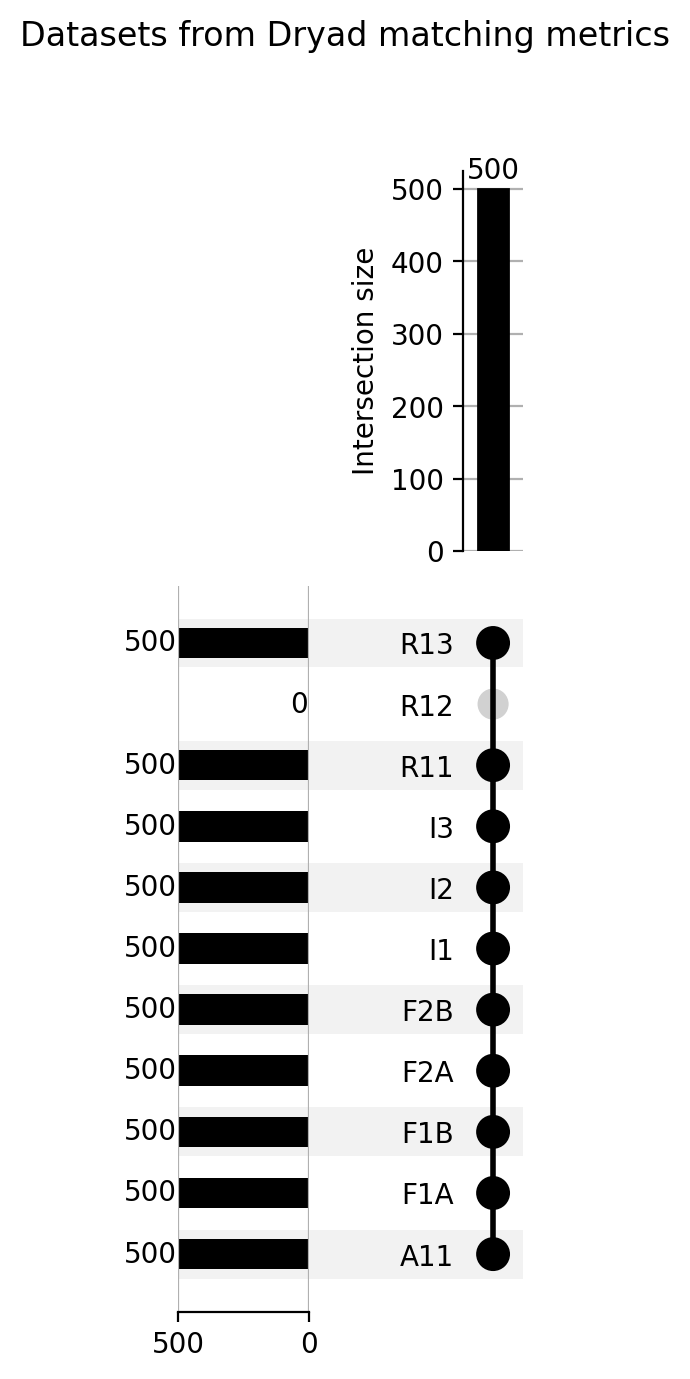

In [18]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Dryad matching metrics")
plt.savefig(OUTPUT_DIR + 'DRYAD_all_data.png', format="png")
plt.show()